** This code loads models saved and trained on training set, and creates an ensemble network by combining these networks **

**Models Used - Score :**
* GP - 1.481
* LSTM - 1.543
* GRU - 1.486
* Stacked GRU (2 GRU layers) - 1.535

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['LANL-Earthquake-Prediction', 'submodels-lstm-gru', 'submission-files']


In [2]:
DATA_PATH = '../input/LANL-Earthquake-Prediction/'
MODEL_PATH = '../input/submodels-lstm-gru/'
TEST_PATH = '../input/submission-files/'

## BASIC IDEA OF THE KERNEL
The idea is to use Stacked Generalization Ensemble Model, using the models that we trained earlier, i.e. LSTM_model and GRU_model, and any more that we add.
The data consists of a one dimensional time series x with 600 Mio data points. 
At test time, we will see a time series of length 150'000 to predict the next earthquake.
The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
time steps. 


In [3]:
import numpy as np 
import pandas as pd
import os
from tqdm import tqdm

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
%time float_data = pd.read_csv(DATA_PATH + "train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

CPU times: user 2min 4s, sys: 13.7 s, total: 2min 18s
Wall time: 2min 18s


In [4]:
np.shape(float_data)

(629145480, 2)

## Data Visualization

### Earthquake Positions

In [5]:
earthquakes = [5656573, 50085877, 104677355, 138772452, 187641819, 218652629, 245829584, 307838916, 338276286, 375377847, 419368879, 461811622, 495800224, 528777114, 585568143, 621985672]

[12. -1.  7. ...  4.  4.  7.]


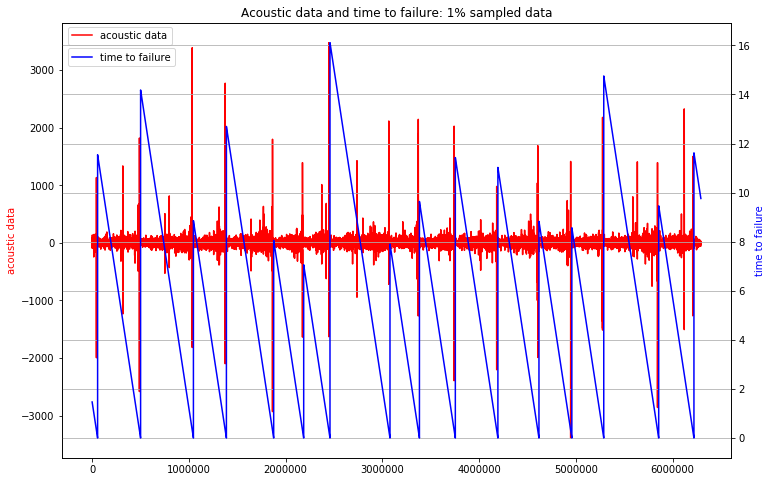

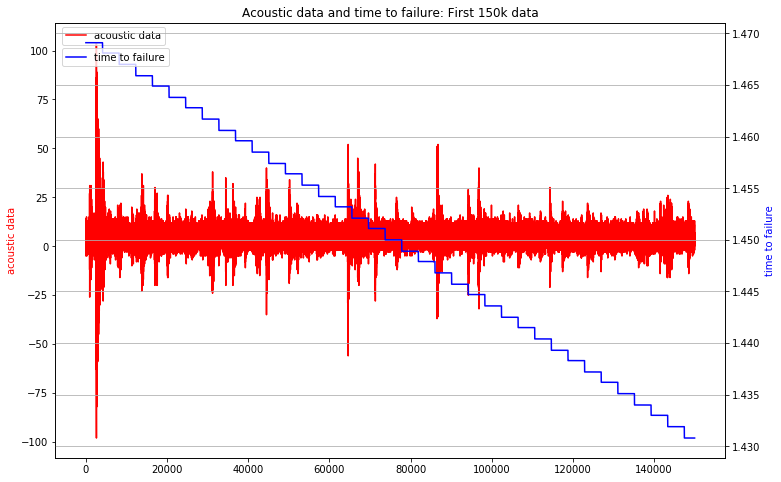

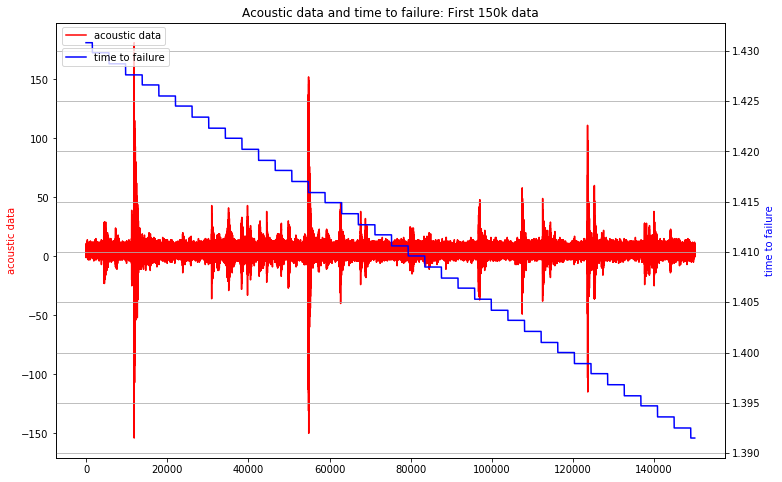

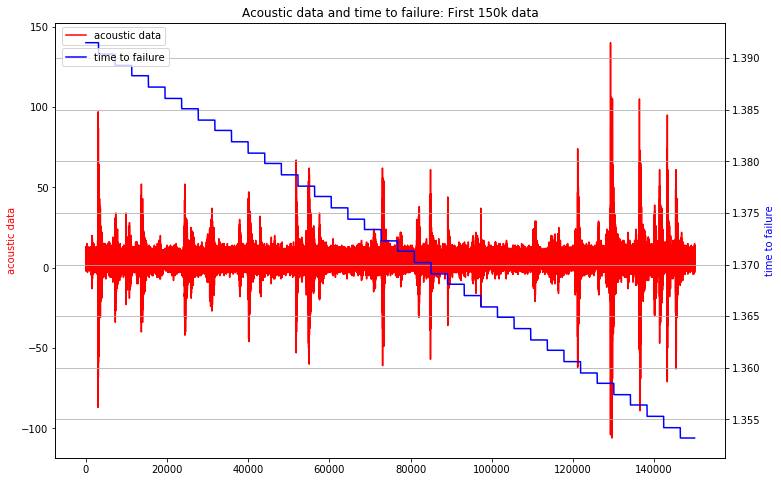

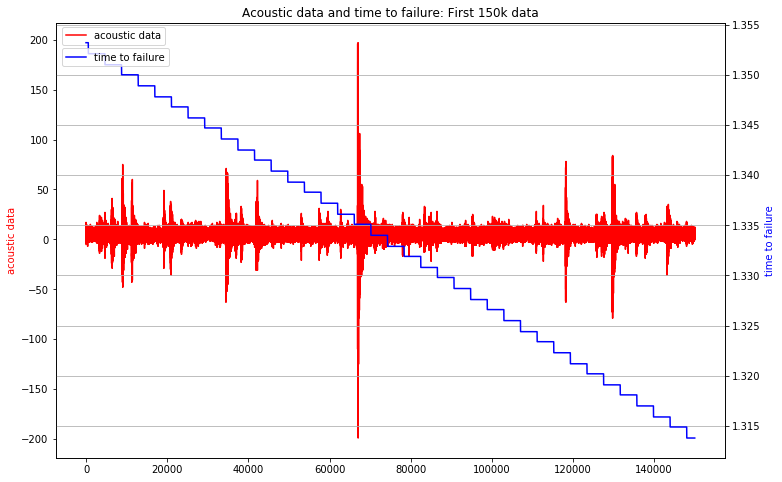

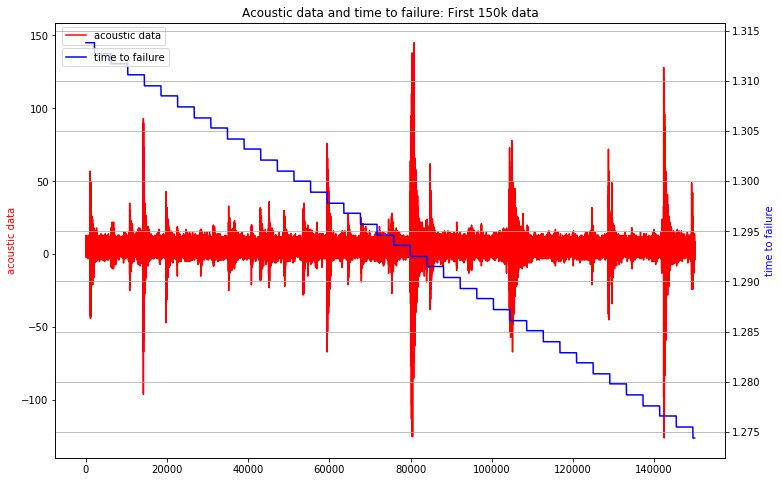

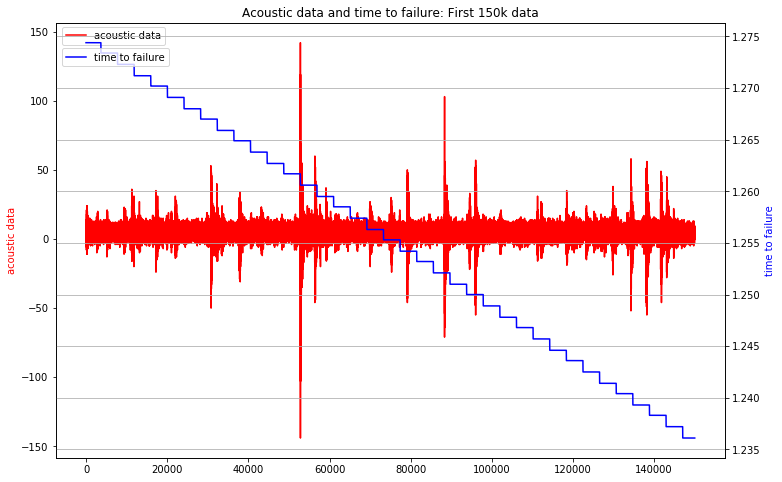

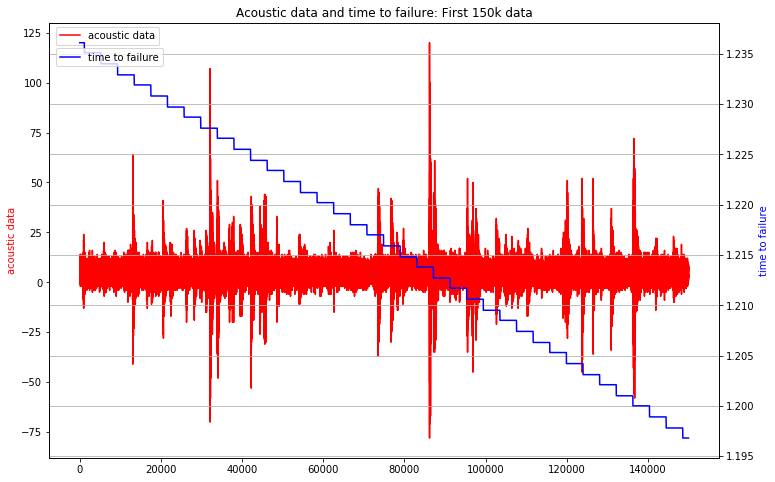

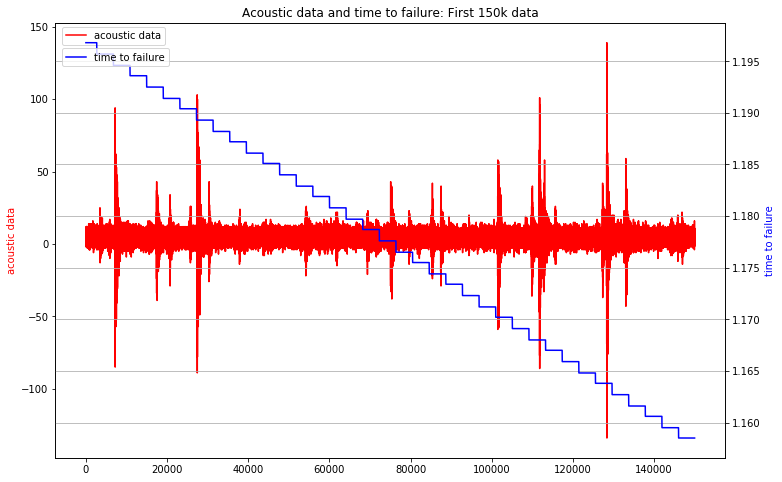

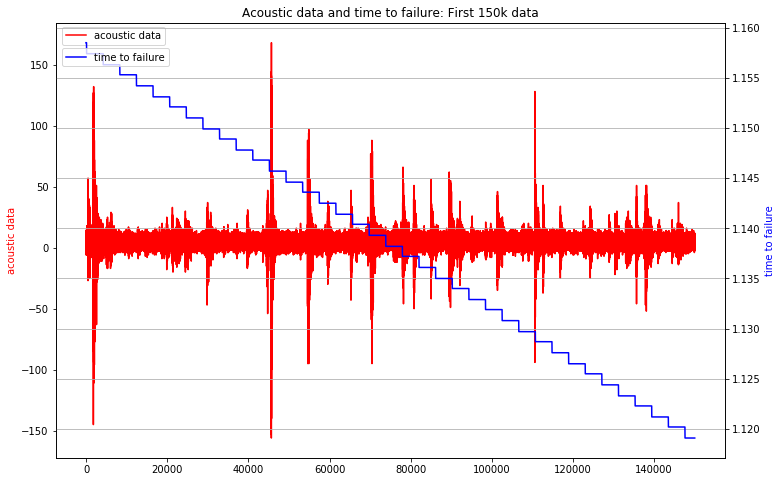

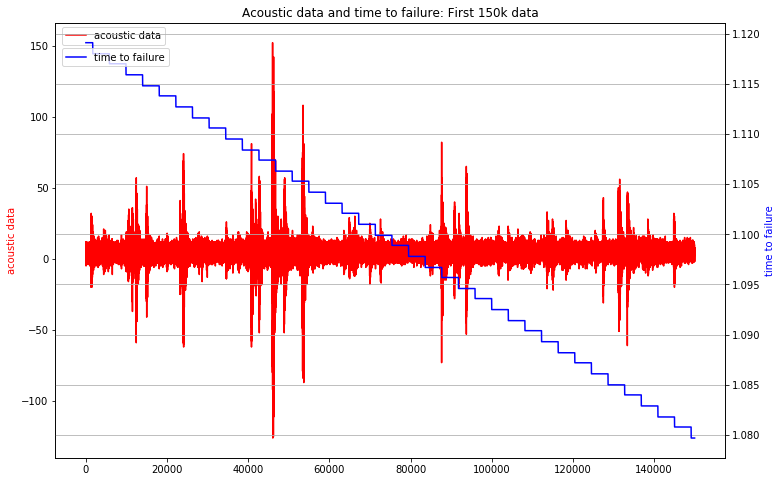

In [6]:
import matplotlib.pyplot as plt
import math
train_ad_sample_df = float_data[:, 0]
train_ad_sample_df = train_ad_sample_df[: : 100]
print(train_ad_sample_df)
train_ttf_sample_df = float_data[:, 1]
train_ttf_sample_df = train_ttf_sample_df[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)
    
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)

for i in range(1 , 1500000, 150000):
    train_ad_sample_df = float_data[i : i + 150000, 0]
    train_ttf_sample_df = float_data[i : i + 150000, 1]
    plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df,  title = "Acoustic data and time to failure: First 150k data")
del train_ad_sample_df
del train_ttf_sample_df


Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
Can easily be extended. Expects a two dimensional array.

In [7]:
def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]


For a given ending position "last_index", we split the last 150'000 values 
of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
From each piece, a set features are extracted. This results in a feature matrix 
of dimension (150 time steps x features).  

In [8]:
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100, 50, 40, 25, 20, 10 and 5 observations
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 5:]),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 20:]),
                 extract_features(temp[:, -step_length // 25:]),
                 extract_features(temp[:, -step_length // 40:]),
                 extract_features(temp[:, -step_length // 50:]),
                 extract_features(temp[:, -step_length // 100:])]

In [9]:
# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
print(float_data[second_earthquake, 1])
print(float_data[second_earthquake, 0])

Our RNN is based on 32 features
0.0006954822
8.0


In [10]:
# SPECIFY NUMBER OF SUB MODELS BEING USED
num_models = 4


# Load models from file

In [11]:
from keras.models import load_model
print(os.listdir("../input"))
all_models = list()
lstm_model = load_model(MODEL_PATH + 'lstm_model.hdf5')
all_models.append(lstm_model)
gru_model = load_model(MODEL_PATH + 'gru_model.hdf5')
all_models.append(gru_model)
dgru_model = load_model(MODEL_PATH + 'dgru_model.hdf5')
all_models.append(dgru_model)

['LANL-Earthquake-Prediction', 'submodels-lstm-gru', 'submission-files']


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


# Initialize generators

The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
the "time_to_failure" serves as target, while the features are created by the function "create_X".

In [12]:
import tensorflow as tf
global graph
graph = tf.get_default_graph() 

def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
    
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
                
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets    

In [13]:
# creating a valid list of segment indices to sample from
# output from other kernels (i.e. GP model) comes in segments of 150,000 so we need to ensure there is no overlap between segments
seg_indices = np.arange(4145)*150000

gp_train = pd.read_csv(TEST_PATH + 'GPtrain.csv')

In [14]:
# We need K copies for K models 
def stacked_generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
   # only want indices within the range specified in function
    seg_range = seg_indices[int((min_index + n_steps * step_length)/150000) : int(max_index/150000)]

    while True:
        # Pick indices of ending positions
#         rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
        
        np.random.shuffle(seg_range)
        rows = seg_range[0:32] # take the first 32 randomly shuffle indices
        
        # Initialize feature matrices and targets
        samples_ret = np.zeros((batch_size, num_models, 1))
        
        #print(samples_ret)
        samples  = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        
            # inserting the training predictions from GP model
            samples_ret[j, 0, 0] = gp_train.time_to_failure[row/150000] 
        
        # inserting the training predictions for the sequence models
        for i, model in enumerate(all_models) :
            with graph.as_default():
                x = model.predict_on_batch(samples)
                samples_ret[:, i+1] = x
        
        #print(samples_ret)
        samples_ret = samples_ret.reshape(batch_size, num_models)
        #print(samples_ret)
        yield samples_ret, targets    

In [15]:
# We are using this train gen to evaluate existing models
train_gen = generator(float_data, batch_size=batch_size, max_index=earthquakes[1])

# We are using train dataset for validation, We don't want to train ensemble model on seen data
stack_val_gen = stacked_generator(float_data, batch_size=batch_size, min_index=earthquakes[1] + 1)
stack_gen = stacked_generator(float_data, batch_size=batch_size, max_index=earthquakes[1])

# Check submodel losses

In [16]:
loss = lstm_model.evaluate_generator(train_gen, steps = 2, verbose=1, use_multiprocessing=True)
print("lstm loss", loss)
loss = gru_model.evaluate_generator(train_gen, steps = 2, verbose=1, use_multiprocessing=True)
print("gru loss", loss)
loss = dgru_model.evaluate_generator(train_gen, steps = 2, verbose=1, use_multiprocessing=True)
print("dgru loss", loss)
for i in range(len(all_models)):
    model = all_models[i]
    print(model.name)
    print([layer.name for layer in model.layers])
#    print(model.input_layer)
#    for layer in model.layers:
#        # make not trainable
#        layer.trainable = False
#        # rename to avoid 'unique layer name' issue
#        layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
#        print(layer.name)

2/2 [==============================] - 3s 2s/step
lstm loss 1.557317852973938
2/2 [==============================] - 0s 208ms/step
gru loss 1.6544107794761658
2/2 [==============================] - 1s 313ms/step
dgru loss 1.5636325478553772
sequential_1
['cu_dnnlstm_1', 'dropout_1', 'dense_1', 'dense_2']
sequential_1
['cu_dnngru_1', 'dense_1', 'dense_2']
sequential_1
['cu_dnngru_1', 'dropout_1', 'cu_dnngru_2', 'dropout_2', 'dense_1', 'dense_2']


# Define Ensemble model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, Dropout
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils import plot_model

mc = ModelCheckpoint("model.hdf5", save_best_only=True, period=5)
es = EarlyStopping(patience = 10, verbose = 1, restore_best_weights = True)
cb = [mc, es]

for model in all_models :
    model.summary()
    
model_st = Sequential()
model_st.add(Dense(16, activation='relu', input_shape = (num_models, )))
model_st.add(Dropout(0.6))
# model_st.add(Dense(32, activation='relu'))
# model_st.add(Dropout(0.4))
# model_st.add(Dense(16, activation='relu'))
# model_st.add(Dropout(0.2))
model_st.add(Dense(1))

# plot graph of ensemble
plot_model(model_st, show_shapes=True, to_file='model_graph.png')
print(os.listdir())

# compile
model_st.compile(loss='mae', optimizer=adam(lr=0.0005))

model_st.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 48)                15744     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 16,245
Trainable params: 16,245
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 48)                11808     
_________________________________________________________________
dense_


# Fit model

In [18]:
#model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model_st.fit_generator(stack_gen,
                              steps_per_epoch=1000,
                              epochs=40,
                              verbose=2,
                              callbacks=cb,
                              validation_data=stack_val_gen,
                              validation_steps=200)

Epoch 1/40
 - 84s - loss: 2.7595 - val_loss: 2.0484
Epoch 2/40
 - 83s - loss: 2.3504 - val_loss: 2.0283
Epoch 3/40
 - 82s - loss: 2.2955 - val_loss: 2.0146
Epoch 4/40
 - 82s - loss: 2.2303 - val_loss: 2.0360
Epoch 5/40
 - 82s - loss: 2.1751 - val_loss: 2.0136
Epoch 6/40
 - 83s - loss: 2.1225 - val_loss: 1.9995
Epoch 7/40
 - 82s - loss: 2.0946 - val_loss: 2.0571
Epoch 8/40
 - 82s - loss: 2.0577 - val_loss: 1.9743
Epoch 9/40
 - 82s - loss: 2.0575 - val_loss: 1.9967
Epoch 10/40
 - 83s - loss: 2.0166 - val_loss: 2.0126
Epoch 11/40
 - 82s - loss: 1.9813 - val_loss: 2.0165
Epoch 12/40
 - 83s - loss: 1.9940 - val_loss: 2.0362
Epoch 13/40
 - 82s - loss: 1.9707 - val_loss: 2.0494
Epoch 14/40
 - 82s - loss: 1.9708 - val_loss: 1.9982
Epoch 15/40
 - 82s - loss: 1.9722 - val_loss: 2.0261
Epoch 16/40
 - 83s - loss: 1.9727 - val_loss: 2.0196
Epoch 17/40
 - 84s - loss: 1.9593 - val_loss: 2.0092
Epoch 18/40
 - 82s - loss: 1.9393 - val_loss: 2.0220
Restoring model weights from the end of the best epoch



# Visualize accuracies

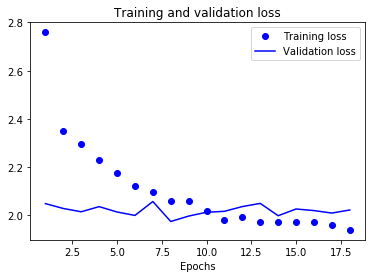

In [19]:
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)


# Load submission file

In [20]:
# Load best model weights
from keras.models import load_model
print(os.listdir("../input/"))
print(os.listdir("../working/"))
pred_model = load_model('model.hdf5')
# pred_model = model_st
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
    
    seg = pd.read_csv(DATA_PATH + 'test/' + seg_id + '.csv')
    gp_sub = pd.read_csv(TEST_PATH + 'GPsubmission.csv')    
    gp_pred = gp_sub.time_to_failure[i]
    
    x = seg['acoustic_data'].values
    x = create_X(x)
    x = np.expand_dims(x, 0)
    #inp = [x, x, x]
    y =  np.zeros((1, num_models))
    
    y[:, 0] = gp_pred
    for j, model in enumerate(all_models) :
        with graph.as_default():
            y[:, j+1] = (model.predict(x))           
    
    submission.time_to_failure[i] = pred_model.predict(y)
    
    print("[GP, LSTM, GRU, DGRU]:", y, " Ensemble:", submission.time_to_failure[i])
    print("==================================================")

submission.head()

# Save
submission.to_csv('submission.csv')

['LANL-Earthquake-Prediction', 'submodels-lstm-gru', 'submission-files']
['model.hdf5', '__output__.json', 'model_graph.png', '__notebook__.ipynb']


  0%|          | 4/2624 [00:00<06:31,  6.70it/s]

[GP, LSTM, GRU, DGRU]: [[3.75991358 3.85462999 2.92147279 3.07208753]]  Ensemble: 3.0310874
[GP, LSTM, GRU, DGRU]: [[4.1424576  5.89892769 5.57730055 5.69694376]]  Ensemble: 5.041869
[GP, LSTM, GRU, DGRU]: [[6.72714804 5.85718203 6.02225399 6.17982197]]  Ensemble: 5.9916925
[GP, LSTM, GRU, DGRU]: [[8.60040447 8.80759811 8.31726646 9.06642151]]  Ensemble: 8.714327
[GP, LSTM, GRU, DGRU]: [[6.44810089 6.18102694 6.69530487 6.28470564]]  Ensemble: 6.1317368
[GP, LSTM, GRU, DGRU]: [[1.67549831 1.41906476 1.07599521 1.78848386]]  Ensemble: 2.0973308


  0%|          | 12/2624 [00:00<03:54, 11.12it/s]

[GP, LSTM, GRU, DGRU]: [[6.94283935 6.31518841 6.97808313 6.03958845]]  Ensemble: 6.2965565
[GP, LSTM, GRU, DGRU]: [[3.14213058 5.24587393 5.59083414 5.70459509]]  Ensemble: 4.4955616
[GP, LSTM, GRU, DGRU]: [[4.40665638 5.43850613 5.0695529  5.35334921]]  Ensemble: 4.7987156
[GP, LSTM, GRU, DGRU]: [[2.50928445 2.2756629  1.89814663 1.88401008]]  Ensemble: 1.9145445
[GP, LSTM, GRU, DGRU]: [[2.59128344 3.86004019 2.75395608 3.92662358]]  Ensemble: 3.0653093
[GP, LSTM, GRU, DGRU]: [[4.43497461 4.96044588 4.94105959 5.3101697 ]]  Ensemble: 4.601137
[GP, LSTM, GRU, DGRU]: [[4.99260437 4.97819281 4.53184891 4.68001175]]  Ensemble: 4.5598135


  1%|          | 20/2624 [00:00<02:37, 16.51it/s]

[GP, LSTM, GRU, DGRU]: [[2.29618955 3.3565526  3.15120721 3.41025662]]  Ensemble: 2.589892
[GP, LSTM, GRU, DGRU]: [[8.10771744 7.79028416 7.93040419 8.65722752]]  Ensemble: 8.026791
[GP, LSTM, GRU, DGRU]: [[4.9433326  5.19066429 4.85464668 5.12862968]]  Ensemble: 4.7831173
[GP, LSTM, GRU, DGRU]: [[4.73887686 5.93434525 5.59332705 5.53411818]]  Ensemble: 5.1935105
[GP, LSTM, GRU, DGRU]: [[4.00219869 4.72461748 4.48186874 4.61808634]]  Ensemble: 4.1411295
[GP, LSTM, GRU, DGRU]: [[6.67166918 6.75377989 6.9815011  6.47243929]]  Ensemble: 6.4983416
[GP, LSTM, GRU, DGRU]: [[3.74465934 5.43630171 4.37080383 4.96776247]]  Ensemble: 4.414692


  1%|          | 24/2624 [00:00<02:15, 19.22it/s]

[GP, LSTM, GRU, DGRU]: [[5.82858264 5.32051563 4.80763578 5.02536058]]  Ensemble: 5.0674
[GP, LSTM, GRU, DGRU]: [[9.22423869 8.67787933 8.74291134 8.79901886]]  Ensemble: 8.828451
[GP, LSTM, GRU, DGRU]: [[3.87258593 4.21498728 4.26584864 4.90244722]]  Ensemble: 3.9636521
[GP, LSTM, GRU, DGRU]: [[4.90775228 5.32250738 4.83715677 5.22724915]]  Ensemble: 4.847071
[GP, LSTM, GRU, DGRU]: [[7.37941875 7.12762451 7.9252305  7.21997738]]  Ensemble: 7.1622753
[GP, LSTM, GRU, DGRU]: [[4.1610912  4.95818853 4.97980165 5.12096548]]  Ensemble: 4.469665
[GP, LSTM, GRU, DGRU]: [[7.91885113 7.58224583 7.36824226 7.26170301]]  Ensemble: 7.44763


  1%|          | 32/2624 [00:01<01:48, 23.82it/s]

[GP, LSTM, GRU, DGRU]: [[5.03875097 4.77893257 4.52766848 4.89429188]]  Ensemble: 4.5568295
[GP, LSTM, GRU, DGRU]: [[2.13237089 2.77460003 2.28811622 2.01605034]]  Ensemble: 1.7595882
[GP, LSTM, GRU, DGRU]: [[4.29440704 5.07049513 4.77647829 5.29380369]]  Ensemble: 4.5773945
[GP, LSTM, GRU, DGRU]: [[4.72368742 4.53467369 4.41189337 4.63758707]]  Ensemble: 4.286174
[GP, LSTM, GRU, DGRU]: [[4.14133079 4.98868752 4.2976861  5.13319683]]  Ensemble: 4.4035425
[GP, LSTM, GRU, DGRU]: [[5.16588827 4.97550631 4.6208539  4.8991251 ]]  Ensemble: 4.6811023
[GP, LSTM, GRU, DGRU]: [[7.31598126 6.47710037 6.37964582 6.46392679]]  Ensemble: 6.521139


  2%|▏         | 40/2624 [00:01<01:35, 26.92it/s]

[GP, LSTM, GRU, DGRU]: [[2.15570902 1.62439716 1.39021051 2.19610167]]  Ensemble: 2.2356834
[GP, LSTM, GRU, DGRU]: [[4.4941462  4.71179771 4.50313807 5.03782129]]  Ensemble: 4.402747
[GP, LSTM, GRU, DGRU]: [[8.75399814 8.00742245 8.27345467 8.46781921]]  Ensemble: 8.290755
[GP, LSTM, GRU, DGRU]: [[5.07662518 5.07582808 4.66911364 5.11901712]]  Ensemble: 4.757263
[GP, LSTM, GRU, DGRU]: [[6.318437   5.65265083 4.84881306 4.81112814]]  Ensemble: 5.2872725
[GP, LSTM, GRU, DGRU]: [[2.11933019 2.43110371 1.98652983 1.83809388]]  Ensemble: 1.7883735
[GP, LSTM, GRU, DGRU]: [[7.4936263  6.53289795 6.58216381 6.73192549]]  Ensemble: 6.6916447


  2%|▏         | 48/2624 [00:01<01:29, 28.78it/s]

[GP, LSTM, GRU, DGRU]: [[8.97118417 9.28446674 9.40812492 9.2658577 ]]  Ensemble: 9.181105
[GP, LSTM, GRU, DGRU]: [[8.00865755 7.04498148 8.21032047 8.10673237]]  Ensemble: 7.5959454
[GP, LSTM, GRU, DGRU]: [[3.90536657 5.59200907 5.29781675 5.46740198]]  Ensemble: 4.760693
[GP, LSTM, GRU, DGRU]: [[8.88683677 7.38469982 8.33590603 7.93457651]]  Ensemble: 7.957341
[GP, LSTM, GRU, DGRU]: [[7.61920029 7.49602032 6.83529472 7.39542627]]  Ensemble: 7.3021507
[GP, LSTM, GRU, DGRU]: [[7.85510845 7.33259678 7.82401466 7.05780649]]  Ensemble: 7.3284893
[GP, LSTM, GRU, DGRU]: [[3.93580715 6.06965542 5.75622082 5.87547493]]  Ensemble: 5.1119914


  2%|▏         | 52/2624 [00:01<01:27, 29.37it/s]

[GP, LSTM, GRU, DGRU]: [[4.57151398 4.07986021 4.11657572 4.46652174]]  Ensemble: 3.989264
[GP, LSTM, GRU, DGRU]: [[6.17769677 5.99918365 5.88250828 6.01803732]]  Ensemble: 5.8188405
[GP, LSTM, GRU, DGRU]: [[4.59586882 5.16895819 4.90877438 5.16216135]]  Ensemble: 4.684574
[GP, LSTM, GRU, DGRU]: [[7.36613179 6.85789204 6.597651   6.82536077]]  Ensemble: 6.8027287
[GP, LSTM, GRU, DGRU]: [[9.29569231 8.97023582 9.10123444 8.82846355]]  Ensemble: 9.007804
[GP, LSTM, GRU, DGRU]: [[1.85304496 3.42081642 2.82385302 3.21175766]]  Ensemble: 2.3392353
[GP, LSTM, GRU, DGRU]: [[2.65456827 5.15265799 4.62863827 4.9736414 ]]  Ensemble: 4.006781


  2%|▏         | 60/2624 [00:02<01:25, 30.11it/s]

[GP, LSTM, GRU, DGRU]: [[8.20195621 8.2884655  7.93110561 7.89458513]]  Ensemble: 8.034762
[GP, LSTM, GRU, DGRU]: [[5.60965302 6.27035332 5.93530416 6.00337267]]  Ensemble: 5.750436
[GP, LSTM, GRU, DGRU]: [[2.36547865 3.89422131 2.64853048 2.66333103]]  Ensemble: 2.1785686
[GP, LSTM, GRU, DGRU]: [[8.13956869 6.69328642 7.38476229 7.2412734 ]]  Ensemble: 7.1756916
[GP, LSTM, GRU, DGRU]: [[6.11974778 6.22688961 6.18779564 5.86579847]]  Ensemble: 5.8790255
[GP, LSTM, GRU, DGRU]: [[6.45177338 6.51177883 7.08231115 6.24878073]]  Ensemble: 6.290266
[GP, LSTM, GRU, DGRU]: [[2.64287897 4.81959009 4.33040762 4.91610003]]  Ensemble: 3.8291428


  3%|▎         | 68/2624 [00:02<01:23, 30.44it/s]

[GP, LSTM, GRU, DGRU]: [[2.13075663 2.78833866 2.42345786 2.19994617]]  Ensemble: 1.8529
[GP, LSTM, GRU, DGRU]: [[4.44827806 5.73021173 5.48198748 5.45095301]]  Ensemble: 4.993352
[GP, LSTM, GRU, DGRU]: [[2.66653961 3.35474062 2.7736733  2.89431953]]  Ensemble: 2.3643203
[GP, LSTM, GRU, DGRU]: [[4.83232896 4.69886255 4.37753153 4.51726151]]  Ensemble: 4.3443785
[GP, LSTM, GRU, DGRU]: [[2.31440211 4.64571095 3.23357105 3.53332877]]  Ensemble: 2.8296664
[GP, LSTM, GRU, DGRU]: [[1.99629899 1.82558882 1.86910033 1.87142467]]  Ensemble: 1.9560262
[GP, LSTM, GRU, DGRU]: [[2.3531283  3.70845747 3.2539196  4.13433361]]  Ensemble: 3.0155153


  3%|▎         | 72/2624 [00:02<01:24, 30.18it/s]

[GP, LSTM, GRU, DGRU]: [[9.36786333 8.76818275 8.87260723 8.91266727]]  Ensemble: 8.951429
[GP, LSTM, GRU, DGRU]: [[4.72367059 5.09628201 4.56988192 5.02586508]]  Ensemble: 4.6214523
[GP, LSTM, GRU, DGRU]: [[2.41034365 3.74817419 2.62674022 2.86182857]]  Ensemble: 2.3133893
[GP, LSTM, GRU, DGRU]: [[4.75968121 3.5705266  4.05075121 4.60191107]]  Ensemble: 3.884136
[GP, LSTM, GRU, DGRU]: [[4.86050754 5.7107892  5.28787231 5.33011484]]  Ensemble: 5.0567894
[GP, LSTM, GRU, DGRU]: [[4.82054858 5.06819344 4.86695242 5.21369839]]  Ensemble: 4.7242827


  3%|▎         | 80/2624 [00:02<01:24, 30.18it/s]

[GP, LSTM, GRU, DGRU]: [[5.13534173 5.22811413 4.51919222 5.22387552]]  Ensemble: 4.844701
[GP, LSTM, GRU, DGRU]: [[3.92422077 5.42385817 4.98236322 5.37993002]]  Ensemble: 4.644429
[GP, LSTM, GRU, DGRU]: [[4.76050551 4.51807213 4.15323114 4.48321009]]  Ensemble: 4.2204485
[GP, LSTM, GRU, DGRU]: [[4.81711859 4.89251184 4.95653486 5.25138903]]  Ensemble: 4.6771555
[GP, LSTM, GRU, DGRU]: [[7.44012892 7.44955492 8.2292347  8.18063545]]  Ensemble: 7.5981865
[GP, LSTM, GRU, DGRU]: [[8.94396393 8.37345982 8.77074051 8.70653915]]  Ensemble: 8.606362
[GP, LSTM, GRU, DGRU]: [[4.72435595 5.58325958 5.10446405 5.33866358]]  Ensemble: 4.9495554


  3%|▎         | 88/2624 [00:03<01:20, 31.38it/s]

[GP, LSTM, GRU, DGRU]: [[7.49102938 7.34144163 7.33264971 7.94983625]]  Ensemble: 7.4112244
[GP, LSTM, GRU, DGRU]: [[7.67854128 7.05298662 7.57873583 7.0445075 ]]  Ensemble: 7.138873
[GP, LSTM, GRU, DGRU]: [[5.11108564 5.30449438 5.03650141 5.1628828 ]]  Ensemble: 4.906312
[GP, LSTM, GRU, DGRU]: [[3.7335586  3.80198765 3.11053991 3.18472505]]  Ensemble: 3.0881972
[GP, LSTM, GRU, DGRU]: [[9.68911204 9.023139   8.97419262 9.16142464]]  Ensemble: 9.224263
[GP, LSTM, GRU, DGRU]: [[8.50891272 7.06598186 7.92629194 8.0340786 ]]  Ensemble: 7.7046394
[GP, LSTM, GRU, DGRU]: [[6.33476276 6.13297987 7.33364534 6.91420984]]  Ensemble: 6.3215094


  4%|▎         | 96/2624 [00:03<01:16, 33.03it/s]

[GP, LSTM, GRU, DGRU]: [[2.3687927  2.58057451 2.48187041 2.32026911]]  Ensemble: 1.9678242
[GP, LSTM, GRU, DGRU]: [[6.77212203 6.21372795 6.35655832 5.98443937]]  Ensemble: 6.12309
[GP, LSTM, GRU, DGRU]: [[9.25305093 9.3122282  9.52904797 9.08485413]]  Ensemble: 9.240931
[GP, LSTM, GRU, DGRU]: [[4.96182754 5.09636593 5.09215069 5.15758276]]  Ensemble: 4.787198
[GP, LSTM, GRU, DGRU]: [[9.5768452  9.2398262  9.14636326 9.33745861]]  Ensemble: 9.338941
[GP, LSTM, GRU, DGRU]: [[6.05725271 4.14382458 3.8986702  3.98164129]]  Ensemble: 4.3078585
[GP, LSTM, GRU, DGRU]: [[9.26778109 8.87866783 8.77285767 8.59143257]]  Ensemble: 8.8639
[GP, LSTM, GRU, DGRU]: [[3.19569771 3.3388195  3.59821057 4.35193491]]  Ensemble: 3.2039137


  4%|▍         | 104/2624 [00:03<01:13, 34.12it/s]

[GP, LSTM, GRU, DGRU]: [[5.323031   5.65280342 5.24096537 5.44040251]]  Ensemble: 5.2003345
[GP, LSTM, GRU, DGRU]: [[6.74160569 6.37156343 7.07292366 7.02639103]]  Ensemble: 6.5369883
[GP, LSTM, GRU, DGRU]: [[5.79892581 5.9672575  5.5755558  5.61772871]]  Ensemble: 5.548622
[GP, LSTM, GRU, DGRU]: [[8.20737564 7.43005323 7.21490335 7.76663542]]  Ensemble: 7.5990543
[GP, LSTM, GRU, DGRU]: [[2.39899907 4.08377266 3.0130527  3.74246573]]  Ensemble: 2.9835615
[GP, LSTM, GRU, DGRU]: [[4.51124629 5.73573017 5.26231909 5.48076296]]  Ensemble: 4.998556
[GP, LSTM, GRU, DGRU]: [[4.74347026 3.94510698 3.91607881 4.28168392]]  Ensemble: 3.9180777


  4%|▍         | 112/2624 [00:03<01:12, 34.75it/s]

[GP, LSTM, GRU, DGRU]: [[4.08751039 4.7697835  4.24944162 4.72734022]]  Ensemble: 4.188387
[GP, LSTM, GRU, DGRU]: [[4.63636617 4.08035755 4.31741285 4.64801216]]  Ensemble: 4.0808396
[GP, LSTM, GRU, DGRU]: [[9.62244437 9.08128929 9.02401066 9.17877102]]  Ensemble: 9.236168
[GP, LSTM, GRU, DGRU]: [[8.23580868 6.9122963  6.84616995 7.07909822]]  Ensemble: 7.183941
[GP, LSTM, GRU, DGRU]: [[9.71583193 8.64269257 8.97982693 9.05669117]]  Ensemble: 9.060912
[GP, LSTM, GRU, DGRU]: [[9.33355415 9.35027027 9.40430546 9.33093452]]  Ensemble: 9.333293
[GP, LSTM, GRU, DGRU]: [[5.09151123 5.3093257  4.87016582 5.34988451]]  Ensemble: 4.935046
[GP, LSTM, GRU, DGRU]: [[3.6410255  5.32868385 4.12115717 4.77513313]]  Ensemble: 4.2625456


  5%|▍         | 120/2624 [00:03<01:11, 35.02it/s]

[GP, LSTM, GRU, DGRU]: [[2.65700771 2.42846537 2.27457738 2.09697342]]  Ensemble: 1.959294
[GP, LSTM, GRU, DGRU]: [[2.55523279 4.05116558 2.45002723 2.36247802]]  Ensemble: 2.0821161
[GP, LSTM, GRU, DGRU]: [[7.89834724 7.04975128 7.98759985 8.22267246]]  Ensemble: 7.5714836
[GP, LSTM, GRU, DGRU]: [[2.38387652 4.59741402 3.41698861 3.42886496]]  Ensemble: 2.7679362
[GP, LSTM, GRU, DGRU]: [[5.43306186 6.02975655 5.57737112 5.58226061]]  Ensemble: 5.4516244
[GP, LSTM, GRU, DGRU]: [[2.65032074 3.98847818 2.58191705 3.45361543]]  Ensemble: 2.908127
[GP, LSTM, GRU, DGRU]: [[1.72498777 2.51866484 2.01911616 1.96317124]]  Ensemble: 1.767601
[GP, LSTM, GRU, DGRU]: [[1.8613354  1.6536932  1.98838794 2.10247803]]  Ensemble: 2.0709774


  5%|▍         | 124/2624 [00:04<01:11, 35.20it/s]

[GP, LSTM, GRU, DGRU]: [[8.95011214 8.27575302 8.49583626 8.78375053]]  Ensemble: 8.562291
[GP, LSTM, GRU, DGRU]: [[5.87979721 6.159863   5.92928553 6.04072809]]  Ensemble: 5.800336
[GP, LSTM, GRU, DGRU]: [[9.53796821 9.15001869 9.29644966 9.37574387]]  Ensemble: 9.320243
[GP, LSTM, GRU, DGRU]: [[2.45348758 3.70358276 2.90550828 3.22154403]]  Ensemble: 2.5622363
[GP, LSTM, GRU, DGRU]: [[4.53586687 4.89986086 4.41407013 4.75163984]]  Ensemble: 4.3982735
[GP, LSTM, GRU, DGRU]: [[1.94341736 2.72893906 2.54758286 2.81683183]]  Ensemble: 2.188908
[GP, LSTM, GRU, DGRU]: [[2.21187573 3.82575512 3.51633143 3.8739903 ]]  Ensemble: 2.920185
[GP, LSTM, GRU, DGRU]: [[4.89496526 3.88242626 3.79043412 3.73622227]] 

  5%|▌         | 132/2624 [00:04<01:11, 34.82it/s]

 Ensemble: 3.7774682
[GP, LSTM, GRU, DGRU]: [[5.49290729 5.76019192 5.17927694 5.4485755 ]]  Ensemble: 5.2878475
[GP, LSTM, GRU, DGRU]: [[3.01119017 5.1844635  3.86544681 4.94259119]]  Ensemble: 4.034662
[GP, LSTM, GRU, DGRU]: [[8.31188286 7.78416157 7.62398481 8.26478863]]  Ensemble: 7.945471
[GP, LSTM, GRU, DGRU]: [[2.56848953 3.95239353 2.67430758 2.72123051]]  Ensemble: 2.2773755
[GP, LSTM, GRU, DGRU]: [[9.30179657 8.71875572 8.65835953 8.91124916]]  Ensemble: 8.8888035
[GP, LSTM, GRU, DGRU]: [[4.2709974  5.59768867 5.21232748 5.44096947]]  Ensemble: 4.857203
[GP, LSTM, GRU, DGRU]: [[6.43419397 5.87405586 6.05732203 5.84517622]]  Ensemble: 5.8214703


  5%|▌         | 140/2624 [00:04<01:11, 34.72it/s]

[GP, LSTM, GRU, DGRU]: [[5.88807641 6.52152061 6.6796689  6.82907438]]  Ensemble: 6.2372503
[GP, LSTM, GRU, DGRU]: [[2.32167611 4.44283438 3.87247252 4.01579046]]  Ensemble: 3.1374016
[GP, LSTM, GRU, DGRU]: [[1.75915655 1.61751163 1.55234408 2.04148006]]  Ensemble: 2.1048625
[GP, LSTM, GRU, DGRU]: [[5.85828258 6.03860283 5.91756487 5.81926584]]  Ensemble: 5.6862392
[GP, LSTM, GRU, DGRU]: [[4.66762165 5.46515036 5.04322386 5.04118586]]  Ensemble: 4.7997265
[GP, LSTM, GRU, DGRU]: [[8.14709556 8.76268005 8.80553436 8.49867153]]  Ensemble: 8.458195
[GP, LSTM, GRU, DGRU]: [[3.2575028  5.16019964 4.42338514 4.82935429]]  Ensemble: 4.13064


  6%|▌         | 148/2624 [00:04<01:11, 34.67it/s]

[GP, LSTM, GRU, DGRU]: [[2.24523801 2.1993165  2.07432699 1.97176266]]  Ensemble: 1.9121941
[GP, LSTM, GRU, DGRU]: [[4.86520126 5.56572008 5.13497114 5.42807674]]  Ensemble: 5.013501
[GP, LSTM, GRU, DGRU]: [[4.63005307 4.85936356 4.64987135 4.68575573]]  Ensemble: 4.4194956
[GP, LSTM, GRU, DGRU]: [[1.24310084 2.6945715  3.52387595 2.87042356]]  Ensemble: 2.126917
[GP, LSTM, GRU, DGRU]: [[1.99782373 2.23238659 2.19145918 2.23066998]]  Ensemble: 1.9746236
[GP, LSTM, GRU, DGRU]: [[9.42053319 9.24418926 9.22351837 9.17163181]]  Ensemble: 9.2562685
[GP, LSTM, GRU, DGRU]: [[6.8540324  7.01210403 6.74767971 6.90428877]]  Ensemble: 6.7434893
[GP, LSTM, GRU, DGRU]: 

  6%|▌         | 156/2624 [00:04<01:11, 34.65it/s]

[[8.75392234 9.30082417 9.47452641 9.24744701]]  Ensemble: 9.123582
[GP, LSTM, GRU, DGRU]: [[5.03827414 5.56833982 5.16729641 5.39542055]]  Ensemble: 5.0616503
[GP, LSTM, GRU, DGRU]: [[5.93034618 5.99541759 5.85745096 5.203269  ]]  Ensemble: 5.516782
[GP, LSTM, GRU, DGRU]: [[1.92652938 2.85238791 2.18520308 2.01924658]]  Ensemble: 1.7386107
[GP, LSTM, GRU, DGRU]: [[4.27504632 6.16387749 5.47674894 5.08556509]]  Ensemble: 4.938893
[GP, LSTM, GRU, DGRU]: [[4.91926722 4.79618931 4.75350904 5.22822428]]  Ensemble: 4.6432
[GP, LSTM, GRU, DGRU]: [[7.04243765 6.81141472 6.00264215 5.57136011]]  Ensemble: 6.2786436
[GP, LSTM, GRU, DGRU]: [[8.19055306 7.53514624 7.35115576 7.76785803]]  Ensemble: 7.648881


  6%|▋         | 164/2624 [00:05<01:10, 35.06it/s]

[GP, LSTM, GRU, DGRU]: [[8.90999723 8.93117809 9.02225494 8.83670425]]  Ensemble: 8.869568
[GP, LSTM, GRU, DGRU]: [[1.91322958 3.95009661 3.37346673 4.20940161]]  Ensemble: 3.0163813
[GP, LSTM, GRU, DGRU]: [[2.33820744 3.3093071  2.65925622 2.82960367]]  Ensemble: 2.2087145
[GP, LSTM, GRU, DGRU]: [[8.11641353 7.1597414  8.3928175  8.5257206 ]]  Ensemble: 7.806554
[GP, LSTM, GRU, DGRU]: [[3.60445915 4.29666948 3.20207667 3.77556682]]  Ensemble: 3.4879973
[GP, LSTM, GRU, DGRU]: [[4.70715164 3.71970034 4.23177481 4.50191021]]  Ensemble: 3.9169836
[GP, LSTM, GRU, DGRU]: [[4.28920031 5.8378377  5.66920519 5.70750761]]  Ensemble: 5.076371
[GP, LSTM, GRU, DGRU]: [[3.76247742 5.53671455 4.77995968 5.06012058]]  Ensemble: 4.528183


  7%|▋         | 172/2624 [00:05<01:09, 35.25it/s]

[GP, LSTM, GRU, DGRU]: [[9.20691922 8.72580528 8.59796429 8.4968729 ]]  Ensemble: 8.742712
[GP, LSTM, GRU, DGRU]: [[5.2306099  3.45675087 3.7284925  3.37118483]]  Ensemble: 3.612236
[GP, LSTM, GRU, DGRU]: [[5.69177557 5.90546227 5.7026782  5.82433701]]  Ensemble: 5.563265
[GP, LSTM, GRU, DGRU]: [[9.66787916 9.10084629 9.17759895 9.32502556]]  Ensemble: 9.314208
[GP, LSTM, GRU, DGRU]: [[4.68905392 5.78163385 5.36695147 5.57677174]]  Ensemble: 5.1075926
[GP, LSTM, GRU, DGRU]: [[2.74638241 3.82994604 2.64282489 2.33266568]]  Ensemble: 2.0803719
[GP, LSTM, GRU, DGRU]: [[4.82384087 4.26120138 3.99197912 4.64243174]]  Ensemble: 4.168642
[GP, LSTM, GRU, DGRU]: [[4.02350715 5.01458693 4.72846031 4.88383961]]  Ensemble: 4.356698


  7%|▋         | 180/2624 [00:05<01:10, 34.44it/s]

[GP, LSTM, GRU, DGRU]: [[4.22932162 5.59662294 5.15195704 5.2973938 ]]  Ensemble: 4.798254
[GP, LSTM, GRU, DGRU]: [[4.66141563 5.19635916 4.64323425 4.97661591]]  Ensemble: 4.634882
[GP, LSTM, GRU, DGRU]: [[6.186691   5.26962662 4.37272644 5.06956053]]  Ensemble: 5.1212096
[GP, LSTM, GRU, DGRU]: [[4.9489259  5.33309078 4.60073662 5.08123446]]  Ensemble: 4.797649
[GP, LSTM, GRU, DGRU]: [[7.68821512 7.68516874 7.6461215  7.9794898 ]]  Ensemble: 7.643242
[GP, LSTM, GRU, DGRU]: [[2.16408344 3.81669617 3.26386762 3.78374696]]  Ensemble: 2.8553076
[GP, LSTM, GRU, DGRU]: [[4.6040401  4.97216177 4.45007372 4.98891401]]  Ensemble: 4.515068


  7%|▋         | 188/2624 [00:05<01:09, 35.02it/s]

[GP, LSTM, GRU, DGRU]: [[8.13469876 7.0167017  7.45177031 7.36172104]]  Ensemble: 7.3364534
[GP, LSTM, GRU, DGRU]: [[9.74607335 9.16857433 9.14253521 9.26322746]]  Ensemble: 9.342729
[GP, LSTM, GRU, DGRU]: [[5.80832647 6.29716253 6.10716248 5.85322905]]  Ensemble: 5.798685
[GP, LSTM, GRU, DGRU]: [[3.36487992 4.77871418 3.48444247 3.99856019]]  Ensemble: 3.6417203
[GP, LSTM, GRU, DGRU]: [[2.27875629 3.86324549 3.39840031 4.09185982]]  Ensemble: 3.0379095
[GP, LSTM, GRU, DGRU]: [[5.50759273 4.79630327 4.26467943 4.84318018]]  Ensemble: 4.662822
[GP, LSTM, GRU, DGRU]: [[5.92931025 5.47885942 5.21058035 5.33799648]]  Ensemble: 5.2874537
[GP, LSTM, GRU, DGRU]: [[8.25976721 7.91520262 7.97578382 7.53610086]]  Ensemble: 7.8184624


  7%|▋         | 196/2624 [00:06<01:08, 35.29it/s]

[GP, LSTM, GRU, DGRU]: [[9.06750374 7.39647675 8.08448696 7.64359808]]  Ensemble: 7.9094257
[GP, LSTM, GRU, DGRU]: [[6.2484052  5.39590645 5.13640642 5.26789618]]  Ensemble: 5.325722
[GP, LSTM, GRU, DGRU]: [[4.22832548 5.19025183 4.79697561 4.96604061]]  Ensemble: 4.515113
[GP, LSTM, GRU, DGRU]: [[6.65708653 6.3912015  6.50539589 6.72359037]]  Ensemble: 6.373561
[GP, LSTM, GRU, DGRU]: [[2.28949511 4.37240601 3.46216989 3.181427  ]]  Ensemble: 2.526801
[GP, LSTM, GRU, DGRU]: [[9.92028384 9.33479881 9.4710865  9.42157936]]  Ensemble: 9.537695
[GP, LSTM, GRU, DGRU]: [[9.87543102 9.1856451  9.16944027 9.33088303]]  Ensemble: 9.40989
[GP, LSTM, GRU, DGRU]: [[7.70426613 7.20750666 7.43096638 7.53761816]]  Ensemble: 7.3235426


  8%|▊         | 204/2624 [00:06<01:08, 35.26it/s]

[GP, LSTM, GRU, DGRU]: [[2.13290142 3.01600266 2.4219296  2.51991129]]  Ensemble: 1.9966862
[GP, LSTM, GRU, DGRU]: [[8.16584716 7.8663888  8.45182419 8.08551693]]  Ensemble: 7.974103
[GP, LSTM, GRU, DGRU]: [[7.88004707 8.04274082 7.61392784 8.01369381]]  Ensemble: 7.842107
[GP, LSTM, GRU, DGRU]: [[4.38155122 4.87169933 4.47272301 4.89110184]]  Ensemble: 4.3853927
[GP, LSTM, GRU, DGRU]: [[5.78358942 5.96338177 5.72747469 5.71679354]]  Ensemble: 5.586291
[GP, LSTM, GRU, DGRU]: [[7.89741362 7.11425447 7.91479683 8.06729126]]  Ensemble: 7.5450296
[GP, LSTM, GRU, DGRU]: [[4.15602895 5.69849968 5.62459373 5.39023066]]  Ensemble: 4.8917475
[GP, LSTM, GRU, DGRU]: [[7.603678   6.80698633 6.92445898 7.10681486]]  Ensemble: 6.968527


  8%|▊         | 212/2624 [00:06<01:08, 35.26it/s]

[GP, LSTM, GRU, DGRU]: [[8.12642245 7.43105745 7.74449015 7.11842966]]  Ensemble: 7.4558105
[GP, LSTM, GRU, DGRU]: [[2.63008678 2.96897602 2.25315762 2.15260458]]  Ensemble: 1.8770738
[GP, LSTM, GRU, DGRU]: [[9.68677717 9.15749073 9.19085693 9.13233757]]  Ensemble: 9.290068
[GP, LSTM, GRU, DGRU]: [[7.94968421 7.17545509 7.83314514 7.68678188]]  Ensemble: 7.470948
[GP, LSTM, GRU, DGRU]: [[7.6648406  8.60961914 8.54831791 8.43013763]]  Ensemble: 8.207081
[GP, LSTM, GRU, DGRU]: [[2.71068073 4.9184761  4.44596338 4.10336733]]  Ensemble: 3.4085798
[GP, LSTM, GRU, DGRU]: [[5.7362219  6.35415697 5.96713638 6.19440794]]  Ensemble: 5.876191
[GP, LSTM, GRU, DGRU]: [[4.84243909 4.86455297 4.38891602 4.85719109]]  Ensemble: 4.5041237


  8%|▊         | 220/2624 [00:06<01:08, 35.32it/s]

[GP, LSTM, GRU, DGRU]: [[7.58337613 7.05809784 7.81791544 7.29603624]]  Ensemble: 7.2069798
[GP, LSTM, GRU, DGRU]: [[1.92281696 2.82584667 2.43661928 2.283746  ]]  Ensemble: 1.8769324
[GP, LSTM, GRU, DGRU]: [[8.65628393 7.63216114 8.18088818 8.22429371]]  Ensemble: 8.042841
[GP, LSTM, GRU, DGRU]: [[3.42934773 3.07058764 2.76629519 2.83892465]]  Ensemble: 2.6447625
[GP, LSTM, GRU, DGRU]: [[6.42013696 6.32909775 6.33645248 6.25384235]]  Ensemble: 6.1311965
[GP, LSTM, GRU, DGRU]: [[3.65926102 4.82084322 3.80726695 4.13229036]]  Ensemble: 3.8611698
[GP, LSTM, GRU, DGRU]: [[8.27439914 9.12615967 9.12923813 8.83204746]]  Ensemble: 8.760622
[GP, LSTM, GRU, DGRU]: [[7.23660393 6.65048742 6.52260637 6.25598574]]  Ensemble: 6.521267


  9%|▊         | 228/2624 [00:07<01:07, 35.58it/s]

[GP, LSTM, GRU, DGRU]: [[7.1094293  6.35037661 6.43670511 6.17990828]]  Ensemble: 6.339265
[GP, LSTM, GRU, DGRU]: [[5.0154618  5.01437569 4.69830942 4.95565176]]  Ensemble: 4.6740627
[GP, LSTM, GRU, DGRU]: [[3.65176557 4.93361044 3.55011153 4.12285519]]  Ensemble: 3.8757234
[GP, LSTM, GRU, DGRU]: [[9.20813525 8.78112411 8.76184177 8.55632401]]  Ensemble: 8.798205
[GP, LSTM, GRU, DGRU]: [[9.54814552 8.78264236 8.77894115 8.70560837]]  Ensemble: 8.944694
[GP, LSTM, GRU, DGRU]: [[6.7830683  6.13373947 6.16823578 6.02884626]]  Ensemble: 6.0877
[GP, LSTM, GRU, DGRU]: [[6.8484548  6.76057863 6.49278831 6.75729322]]  Ensemble: 6.5787525
[GP, LSTM, GRU, DGRU]: [[9.22728578 7.92290449 8.46001339 7.93003035]]  Ensemble: 8.276008


  9%|▉         | 236/2624 [00:07<01:07, 35.38it/s]

[GP, LSTM, GRU, DGRU]: [[3.54666349 5.10473967 3.98103261 4.35977697]]  Ensemble: 4.010034
[GP, LSTM, GRU, DGRU]: [[4.79292997 5.19684696 4.66244841 5.10534477]]  Ensemble: 4.7123013
[GP, LSTM, GRU, DGRU]: [[7.59074283 6.94385195 7.48986006 6.95826769]]  Ensemble: 7.0377235
[GP, LSTM, GRU, DGRU]: [[4.48838896 5.32251453 5.14186621 5.35302496]]  Ensemble: 4.787652
[GP, LSTM, GRU, DGRU]: [[6.02469196 6.03731966 5.99297333 5.92232037]]  Ensemble: 5.7727394
[GP, LSTM, GRU, DGRU]: [[9.55191456 8.54483891 8.65869427 8.91553688]]  Ensemble: 8.900367
[GP, LSTM, GRU, DGRU]: [[8.90752566 9.32622814 9.24034405 8.87121201]]  Ensemble: 9.05117
[GP, LSTM, GRU, DGRU]: [[5.11769924 5.94469309 5.45973158 5.48701382]]  Ensemble: 5.2848454


  9%|▉         | 244/2624 [00:07<01:07, 35.14it/s]

[GP, LSTM, GRU, DGRU]: [[8.48200115 8.03338146 8.37280369 8.41916847]]  Ensemble: 8.21559
[GP, LSTM, GRU, DGRU]: [[2.07956059 3.34296322 3.80219674 3.98916602]]  Ensemble: 2.8901722
[GP, LSTM, GRU, DGRU]: [[1.56774391 1.84090579 1.69888949 1.97521567]]  Ensemble: 1.9698918
[GP, LSTM, GRU, DGRU]: [[2.50995167 2.53584862 2.05143571 1.98306525]]  Ensemble: 1.8781455
[GP, LSTM, GRU, DGRU]: [[4.82861622 5.55473232 5.32040977 5.38277578]]  Ensemble: 5.0062456
[GP, LSTM, GRU, DGRU]: [[1.96816808 1.89489532 1.76790667 2.11741257]]  Ensemble: 2.066505
[GP, LSTM, GRU, DGRU]: [[9.38727957 9.1585331  9.28418636 8.97615242]]  Ensemble: 9.167093
[GP, LSTM, GRU, DGRU]: [[4.28005138 5.88704681 5.42648411 5.30751038]]  Ensemble: 4.956092


 10%|▉         | 252/2624 [00:07<01:07, 35.19it/s]

[GP, LSTM, GRU, DGRU]: [[5.90200947 5.47111225 5.17259932 5.33728933]]  Ensemble: 5.2718782
[GP, LSTM, GRU, DGRU]: [[7.84700438 6.96513844 7.50191927 7.52317095]]  Ensemble: 7.279339
[GP, LSTM, GRU, DGRU]: [[5.04111395 4.91969013 4.70804071 5.15467739]]  Ensemble: 4.701643
[GP, LSTM, GRU, DGRU]: [[5.3298743  6.14847755 5.94869184 5.91747236]]  Ensemble: 5.597536
[GP, LSTM, GRU, DGRU]: [[6.30437481 6.03664684 5.90225649 5.7670517 ]]  Ensemble: 5.8049593
[GP, LSTM, GRU, DGRU]: [[10.01319763  9.3370924   9.48874855  9.38489532]]  Ensemble: 9.558676
[GP, LSTM, GRU, DGRU]: [[9.71133006 9.05192947 9.04750729 8.8019495 ]]  Ensemble: 9.151622
[GP, LSTM, GRU, DGRU]: [[4.4503718  5.84095478 5.46974659 5.33084822]]  Ensemble: 5.0015535


 10%|▉         | 260/2624 [00:07<01:06, 35.37it/s]

[GP, LSTM, GRU, DGRU]: [[4.79977213 4.31198454 4.25349092 4.61878252]]  Ensemble: 4.2027574
[GP, LSTM, GRU, DGRU]: [[4.37834089 5.83216667 5.29096413 5.33822823]]  Ensemble: 4.958743
[GP, LSTM, GRU, DGRU]: [[2.30340893 4.02887726 2.97396922 3.84171295]]  Ensemble: 3.024734
[GP, LSTM, GRU, DGRU]: [[4.54397102 4.11382103 3.40611482 3.93748164]]  Ensemble: 3.770959
[GP, LSTM, GRU, DGRU]: [[7.75542167 6.96598673 7.51200247 7.8455739 ]]  Ensemble: 7.3411264
[GP, LSTM, GRU, DGRU]: [[2.06901012 2.27956104 1.93806958 1.88528287]]  Ensemble: 1.8489499
[GP, LSTM, GRU, DGRU]: [[4.79684588 5.55970955 5.17629576 5.37723112]]  Ensemble: 4.981123
[GP, LSTM, GRU, DGRU]: [[7.21529959 6.70032978 6.21396971 6.68546534]]  Ensemble: 6.617112


 10%|█         | 268/2624 [00:08<01:07, 35.02it/s]

[GP, LSTM, GRU, DGRU]: [[2.11018113 3.86150074 3.19203496 3.22079515]]  Ensemble: 2.4253302
[GP, LSTM, GRU, DGRU]: [[6.16790055 5.81445837 5.62414408 5.68861628]]  Ensemble: 5.6277432
[GP, LSTM, GRU, DGRU]: [[3.6059519  5.60417795 5.0352006  5.39399958]]  Ensemble: 4.6254554
[GP, LSTM, GRU, DGRU]: [[7.4298682  6.81362534 7.22078991 7.26396656]]  Ensemble: 6.9938087
[GP, LSTM, GRU, DGRU]: [[4.99605748 5.70597029 5.29465342 5.24525356]]  Ensemble: 5.073661
[GP, LSTM, GRU, DGRU]: [[5.11338653 5.35086155 4.75638342 5.02407169]]  Ensemble: 4.855749
[GP, LSTM, GRU, DGRU]: [[8.65114676 7.98987675 8.44169331 8.65850925]]  Ensemble: 8.323552
[GP, LSTM, GRU, DGRU]: [[2.04939454 3.19176006 2.49173927 3.60056543]]  Ensemble: 2.6345687


 11%|█         | 276/2624 [00:08<01:06, 35.10it/s]

[GP, LSTM, GRU, DGRU]: [[7.48915955 8.05541515 8.16714859 8.19219112]]  Ensemble: 7.837837
[GP, LSTM, GRU, DGRU]: [[6.13274998 5.84808064 5.89639997 5.65772963]]  Ensemble: 5.651226
[GP, LSTM, GRU, DGRU]: [[5.17874163 5.53528118 5.13832855 5.44815207]]  Ensemble: 5.103062
[GP, LSTM, GRU, DGRU]: [[4.85417324 5.88960695 5.85094976 5.81160069]]  Ensemble: 5.315834
[GP, LSTM, GRU, DGRU]: [[2.3016566  4.07131672 2.95502639 2.72871804]]  Ensemble: 2.2190485
[GP, LSTM, GRU, DGRU]: [[4.75841904 4.7974     4.77833509 4.85735941]]  Ensemble: 4.4961443
[GP, LSTM, GRU, DGRU]: [[8.03939151 8.0746851  7.85129547 8.16123295]]  Ensemble: 7.968955
[GP, LSTM, GRU, DGRU]: [[4.28129311 5.88553953 5.66349792 5.66912222]]  Ensemble: 5.0808325


 11%|█         | 284/2624 [00:08<01:06, 35.12it/s]

[GP, LSTM, GRU, DGRU]: [[3.45411966 4.62721777 4.30607653 4.72079611]]  Ensemble: 3.946795
[GP, LSTM, GRU, DGRU]: [[3.91386996 5.14303732 4.10146141 4.45953178]]  Ensemble: 4.1869097
[GP, LSTM, GRU, DGRU]: [[4.62155986 4.92183685 4.51948023 4.97439098]]  Ensemble: 4.505069
[GP, LSTM, GRU, DGRU]: [[5.13395799 5.59880209 5.04091978 5.22810936]]  Ensemble: 5.0425415
[GP, LSTM, GRU, DGRU]: [[4.93417755 4.38819933 4.53025818 4.95705748]]  Ensemble: 4.395212
[GP, LSTM, GRU, DGRU]: [[3.83330646 3.2834568  3.68244958 4.17109203]]  Ensemble: 3.3364015
[GP, LSTM, GRU, DGRU]: [[4.93662024 6.10477972 5.79949903 5.66043615]]  Ensemble: 5.374999
[GP, LSTM, GRU, DGRU]: [[8.72772829 8.62974548 8.65392303 8.32334232]]  Ensemble: 8.519727


 11%|█         | 292/2624 [00:08<01:06, 35.22it/s]

[GP, LSTM, GRU, DGRU]: [[8.82120163 9.2362299  9.06261063 8.65197659]]  Ensemble: 8.911549
[GP, LSTM, GRU, DGRU]: [[2.05775116 4.3245616  4.14847469 4.29739428]]  Ensemble: 3.205192
[GP, LSTM, GRU, DGRU]: [[7.95626737 7.0539608  6.8301959  7.13136339]]  Ensemble: 7.1650314
[GP, LSTM, GRU, DGRU]: [[8.58548906 7.47645426 7.89627218 7.28960896]]  Ensemble: 7.6757736
[GP, LSTM, GRU, DGRU]: [[4.94743409 4.98721886 4.66568422 5.18538046]]  Ensemble: 4.702407
[GP, LSTM, GRU, DGRU]: [[2.33789369 2.37453961 2.20043802 2.42756176]]  Ensemble: 2.104692
[GP, LSTM, GRU, DGRU]: [[4.30608275 5.91587305 5.38950253 5.29135466]]  Ensemble: 4.9663806
[GP, LSTM, GRU, DGRU]: [[4.77510444 5.26284885 5.19787359 5.25550413]]  Ensemble: 4.8316813


 11%|█▏        | 300/2624 [00:09<01:05, 35.24it/s]

[GP, LSTM, GRU, DGRU]: [[2.26093565 4.48258114 4.23395491 4.15337658]]  Ensemble: 3.2022529
[GP, LSTM, GRU, DGRU]: [[4.54792651 4.57608032 4.2455678  4.80198145]]  Ensemble: 4.2751045
[GP, LSTM, GRU, DGRU]: [[2.73940594 4.88515139 3.59004521 3.61763692]]  Ensemble: 3.0934136
[GP, LSTM, GRU, DGRU]: [[2.27772566 3.71759176 2.73662043 2.16772175]]  Ensemble: 1.851376
[GP, LSTM, GRU, DGRU]: [[8.18283942 8.2367363  8.34446335 7.34950781]]  Ensemble: 7.905834
[GP, LSTM, GRU, DGRU]: [[6.2249247  6.28547287 6.10953379 5.95544434]]  Ensemble: 5.9489527
[GP, LSTM, GRU, DGRU]: [[4.71655528 4.72002363 4.19641256 4.62299395]]  Ensemble: 4.326219
[GP, LSTM, GRU, DGRU]: [[4.24814982 4.32060766 4.01985693 4.62062454]]  Ensemble: 4.0133824


 12%|█▏        | 304/2624 [00:09<01:05, 35.22it/s]

[GP, LSTM, GRU, DGRU]: [[1.85868394 3.73690605 2.76345181 3.22499299]]  Ensemble: 2.3913093
[GP, LSTM, GRU, DGRU]: [[4.32120392 5.96288109 5.61100674 5.5482502 ]]  Ensemble: 5.0832863
[GP, LSTM, GRU, DGRU]: [[2.37577905 3.34936571 2.41033149 2.22219849]]  Ensemble: 1.8541032
[GP, LSTM, GRU, DGRU]: [[5.70813167 5.98057747 5.68409872 5.60715723]]  Ensemble: 5.535121
[GP, LSTM, GRU, DGRU]: [[8.57547103 8.54646969 8.65590096 8.83539009]]  Ensemble: 8.582345
[GP, LSTM, GRU, DGRU]: [[5.95154687 5.58268833 5.20676088 5.32330799]]  Ensemble: 5.3289146
[GP, LSTM, GRU, DGRU]: [[9.77034613 9.10599995 9.17152119 9.12539005]]  Ensemble: 9.291998


 12%|█▏        | 312/2624 [00:09<01:06, 34.53it/s]

[GP, LSTM, GRU, DGRU]: [[2.47357377 2.08624744 2.09216309 2.0673182 ]]  Ensemble: 2.0131376
[GP, LSTM, GRU, DGRU]: [[2.23832674 3.78194761 3.23030496 3.77027583]]  Ensemble: 2.8745987
[GP, LSTM, GRU, DGRU]: [[4.3338576  5.7441864  5.29902029 5.488482  ]]  Ensemble: 4.95404
[GP, LSTM, GRU, DGRU]: [[4.71436343 5.27578354 4.85676384 5.03468323]]  Ensemble: 4.720247
[GP, LSTM, GRU, DGRU]: [[4.97701769 4.92307281 4.88438797 3.78656983]]  Ensemble: 4.145851
[GP, LSTM, GRU, DGRU]: [[4.35982203 5.37567186 5.03928995 5.26008272]]  Ensemble: 4.731978
[GP, LSTM, GRU, DGRU]: [[2.02115034 1.51560009 1.17134869 1.94361043]]  Ensemble: 2.1809793


 12%|█▏        | 320/2624 [00:09<01:06, 34.69it/s]

[GP, LSTM, GRU, DGRU]: [[10.02417127  9.28789234  9.40996456  9.39270496]]  Ensemble: 9.536933
[GP, LSTM, GRU, DGRU]: [[4.08249209 5.34600687 4.96996641 5.26488733]]  Ensemble: 4.6303005
[GP, LSTM, GRU, DGRU]: [[5.23265155 5.75877571 5.38953018 5.57916594]]  Ensemble: 5.267127
[GP, LSTM, GRU, DGRU]: [[5.71341304 6.13637972 6.09940529 6.02159166]]  Ensemble: 5.7544384
[GP, LSTM, GRU, DGRU]: [[9.14973113 8.59741783 8.85653687 8.78750706]]  Ensemble: 8.784837
[GP, LSTM, GRU, DGRU]: [[4.66291752 4.61131096 4.41161108 4.97970152]]  Ensemble: 4.390141
[GP, LSTM, GRU, DGRU]: [[2.04347944 3.42609215 3.48439813 4.11380529]]  Ensemble: 2.848482
[GP, LSTM, GRU, DGRU]: [[4.65998708 3.72680378 2.89553952 3.66408157]]  Ensemble: 3.5293822


 12%|█▎        | 328/2624 [00:09<01:05, 35.18it/s]

[GP, LSTM, GRU, DGRU]: [[4.63076229 5.06890297 5.0163455  5.20508862]]  Ensemble: 4.6810026
[GP, LSTM, GRU, DGRU]: [[9.62150724 9.31926537 9.40046501 9.47768784]]  Ensemble: 9.448723
[GP, LSTM, GRU, DGRU]: [[2.2622387  3.55782223 2.38771033 2.7044189 ]]  Ensemble: 2.164964
[GP, LSTM, GRU, DGRU]: [[9.88095109 9.18326855 9.27031803 9.21731186]]  Ensemble: 9.390701
[GP, LSTM, GRU, DGRU]: [[7.76982401 7.23255825 7.35255718 7.67417479]]  Ensemble: 7.381612
[GP, LSTM, GRU, DGRU]: [[5.28909147 6.16135454 5.87960529 5.87877321]]  Ensemble: 5.5718355
[GP, LSTM, GRU, DGRU]: [[4.72389986 5.01864815 4.77412796 5.1867094 ]]  Ensemble: 4.658682
[GP, LSTM, GRU, DGRU]: [[6.09335141 5.58338499 5.07066631 5.40922499]]  Ensemble: 5.3807607


 13%|█▎        | 336/2624 [00:10<01:05, 34.85it/s]

[GP, LSTM, GRU, DGRU]: [[9.28033582 8.0989809  8.58946228 8.65743637]]  Ensemble: 8.571634
[GP, LSTM, GRU, DGRU]: [[1.87022757 3.31746149 2.91125607 3.10031652]]  Ensemble: 2.278877
[GP, LSTM, GRU, DGRU]: [[7.61313611 6.38688183 7.1645813  6.57945681]]  Ensemble: 6.6951885
[GP, LSTM, GRU, DGRU]: [[8.32073415 6.64322901 6.99199772 6.68373251]]  Ensemble: 7.0161877
[GP, LSTM, GRU, DGRU]: [[6.26443657 6.19348907 6.16901779 6.09622526]]  Ensemble: 5.9713
[GP, LSTM, GRU, DGRU]: [[1.8681117  2.46199274 2.15667582 2.12194419]]  Ensemble: 1.8543932
[GP, LSTM, GRU, DGRU]: [[9.53913454 9.06892872 8.99390697 9.00806427]]  Ensemble: 9.156231


 13%|█▎        | 344/2624 [00:10<01:05, 34.72it/s]

[GP, LSTM, GRU, DGRU]: [[5.9641881  5.99335289 6.24033546 6.05989742]]  Ensemble: 5.802601
[GP, LSTM, GRU, DGRU]: [[0.94877151 1.45671225 1.34503496 2.02646017]]  Ensemble: 2.049392
[GP, LSTM, GRU, DGRU]: [[5.79324456 5.60163736 5.44363737 5.23172235]]  Ensemble: 5.2889943
[GP, LSTM, GRU, DGRU]: [[4.39492938 5.05899334 4.10717726 4.90330553]]  Ensemble: 4.423232
[GP, LSTM, GRU, DGRU]: [[8.13683131 7.41528797 7.39657307 7.76584673]]  Ensemble: 7.5918236
[GP, LSTM, GRU, DGRU]: [[5.03530482 5.30036449 4.8215704  5.21159697]]  Ensemble: 4.8714495
[GP, LSTM, GRU, DGRU]: [[6.25076037 5.79608727 5.76066685 5.82253695]]  Ensemble: 5.6975946


 13%|█▎        | 348/2624 [00:10<01:05, 34.81it/s]

[GP, LSTM, GRU, DGRU]: [[3.58743134 4.50756407 3.59097314 4.13899517]]  Ensemble: 3.7044637
[GP, LSTM, GRU, DGRU]: [[5.88998461 6.26709223 6.25604105 6.05818224]]  Ensemble: 5.8845425
[GP, LSTM, GRU, DGRU]: [[3.83258193 5.57019663 5.60401201 5.53325796]]  Ensemble: 4.782035
[GP, LSTM, GRU, DGRU]: [[4.24209153 5.28831005 4.944067   5.14996624]]  Ensemble: 4.622724
[GP, LSTM, GRU, DGRU]: [[4.47297696 6.35608625 6.02718258 6.04765177]]  Ensemble: 5.4599123
[GP, LSTM, GRU, DGRU]: [[5.49528549 5.04832077 4.5801425  4.60664177]]  Ensemble: 4.7240953
[GP, LSTM, GRU, DGRU]: [[4.40933484 4.4633708  4.39667225 4.88314009]]  Ensemble: 4.229337
[GP, LSTM, GRU, DGRU]: [[2.92817716 2.78662348 2.19420314 2.30169725]]  Ensemble: 2.1305587


 14%|█▎        | 356/2624 [00:10<01:05, 34.65it/s]

[GP, LSTM, GRU, DGRU]: [[5.91083482 6.21664858 6.14324951 6.16355467]]  Ensemble: 5.8882704
[GP, LSTM, GRU, DGRU]: [[4.88990527 5.45113611 4.87222385 5.36856031]]  Ensemble: 4.9326468
[GP, LSTM, GRU, DGRU]: [[4.60073728 5.67199087 5.25710535 5.48261499]]  Ensemble: 5.001624
[GP, LSTM, GRU, DGRU]: [[4.77993814 4.87710428 4.36565399 4.84332705]]  Ensemble: 4.4835353
[GP, LSTM, GRU, DGRU]: [[9.42178798 9.1026926  9.18573761 8.74636936]]  Ensemble: 9.082862
[GP, LSTM, GRU, DGRU]: [[9.53600389 8.5255394  9.00226212 9.06676006]]  Ensemble: 8.967371
[GP, LSTM, GRU, DGRU]: [[3.54053896 4.53221512 3.17194724 3.91198277]]  Ensemble: 3.591394


 14%|█▍        | 364/2624 [00:10<01:04, 35.23it/s]

[GP, LSTM, GRU, DGRU]: [[7.91925481 7.47200298 7.47696638 7.04866648]]  Ensemble: 7.3598814
[GP, LSTM, GRU, DGRU]: [[6.02559076 6.25056219 5.96685266 6.05667353]]  Ensemble: 5.8872795
[GP, LSTM, GRU, DGRU]: [[7.56411012 6.94730473 7.27658987 7.00839233]]  Ensemble: 7.021208
[GP, LSTM, GRU, DGRU]: [[2.5661415  3.22331476 3.00013995 2.56361175]]  Ensemble: 2.129378
[GP, LSTM, GRU, DGRU]: [[8.94493956 8.55065441 7.89960337 7.38223696]]  Ensemble: 8.215596
[GP, LSTM, GRU, DGRU]: [[4.26357268 4.16250181 4.2086463  4.53206921]]  Ensemble: 3.954986
[GP, LSTM, GRU, DGRU]: [[1.66432402 1.97114241 1.8208847  2.08301854]]  Ensemble: 1.9824393
[GP, LSTM, GRU, DGRU]: [[4.73028986 5.37568665 4.90622473 4.84580851]]  Ensemble: 4.7165365


 14%|█▍        | 372/2624 [00:11<01:03, 35.23it/s]

[GP, LSTM, GRU, DGRU]: [[5.30348798 5.64843512 5.33852434 5.56364727]]  Ensemble: 5.237179
[GP, LSTM, GRU, DGRU]: [[7.38598427 6.95815754 6.94431591 6.81127739]]  Ensemble: 6.880807
[GP, LSTM, GRU, DGRU]: [[4.8616895  5.19191313 4.8153553  5.14087486]]  Ensemble: 4.7578344
[GP, LSTM, GRU, DGRU]: [[3.61136241 5.59390497 5.11264229 5.50753164]]  Ensemble: 4.662781
[GP, LSTM, GRU, DGRU]: [[4.16637371 5.45863819 4.54690552 4.62251186]]  Ensemble: 4.476076
[GP, LSTM, GRU, DGRU]: [[5.92141365 6.32572317 6.50523806 6.101542  ]]  Ensemble: 5.955434
[GP, LSTM, GRU, DGRU]: [[4.13507896 4.93779516 4.30150318 4.9402132 ]]  Ensemble: 4.330105
[GP, LSTM, GRU, DGRU]: [[5.12034982 5.23198462 4.57394266 5.17185545]]  Ensemble: 4.8334017


 14%|█▍        | 380/2624 [00:11<01:04, 34.62it/s]

[GP, LSTM, GRU, DGRU]: [[0.683668   0.23696834 0.21444002 0.32960477]]  Ensemble: 1.7038236
[GP, LSTM, GRU, DGRU]: [[4.75374639 5.31765652 4.89163589 5.23161364]]  Ensemble: 4.8056726
[GP, LSTM, GRU, DGRU]: [[9.24786143 8.72078228 8.31014347 8.9460516 ]]  Ensemble: 8.84444
[GP, LSTM, GRU, DGRU]: [[4.83318499 4.90834808 4.52472591 5.03184462]]  Ensemble: 4.5805116
[GP, LSTM, GRU, DGRU]: [[1.47720588 1.49636531 0.96292746 1.7003001 ]]  Ensemble: 2.0274744
[GP, LSTM, GRU, DGRU]: [[5.91026476 5.97359562 5.6817317  5.75703478]]  Ensemble: 5.6345725
[GP, LSTM, GRU, DGRU]: [[7.44190519 7.95963764 7.10573721 7.9988389 ]]  Ensemble: 7.617855


 15%|█▍        | 388/2624 [00:11<01:04, 34.88it/s]

[GP, LSTM, GRU, DGRU]: [[9.01668817 9.34795189 9.47334385 9.19675159]]  Ensemble: 9.207124
[GP, LSTM, GRU, DGRU]: [[3.36198295 5.09275007 4.09492683 4.09427071]]  Ensemble: 3.7249575
[GP, LSTM, GRU, DGRU]: [[8.30899803 6.95087147 7.91511536 7.92331934]]  Ensemble: 7.5690365
[GP, LSTM, GRU, DGRU]: [[7.90661423 7.25397348 7.43174124 7.07815695]]  Ensemble: 7.2769337
[GP, LSTM, GRU, DGRU]: [[5.69526582 6.18868208 6.23023319 5.99477816]]  Ensemble: 5.7756953
[GP, LSTM, GRU, DGRU]: [[8.350698   8.50545692 7.65114355 7.93053389]]  Ensemble: 8.14079
[GP, LSTM, GRU, DGRU]: [[6.28542334 5.44674063 4.96398973 5.27231073]]  Ensemble: 5.3383837


 15%|█▌        | 396/2624 [00:11<01:03, 34.91it/s]

[GP, LSTM, GRU, DGRU]: [[3.573821   3.09216833 3.10476089 4.16809702]]  Ensemble: 3.1724384
[GP, LSTM, GRU, DGRU]: [[3.25967887 4.23099613 3.11910748 3.8182013 ]]  Ensemble: 3.361113
[GP, LSTM, GRU, DGRU]: [[6.77834148 5.95253754 5.00761938 5.53410959]]  Ensemble: 5.755103
[GP, LSTM, GRU, DGRU]: [[8.89122966 9.39135361 9.8426857  9.53765297]]  Ensemble: 9.319216
[GP, LSTM, GRU, DGRU]: [[2.04307041 4.14016581 3.18339276 3.76193881]]  Ensemble: 2.8409781
[GP, LSTM, GRU, DGRU]: [[2.2587754  3.37813091 2.25630212 2.53456974]]  Ensemble: 2.0459805
[GP, LSTM, GRU, DGRU]: [[5.97242898 5.67512989 4.91983843 5.22873402]]  Ensemble: 5.312712
[GP, LSTM, GRU, DGRU]: [[8.18674251 8.45602417 8.00512981 8.40217972]]  Ensemble: 8.240257


 15%|█▌        | 404/2624 [00:12<01:03, 35.07it/s]

[GP, LSTM, GRU, DGRU]: [[1.47353574 2.91696405 2.26520896 1.96824157]]  Ensemble: 1.6653757
[GP, LSTM, GRU, DGRU]: [[6.6230925  6.31674862 6.20782042 6.29957438]]  Ensemble: 6.1865187
[GP, LSTM, GRU, DGRU]: [[2.53483894 5.41984034 4.44109678 5.0156498 ]]  Ensemble: 4.0620484
[GP, LSTM, GRU, DGRU]: [[8.98540871 8.41318226 8.57030296 8.07580757]]  Ensemble: 8.439419
[GP, LSTM, GRU, DGRU]: [[4.77849927 4.56096125 4.48431635 4.7715621 ]]  Ensemble: 4.357319
[GP, LSTM, GRU, DGRU]: [[2.08070188 4.2151556  3.37444186 3.70662618]]  Ensemble: 2.7946522
[GP, LSTM, GRU, DGRU]: [[2.88954947 4.19355202 2.91508508 3.34507275]]  Ensemble: 2.8972406
[GP, LSTM, GRU, DGRU]: [[7.99839765 7.82729864 7.53874969 7.46313715]]  Ensemble: 7.637992


 16%|█▌        | 412/2624 [00:12<01:03, 35.00it/s]

[GP, LSTM, GRU, DGRU]: [[4.33344421 5.6137743  5.03112745 5.19565248]]  Ensemble: 4.795228
[GP, LSTM, GRU, DGRU]: [[4.37957173 5.31292772 5.16481543 5.05397177]]  Ensemble: 4.671751
[GP, LSTM, GRU, DGRU]: [[4.80900083 5.3551445  5.05151224 5.2284255 ]]  Ensemble: 4.8532796
[GP, LSTM, GRU, DGRU]: [[5.66973423 5.75942516 5.29800034 5.45455122]]  Ensemble: 5.355919
[GP, LSTM, GRU, DGRU]: [[5.03710547 5.57189083 5.14445734 5.30575514]]  Ensemble: 5.0356054
[GP, LSTM, GRU, DGRU]: [[4.29235712 5.94133043 5.804811   5.52998257]]  Ensemble: 5.0827093
[GP, LSTM, GRU, DGRU]: [[8.89615218 8.81615639 8.85129833 8.53929424]]  Ensemble: 8.721883
[GP, LSTM, GRU, DGRU]: [[5.78652211 5.79281998 5.87507963 5.91936207]]  Ensemble: 5.594488


 16%|█▌        | 420/2624 [00:12<01:03, 34.96it/s]

[GP, LSTM, GRU, DGRU]: [[9.03454656 9.1169138  8.79686451 8.71660519]]  Ensemble: 8.919792
[GP, LSTM, GRU, DGRU]: [[3.8804165  5.60208082 5.59965706 5.34868956]]  Ensemble: 4.7576284
[GP, LSTM, GRU, DGRU]: [[8.91319759 7.96469641 8.47527599 8.12773132]]  Ensemble: 8.252157
[GP, LSTM, GRU, DGRU]: [[5.05863872 5.82094193 5.73053598 5.64845133]]  Ensemble: 5.2941656
[GP, LSTM, GRU, DGRU]: [[6.43942042 6.46400023 6.41674995 6.10801315]]  Ensemble: 6.1568613
[GP, LSTM, GRU, DGRU]: [[7.8578746  6.95068932 7.82192087 7.28063345]]  Ensemble: 7.2460375
[GP, LSTM, GRU, DGRU]: [[2.06093814 3.44618464 3.32843518 3.37571764]]  Ensemble: 2.5111227


 16%|█▋        | 428/2624 [00:12<01:02, 35.00it/s]

[GP, LSTM, GRU, DGRU]: [[2.87510448 2.32055545 2.24094367 2.046911  ]]  Ensemble: 2.0223634
[GP, LSTM, GRU, DGRU]: [[5.78123682 5.01139116 3.84909511 4.23953533]]  Ensemble: 4.6162453
[GP, LSTM, GRU, DGRU]: [[5.9167153  6.17455626 5.95272255 5.94511652]]  Ensemble: 5.7935133
[GP, LSTM, GRU, DGRU]: [[2.5932921  5.08116388 4.37219048 4.63670301]]  Ensemble: 3.7784128
[GP, LSTM, GRU, DGRU]: [[5.80880441 5.87459993 5.38378382 5.41821814]]  Ensemble: 5.4410534
[GP, LSTM, GRU, DGRU]: [[9.35968678 8.66600895 8.78361225 8.60721588]]  Ensemble: 8.817117
[GP, LSTM, GRU, DGRU]: [[2.14904531 2.08380365 1.79953194 1.87938011]]  Ensemble: 1.9268993
[GP, LSTM, GRU, DGRU]: [[8.89967073 9.17477131 9.21359348 9.4238205 ]]  Ensemble: 9.139852


 17%|█▋        | 436/2624 [00:12<01:01, 35.40it/s]

[GP, LSTM, GRU, DGRU]: [[9.32759084 9.30787277 9.44406605 9.26092339]]  Ensemble: 9.300722
[GP, LSTM, GRU, DGRU]: [[8.97103358 8.31577492 8.06469059 7.69057989]]  Ensemble: 8.23742
[GP, LSTM, GRU, DGRU]: [[8.85975495 8.23445225 8.50132751 8.25866318]]  Ensemble: 8.376308
[GP, LSTM, GRU, DGRU]: [[1.80470127 2.37957358 3.19258595 3.69276786]]  Ensemble: 2.4971895
[GP, LSTM, GRU, DGRU]: [[6.95298158 6.16596413 6.42478323 6.06887388]]  Ensemble: 6.19057
[GP, LSTM, GRU, DGRU]: [[4.39223618 4.62444544 3.73578978 4.14992762]]  Ensemble: 4.0117474
[GP, LSTM, GRU, DGRU]: [[8.06178144 7.46029282 7.21490622 7.19221783]]  Ensemble: 7.4091854
[GP, LSTM, GRU, DGRU]: [[5.88257437 5.94914675 6.11438274 5.72670746]]  Ensemble: 5.656206


 17%|█▋        | 440/2624 [00:13<01:02, 35.21it/s]

[GP, LSTM, GRU, DGRU]: [[8.3298791  8.84102821 8.61337948 8.56978703]]  Ensemble: 8.54155
[GP, LSTM, GRU, DGRU]: [[5.87044998 6.23070431 5.89889431 5.88964605]]  Ensemble: 5.7795553
[GP, LSTM, GRU, DGRU]: [[5.05031712 4.05067825 3.29553437 4.0328517 ]]  Ensemble: 3.9147859
[GP, LSTM, GRU, DGRU]: [[6.2776155  5.87852001 5.5029788  5.61070156]]  Ensemble: 5.6505795
[GP, LSTM, GRU, DGRU]: [[2.0672648  2.28208494 1.85026717 1.94667864]]  Ensemble: 1.890558
[GP, LSTM, GRU, DGRU]: [[2.01982381 2.60052681 2.73859787 2.57056189]]  Ensemble: 2.0591238
[GP, LSTM, GRU, DGRU]: [[4.82629267 5.56477737 5.10299826 5.20135546]]  Ensemble: 4.9358234
[GP, LSTM, GRU, DGRU]: 

 17%|█▋        | 448/2624 [00:13<01:02, 35.05it/s]

[[4.85726015 4.56129694 4.76159382 5.1481986 ]]  Ensemble: 4.514819
[GP, LSTM, GRU, DGRU]: [[9.32298066 9.07934666 8.78128147 8.76155949]]  Ensemble: 9.003766
[GP, LSTM, GRU, DGRU]: [[2.97011085 5.08292007 4.33997631 4.6945796 ]]  Ensemble: 3.96824
[GP, LSTM, GRU, DGRU]: [[1.12569109 1.49136531 1.1649096  1.76541424]]  Ensemble: 1.9810333
[GP, LSTM, GRU, DGRU]: [[4.95501695 5.26240301 4.8083744  5.12895012]]  Ensemble: 4.8087144
[GP, LSTM, GRU, DGRU]: [[2.79144797 4.9031229  3.98512292 4.85287428]]  Ensemble: 3.8505
[GP, LSTM, GRU, DGRU]: [[7.55933319 7.16757631 7.9561038  7.94214487]]  Ensemble: 7.432823
[GP, LSTM, GRU, DGRU]: [[4.87020827 3.27863407 3.40776515 3.93853974]]  Ensemble: 3.5616384


 17%|█▋        | 456/2624 [00:13<01:01, 35.05it/s]

[GP, LSTM, GRU, DGRU]: [[7.39485337 6.39424229 7.61588478 7.22698927]]  Ensemble: 6.858369
[GP, LSTM, GRU, DGRU]: [[4.34550965 4.77204275 4.60340881 5.05363083]]  Ensemble: 4.3956842
[GP, LSTM, GRU, DGRU]: [[4.95797461 5.59091711 5.13569403 5.32977152]]  Ensemble: 5.024362
[GP, LSTM, GRU, DGRU]: [[1.84570764 4.41704369 3.80401945 4.11534071]]  Ensemble: 3.00289
[GP, LSTM, GRU, DGRU]: [[6.30957043 6.26483583 6.32529593 6.66463614]]  Ensemble: 6.1845083
[GP, LSTM, GRU, DGRU]: [[5.21602647 5.76443386 5.13616085 4.92936373]]  Ensemble: 5.0586786
[GP, LSTM, GRU, DGRU]: [[4.51089731 6.59562111 5.66024303 5.52250338]]  Ensemble: 5.3778067


 18%|█▊        | 464/2624 [00:13<01:01, 35.04it/s]

[GP, LSTM, GRU, DGRU]: [[2.78054022 4.8900342  3.80879331 3.97007203]]  Ensemble: 3.3646412
[GP, LSTM, GRU, DGRU]: [[2.41609603 3.17381811 2.47534204 2.50330329]]  Ensemble: 2.016482
[GP, LSTM, GRU, DGRU]: [[5.15736618 5.20547628 4.77820349 5.20777082]]  Ensemble: 4.8669143
[GP, LSTM, GRU, DGRU]: [[4.25454675 5.1371398  4.8021698  4.962883  ]]  Ensemble: 4.502755
[GP, LSTM, GRU, DGRU]: [[8.70588492 7.8431344  8.27079773 7.8861537 ]]  Ensemble: 8.054859
[GP, LSTM, GRU, DGRU]: [[9.69210239 9.14585781 9.08019924 9.03149223]]  Ensemble: 9.247561
[GP, LSTM, GRU, DGRU]: [[7.9833114  8.68550777 8.69944859 8.95596504]]  Ensemble: 8.492767
[GP, LSTM, GRU, DGRU]: [[5.93441145 6.50357199 6.45527792 6.15996885]]  Ensemble: 6.036921


 18%|█▊        | 472/2624 [00:13<01:00, 35.36it/s]

[GP, LSTM, GRU, DGRU]: [[2.73026054 5.16849041 4.29730511 4.76484919]]  Ensemble: 3.9422188
[GP, LSTM, GRU, DGRU]: [[4.14498999 4.71537971 4.61523104 4.96552753]]  Ensemble: 4.2906575
[GP, LSTM, GRU, DGRU]: [[9.26580206 8.68585396 8.79515362 8.6223011 ]]  Ensemble: 8.801494
[GP, LSTM, GRU, DGRU]: [[0.68616608 0.35186458 0.48050424 0.32960477]]  Ensemble: 1.634549
[GP, LSTM, GRU, DGRU]: [[7.37445812 7.21430969 6.74715233 6.8186121 ]]  Ensemble: 6.9542236
[GP, LSTM, GRU, DGRU]: [[9.59667827 8.55208397 8.83732414 8.41112518]]  Ensemble: 8.7983885
[GP, LSTM, GRU, DGRU]: [[4.90568906 5.95485973 6.24958801 6.35913038]]  Ensemble: 5.5496087
[GP, LSTM, GRU, DGRU]: [[5.0215234  5.35888433 5.01148462 5.25625277]]  Ensemble: 4.922414


 18%|█▊        | 480/2624 [00:14<01:00, 35.39it/s]

[GP, LSTM, GRU, DGRU]: [[8.17278864 7.38211536 7.36204195 7.37301779]]  Ensemble: 7.479018
[GP, LSTM, GRU, DGRU]: [[4.77834186 5.76514721 5.45760775 5.33473825]]  Ensemble: 5.072261
[GP, LSTM, GRU, DGRU]: [[6.51375641 6.75667572 7.46356964 6.97200489]]  Ensemble: 6.6410847
[GP, LSTM, GRU, DGRU]: [[9.24450684 8.69099617 8.75665379 8.82312775]]  Ensemble: 8.847652
[GP, LSTM, GRU, DGRU]: [[5.71455819 5.46320629 5.0833087  5.3343358 ]]  Ensemble: 5.201372
[GP, LSTM, GRU, DGRU]: [[3.52163469 3.91029644 3.17186809 3.70342612]]  Ensemble: 3.2941318
[GP, LSTM, GRU, DGRU]: [[7.81473042 8.88701534 8.97068119 9.44368553]]  Ensemble: 8.680744
[GP, LSTM, GRU, DGRU]: [[9.36570228 8.66176319 8.75170326 8.37248898]]  Ensemble: 8.749649


 19%|█▊        | 488/2624 [00:14<01:00, 35.11it/s]

[GP, LSTM, GRU, DGRU]: [[4.98091195 5.79767132 5.38572407 5.3446455 ]]  Ensemble: 5.1408253
[GP, LSTM, GRU, DGRU]: [[4.94083323 5.20723534 4.87304735 5.07111788]]  Ensemble: 4.774902
[GP, LSTM, GRU, DGRU]: [[8.22254951 7.3318119  8.18915653 7.50620222]]  Ensemble: 7.602479
[GP, LSTM, GRU, DGRU]: [[1.87217842 2.93372488 2.17184615 2.16764998]]  Ensemble: 1.8045528
[GP, LSTM, GRU, DGRU]: [[2.45629996 4.49808216 3.74059296 4.4785037 ]]  Ensemble: 3.4668007
[GP, LSTM, GRU, DGRU]: [[4.14406796 4.97400093 4.63469505 4.60423803]]  Ensemble: 4.2912316
[GP, LSTM, GRU, DGRU]: [[9.77165769 8.87977219 9.07747269 8.78481102]]  Ensemble: 9.103633


 19%|█▉        | 496/2624 [00:14<01:01, 34.53it/s]

[GP, LSTM, GRU, DGRU]: [[3.31834158 4.80188322 3.78307343 4.13959074]]  Ensemble: 3.7160153
[GP, LSTM, GRU, DGRU]: [[1.83614794 2.31797266 2.02824926 1.94601178]]  Ensemble: 1.8228472
[GP, LSTM, GRU, DGRU]: [[1.86720901 2.12831116 2.13319063 2.09394336]]  Ensemble: 1.927555
[GP, LSTM, GRU, DGRU]: [[2.18575342 3.12847328 2.38607717 2.18171811]]  Ensemble: 1.8046131
[GP, LSTM, GRU, DGRU]: [[4.50643809 5.3067708  4.98657179 5.17640114]]  Ensemble: 4.7218304
[GP, LSTM, GRU, DGRU]: [[4.24119218 5.68352175 5.36993551 5.47843409]]  Ensemble: 4.908084
[GP, LSTM, GRU, DGRU]: [[6.77718473 5.91569233 6.73378515 6.00083685]]  Ensemble: 6.0582


 19%|█▉        | 504/2624 [00:14<01:00, 34.89it/s]

[GP, LSTM, GRU, DGRU]: [[4.2505396  5.12890291 3.65884995 4.10856009]]  Ensemble: 4.1391635
[GP, LSTM, GRU, DGRU]: [[2.02726804 1.94164431 1.81382775 2.07026291]]  Ensemble: 2.0335336
[GP, LSTM, GRU, DGRU]: [[1.93273864 4.02153635 3.71269655 4.28244543]]  Ensemble: 3.0654085
[GP, LSTM, GRU, DGRU]: [[4.73662217 4.76163721 4.34511042 4.55717468]]  Ensemble: 4.346345
[GP, LSTM, GRU, DGRU]: [[5.81961884 5.87591553 5.64459181 5.82429647]]  Ensemble: 5.5845385
[GP, LSTM, GRU, DGRU]: [[9.46225899 9.10767651 9.16166115 9.18249989]]  Ensemble: 9.213639
[GP, LSTM, GRU, DGRU]: [[3.88244229 5.67017508 5.49101686 5.39726639]]  Ensemble: 4.78526
[GP, LSTM, GRU, DGRU]: [[2.03175887 3.13095617 2.25630498 2.38551188]]  Ensemble: 1.90656


 20%|█▉        | 512/2624 [00:15<01:00, 34.92it/s]

[GP, LSTM, GRU, DGRU]: [[7.50312569 6.86151123 6.80468893 6.71643591]]  Ensemble: 6.838649
[GP, LSTM, GRU, DGRU]: [[8.69458615 7.12854242 7.29769754 6.94347429]]  Ensemble: 7.41728
[GP, LSTM, GRU, DGRU]: [[4.70963984 4.70661402 4.23957872 4.87638712]]  Ensemble: 4.3930984
[GP, LSTM, GRU, DGRU]: [[5.75184165 6.11955643 5.84814978 5.78435087]]  Ensemble: 5.667273
[GP, LSTM, GRU, DGRU]: [[4.19892074 5.31505632 5.2327323  5.29215336]]  Ensemble: 4.69031
[GP, LSTM, GRU, DGRU]: [[3.57921547 5.32596684 4.88308191 5.21343946]]  Ensemble: 4.446351
[GP, LSTM, GRU, DGRU]: [[5.06926753 5.44554949 5.14991379 5.41492701]]  Ensemble: 5.0281863
[GP, LSTM, GRU, DGRU]: [[2.24384193 3.78176975 3.7395041  4.29837227]]  Ensemble: 3.0828547


 20%|█▉        | 516/2624 [00:15<01:00, 34.79it/s]

[GP, LSTM, GRU, DGRU]: [[1.82075996 2.15513086 1.91421533 2.10184479]]  Ensemble: 1.9521998
[GP, LSTM, GRU, DGRU]: [[9.3635781  9.07308578 9.02303314 8.91897202]]  Ensemble: 9.0833435
[GP, LSTM, GRU, DGRU]: [[9.29475154 8.87939453 8.83330631 8.81496429]]  Ensemble: 8.94013
[GP, LSTM, GRU, DGRU]: [[4.74555849 5.49890375 4.97376871 5.21126604]]  Ensemble: 4.8749866
[GP, LSTM, GRU, DGRU]: [[4.48517525 3.05945349 3.74347568 3.724859  ]]  Ensemble: 3.334513
[GP, LSTM, GRU, DGRU]: [[5.89671186 5.59875059 5.17628193 5.29329395]]  Ensemble: 5.306768
[GP, LSTM, GRU, DGRU]: [[4.3620671  5.78790092 5.48118448 5.59394979]]  Ensemble: 5.0279465


 20%|█▉        | 524/2624 [00:15<00:59, 35.08it/s]

[GP, LSTM, GRU, DGRU]: [[6.04958071 5.70871258 4.56084251 4.91816807]]  Ensemble: 5.2244153
[GP, LSTM, GRU, DGRU]: [[9.11367254 9.37464619 9.57372761 9.35454941]]  Ensemble: 9.300813
[GP, LSTM, GRU, DGRU]: [[4.6777384  5.33735752 4.85320425 5.23990202]]  Ensemble: 4.7880697
[GP, LSTM, GRU, DGRU]: [[9.10829965 8.14797974 8.67555809 8.23265076]]  Ensemble: 8.43119
[GP, LSTM, GRU, DGRU]: [[8.88755488 8.19437313 8.17657185 8.12092781]]  Ensemble: 8.29628
[GP, LSTM, GRU, DGRU]: [[6.04928153 5.7661829  5.15759039 5.4533906 ]]  Ensemble: 5.4579344
[GP, LSTM, GRU, DGRU]: [[2.26271372 3.55482531 2.25613999 2.56414247]]  Ensemble: 2.0836232
[GP, LSTM, GRU, DGRU]: [[4.94846367 4.76860094 4.82685375 5.16763735]]  Ensemble: 4.633154

 20%|██        | 532/2624 [00:15<00:59, 34.88it/s]


[GP, LSTM, GRU, DGRU]: [[5.97332648 5.93459368 5.62513018 5.51909542]]  Ensemble: 5.567726
[GP, LSTM, GRU, DGRU]: [[2.30551512 4.33993816 3.81520534 4.19145012]]  Ensemble: 3.2503767
[GP, LSTM, GRU, DGRU]: [[8.95302638 8.01556396 8.39224243 8.53922653]]  Ensemble: 8.386825
[GP, LSTM, GRU, DGRU]: [[7.36627674 6.65409327 6.94368172 6.98205137]]  Ensemble: 6.8068104
[GP, LSTM, GRU, DGRU]: [[4.9639035  4.92452002 4.94351912 5.22613001]]  Ensemble: 4.7254453
[GP, LSTM, GRU, DGRU]: [[3.22416439 5.80024958 5.17631626 5.00487232]]  Ensemble: 4.385397
[GP, LSTM, GRU, DGRU]: [[9.26874312 9.16880798 9.23599052 9.27998924]]  Ensemble: 9.212771


 21%|██        | 540/2624 [00:15<00:58, 35.34it/s]

[GP, LSTM, GRU, DGRU]: [[2.16946258 2.58484888 2.11975455 2.01877093]]  Ensemble: 1.8214356
[GP, LSTM, GRU, DGRU]: [[4.046575   5.08434629 3.78964162 4.02107191]]  Ensemble: 3.9826329
[GP, LSTM, GRU, DGRU]: [[4.51939364 4.85713625 4.92405558 4.98267603]]  Ensemble: 4.4963903
[GP, LSTM, GRU, DGRU]: [[9.04044262 9.06355476 8.78257275 9.24980736]]  Ensemble: 9.045697
[GP, LSTM, GRU, DGRU]: [[2.12023848 2.01253748 2.79522872 2.57030368]]  Ensemble: 2.162809
[GP, LSTM, GRU, DGRU]: [[9.33379707 8.45238304 8.60664082 8.38160229]]  Ensemble: 8.64757
[GP, LSTM, GRU, DGRU]: [[8.75798176 9.29233074 9.49314594 9.43314457]]  Ensemble: 9.174438
[GP, LSTM, GRU, DGRU]: [[4.73288573 4.8415637  4.61378479 4.99961519]]  Ensemble: 4.5258594


 21%|██        | 548/2624 [00:16<00:59, 35.10it/s]

[GP, LSTM, GRU, DGRU]: [[3.96595176 4.82786751 4.55304861 4.92486811]]  Ensemble: 4.2607675
[GP, LSTM, GRU, DGRU]: [[9.85698594 8.90713406 8.68662071 9.25438309]]  Ensemble: 9.2253
[GP, LSTM, GRU, DGRU]: [[4.00772612 5.74924994 5.232131   5.42274857]]  Ensemble: 4.831621
[GP, LSTM, GRU, DGRU]: [[9.57704346 9.08960342 9.37975788 9.20978928]]  Ensemble: 9.273102
[GP, LSTM, GRU, DGRU]: [[5.17485437 5.58624315 5.18121386 5.12594938]]  Ensemble: 5.037704
[GP, LSTM, GRU, DGRU]: [[4.75501312 3.94872284 3.58803701 4.54060125]]  Ensemble: 3.9576926
[GP, LSTM, GRU, DGRU]: [[9.04354062 8.36792278 8.92498779 8.94622135]]  Ensemble: 8.716997


 21%|██        | 556/2624 [00:16<00:58, 35.14it/s]

[GP, LSTM, GRU, DGRU]: [[4.80315126 5.24779844 4.78876162 5.22269392]]  Ensemble: 4.7805853
[GP, LSTM, GRU, DGRU]: [[9.43365942 9.25180435 9.5811882  9.54901695]]  Ensemble: 9.40563
[GP, LSTM, GRU, DGRU]: [[3.5905008  5.15554285 3.88223147 4.06804371]]  Ensemble: 3.8230138
[GP, LSTM, GRU, DGRU]: [[10.07477493  8.9372015   8.89599323  8.86284637]]  Ensemble: 9.218695
[GP, LSTM, GRU, DGRU]: [[7.9845125  8.53096485 8.15173817 8.33787346]]  Ensemble: 8.20565
[GP, LSTM, GRU, DGRU]: [[7.65938441 7.55265045 7.6221509  8.10507774]]  Ensemble: 7.616233
[GP, LSTM, GRU, DGRU]: [[5.99632017 6.05635977 6.26288033 5.90377092]]  Ensemble: 5.7958965
[GP, LSTM, GRU, DGRU]: [[4.91345791 5.11813831 4.73106003 5.01490736]]  Ensemble: 4.7020235


 21%|██▏       | 564/2624 [00:16<00:58, 35.01it/s]

[GP, LSTM, GRU, DGRU]: [[3.48158077 5.88843346 6.22918987 5.77400637]]  Ensemble: 4.9300127
[GP, LSTM, GRU, DGRU]: [[1.72104261 3.55167866 3.55387855 4.04529381]]  Ensemble: 2.7999506
[GP, LSTM, GRU, DGRU]: [[3.09006633 3.0500102  2.57696939 2.39341378]]  Ensemble: 2.1669872
[GP, LSTM, GRU, DGRU]: [[1.48839967 2.50440073 3.14376783 4.14512825]]  Ensemble: 2.5532172
[GP, LSTM, GRU, DGRU]: [[4.76027505 4.86421156 5.00356436 5.1342082 ]]  Ensemble: 4.6223555
[GP, LSTM, GRU, DGRU]: [[8.59312798 9.09238815 9.17093849 9.45526505]]  Ensemble: 9.019646
[GP, LSTM, GRU, DGRU]: [[2.34219087 2.66694546 2.13782477 1.96832573]]  Ensemble: 1.7976804


 22%|██▏       | 572/2624 [00:16<00:58, 35.28it/s]

[GP, LSTM, GRU, DGRU]: [[4.97458407 4.44388199 4.4389782  5.03679609]]  Ensemble: 4.4402456
[GP, LSTM, GRU, DGRU]: [[2.06454447 2.11844587 2.12217617 2.066926  ]]  Ensemble: 1.9454547
[GP, LSTM, GRU, DGRU]: [[4.94684424 5.64278507 5.21453905 5.35195208]]  Ensemble: 5.0552697
[GP, LSTM, GRU, DGRU]: [[7.51517448 6.840868   7.71518469 7.03246546]]  Ensemble: 7.0210085
[GP, LSTM, GRU, DGRU]: [[4.72918849 4.76544189 3.9761107  4.42065525]]  Ensemble: 4.267637
[GP, LSTM, GRU, DGRU]: [[4.92655937 4.47663164 4.37311459 4.83158255]]  Ensemble: 4.37466
[GP, LSTM, GRU, DGRU]: [[6.14592654 6.3979435  6.27800798 6.51648998]]  Ensemble: 6.139312
[GP, LSTM, GRU, DGRU]: [[8.93450561 9.2577877  9.24421215 9.35541153]]  Ensemble: 9.166386


 22%|██▏       | 580/2624 [00:17<00:57, 35.57it/s]

[GP, LSTM, GRU, DGRU]: [[6.78377612 5.96598339 5.69552994 5.56049919]]  Ensemble: 5.8446426
[GP, LSTM, GRU, DGRU]: [[3.96031814 5.9646945  5.8142333  5.74745798]]  Ensemble: 5.0512276
[GP, LSTM, GRU, DGRU]: [[2.11396136 4.36640787 3.58326602 4.28634024]]  Ensemble: 3.2433953
[GP, LSTM, GRU, DGRU]: [[9.86891533 8.75575256 8.96162224 9.26872349]]  Ensemble: 9.20599
[GP, LSTM, GRU, DGRU]: [[6.91692957 6.23222828 6.11944056 5.73059845]]  Ensemble: 6.0785503
[GP, LSTM, GRU, DGRU]: [[9.09121447 8.33162212 8.02168655 8.61227417]]  Ensemble: 8.527187
[GP, LSTM, GRU, DGRU]: [[6.34209894 5.77114677 5.54781389 5.53862047]]  Ensemble: 5.614888
[GP, LSTM, GRU, DGRU]: [[5.84322892 5.86360645 5.71269178 5.37866449]]  Ensemble: 5.4726906


 22%|██▏       | 584/2624 [00:17<00:57, 35.41it/s]

[GP, LSTM, GRU, DGRU]: [[1.64398239 1.22550225 0.8712998  0.32960477]]  Ensemble: 1.485797
[GP, LSTM, GRU, DGRU]: [[4.87124807 5.34979486 5.07399607 5.23537683]]  Ensemble: 4.8745303
[GP, LSTM, GRU, DGRU]: [[3.10615009 5.07929897 4.8541832  4.54827452]]  Ensemble: 3.9153805
[GP, LSTM, GRU, DGRU]: [[4.87112636 5.79797077 5.57394648 5.56923199]]  Ensemble: 5.1897106
[GP, LSTM, GRU, DGRU]: [[2.12007367 2.20778513 1.9183563  1.96656907]]  Ensemble: 1.9149402
[GP, LSTM, GRU, DGRU]: [[3.27521121 3.19904852 3.25724602 3.73410535]]  Ensemble: 2.9689336
[GP, LSTM, GRU, DGRU]: [[3.81039975 3.93963146 3.37852097 2.88562679]]  Ensemble: 2.9049969


 23%|██▎       | 592/2624 [00:17<00:58, 34.66it/s]

[GP, LSTM, GRU, DGRU]: [[1.74123075 3.80787706 3.20466733 3.29936576]]  Ensemble: 2.3794005
[GP, LSTM, GRU, DGRU]: [[5.76239293 5.79803801 5.25960112 5.47705126]]  Ensemble: 5.4005375
[GP, LSTM, GRU, DGRU]: [[1.42392796 2.11200619 2.29608607 2.01323915]]  Ensemble: 1.8089818
[GP, LSTM, GRU, DGRU]: [[8.14201814 7.44458199 7.30608034 7.44871044]]  Ensemble: 7.5077763
[GP, LSTM, GRU, DGRU]: [[4.7780589  4.61912155 4.13427877 4.60496855]]  Ensemble: 4.295088
[GP, LSTM, GRU, DGRU]: [[4.66034132 5.41798735 5.03038931 5.25554609]]  Ensemble: 4.8369403
[GP, LSTM, GRU, DGRU]: [[8.91609514 8.86795807 9.01203442 8.85723114]]  Ensemble: 8.852072


 23%|██▎       | 600/2624 [00:17<00:58, 34.64it/s]

[GP, LSTM, GRU, DGRU]: [[9.26763861 9.33309937 9.5672121  9.45513725]]  Ensemble: 9.358676
[GP, LSTM, GRU, DGRU]: [[5.06043524 5.4122138  4.95845938 5.22248125]]  Ensemble: 4.93927
[GP, LSTM, GRU, DGRU]: [[10.04541663  9.30668926  9.70425034  9.49205399]]  Ensemble: 9.60998
[GP, LSTM, GRU, DGRU]: [[4.89977156 5.34977055 4.87063551 5.19016933]]  Ensemble: 4.848468
[GP, LSTM, GRU, DGRU]: [[3.81166602 5.76869154 5.72514582 5.68612099]]  Ensemble: 4.9056377
[GP, LSTM, GRU, DGRU]: [[9.20807478 8.12471867 8.52729225 8.08588219]]  Ensemble: 8.396278
[GP, LSTM, GRU, DGRU]: [[1.9578717  1.91442406 1.95120955 2.12063718]]  Ensemble: 2.0334888


 23%|██▎       | 608/2624 [00:17<00:57, 34.78it/s]

[GP, LSTM, GRU, DGRU]: [[3.96322321 5.37243557 4.4648242  5.03972673]]  Ensemble: 4.486972
[GP, LSTM, GRU, DGRU]: [[2.63400054 3.23417616 2.65235639 2.89876556]]  Ensemble: 2.369138
[GP, LSTM, GRU, DGRU]: [[2.75389746 3.93047047 3.24583936 3.42472696]]  Ensemble: 2.8485541
[GP, LSTM, GRU, DGRU]: [[6.31369344 6.29924822 6.84193897 6.61747169]]  Ensemble: 6.2426195
[GP, LSTM, GRU, DGRU]: [[2.57089955 2.69227743 2.23260713 2.02958345]]  Ensemble: 1.8518621
[GP, LSTM, GRU, DGRU]: [[7.31616227 6.71382332 6.41622639 7.08888197]]  Ensemble: 6.7853613
[GP, LSTM, GRU, DGRU]: [[4.70407477 5.2239933  4.9306488  5.11258745]]  Ensemble: 4.72702
[GP, LSTM, GRU, DGRU]: [[9.17564383 8.43834305 8.18442345 7.81876421]]  Ensemble: 8.393955


 23%|██▎       | 616/2624 [00:18<00:58, 34.59it/s]

[GP, LSTM, GRU, DGRU]: [[9.21204961 8.70693874 8.75268078 8.61120224]]  Ensemble: 8.785422
[GP, LSTM, GRU, DGRU]: [[4.49243652 4.18232059 3.47637725 3.84733534]]  Ensemble: 3.7642133
[GP, LSTM, GRU, DGRU]: [[3.70636027 5.15996933 4.36014128 4.42343569]]  Ensemble: 4.117555
[GP, LSTM, GRU, DGRU]: [[2.44687611 4.38254786 4.24018908 4.72400331]]  Ensemble: 3.542419
[GP, LSTM, GRU, DGRU]: [[3.85565148 5.45110035 4.74999285 5.00850058]]  Ensemble: 4.506779
[GP, LSTM, GRU, DGRU]: [[3.68987796 5.64303732 5.21287537 5.34051657]]  Ensemble: 4.670486
[GP, LSTM, GRU, DGRU]: [[1.58941181 1.58295524 1.65824068 1.75887692]]  Ensemble: 1.9412441


 24%|██▍       | 624/2624 [00:18<00:57, 34.58it/s]

[GP, LSTM, GRU, DGRU]: [[6.94360057 6.44901514 6.27454662 6.21203613]]  Ensemble: 6.3170786
[GP, LSTM, GRU, DGRU]: [[5.50273036 6.01582289 5.92270947 5.85239077]]  Ensemble: 5.579341
[GP, LSTM, GRU, DGRU]: [[3.71562563 4.89945173 3.91379428 4.08867168]]  Ensemble: 3.8587546
[GP, LSTM, GRU, DGRU]: [[2.67517733 3.5249095  2.59876156 2.75013971]]  Ensemble: 2.2999089
[GP, LSTM, GRU, DGRU]: [[10.30647054  9.20555305  9.07829285  9.20691967]]  Ensemble: 9.50433
[GP, LSTM, GRU, DGRU]: [[4.67869246 4.87438726 4.54007959 4.91344976]]  Ensemble: 4.490122
[GP, LSTM, GRU, DGRU]: [[1.46949998 1.68765664 1.77743101 2.1332953 ]]  Ensemble: 2.0570688
[GP, LSTM, GRU, DGRU]: [[4.67066912 5.05005693 4.32085419 5.05492449]]  Ensemble: 4.568512


 24%|██▍       | 628/2624 [00:18<00:57, 34.75it/s]

[GP, LSTM, GRU, DGRU]: [[4.66423994 5.14950275 4.97139072 5.22820711]]  Ensemble: 4.7229357
[GP, LSTM, GRU, DGRU]: [[9.1416572  8.97984505 9.16320896 9.29324722]]  Ensemble: 9.098573
[GP, LSTM, GRU, DGRU]: [[2.57517113 4.67432117 4.02864408 4.15180826]]  Ensemble: 3.372459
[GP, LSTM, GRU, DGRU]: [[6.71169412 6.48496723 6.02742386 6.10098696]]  Ensemble: 6.202709
[GP, LSTM, GRU, DGRU]: [[4.62148662 5.27410603 4.75655937 5.19423056]]  Ensemble: 4.7240353
[GP, LSTM, GRU, DGRU]: [[4.57952356 5.76390839 5.56789064 5.67720652]]  Ensemble: 5.1172075
[GP, LSTM, GRU, DGRU]: [[1.81808161 2.64278698 2.01842952 1.99040926]]  Ensemble: 1.7622062
[GP, LSTM, GRU, DGRU]: [[3.52275779 4.97856379 4.34364843 4.1708107 ]]  Ensemble: 

 24%|██▍       | 640/2624 [00:18<00:56, 34.87it/s]

3.8265266
[GP, LSTM, GRU, DGRU]: [[9.16234237 8.86407566 8.80091953 8.72649574]]  Ensemble: 8.866407
[GP, LSTM, GRU, DGRU]: [[5.94371174 6.36355782 6.36004877 5.83878136]]  Ensemble: 5.888659
[GP, LSTM, GRU, DGRU]: [[5.80642939 6.08931637 5.7708807  5.70316315]]  Ensemble: 5.6417494
[GP, LSTM, GRU, DGRU]: [[1.46763694 1.4433161  1.10368633 1.71633255]]  Ensemble: 2.025175
[GP, LSTM, GRU, DGRU]: [[5.89088367 4.8680687  3.78339839 4.1960454 ]]  Ensemble: 4.57638
[GP, LSTM, GRU, DGRU]: [[5.10425607 4.57412148 4.76158285 5.09962893]]  Ensemble: 4.5813513
[GP, LSTM, GRU, DGRU]: [[5.45733102 5.87157249 5.9098587  5.94301748]]  Ensemble: 5.534541
[GP, LSTM, GRU, DGRU]: [[6.14592145 5.61663294 5.49042511 5.42508173]]  Ensemble: 5.4597244


 25%|██▍       | 648/2624 [00:19<00:56, 35.14it/s]

[GP, LSTM, GRU, DGRU]: [[7.05918684 6.82910204 6.48279619 6.94589281]]  Ensemble: 6.7190323
[GP, LSTM, GRU, DGRU]: [[8.41887005 7.47769833 8.36478901 7.81371212]]  Ensemble: 7.820471
[GP, LSTM, GRU, DGRU]: [[8.75241823 8.65525532 9.05105305 8.64422226]]  Ensemble: 8.668231
[GP, LSTM, GRU, DGRU]: [[4.20934546 5.74706364 4.73560333 5.4676013 ]]  Ensemble: 4.8496957
[GP, LSTM, GRU, DGRU]: [[8.20750663 6.6188345  8.1477623  7.21207571]]  Ensemble: 7.2441177
[GP, LSTM, GRU, DGRU]: [[8.17474353 7.2755723  8.17571259 7.43891716]]  Ensemble: 7.5468864
[GP, LSTM, GRU, DGRU]: [[5.79278712 6.0273056  5.83103132 5.70156813]]  Ensemble: 5.6204023
[GP, LSTM, GRU, DGRU]: [[6.74929031 6.55891418 6.87436056 6.70893764]]  Ensemble: 6.5013285


 25%|██▌       | 656/2624 [00:19<00:56, 35.08it/s]

[GP, LSTM, GRU, DGRU]: [[3.18310043 5.47277784 5.03398085 5.27141476]]  Ensemble: 4.4138956
[GP, LSTM, GRU, DGRU]: [[7.14779603 6.66353989 6.6044116  6.57018089]]  Ensemble: 6.594137
[GP, LSTM, GRU, DGRU]: [[5.94367441 5.91248131 5.53857327 5.56193256]]  Ensemble: 5.552588
[GP, LSTM, GRU, DGRU]: [[8.02041797 6.91911316 7.57877636 7.18344212]]  Ensemble: 7.230176
[GP, LSTM, GRU, DGRU]: [[4.96213565 5.55954313 5.14870119 5.22151184]]  Ensemble: 4.985622
[GP, LSTM, GRU, DGRU]: [[4.70290663 4.46638012 4.09856081 4.65343475]]  Ensemble: 4.2240133
[GP, LSTM, GRU, DGRU]: [[2.24163395 4.65406561 4.56660032 4.75134516]]  Ensemble: 3.6240907
[GP, LSTM, GRU, DGRU]: [[9.80402885 9.22868156 9.4019289  9.35975742]]  Ensemble: 9.437888


 25%|██▌       | 664/2624 [00:19<00:56, 34.93it/s]

[GP, LSTM, GRU, DGRU]: [[1.81549344 4.5647831  4.47888613 4.88045311]]  Ensemble: 3.4490905
[GP, LSTM, GRU, DGRU]: [[3.5169554  5.72752905 5.16118717 5.38087416]]  Ensemble: 4.655204
[GP, LSTM, GRU, DGRU]: [[5.55083234 5.72228956 5.28907919 5.31769609]]  Ensemble: 5.26742
[GP, LSTM, GRU, DGRU]: [[8.11070495 6.99934196 8.14647579 7.49789524]]  Ensemble: 7.4362125
[GP, LSTM, GRU, DGRU]: [[7.11262463 6.36098051 6.84968615 5.97039175]]  Ensemble: 6.332329
[GP, LSTM, GRU, DGRU]: [[6.09677832 5.07025671 4.35338068 4.86924744]]  Ensemble: 4.9618444
[GP, LSTM, GRU, DGRU]: [[2.33557513 3.55777454 2.81710267 2.87491727]]  Ensemble: 2.2494922
[GP, LSTM, GRU, DGRU]: [[4.36578661 4.96360016 4.36739969 4.81026363]]  Ensemble: 4.3815765


 26%|██▌       | 672/2624 [00:19<00:55, 34.97it/s]

[GP, LSTM, GRU, DGRU]: [[8.11154499 7.12246132 8.34656525 8.26667118]]  Ensemble: 7.7151003
[GP, LSTM, GRU, DGRU]: [[9.37163763 9.12938976 9.11477184 8.87311745]]  Ensemble: 9.104563
[GP, LSTM, GRU, DGRU]: [[6.22272868 6.2716217  6.12416172 6.07601166]]  Ensemble: 5.9776406
[GP, LSTM, GRU, DGRU]: [[8.23980448 8.55889702 8.21712399 8.20957756]]  Ensemble: 8.265783
[GP, LSTM, GRU, DGRU]: [[4.77526339 5.33159494 4.54188013 5.16554785]]  Ensemble: 4.760954
[GP, LSTM, GRU, DGRU]: [[2.54244901 3.85676193 3.15475345 3.38609457]]  Ensemble: 2.7218087
[GP, LSTM, GRU, DGRU]: [[8.99543038 9.02786636 9.18911743 9.36182499]]  Ensemble: 9.09389
[GP, LSTM, GRU, DGRU]: [[9.03087759 8.75899792 9.02666664 8.72461128]]  Ensemble: 8.811177


 26%|██▌       | 676/2624 [00:19<00:56, 34.78it/s]

[GP, LSTM, GRU, DGRU]: [[2.58938414 4.2944746  2.39136481 2.62897587]]  Ensemble: 2.2998817
[GP, LSTM, GRU, DGRU]: [[2.46539349 4.74576569 4.06046724 4.27243614]]  Ensemble: 3.4219792
[GP, LSTM, GRU, DGRU]: [[9.0650219  8.67036057 8.85308838 8.86191368]]  Ensemble: 8.806591
[GP, LSTM, GRU, DGRU]: [[9.12310475 8.98694992 8.76083469 9.38793564]]  Ensemble: 9.07729
[GP, LSTM, GRU, DGRU]: [[5.26172018 5.9670887  5.56377649 5.5755744 ]]  Ensemble: 5.3726606
[GP, LSTM, GRU, DGRU]: [[6.9282185  6.49858379 6.61180639 6.33519459]]  Ensemble: 6.401842
[GP, LSTM, GRU, DGRU]: [[3.17175777 3.84442568 2.71085525 3.17998624]]  Ensemble: 2.8620198
[GP, LSTM, GRU, DGRU]: [[1.83474223 1.52954352 1.95861793 1.7031188 ]]  Ensemble: 

 26%|██▌       | 684/2624 [00:20<00:55, 34.91it/s]

1.9147754
[GP, LSTM, GRU, DGRU]: [[7.16073344 8.9042635  8.57490253 8.67140198]]  Ensemble: 8.234038
[GP, LSTM, GRU, DGRU]: [[3.86198175 4.62275076 4.39592314 4.96514654]]  Ensemble: 4.1456146
[GP, LSTM, GRU, DGRU]: [[1.46954057 2.37189102 2.20375705 2.22136617]]  Ensemble: 1.8739765
[GP, LSTM, GRU, DGRU]: [[9.11245334 8.36871433 8.63596725 8.27620029]]  Ensemble: 8.523233
[GP, LSTM, GRU, DGRU]: [[7.55749635 7.55207682 8.05449486 8.08268833]]  Ensemble: 7.626482
[GP, LSTM, GRU, DGRU]: [[5.32572583 4.67772532 4.32889509 4.64113331]]  Ensemble: 4.5147142
[GP, LSTM, GRU, DGRU]: [[4.96673147 5.15695    4.99281073 5.24407911]]  Ensemble: 4.8242636


 26%|██▋       | 692/2624 [00:20<00:55, 34.55it/s]

[GP, LSTM, GRU, DGRU]: [[7.08947286 6.52370167 6.22794771 6.87141991]]  Ensemble: 6.564706
[GP, LSTM, GRU, DGRU]: [[5.7375705  5.60245514 5.35201788 5.5827632 ]]  Ensemble: 5.358324
[GP, LSTM, GRU, DGRU]: [[9.06291023 9.31285763 9.54283237 9.21304512]]  Ensemble: 9.2200165
[GP, LSTM, GRU, DGRU]: [[3.72071451 4.39293861 3.62755227 3.64783835]]  Ensemble: 3.480371
[GP, LSTM, GRU, DGRU]: [[4.84585574 5.11022425 4.45403004 5.09118462]]  Ensemble: 4.668929
[GP, LSTM, GRU, DGRU]: [[7.10060898 6.40732813 6.74561644 6.43268919]]  Ensemble: 6.461133
[GP, LSTM, GRU, DGRU]: [[9.00322669 7.96049595 8.08389187 7.44359732]]  Ensemble: 8.047812


 27%|██▋       | 700/2624 [00:20<00:55, 34.85it/s]

[GP, LSTM, GRU, DGRU]: [[4.67334941 5.0618906  4.79713106 5.10344362]]  Ensemble: 4.6393995
[GP, LSTM, GRU, DGRU]: [[2.60033489 4.71373272 4.70134497 4.92950583]]  Ensemble: 3.8207493
[GP, LSTM, GRU, DGRU]: [[8.27033577 7.68478155 7.38150597 7.18932676]]  Ensemble: 7.5746546
[GP, LSTM, GRU, DGRU]: [[9.04494683 9.37329674 9.72290897 9.51260185]]  Ensemble: 9.339056
[GP, LSTM, GRU, DGRU]: [[4.46240479 4.85258865 4.73912239 4.9530158 ]]  Ensemble: 4.4489403
[GP, LSTM, GRU, DGRU]: [[2.3036056  1.83699882 1.9888072  1.74657202]]  Ensemble: 1.917141
[GP, LSTM, GRU, DGRU]: [[3.96348887 5.80109119 4.5643568  5.40955114]]  Ensemble: 4.7607384
[GP, LSTM, GRU, DGRU]: [[5.38072383 5.99672031 5.66226673 5.48681641]]  Ensemble: 5.406512


 27%|██▋       | 708/2624 [00:20<00:55, 34.83it/s]

[GP, LSTM, GRU, DGRU]: [[9.0853932  7.60731506 8.6255188  8.4068985 ]]  Ensemble: 8.262535
[GP, LSTM, GRU, DGRU]: [[2.58213862 4.63639641 4.16145277 4.42435789]]  Ensemble: 3.5675824
[GP, LSTM, GRU, DGRU]: [[7.53965243 6.61408901 7.46228075 6.98087168]]  Ensemble: 6.9010324
[GP, LSTM, GRU, DGRU]: [[4.73702744 5.61620903 5.40164852 5.52592325]]  Ensemble: 5.049693
[GP, LSTM, GRU, DGRU]: [[3.51627049 5.41683912 4.43667316 4.67485714]]  Ensemble: 4.251164
[GP, LSTM, GRU, DGRU]: [[4.65756404 5.30216169 4.6673851  5.08404636]]  Ensemble: 4.705634
[GP, LSTM, GRU, DGRU]: [[4.51089533 5.24112129 5.12345362 5.16660118]]  Ensemble: 4.7107954
[GP, LSTM, GRU, DGRU]: [[7.97342846 7.25605822 7.73310995 7.48545027]]  Ensemble: 7.4424973


 27%|██▋       | 716/2624 [00:20<00:54, 35.11it/s]

[GP, LSTM, GRU, DGRU]: [[2.30075529 3.23402882 2.98253345 2.68262291]]  Ensemble: 2.1288292
[GP, LSTM, GRU, DGRU]: [[8.41542603 6.83168888 7.50820684 6.80679607]]  Ensemble: 7.206374
[GP, LSTM, GRU, DGRU]: [[5.01931988 4.68833017 4.49510765 4.7393837 ]]  Ensemble: 4.470833
[GP, LSTM, GRU, DGRU]: [[9.79066219 8.89962101 8.77391624 8.89574432]]  Ensemble: 9.113858
[GP, LSTM, GRU, DGRU]: [[5.86662692 5.62980652 5.40479231 5.45878267]]  Ensemble: 5.379711
[GP, LSTM, GRU, DGRU]: [[4.36850634 4.8337183  4.74586535 4.97995806]]  Ensemble: 4.4214296
[GP, LSTM, GRU, DGRU]: [[7.39600439 6.72254038 6.5858345  6.71018314]]  Ensemble: 6.72797
[GP, LSTM, GRU, DGRU]: [[5.03787608 5.12536716 4.91142893 5.17783594]]  Ensemble: 4.8068943


 28%|██▊       | 724/2624 [00:21<00:54, 35.18it/s]

[GP, LSTM, GRU, DGRU]: [[9.94277042 9.26928997 9.34012413 9.47923851]]  Ensemble: 9.521195
[GP, LSTM, GRU, DGRU]: [[3.1594741  4.29679537 3.28552866 3.17119551]]  Ensemble: 2.882771
[GP, LSTM, GRU, DGRU]: [[2.3982006  2.5158534  2.22846532 2.49796724]]  Ensemble: 2.130166
[GP, LSTM, GRU, DGRU]: [[9.03206259 9.22282124 9.01782513 8.99470711]]  Ensemble: 9.0593
[GP, LSTM, GRU, DGRU]: [[7.15842598 5.92407274 5.65421391 5.74370527]]  Ensemble: 5.9881277
[GP, LSTM, GRU, DGRU]: [[8.70247472 8.38213825 8.4260807  8.04843044]]  Ensemble: 8.318488
[GP, LSTM, GRU, DGRU]: [[9.06207903 8.31630611 8.58167171 8.36221981]]  Ensemble: 8.505736


 28%|██▊       | 732/2624 [00:21<00:54, 34.74it/s]

[GP, LSTM, GRU, DGRU]: [[2.11559428 2.01852989 2.02597213 1.96775317]]  Ensemble: 1.9452648
[GP, LSTM, GRU, DGRU]: [[3.84100867 4.1601572  3.21605325 3.34372187]]  Ensemble: 3.2950015
[GP, LSTM, GRU, DGRU]: [[5.30041287 4.55507183 4.50958872 5.02225065]]  Ensemble: 4.5848603
[GP, LSTM, GRU, DGRU]: [[7.14039422 6.85883141 7.63042974 7.55521917]]  Ensemble: 7.0476437
[GP, LSTM, GRU, DGRU]: [[8.98548013 7.46088696 8.2820015  8.27607822]]  Ensemble: 8.10347
[GP, LSTM, GRU, DGRU]: [[9.3791586  9.29649925 9.6148777  9.38624859]]  Ensemble: 9.365131
[GP, LSTM, GRU, DGRU]: [[3.32751307 3.28768396 3.02121902 3.36032796]]  Ensemble: 2.8900795


 28%|██▊       | 740/2624 [00:21<00:54, 34.74it/s]

[GP, LSTM, GRU, DGRU]: [[4.59117931 4.58072996 4.14248753 4.60974073]]  Ensemble: 4.2260904
[GP, LSTM, GRU, DGRU]: [[5.87710347 6.16028118 6.21314526 6.13790464]]  Ensemble: 5.8574467
[GP, LSTM, GRU, DGRU]: [[4.55655577 5.27233696 4.97300196 5.30803156]]  Ensemble: 4.758565
[GP, LSTM, GRU, DGRU]: [[9.33193419 8.65094852 9.02455044 8.76340961]]  Ensemble: 8.872206
[GP, LSTM, GRU, DGRU]: [[7.49337863 6.56579494 6.40769529 6.31439924]]  Ensemble: 6.5706263
[GP, LSTM, GRU, DGRU]: [[9.43825428 9.20748425 9.40388584 9.40864372]]  Ensemble: 9.332444
[GP, LSTM, GRU, DGRU]: [[2.16553221 2.44181538 2.08439469 2.08782578]]  Ensemble: 1.894396
[GP, LSTM, GRU, DGRU]: [[7.87791361 7.39587498 7.90976667 7.60374212]]  Ensemble: 7.5179806


 28%|██▊       | 744/2624 [00:21<00:54, 34.81it/s]

[GP, LSTM, GRU, DGRU]: [[4.55194469 4.87869406 4.85370445 5.25770235]]  Ensemble: 4.581874
[GP, LSTM, GRU, DGRU]: [[5.97903702 5.4125762  5.29025316 5.43435335]]  Ensemble: 5.312663
[GP, LSTM, GRU, DGRU]: [[1.89574428 3.27748823 2.98288417 4.11880875]]  Ensemble: 2.7490869
[GP, LSTM, GRU, DGRU]: [[7.99230919 6.71539259 6.81785631 6.69052649]]  Ensemble: 6.9264174
[GP, LSTM, GRU, DGRU]: [[4.78908214 5.78136253 5.5325408  5.50345945]]  Ensemble: 5.1360073
[GP, LSTM, GRU, DGRU]: [[1.98573228 4.15754175 4.34254408 4.89104795]]  Ensemble: 3.3496966
[GP, LSTM, GRU, DGRU]: [[1.60852679 2.29043007 2.05029535 1.97821963]]  Ensemble: 1.8109126


 29%|██▊       | 752/2624 [00:22<00:55, 33.65it/s]

[GP, LSTM, GRU, DGRU]: [[8.29140476 7.54175472 8.23445415 7.83992338]]  Ensemble: 7.798771
[GP, LSTM, GRU, DGRU]: [[4.50341535 5.86614132 5.33568335 6.65163279]]  Ensemble: 5.373585
[GP, LSTM, GRU, DGRU]: [[7.93304554 8.66014671 8.48893547 8.92107773]]  Ensemble: 8.435269
[GP, LSTM, GRU, DGRU]: [[8.57669004 8.93817139 8.98112488 9.077981  ]]  Ensemble: 8.83248
[GP, LSTM, GRU, DGRU]: [[6.44451385 6.1584487  6.18404627 6.03731489]]  Ensemble: 5.9982967
[GP, LSTM, GRU, DGRU]: [[4.23589769 5.76689768 5.32029486 5.46701193]]  Ensemble: 4.929333
[GP, LSTM, GRU, DGRU]: [[4.93315938 4.80144215 4.64511347 5.07739449]]  Ensemble: 4.59624


 29%|██▉       | 760/2624 [00:22<00:55, 33.62it/s]

[GP, LSTM, GRU, DGRU]: [[4.85464277 5.65610456 4.80839205 5.40377903]]  Ensemble: 5.0018377
[GP, LSTM, GRU, DGRU]: [[4.41391823 5.42019701 4.86470222 5.2810216 ]]  Ensemble: 4.7517247
[GP, LSTM, GRU, DGRU]: [[8.00791885 6.85828686 7.2035346  7.19507265]]  Ensemble: 7.165387
[GP, LSTM, GRU, DGRU]: [[5.46388507 6.38084173 5.98933935 6.1526742 ]]  Ensemble: 5.794609
[GP, LSTM, GRU, DGRU]: [[1.91524463 2.94803667 3.11906695 3.49902439]]  Ensemble: 2.5291665
[GP, LSTM, GRU, DGRU]: [[6.53242535 5.7852931  6.07794714 5.8870616 ]]  Ensemble: 5.831543
[GP, LSTM, GRU, DGRU]: [[9.41983021 9.27135658 9.43771553 9.37352943]]  Ensemble: 9.345049


 29%|██▉       | 768/2624 [00:22<00:54, 34.23it/s]

[GP, LSTM, GRU, DGRU]: [[4.34941405 3.88949919 4.01750898 4.66090584]]  Ensemble: 3.892336
[GP, LSTM, GRU, DGRU]: [[5.02804569 4.97414684 4.86401367 5.28514624]]  Ensemble: 4.7710276
[GP, LSTM, GRU, DGRU]: [[2.29827392 4.48082781 4.24688816 4.51673126]]  Ensemble: 3.4784217
[GP, LSTM, GRU, DGRU]: [[9.43508931 8.72682381 8.87538624 8.64449787]]  Ensemble: 8.883217
[GP, LSTM, GRU, DGRU]: [[1.90514552 2.93597984 2.67306471 3.25552058]]  Ensemble: 2.4302497
[GP, LSTM, GRU, DGRU]: [[7.26674008 6.67917204 6.95317364 7.12454653]]  Ensemble: 6.8260584
[GP, LSTM, GRU, DGRU]: [[5.84701118 6.994874   7.7333293  7.88024855]]  Ensemble: 6.8065004


 29%|██▉       | 772/2624 [00:22<00:54, 33.94it/s]

[GP, LSTM, GRU, DGRU]: [[2.19785484 2.37883997 2.15507507 2.06203055]]  Ensemble: 1.8913056
[GP, LSTM, GRU, DGRU]: [[9.67154514 9.26055908 9.36924839 8.91880608]]  Ensemble: 9.285521
[GP, LSTM, GRU, DGRU]: [[2.01779491 2.72250605 2.37480402 2.05918407]]  Ensemble: 1.7781146
[GP, LSTM, GRU, DGRU]: [[2.31545709 2.30032349 2.30133247 2.34849954]]  Ensemble: 2.0536633
[GP, LSTM, GRU, DGRU]: [[4.79466311 5.35329723 5.06682301 4.96081018]]  Ensemble: 4.776734
[GP, LSTM, GRU, DGRU]: [[7.1174765  6.63480568 7.6022315  7.56462431]]  Ensemble: 6.955694
[GP, LSTM, GRU, DGRU]: [[5.22683518 6.04823971 6.49711466 5.88861322]]  Ensemble: 5.580847


 30%|██▉       | 780/2624 [00:22<00:53, 34.40it/s]

[GP, LSTM, GRU, DGRU]: [[2.13914587 4.49636507 3.88310981 4.69816256]]  Ensemble: 3.4456058
[GP, LSTM, GRU, DGRU]: [[5.22796411 4.47139597 4.01838779 4.69809294]]  Ensemble: 4.388693
[GP, LSTM, GRU, DGRU]: [[2.11795673 3.77005529 3.44616413 3.00452518]]  Ensemble: 2.3473287
[GP, LSTM, GRU, DGRU]: [[8.26624632 8.47183895 7.80920839 8.38145161]]  Ensemble: 8.243154
[GP, LSTM, GRU, DGRU]: [[1.88047309 1.55417562 1.61925161 1.91687822]]  Ensemble: 2.0678556
[GP, LSTM, GRU, DGRU]: [[9.99324501 9.01730633 8.83308315 8.90837002]]  Ensemble: 9.229682
[GP, LSTM, GRU, DGRU]: [[4.78957144 5.30824709 4.7296114  5.25320339]]  Ensemble: 4.8010964
[GP, LSTM, GRU, DGRU]: [[8.41946369 7.24484253 7.84248877 7.64002371]]  Ensemble: 7.6279583


 30%|███       | 788/2624 [00:23<00:53, 34.60it/s]

[GP, LSTM, GRU, DGRU]: [[9.49427303 8.82730293 9.01275539 8.62426567]]  Ensemble: 8.948633
[GP, LSTM, GRU, DGRU]: [[2.18256131 3.9884882  3.50091577 4.40555906]]  Ensemble: 3.1614642
[GP, LSTM, GRU, DGRU]: [[5.05841078 4.8026824  4.44092417 4.58546829]]  Ensemble: 4.477771
[GP, LSTM, GRU, DGRU]: [[5.18708784 5.51622248 5.01556396 5.27945042]]  Ensemble: 5.038787
[GP, LSTM, GRU, DGRU]: [[2.1770117  2.90539026 2.31128812 2.16593981]]  Ensemble: 1.8264601
[GP, LSTM, GRU, DGRU]: [[5.99938458 6.28039598 6.00979519 6.17252636]]  Ensemble: 5.9269724
[GP, LSTM, GRU, DGRU]: [[8.08705538 7.41185665 7.61064196 7.60257864]]  Ensemble: 7.5543013


 30%|███       | 796/2624 [00:23<00:52, 34.79it/s]

[GP, LSTM, GRU, DGRU]: [[3.39515183 4.97829294 3.46075821 3.69325304]]  Ensemble: 3.454473
[GP, LSTM, GRU, DGRU]: [[7.21824569 7.12574768 7.32126427 6.86093855]]  Ensemble: 6.948084
[GP, LSTM, GRU, DGRU]: [[5.10688379 5.51497746 5.08241415 5.19983006]]  Ensemble: 4.999545
[GP, LSTM, GRU, DGRU]: [[3.06824834 4.4717741  4.31228971 4.77693224]]  Ensemble: 3.7870839
[GP, LSTM, GRU, DGRU]: [[5.61856    5.30046511 5.19879103 5.18578386]]  Ensemble: 5.082942
[GP, LSTM, GRU, DGRU]: [[7.59072617 8.09797096 7.57382631 8.14614105]]  Ensemble: 7.8069134
[GP, LSTM, GRU, DGRU]: [[8.67334355 7.93065214 8.29860592 7.89002323]]  Ensemble: 8.082092
[GP, LSTM, GRU, DGRU]: [[9.1885005  8.54802418 8.62803364 8.42466164]]  Ensemble: 8.653648


 31%|███       | 804/2624 [00:23<00:52, 34.81it/s]

[GP, LSTM, GRU, DGRU]: [[4.54906824 5.31804466 4.78422308 5.23638344]]  Ensemble: 4.733185
[GP, LSTM, GRU, DGRU]: [[3.98288392 5.4484458  5.05513334 5.26880312]]  Ensemble: 4.6491175
[GP, LSTM, GRU, DGRU]: [[9.46221341 8.93637276 8.85939312 9.16279984]]  Ensemble: 9.110431
[GP, LSTM, GRU, DGRU]: [[6.47953689 6.3007803  6.12606192 6.00660467]]  Ensemble: 6.047822
[GP, LSTM, GRU, DGRU]: [[4.2962054  6.13895178 5.7419014  6.00975752]]  Ensemble: 5.282668
[GP, LSTM, GRU, DGRU]: [[2.00134247 3.33493376 3.48746896 3.25360107]]  Ensemble: 2.450808
[GP, LSTM, GRU, DGRU]: [[2.59598258 5.33568287 4.37017918 4.70218992]]  Ensemble: 3.861199


 31%|███       | 812/2624 [00:23<00:51, 34.98it/s]

[GP, LSTM, GRU, DGRU]: [[1.82724304 2.55860949 2.45136738 2.41761589]]  Ensemble: 1.975891
[GP, LSTM, GRU, DGRU]: [[9.097632   9.02922916 8.90610027 9.04471588]]  Ensemble: 9.007609
[GP, LSTM, GRU, DGRU]: [[2.83708716 4.83864117 4.03400946 4.59384871]]  Ensemble: 3.7745852
[GP, LSTM, GRU, DGRU]: [[6.06336333 6.25414848 6.03522301 5.98900747]]  Ensemble: 5.8891087
[GP, LSTM, GRU, DGRU]: [[8.61495893 8.48785686 7.72098684 8.20402336]]  Ensemble: 8.296835
[GP, LSTM, GRU, DGRU]: [[2.15432084 3.25851679 2.45310831 2.48555946]]  Ensemble: 1.9494581
[GP, LSTM, GRU, DGRU]: [[5.63272176 5.4387455  5.40143394 5.51707315]]  Ensemble: 5.25224
[GP, LSTM, GRU, DGRU]: [[9.01840959 8.03126526 8.54238701 8.78678799]]  Ensemble: 8.49679


 31%|███▏      | 820/2624 [00:23<00:51, 35.25it/s]

[GP, LSTM, GRU, DGRU]: [[7.77451351 7.85073137 7.59401464 7.9883914 ]]  Ensemble: 7.728569
[GP, LSTM, GRU, DGRU]: [[3.35532863 3.07039976 2.44305682 2.29790616]]  Ensemble: 2.2310956
[GP, LSTM, GRU, DGRU]: [[5.3988214  5.9620657  5.32020569 5.35421038]]  Ensemble: 5.3250847
[GP, LSTM, GRU, DGRU]: [[4.5329878  4.08055353 3.96520638 4.74907303]]  Ensemble: 4.038458
[GP, LSTM, GRU, DGRU]: [[9.12951427 9.32266521 9.49432087 9.31395149]]  Ensemble: 9.266194
[GP, LSTM, GRU, DGRU]: [[8.2702584  7.98100615 7.80965519 8.58244038]]  Ensemble: 8.114319
[GP, LSTM, GRU, DGRU]: [[2.80055573 2.80028009 2.11815238 2.07215929]]  Ensemble: 1.9260621
[GP, LSTM, GRU, DGRU]: [[1.96762886 1.42047429 1.7115171  2.31887174]]  Ensemble: 2.2288487


 32%|███▏      | 828/2624 [00:24<00:51, 34.74it/s]

[GP, LSTM, GRU, DGRU]: [[8.68460631 8.92371655 8.46701908 9.19611073]]  Ensemble: 8.83559
[GP, LSTM, GRU, DGRU]: [[2.43597252 4.61612225 3.88883948 3.67993045]]  Ensemble: 2.959022
[GP, LSTM, GRU, DGRU]: [[4.62853404 4.85450459 4.84607267 5.16091919]]  Ensemble: 4.568699
[GP, LSTM, GRU, DGRU]: [[5.36041458 6.05815077 5.60365152 5.42652273]]  Ensemble: 5.4005795
[GP, LSTM, GRU, DGRU]: [[9.01765157 8.42859554 8.34852409 8.27783585]]  Ensemble: 8.485888
[GP, LSTM, GRU, DGRU]: [[8.24856784 6.65660477 7.51990128 7.33206511]]  Ensemble: 7.2346287
[GP, LSTM, GRU, DGRU]: [[4.38193883 5.4431572  4.95630407 5.25792122]]  Ensemble: 4.7544246


 32%|███▏      | 832/2624 [00:24<00:52, 34.28it/s]

[GP, LSTM, GRU, DGRU]: [[5.42984687 5.71973515 5.91628408 5.76761389]]  Ensemble: 5.421692
[GP, LSTM, GRU, DGRU]: [[4.81684585 5.06204081 4.6209836  5.08195543]]  Ensemble: 4.6577816
[GP, LSTM, GRU, DGRU]: [[4.8121582  4.86080694 4.06671286 4.67967558]]  Ensemble: 4.409566
[GP, LSTM, GRU, DGRU]: [[4.52314981 4.9205842  4.65561819 5.02574158]]  Ensemble: 4.5037265
[GP, LSTM, GRU, DGRU]: [[7.87351968 8.15827656 7.36822939 7.95584059]]  Ensemble: 7.840863
[GP, LSTM, GRU, DGRU]: [[9.1049553  8.44459629 8.67663288 8.4877491 ]]  Ensemble: 8.611884
[GP, LSTM, GRU, DGRU]: [[7.99614357 6.82445812 7.51191282 7.12964964]]  Ensemble: 7.165061


 32%|███▏      | 840/2624 [00:24<00:52, 34.00it/s]

[GP, LSTM, GRU, DGRU]: [[8.00252869 8.16038704 7.84530354 8.73394489]]  Ensemble: 8.146027
[GP, LSTM, GRU, DGRU]: [[4.55029971 5.37578297 4.86747599 5.16729403]]  Ensemble: 4.7455854
[GP, LSTM, GRU, DGRU]: [[2.14413923 2.09113884 2.65834117 2.69039965]]  Ensemble: 2.2446175
[GP, LSTM, GRU, DGRU]: [[1.83861349 3.32729626 3.49789882 3.86320901]]  Ensemble: 2.7287798
[GP, LSTM, GRU, DGRU]: [[7.55007752 7.26749706 7.87011147 7.89775801]]  Ensemble: 7.4460993
[GP, LSTM, GRU, DGRU]: [[2.35338639 3.70175552 2.9030602  3.19668102]]  Ensemble: 2.5039914
[GP, LSTM, GRU, DGRU]: [[4.12810442 4.26598835 3.54282594 4.23451757]]  Ensemble: 3.798339


 32%|███▏      | 848/2624 [00:24<00:51, 34.37it/s]

[GP, LSTM, GRU, DGRU]: [[9.45014112 9.30705738 9.50906658 9.46763992]]  Ensemble: 9.401287
[GP, LSTM, GRU, DGRU]: [[1.61392527 2.01076889 1.57340419 1.81241524]]  Ensemble: 1.8766319
[GP, LSTM, GRU, DGRU]: [[1.8963729  2.44663048 2.06864381 1.9702487 ]]  Ensemble: 1.8041602
[GP, LSTM, GRU, DGRU]: [[4.87832884 5.21985245 4.59400034 5.0903554 ]]  Ensemble: 4.735277
[GP, LSTM, GRU, DGRU]: [[3.5368597  5.82524538 5.25720406 5.35805464]]  Ensemble: 4.7024016
[GP, LSTM, GRU, DGRU]: [[5.67024345 6.3727107  6.24158859 6.07353783]]  Ensemble: 5.8602695
[GP, LSTM, GRU, DGRU]: [[1.98410336 2.04691458 1.98111629 1.9817946 ]]  Ensemble: 1.9341173
[GP, LSTM, GRU, DGRU]: [[2.51640515 2.9618187  2.34972835 2.23122501]] 

 33%|███▎      | 856/2624 [00:25<00:50, 34.76it/s]

 Ensemble: 1.8995749
[GP, LSTM, GRU, DGRU]: [[2.16043608 2.16358519 2.08791947 2.10363555]]  Ensemble: 1.9696877
[GP, LSTM, GRU, DGRU]: [[6.42793501 6.73540783 6.41754627 6.59899378]]  Ensemble: 6.390051
[GP, LSTM, GRU, DGRU]: [[4.29610003 5.90955305 5.37349176 5.29079962]]  Ensemble: 4.959056
[GP, LSTM, GRU, DGRU]: [[8.85684473 9.3364296  9.38143635 9.23068333]]  Ensemble: 9.153436
[GP, LSTM, GRU, DGRU]: [[9.60772246 9.38045406 9.58247566 9.26397514]]  Ensemble: 9.429172
[GP, LSTM, GRU, DGRU]: [[4.69118328 5.70216656 5.28064966 5.52484131]]  Ensemble: 5.0545917
[GP, LSTM, GRU, DGRU]: [[2.32826717 4.59189034 4.36753988 4.46916199]]  Ensemble: 3.474905


 33%|███▎      | 864/2624 [00:25<00:50, 34.63it/s]

[GP, LSTM, GRU, DGRU]: [[3.09395518 4.56870127 3.80501223 3.80447984]]  Ensemble: 3.33736
[GP, LSTM, GRU, DGRU]: [[7.90991094 8.04997349 8.3754425  8.36538982]]  Ensemble: 8.033764
[GP, LSTM, GRU, DGRU]: [[5.77263258 5.95220852 6.37045813 6.04328966]]  Ensemble: 5.738699
[GP, LSTM, GRU, DGRU]: [[6.49824892 6.11705828 6.16071272 6.13089991]]  Ensemble: 6.022029
[GP, LSTM, GRU, DGRU]: [[6.39312875 6.34536123 6.29854202 6.14776087]]  Ensemble: 6.0959554
[GP, LSTM, GRU, DGRU]: [[9.10077244 8.55059624 8.82790852 8.76146507]]  Ensemble: 8.742053
[GP, LSTM, GRU, DGRU]: [[2.43324422 4.63600111 4.46204138 4.56291246]]  Ensemble: 3.5921104


 33%|███▎      | 868/2624 [00:25<00:50, 34.71it/s]

[GP, LSTM, GRU, DGRU]: [[4.74248394 5.58997488 5.27814627 5.36444235]]  Ensemble: 4.9837284
[GP, LSTM, GRU, DGRU]: [[9.74529345 9.02003765 8.92490482 9.00241566]]  Ensemble: 9.191251
[GP, LSTM, GRU, DGRU]: [[1.91531351 3.03623962 2.60497928 2.49308467]]  Ensemble: 1.9571848
[GP, LSTM, GRU, DGRU]: [[6.63195334 6.3911171  6.83700943 6.34135675]]  Ensemble: 6.297825
[GP, LSTM, GRU, DGRU]: [[2.19902783 3.79803324 2.87394309 3.68399215]]  Ensemble: 2.8497732
[GP, LSTM, GRU, DGRU]: [[8.17550882 7.18160343 7.81143379 7.11001635]]  Ensemble: 7.381716
[GP, LSTM, GRU, DGRU]: [[2.55882283 2.69011927 2.57717013 3.04569912]]  Ensemble: 2.449777


 33%|███▎      | 876/2624 [00:25<00:50, 34.59it/s]

[GP, LSTM, GRU, DGRU]: [[5.12008048 5.40013456 4.8676219  5.32749605]]  Ensemble: 4.9715548
[GP, LSTM, GRU, DGRU]: [[8.98403056 7.92500639 8.43087769 8.24070168]]  Ensemble: 8.284708
[GP, LSTM, GRU, DGRU]: [[2.23182484 2.30405045 2.07045054 2.22094226]]  Ensemble: 2.0023274
[GP, LSTM, GRU, DGRU]: [[8.5470734  9.02254772 8.79168606 8.71052742]]  Ensemble: 8.734003
[GP, LSTM, GRU, DGRU]: [[2.00299138 2.20073938 1.94575441 2.00725198]]  Ensemble: 1.9159098
[GP, LSTM, GRU, DGRU]: [[8.88196953 7.92114401 8.71995068 8.50629807]]  Ensemble: 8.356667
[GP, LSTM, GRU, DGRU]: [[8.84907372 9.09539413 9.12976456 9.1577301 ]]  Ensemble: 9.0125885
[GP, LSTM, GRU, DGRU]: 

 34%|███▎      | 884/2624 [00:25<00:49, 35.01it/s]

[[1.73429769 2.70273113 2.22777224 2.0166955 ]]  Ensemble: 1.7403982
[GP, LSTM, GRU, DGRU]: [[4.13980884 6.04445267 6.34873629 6.03676653]]  Ensemble: 5.2736416
[GP, LSTM, GRU, DGRU]: [[9.16397627 8.95042038 8.76167202 8.56890869]]  Ensemble: 8.852054
[GP, LSTM, GRU, DGRU]: [[3.05575768 4.65462923 3.25164628 3.70027375]]  Ensemble: 3.2787726
[GP, LSTM, GRU, DGRU]: [[7.16746074 6.70877361 6.64792013 6.83834743]]  Ensemble: 6.6952724
[GP, LSTM, GRU, DGRU]: [[5.02209804 5.44991541 4.67716789 5.15867805]]  Ensemble: 4.893485
[GP, LSTM, GRU, DGRU]: [[2.3812419  4.50544739 3.40680695 3.4456296 ]]  Ensemble: 2.767872
[GP, LSTM, GRU, DGRU]: [[6.65113272 6.77076292 7.21026468 7.16551638]]  Ensemble: 6.713175


 34%|███▍      | 892/2624 [00:26<00:49, 35.24it/s]

[GP, LSTM, GRU, DGRU]: [[4.50002456 4.47418451 4.05771065 4.7186141 ]]  Ensemble: 4.1787014
[GP, LSTM, GRU, DGRU]: [[7.52085615 6.93608904 7.42092276 6.72611427]]  Ensemble: 6.942523
[GP, LSTM, GRU, DGRU]: [[6.34409177 6.07313728 5.99014187 5.99078608]]  Ensemble: 5.9016123
[GP, LSTM, GRU, DGRU]: [[1.92851743 3.14442682 2.66253829 3.38523173]]  Ensemble: 2.4945517
[GP, LSTM, GRU, DGRU]: [[9.57235987 9.26834869 9.27522659 9.23342514]]  Ensemble: 9.334048
[GP, LSTM, GRU, DGRU]: [[4.2326786  5.75442505 5.50191736 5.57844687]]  Ensemble: 4.9740868
[GP, LSTM, GRU, DGRU]: [[1.07275295 1.72808135 1.70008099 2.03759336]]  Ensemble: 1.9574531
[GP, LSTM, GRU, DGRU]: [[7.36327505 6.54779863 7.51747465 6.7910943 ]]  Ensemble: 6.7766676


 34%|███▍      | 900/2624 [00:26<00:49, 34.99it/s]

[GP, LSTM, GRU, DGRU]: [[3.69975268 5.45513344 4.94170523 5.15990973]]  Ensemble: 4.523447
[GP, LSTM, GRU, DGRU]: [[5.70260278 5.8336072  5.61503601 5.7954669 ]]  Ensemble: 5.5219326
[GP, LSTM, GRU, DGRU]: [[5.81497438 5.5097146  5.04299784 5.33556128]]  Ensemble: 5.2452955
[GP, LSTM, GRU, DGRU]: [[6.78943033 6.69533968 6.81822348 7.39108896]]  Ensemble: 6.7453156
[GP, LSTM, GRU, DGRU]: [[8.47190535 7.5578084  7.79512262 7.87116289]]  Ensemble: 7.8198757
[GP, LSTM, GRU, DGRU]: [[4.92605373 5.00762081 4.78169107 5.22358084]]  Ensemble: 4.7268047
[GP, LSTM, GRU, DGRU]: [[4.70923627 5.32901335 4.96800232 5.28501463]]  Ensemble: 4.819438


 35%|███▍      | 908/2624 [00:26<00:49, 34.79it/s]

[GP, LSTM, GRU, DGRU]: [[2.34736435 4.23766613 3.555475   4.22422171]]  Ensemble: 3.2456672
[GP, LSTM, GRU, DGRU]: [[2.4329118  2.01624012 1.85795236 1.9586314 ]]  Ensemble: 2.01005
[GP, LSTM, GRU, DGRU]: [[2.64913454 3.97402811 3.23296714 3.22010684]]  Ensemble: 2.6565738
[GP, LSTM, GRU, DGRU]: [[4.7040286  5.08626032 4.62552118 5.06461   ]]  Ensemble: 4.628421
[GP, LSTM, GRU, DGRU]: [[8.2420808  8.52741909 8.28052616 9.10339546]]  Ensemble: 8.505989
[GP, LSTM, GRU, DGRU]: [[3.82686243 4.55754614 3.23373294 2.9527173 ]]  Ensemble: 3.0481544
[GP, LSTM, GRU, DGRU]: [[2.73309085 4.46600676 2.78229165 3.02528477]]  Ensemble: 2.6317215


 35%|███▍      | 916/2624 [00:26<00:49, 34.77it/s]

[GP, LSTM, GRU, DGRU]: [[2.65841797 4.28910208 3.08339906 2.90158463]]  Ensemble: 2.4707787
[GP, LSTM, GRU, DGRU]: [[4.96938086 4.82776213 4.34575129 4.78609514]]  Ensemble: 4.504602
[GP, LSTM, GRU, DGRU]: [[2.2252529  4.58030128 3.20007205 3.06935501]]  Ensemble: 2.4742906
[GP, LSTM, GRU, DGRU]: [[4.74462536 4.88929701 4.11895847 4.95663452]]  Ensemble: 4.4812837
[GP, LSTM, GRU, DGRU]: [[1.78970674 2.38263702 2.88111591 2.65409613]]  Ensemble: 2.1102252
[GP, LSTM, GRU, DGRU]: [[2.6636911  5.41368389 4.76690912 4.73645544]]  Ensemble: 3.908725
[GP, LSTM, GRU, DGRU]: [[7.90716258 6.51857424 7.51746798 6.99706221]]  Ensemble: 6.987074
[GP, LSTM, GRU, DGRU]: [[4.51393093 2.87082434 4.07323265 4.34853506]]  Ensemble: 3.4824438


 35%|███▌      | 924/2624 [00:26<00:48, 35.04it/s]

[GP, LSTM, GRU, DGRU]: [[1.87835825 2.06206703 1.94284892 2.06141067]]  Ensemble: 1.9595696
[GP, LSTM, GRU, DGRU]: [[9.42313612 8.13515377 8.43881893 7.98692274]]  Ensemble: 8.428714
[GP, LSTM, GRU, DGRU]: [[4.46520694 5.1163063  4.86442947 4.90852499]]  Ensemble: 4.550828
[GP, LSTM, GRU, DGRU]: [[9.74297963 8.93209934 8.89584541 9.09287357]]  Ensemble: 9.178934
[GP, LSTM, GRU, DGRU]: [[5.44227586 6.22614002 5.94782066 5.85876417]]  Ensemble: 5.6447887
[GP, LSTM, GRU, DGRU]: [[8.11754051 6.54240751 7.78300238 7.66795111]]  Ensemble: 7.272561
[GP, LSTM, GRU, DGRU]: [[2.48052743 4.41567373 3.00270247 3.54705215]]  Ensemble: 2.8980942
[GP, LSTM, GRU, DGRU]: [[5.12690122 5.10332489 4.6137929  5.00951719]]  Ensemble: 4.74687


 36%|███▌      | 932/2624 [00:27<00:48, 35.11it/s]

[GP, LSTM, GRU, DGRU]: [[2.19349277 4.04876566 3.35353398 3.63574529]]  Ensemble: 2.7707677
[GP, LSTM, GRU, DGRU]: [[5.58213181 5.71382093 5.63630867 5.6478467 ]]  Ensemble: 5.4021697
[GP, LSTM, GRU, DGRU]: [[1.97449988 2.92902279 2.38381696 2.52826166]]  Ensemble: 2.0013802
[GP, LSTM, GRU, DGRU]: [[1.93067759 3.35706425 2.42753291 2.82861662]]  Ensemble: 2.1365063
[GP, LSTM, GRU, DGRU]: [[8.48265996 8.84435749 8.34531307 8.78721809]]  Ensemble: 8.619178
[GP, LSTM, GRU, DGRU]: [[8.96595135 8.0517149  8.52661037 8.30547237]]  Ensemble: 8.3552265
[GP, LSTM, GRU, DGRU]: [[5.22026986 5.1836915  5.05208683 5.25246954]]  Ensemble: 4.92012
[GP, LSTM, GRU, DGRU]: [[7.84936987 6.70693064 7.52079296 7.29777145]]  Ensemble: 7.1231422


 36%|███▌      | 936/2624 [00:27<00:48, 35.01it/s]

[GP, LSTM, GRU, DGRU]: [[2.25452029 4.78405666 3.95360255 4.55178595]]  Ensemble: 3.547296
[GP, LSTM, GRU, DGRU]: [[9.54710479 8.21269703 8.66688156 8.25607777]]  Ensemble: 8.594249
[GP, LSTM, GRU, DGRU]: [[9.37284869 8.98839188 9.06585217 9.17352486]]  Ensemble: 9.128538
[GP, LSTM, GRU, DGRU]: [[3.95276843 5.44090986 4.57672262 4.958529  ]]  Ensemble: 4.4997106
[GP, LSTM, GRU, DGRU]: [[3.97410947 5.55197525 5.33526325 5.58585262]]  Ensemble: 4.802973
[GP, LSTM, GRU, DGRU]: [[8.16998714 7.07359934 8.30347252 7.43035173]]  Ensemble: 7.4809914
[GP, LSTM, GRU, DGRU]: [[2.4734324  3.65428066 2.81708646 3.20385528]]  Ensemble: 2.5644357


 36%|███▌      | 944/2624 [00:27<00:48, 34.61it/s]

[GP, LSTM, GRU, DGRU]: [[6.95999636 6.56039953 6.96283627 6.42898512]]  Ensemble: 6.4990225
[GP, LSTM, GRU, DGRU]: [[8.61822171 8.17955875 8.41276836 8.07775497]]  Ensemble: 8.223088
[GP, LSTM, GRU, DGRU]: [[4.95217618 5.6787591  5.43278694 5.51130819]]  Ensemble: 5.1380143
[GP, LSTM, GRU, DGRU]: [[2.25034068 4.80074835 4.35533094 4.85656071]]  Ensemble: 3.6893363
[GP, LSTM, GRU, DGRU]: [[2.46339836 5.00112438 4.44126415 4.98075438]]  Ensemble: 3.8729672
[GP, LSTM, GRU, DGRU]: [[2.69551008 4.97003794 4.27711916 4.71964788]]  Ensemble: 3.8422673
[GP, LSTM, GRU, DGRU]: [[6.97748934 6.65770149 6.80706167 6.42803907]]  Ensemble: 6.5236397


 36%|███▋      | 952/2624 [00:27<00:47, 34.89it/s]

[GP, LSTM, GRU, DGRU]: [[8.16156956 7.65926647 7.60588551 8.32783985]]  Ensemble: 7.868003
[GP, LSTM, GRU, DGRU]: [[4.07147231 5.8605814  5.54800081 5.4408412 ]]  Ensemble: 4.9326115
[GP, LSTM, GRU, DGRU]: [[9.34594257 8.73639488 9.04933262 9.19872475]]  Ensemble: 9.030435
[GP, LSTM, GRU, DGRU]: [[6.5773171  6.25474739 5.51321316 5.41481638]]  Ensemble: 5.830969
[GP, LSTM, GRU, DGRU]: [[4.64545753 5.5507741  4.98924398 5.31260347]]  Ensemble: 4.8935676
[GP, LSTM, GRU, DGRU]: [[4.78391004 5.5248785  4.99276304 5.41583967]]  Ensemble: 4.9544497
[GP, LSTM, GRU, DGRU]: [[2.71339336 4.67543077 4.09905767 4.89408255]]  Ensemble: 3.7647483
[GP, LSTM, GRU, DGRU]: [[1.78419052 1.6174463  1.73573399 1.79521   ]]  Ensemble: 1.9639525


 37%|███▋      | 960/2624 [00:28<00:47, 34.89it/s]

[GP, LSTM, GRU, DGRU]: [[8.73264672 9.04348183 8.76159859 8.72676182]]  Ensemble: 8.799361
[GP, LSTM, GRU, DGRU]: [[4.09859382 5.69602728 5.21268225 5.29830694]]  Ensemble: 4.802973
[GP, LSTM, GRU, DGRU]: [[9.1224205  9.14146423 8.84899139 9.22822571]]  Ensemble: 9.101356
[GP, LSTM, GRU, DGRU]: [[4.13978504 4.07766867 4.17049456 4.71817541]]  Ensemble: 3.932121
[GP, LSTM, GRU, DGRU]: [[4.86891715 4.46586895 4.31126976 4.48291063]]  Ensemble: 4.250963
[GP, LSTM, GRU, DGRU]: [[4.22844845 5.5847044  5.10424137 5.30300379]]  Ensemble: 4.7897854
[GP, LSTM, GRU, DGRU]: [[2.43706201 3.65335369 3.08526158 3.06156516]]  Ensemble: 2.4110208


 37%|███▋      | 968/2624 [00:28<00:47, 34.74it/s]

[GP, LSTM, GRU, DGRU]: [[4.93477948 5.06734085 4.67217827 4.9598155 ]]  Ensemble: 4.6678076
[GP, LSTM, GRU, DGRU]: [[8.04442432 7.00000572 7.89643002 7.1806407 ]]  Ensemble: 7.302108
[GP, LSTM, GRU, DGRU]: [[2.62483703 5.33744669 4.81404924 5.06735849]]  Ensemble: 4.113432
[GP, LSTM, GRU, DGRU]: [[9.43138947 9.24790955 9.45780468 9.35712814]]  Ensemble: 9.3374405
[GP, LSTM, GRU, DGRU]: [[2.41321817 3.26148701 2.47439194 2.67783499]]  Ensemble: 2.150469
[GP, LSTM, GRU, DGRU]: [[9.45485072 9.29697418 9.30166721 9.1198988 ]]  Ensemble: 9.281032
[GP, LSTM, GRU, DGRU]: [[4.33133352 5.49766541 5.35525274 5.39916801]]  Ensemble: 4.842084
[GP, LSTM, GRU, DGRU]: [[4.54057845 5.06019592 4.66382933 4.79464817]]  Ensemble: 4.499366


 37%|███▋      | 976/2624 [00:28<00:47, 34.81it/s]

[GP, LSTM, GRU, DGRU]: [[1.86745126 1.98033881 2.01126766 1.99516165]]  Ensemble: 1.9366357
[GP, LSTM, GRU, DGRU]: [[7.62235896 7.17326021 6.54183149 6.56795359]]  Ensemble: 6.9228926
[GP, LSTM, GRU, DGRU]: [[8.28589801 9.11301231 9.15995502 8.77833748]]  Ensemble: 8.747846
[GP, LSTM, GRU, DGRU]: [[4.36699617 5.66296911 5.15826941 5.30147314]]  Ensemble: 4.8668714
[GP, LSTM, GRU, DGRU]: [[2.3973203  3.22874975 2.89334464 3.18588567]]  Ensemble: 2.460128
[GP, LSTM, GRU, DGRU]: [[8.36218362 9.28756237 9.57754707 9.24620914]]  Ensemble: 9.010649
[GP, LSTM, GRU, DGRU]: [[5.07030559 3.89414024 4.06588936 4.76151562]]  Ensemble: 4.1457515


 38%|███▊      | 984/2624 [00:28<00:46, 35.04it/s]

[GP, LSTM, GRU, DGRU]: [[4.85599262 5.73211527 5.07189798 4.98932171]]  Ensemble: 4.946533
[GP, LSTM, GRU, DGRU]: [[4.73714268 5.32603741 5.00225544 5.36908484]]  Ensemble: 4.8535414
[GP, LSTM, GRU, DGRU]: [[7.13876242 6.04024172 6.09608841 6.08970165]]  Ensemble: 6.169135
[GP, LSTM, GRU, DGRU]: [[4.22738993 5.60607195 5.30524397 5.62408304]]  Ensemble: 4.9074106
[GP, LSTM, GRU, DGRU]: [[8.56398533 7.83587313 8.61166859 8.41794395]]  Ensemble: 8.191927
[GP, LSTM, GRU, DGRU]: [[9.2929935  8.81662941 8.83035374 8.9307251 ]]  Ensemble: 8.947262
[GP, LSTM, GRU, DGRU]: [[7.97876566 8.50951862 8.16731453 7.8940115 ]]  Ensemble: 8.076158
[GP, LSTM, GRU, DGRU]: [[9.57552633 8.95261478 8.81385136 8.97664547]]  Ensemble: 9.095042


 38%|███▊      | 992/2624 [00:28<00:46, 35.11it/s]

[GP, LSTM, GRU, DGRU]: [[1.96168275 2.93680954 2.34988332 2.30070424]]  Ensemble: 1.877465
[GP, LSTM, GRU, DGRU]: [[6.49182502 6.3044734  5.64260721 5.94005156]]  Ensemble: 5.981612
[GP, LSTM, GRU, DGRU]: [[4.41306739 5.66568565 5.48213863 5.49288273]]  Ensemble: 4.9698167
[GP, LSTM, GRU, DGRU]: [[4.82431502 5.03241634 4.48866749 5.04657698]]  Ensemble: 4.6246634
[GP, LSTM, GRU, DGRU]: [[2.04396304 3.13883734 2.32049704 2.77327132]]  Ensemble: 2.1517844
[GP, LSTM, GRU, DGRU]: [[2.9282925  5.01384926 4.38587093 4.8051672 ]]  Ensemble: 3.9647875
[GP, LSTM, GRU, DGRU]: [[3.90442681 4.54573441 4.2852006  4.61627054]]  Ensemble: 4.021893
[GP, LSTM, GRU, DGRU]: [[8.19339311 6.88223696 7.48550129 6.69297647]]  Ensemble: 7.1244125


 38%|███▊      | 996/2624 [00:29<00:46, 35.09it/s]

[GP, LSTM, GRU, DGRU]: [[2.33021719 3.30944777 2.44152665 2.72387147]]  Ensemble: 2.167939
[GP, LSTM, GRU, DGRU]: [[1.92822146 2.19014597 1.93020058 2.05825448]]  Ensemble: 1.9349278
[GP, LSTM, GRU, DGRU]: [[4.3313183  5.19681406 4.78491163 5.12644863]]  Ensemble: 4.5913897
[GP, LSTM, GRU, DGRU]: [[4.90249703 5.16655636 4.84861517 5.13565159]]  Ensemble: 4.762889
[GP, LSTM, GRU, DGRU]: [[6.4574768  6.27160501 6.53435659 6.21967316]]  Ensemble: 6.1332617
[GP, LSTM, GRU, DGRU]: [[2.45752347 4.61298752 4.37081194 4.42842913]]  Ensemble: 3.503734
[GP, LSTM, GRU, DGRU]: [[9.30301149 9.19695759 9.56334591 9.53530216]]  Ensemble: 9.33958


 38%|███▊      | 1004/2624 [00:29<00:46, 34.69it/s]

[GP, LSTM, GRU, DGRU]: [[8.03887838 8.06447029 7.64772224 7.89699888]]  Ensemble: 7.8703184
[GP, LSTM, GRU, DGRU]: [[4.03844122 4.66631126 4.34459162 4.78869152]]  Ensemble: 4.1617126
[GP, LSTM, GRU, DGRU]: [[5.95635616 5.89808655 5.82533121 5.72406816]]  Ensemble: 5.6268625
[GP, LSTM, GRU, DGRU]: [[2.44990933 5.10682774 3.78402829 4.64766645]]  Ensemble: 3.7454104
[GP, LSTM, GRU, DGRU]: [[4.80962619 4.77527618 4.36527205 4.92368984]]  Ensemble: 4.4760876
[GP, LSTM, GRU, DGRU]: [[1.72015951 1.4750998  1.39773178 1.69882357]]  Ensemble: 1.9975088
[GP, LSTM, GRU, DGRU]: [[2.30675443 4.15610743 3.3396821  3.39159179]]  Ensemble: 2.6530492


 39%|███▊      | 1012/2624 [00:29<00:46, 34.54it/s]

[GP, LSTM, GRU, DGRU]: [[5.16491047 4.56093359 4.54015684 5.089221  ]]  Ensemble: 4.56761
[GP, LSTM, GRU, DGRU]: [[7.37975128 6.89344311 7.90640879 7.92932844]]  Ensemble: 7.2659845
[GP, LSTM, GRU, DGRU]: [[6.09862952 5.74415016 5.48072577 5.52454329]]  Ensemble: 5.519578
[GP, LSTM, GRU, DGRU]: [[2.25707014 3.85211182 3.47190166 4.10604906]]  Ensemble: 3.032597
[GP, LSTM, GRU, DGRU]: [[5.4718436  3.61409855 3.96951699 4.69755411]]  Ensemble: 4.133976
[GP, LSTM, GRU, DGRU]: [[4.41559363 5.90422392 5.68697548 5.71205759]]  Ensemble: 5.1429667
[GP, LSTM, GRU, DGRU]: [[2.2572706  4.33843803 3.72241712 4.39331102]]  Ensemble: 3.3208976


 39%|███▉      | 1020/2624 [00:29<00:45, 34.92it/s]

[GP, LSTM, GRU, DGRU]: [[5.73184932 6.00834036 6.14155102 5.99974394]]  Ensemble: 5.710417
[GP, LSTM, GRU, DGRU]: [[6.7859662  6.73400593 6.64501572 6.60763216]]  Ensemble: 6.52557
[GP, LSTM, GRU, DGRU]: [[4.49601888 5.62628841 5.31069851 5.30386877]]  Ensemble: 4.909616
[GP, LSTM, GRU, DGRU]: [[7.97983187 8.21352959 8.04985714 8.36300182]]  Ensemble: 8.080219
[GP, LSTM, GRU, DGRU]: [[3.95004412 5.12783575 5.06125832 5.16378927]]  Ensemble: 4.490224
[GP, LSTM, GRU, DGRU]: [[5.08357569 6.23753214 5.82721186 5.77585554]]  Ensemble: 5.5042686
[GP, LSTM, GRU, DGRU]: [[2.22189759 1.95177042 1.97322583 1.95487046]]  Ensemble: 1.9781777
[GP, LSTM, GRU, DGRU]: [[9.38968925 8.77693748 8.79359341 8.88555336]]  Ensemble: 8.945257


 39%|███▉      | 1028/2624 [00:29<00:45, 35.08it/s]

[GP, LSTM, GRU, DGRU]: [[2.53294084 4.71741486 3.98151326 4.35279608]]  Ensemble: 3.5112243
[GP, LSTM, GRU, DGRU]: [[6.53561011 6.29502058 5.98343611 6.01526785]]  Ensemble: 6.049366
[GP, LSTM, GRU, DGRU]: [[8.45547304 8.05498791 8.47371101 8.11505413]]  Ensemble: 8.143613
[GP, LSTM, GRU, DGRU]: [[2.2483061  4.2927413  4.01283455 4.27962351]]  Ensemble: 3.276092
[GP, LSTM, GRU, DGRU]: [[2.1446458  2.58166409 2.11150098 2.0094974 ]]  Ensemble: 1.8158048
[GP, LSTM, GRU, DGRU]: [[4.34488004 5.53544664 5.01656199 5.32320547]]  Ensemble: 4.802446
[GP, LSTM, GRU, DGRU]: [[4.49597892 5.54259109 5.00216913 5.25982285]]  Ensemble: 4.8320932


 39%|███▉      | 1032/2624 [00:30<00:45, 34.68it/s]

[GP, LSTM, GRU, DGRU]: [[7.80271349 7.27825356 8.23898602 7.49585485]]  Ensemble: 7.457487
[GP, LSTM, GRU, DGRU]: [[4.80770063 5.68243074 5.21648407 5.28206396]]  Ensemble: 5.009082
[GP, LSTM, GRU, DGRU]: [[5.14639976 6.09567022 5.55736017 5.60282755]]  Ensemble: 5.3928804
[GP, LSTM, GRU, DGRU]: [[4.59108773 6.13620615 5.48794127 5.4739995 ]]  Ensemble: 5.1967344
[GP, LSTM, GRU, DGRU]: [[5.01222537 4.77795029 4.79215384 5.00044584]]  Ensemble: 4.6065025
[GP, LSTM, GRU, DGRU]: [[5.86136484 5.73020601 5.52125883 5.41709375]]  Ensemble: 5.417369
[GP, LSTM, GRU, DGRU]: [[2.19938459 2.50620556 2.27385116 2.12760758]]  Ensemble: 1.8730114


 40%|███▉      | 1040/2624 [00:30<00:45, 34.63it/s]

[GP, LSTM, GRU, DGRU]: [[5.04581341 5.39055347 4.92696571 5.29339075]]  Ensemble: 4.942594
[GP, LSTM, GRU, DGRU]: [[9.15251568 8.51799679 8.79161453 9.08587265]]  Ensemble: 8.83019
[GP, LSTM, GRU, DGRU]: [[4.82151192 6.28591728 6.81172466 6.43136644]]  Ensemble: 5.7304096
[GP, LSTM, GRU, DGRU]: [[2.04771584 4.96889782 4.63839054 4.65756273]]  Ensemble: 3.5215147
[GP, LSTM, GRU, DGRU]: [[2.39349942 4.76234102 4.46227789 4.83844614]]  Ensemble: 3.7251143
[GP, LSTM, GRU, DGRU]: [[4.91669817 4.32285452 3.99218726 4.65674829]]  Ensemble: 4.2240133
[GP, LSTM, GRU, DGRU]: [[5.60074283 5.95810223 5.63317394 5.82173824]]  Ensemble: 5.547128
[GP, LSTM, GRU, DGRU]: [[5.83717273 5.87657547 5.72478533 5.76351786]]  Ensemble: 5.582309


 40%|███▉      | 1048/2624 [00:30<00:45, 34.72it/s]

[GP, LSTM, GRU, DGRU]: [[2.12623748 4.60745573 4.3538208  4.84222269]]  Ensemble: 3.5638838
[GP, LSTM, GRU, DGRU]: [[9.40354472 9.24994183 9.32879257 9.2372818 ]]  Ensemble: 9.282803
[GP, LSTM, GRU, DGRU]: [[3.03627642 5.37987375 4.62642145 5.07692003]]  Ensemble: 4.23632
[GP, LSTM, GRU, DGRU]: [[6.97543572 7.2046361  7.15105963 7.50786543]]  Ensemble: 7.062314
[GP, LSTM, GRU, DGRU]: [[4.81780326 5.44875288 4.95315838 5.10079432]]  Ensemble: 4.845535
[GP, LSTM, GRU, DGRU]: [[3.70952406 4.98432207 4.58727455 5.07648516]]  Ensemble: 4.287135
[GP, LSTM, GRU, DGRU]: [[5.89319152 5.58145094 4.99763918 5.43773508]]  Ensemble: 5.3190403


 40%|████      | 1056/2624 [00:30<00:44, 34.88it/s]

[GP, LSTM, GRU, DGRU]: [[3.98646407 5.36089563 4.71889782 5.12096119]]  Ensemble: 4.5398135
[GP, LSTM, GRU, DGRU]: [[2.22528816 4.05339193 2.92662621 3.43225217]]  Ensemble: 2.6791282
[GP, LSTM, GRU, DGRU]: [[4.74345646 5.77945185 5.15172625 5.48216391]]  Ensemble: 5.07376
[GP, LSTM, GRU, DGRU]: [[4.97933944 4.54771233 4.30838251 4.90729856]]  Ensemble: 4.431072
[GP, LSTM, GRU, DGRU]: [[5.0514546  5.91371679 5.14587164 5.32875633]]  Ensemble: 5.175287
[GP, LSTM, GRU, DGRU]: [[7.34206644 7.37730646 7.42718124 7.18457174]]  Ensemble: 7.1806555
[GP, LSTM, GRU, DGRU]: [[2.26367633 2.14456129 2.09228086 2.05377531]]  Ensemble: 1.9641079
[GP, LSTM, GRU, DGRU]: [[9.30347169 8.55922031 8.76731586 8.49214458]]  Ensemble: 8.726532


 41%|████      | 1064/2624 [00:31<00:44, 35.09it/s]

[GP, LSTM, GRU, DGRU]: [[7.14294847 6.70113277 6.51427984 6.50494099]]  Ensemble: 6.579093
[GP, LSTM, GRU, DGRU]: [[4.42053774 5.36743593 5.13548183 5.43416739]]  Ensemble: 4.805479
[GP, LSTM, GRU, DGRU]: [[4.48858594 4.93630219 4.42762756 4.93853188]]  Ensemble: 4.450256
[GP, LSTM, GRU, DGRU]: [[6.14031732 5.56064749 5.32735777 5.60520601]]  Ensemble: 5.4682474
[GP, LSTM, GRU, DGRU]: [[9.69978986 9.21811199 9.21801853 9.252038  ]]  Ensemble: 9.3525915
[GP, LSTM, GRU, DGRU]: [[4.72910354 5.3685112  4.70871782 5.12804556]]  Ensemble: 4.768942
[GP, LSTM, GRU, DGRU]: [[8.83354279 8.99965191 8.54404926 9.07204056]]  Ensemble: 8.883971
[GP, LSTM, GRU, DGRU]: [[9.38108438 9.28563023 9.49524498 9.57050133]]  Ensemble: 9.398854


 41%|████      | 1072/2624 [00:31<00:44, 35.13it/s]

[GP, LSTM, GRU, DGRU]: [[8.24032547 7.33880186 7.27324343 7.44366789]]  Ensemble: 7.4927483
[GP, LSTM, GRU, DGRU]: [[2.05544841 4.47901773 4.12890625 4.20019007]]  Ensemble: 3.151371
[GP, LSTM, GRU, DGRU]: [[4.37040877 5.71538734 5.33071089 5.55317068]]  Ensemble: 4.9754496
[GP, LSTM, GRU, DGRU]: [[2.28357308 2.66234922 1.98257589 2.10856891]]  Ensemble: 1.88097
[GP, LSTM, GRU, DGRU]: [[8.33664285 7.27375031 8.29016495 8.58378792]]  Ensemble: 7.920989
[GP, LSTM, GRU, DGRU]: [[2.19733448 5.13233566 4.83010387 4.91799593]]  Ensemble: 3.7953026
[GP, LSTM, GRU, DGRU]: [[2.33114016 2.79629707 2.53220248 2.99861073]]  Ensemble: 2.385474
[GP, LSTM, GRU, DGRU]: [[9.40749981 9.14372826 9.07518864 9.05184269]]  Ensemble: 9.165378


 41%|████      | 1080/2624 [00:31<00:44, 34.88it/s]

[GP, LSTM, GRU, DGRU]: [[4.33274901 5.03513813 4.62068748 4.99561644]]  Ensemble: 4.477042
[GP, LSTM, GRU, DGRU]: [[8.14588974 7.62555981 7.29969978 7.3953166 ]]  Ensemble: 7.561885
[GP, LSTM, GRU, DGRU]: [[7.79662103 7.38958597 8.18028069 7.109653  ]]  Ensemble: 7.3855543
[GP, LSTM, GRU, DGRU]: [[4.36696726 5.87777281 5.69094324 5.46183729]]  Ensemble: 5.0502462
[GP, LSTM, GRU, DGRU]: [[9.12242676 8.24780941 8.15053749 7.85313749]]  Ensemble: 8.311638
[GP, LSTM, GRU, DGRU]: [[4.58781709 3.28345156 3.99540782 4.49777365]]  Ensemble: 3.689168
[GP, LSTM, GRU, DGRU]: [[4.89750848 4.60351992 4.09157133 4.95767641]]  Ensemble: 4.41722
[GP, LSTM, GRU, DGRU]: [[5.35492388 6.02714634 5.6494689  5.45917988]]  Ensemble: 5.401188


 41%|████▏     | 1088/2624 [00:31<00:43, 34.99it/s]

[GP, LSTM, GRU, DGRU]: [[2.54055038 4.20614672 2.98394132 2.95303392]]  Ensemble: 2.4512274
[GP, LSTM, GRU, DGRU]: [[8.26900254 8.7657032  9.02071571 8.6862793 ]]  Ensemble: 8.571293
[GP, LSTM, GRU, DGRU]: [[5.99408437 5.98130798 6.52762556 6.18771219]]  Ensemble: 5.873661
[GP, LSTM, GRU, DGRU]: [[5.99866381 5.93266582 5.21410179 5.59802008]]  Ensemble: 5.5510983
[GP, LSTM, GRU, DGRU]: [[8.3776022  8.78227711 8.19643307 8.52285099]]  Ensemble: 8.475226
[GP, LSTM, GRU, DGRU]: [[5.92471276 6.35154772 6.21563244 6.12457657]]  Ensemble: 5.940642
[GP, LSTM, GRU, DGRU]: [[8.00469978 6.71556187 8.15112019 8.21705818]]  Ensemble: 7.4942036
[GP, LSTM, GRU, DGRU]: [[9.48426908 9.18277264 9.37615013 9.05041027]]  Ensemble: 9.236089


 42%|████▏     | 1096/2624 [00:31<00:43, 35.25it/s]

[GP, LSTM, GRU, DGRU]: [[8.05379704 7.1933341  8.07126331 7.79970312]]  Ensemble: 7.5663424
[GP, LSTM, GRU, DGRU]: [[4.17230638 4.65456629 4.24868059 4.63525391]]  Ensemble: 4.145422
[GP, LSTM, GRU, DGRU]: [[7.2631757  6.41251612 6.25489187 6.53159952]]  Ensemble: 6.485553
[GP, LSTM, GRU, DGRU]: [[2.37165745 3.36148357 2.66862512 2.47903013]]  Ensemble: 1.9962789
[GP, LSTM, GRU, DGRU]: [[8.93604015 8.52006912 8.7882452  8.34679413]]  Ensemble: 8.562785
[GP, LSTM, GRU, DGRU]: [[4.32181617 5.26240396 4.87662172 5.27055454]]  Ensemble: 4.6627197
[GP, LSTM, GRU, DGRU]: [[9.66940888 8.81616497 9.08356285 9.2564373 ]]  Ensemble: 9.1782465
[GP, LSTM, GRU, DGRU]: [[5.88032269 5.60182047 5.35511065 5.52718306]]  Ensemble: 5.3865614


 42%|████▏     | 1104/2624 [00:32<00:43, 34.89it/s]

[GP, LSTM, GRU, DGRU]: [[5.26267185 5.55824614 5.21564436 5.29328108]]  Ensemble: 5.103348
[GP, LSTM, GRU, DGRU]: [[6.82405501 7.21338081 7.55231142 7.27600527]]  Ensemble: 7.0003557
[GP, LSTM, GRU, DGRU]: [[9.49363388 8.80132103 8.47581577 8.90726852]]  Ensemble: 8.957018
[GP, LSTM, GRU, DGRU]: [[3.96350499 5.08578825 4.53568935 4.89454222]]  Ensemble: 4.3470693
[GP, LSTM, GRU, DGRU]: [[6.97005637 6.49022913 7.43076229 6.70454836]]  Ensemble: 6.602399
[GP, LSTM, GRU, DGRU]: [[9.41505531 9.33556747 9.41235828 9.17739487]]  Ensemble: 9.31139
[GP, LSTM, GRU, DGRU]: [[6.03354269 5.51572895 4.99702978 4.38776207]]  Ensemble: 5.0496845


 42%|████▏     | 1112/2624 [00:32<00:43, 34.77it/s]

[GP, LSTM, GRU, DGRU]: [[7.9731467  7.98403978 7.79645967 7.87672377]]  Ensemble: 7.830843
[GP, LSTM, GRU, DGRU]: [[2.03711027 1.58050227 1.77992606 2.15365458]]  Ensemble: 2.1710474
[GP, LSTM, GRU, DGRU]: [[6.89502522 6.83247042 7.1033988  6.85805559]]  Ensemble: 6.714657
[GP, LSTM, GRU, DGRU]: [[8.18911087 7.31170654 8.20366955 7.68757772]]  Ensemble: 7.6359406
[GP, LSTM, GRU, DGRU]: [[7.227728   7.30243397 7.58246946 7.87332392]]  Ensemble: 7.323123
[GP, LSTM, GRU, DGRU]: [[2.16512646 3.31959581 3.36349607 3.62465024]]  Ensemble: 2.7075596
[GP, LSTM, GRU, DGRU]: [[2.93814581 3.50201225 2.31945777 2.37847376]]  Ensemble: 2.1464868


 43%|████▎     | 1116/2624 [00:32<00:43, 34.70it/s]

[GP, LSTM, GRU, DGRU]: [[3.43553909 3.57034445 2.86112094 2.72935677]]  Ensemble: 2.600077
[GP, LSTM, GRU, DGRU]: [[2.34499439 3.96845055 3.88635898 4.03374338]]  Ensemble: 3.1018758
[GP, LSTM, GRU, DGRU]: [[2.11710414 4.08000851 3.19539356 3.98971581]]  Ensemble: 3.0428324
[GP, LSTM, GRU, DGRU]: [[3.31486531 4.74563122 3.99320364 4.25391531]]  Ensemble: 3.7829928
[GP, LSTM, GRU, DGRU]: [[7.0001956  6.89362526 6.87817383 6.82508612]]  Ensemble: 6.7358723
[GP, LSTM, GRU, DGRU]: [[0.683668   0.47983015 0.0330637  0.32960477]]  Ensemble: 1.6715369
[GP, LSTM, GRU, DGRU]: [[8.27693709 7.74267149 8.03334713 7.84461355]]  Ensemble: 7.849313


 43%|████▎     | 1124/2624 [00:32<00:43, 34.26it/s]

[GP, LSTM, GRU, DGRU]: [[1.99872272 2.54914999 2.21030879 1.95733523]]  Ensemble: 1.7644818
[GP, LSTM, GRU, DGRU]: [[2.08251752 4.68142891 3.78906226 4.07430696]]  Ensemble: 3.1107118
[GP, LSTM, GRU, DGRU]: [[5.05647985 4.11338949 4.6952529  5.14510489]]  Ensemble: 4.398281
[GP, LSTM, GRU, DGRU]: [[4.56207581 5.26572371 5.0661025  5.34336329]]  Ensemble: 4.7776403
[GP, LSTM, GRU, DGRU]: [[3.73053614 5.52771854 5.46821308 5.51107454]]  Ensemble: 4.7140503
[GP, LSTM, GRU, DGRU]: [[9.32322468 8.69282436 8.94058228 8.94140148]]  Ensemble: 8.924794
[GP, LSTM, GRU, DGRU]: [[6.95063714 6.34935236 6.5165925  6.58517313]]  Ensemble: 6.4102745
[GP, LSTM, GRU, DGRU]: [[4.93870922 5.7638588  5.4545207  6.06863642]]  Ensemble: 5.3208017


 43%|████▎     | 1132/2624 [00:32<00:42, 34.82it/s]

[GP, LSTM, GRU, DGRU]: [[7.63393421 7.66196632 7.06475782 7.53828382]]  Ensemble: 7.4334736
[GP, LSTM, GRU, DGRU]: [[4.86377406 5.08964634 4.98416901 5.23128843]]  Ensemble: 4.763186
[GP, LSTM, GRU, DGRU]: [[8.29157803 7.59813356 8.32394505 8.47996616]]  Ensemble: 8.004936
[GP, LSTM, GRU, DGRU]: [[4.72837711 4.86309433 4.28874779 4.92010736]]  Ensemble: 4.4751444
[GP, LSTM, GRU, DGRU]: [[2.80328733 4.29261827 3.55574536 3.42402053]]  Ensemble: 2.9024858
[GP, LSTM, GRU, DGRU]: [[9.20869746 9.01550961 9.23606873 8.97811317]]  Ensemble: 9.054205
[GP, LSTM, GRU, DGRU]: [[2.77854389 2.65564823 2.05849743 1.99014723]]  Ensemble: 1.9101008
[GP, LSTM, GRU, DGRU]: [[7.07810462 6.84019041 6.3020587  6.27809143]]  Ensemble: 6.5264826


 43%|████▎     | 1140/2624 [00:33<00:42, 34.87it/s]

[GP, LSTM, GRU, DGRU]: [[2.15467401 2.02468586 1.86695719 1.80447316]]  Ensemble: 1.8966469
[GP, LSTM, GRU, DGRU]: [[8.85444588 8.90618515 8.82148933 8.83411694]]  Ensemble: 8.820508
[GP, LSTM, GRU, DGRU]: [[2.48597943 4.26505327 3.43982029 3.88524818]]  Ensemble: 3.1085167
[GP, LSTM, GRU, DGRU]: [[5.18076461 3.86347055 4.11867905 4.6621623 ]]  Ensemble: 4.146353
[GP, LSTM, GRU, DGRU]: [[8.31454568 6.59164095 7.52201462 7.1991725 ]]  Ensemble: 7.1940575
[GP, LSTM, GRU, DGRU]: [[3.2426345  2.90176201 2.33538413 2.19588089]]  Ensemble: 2.1316147
[GP, LSTM, GRU, DGRU]: [[7.14967123 7.2747345  7.80692053 7.2017684 ]]  Ensemble: 7.1300163
[GP, LSTM, GRU, DGRU]: [[3.05961589 5.53466845 4.75918818 5.60812521]]  Ensemble: 4.4616175


 44%|████▍     | 1148/2624 [00:33<00:42, 34.92it/s]

[GP, LSTM, GRU, DGRU]: [[6.2312268  6.22607994 6.2362175  6.36301851]]  Ensemble: 6.053847
[GP, LSTM, GRU, DGRU]: [[6.48116657 6.33541489 6.4033246  6.17939901]]  Ensemble: 6.139098
[GP, LSTM, GRU, DGRU]: [[4.09978196 6.10248232 5.85535765 5.66678476]]  Ensemble: 5.1279745
[GP, LSTM, GRU, DGRU]: [[4.58486169 5.50711441 5.33072519 5.38844728]]  Ensemble: 4.9169817
[GP, LSTM, GRU, DGRU]: [[8.54986051 8.08496857 7.80711794 8.38906002]]  Ensemble: 8.185236
[GP, LSTM, GRU, DGRU]: [[4.81469422 4.60266685 4.44611692 4.90968561]]  Ensemble: 4.4176025
[GP, LSTM, GRU, DGRU]: [[6.40615307 5.96842623 6.20187664 5.88822603]]  Ensemble: 5.876198
[GP, LSTM, GRU, DGRU]: [[7.92077467 7.90958452 7.84244299 8.03750229]]  Ensemble: 7.835891

 44%|████▍     | 1156/2624 [00:33<00:42, 34.75it/s]


[GP, LSTM, GRU, DGRU]: [[8.37097042 7.53671646 8.201087   8.08015537]]  Ensemble: 7.88305
[GP, LSTM, GRU, DGRU]: [[5.43109198 5.8434968  5.26150894 5.54472399]]  Ensemble: 5.335821
[GP, LSTM, GRU, DGRU]: [[6.58485877 6.37677002 6.32354784 6.24099398]]  Ensemble: 6.194243
[GP, LSTM, GRU, DGRU]: [[5.06921968 4.11229324 4.29507589 4.88435316]]  Ensemble: 4.2864513
[GP, LSTM, GRU, DGRU]: [[8.80799859 8.60683632 8.87040329 8.8185358 ]]  Ensemble: 8.694658
[GP, LSTM, GRU, DGRU]: [[5.73868009 5.9485445  5.9454813  5.92221022]]  Ensemble: 5.647195
[GP, LSTM, GRU, DGRU]: [[6.83773412 6.25203085 6.265944   6.63206625]]  Ensemble: 6.324583


 44%|████▍     | 1164/2624 [00:33<00:41, 35.14it/s]

[GP, LSTM, GRU, DGRU]: [[1.94598237 4.08890295 3.70219088 4.06350136]]  Ensemble: 2.9704735
[GP, LSTM, GRU, DGRU]: [[6.46476013 5.93417501 5.50707865 5.46810198]]  Ensemble: 5.689831
[GP, LSTM, GRU, DGRU]: [[7.28733632 6.77722263 6.86179256 7.10729456]]  Ensemble: 6.854519
[GP, LSTM, GRU, DGRU]: [[6.49768506 5.99500418 6.03581047 6.05161333]]  Ensemble: 5.9404306
[GP, LSTM, GRU, DGRU]: [[7.63314259 7.42748165 7.06004    6.75123262]]  Ensemble: 7.1290865
[GP, LSTM, GRU, DGRU]: [[2.1375541  2.53488064 2.54793477 2.55119586]]  Ensemble: 2.0727122
[GP, LSTM, GRU, DGRU]: [[5.95714614 5.83001614 5.67718172 5.75409079]]  Ensemble: 5.5933647
[GP, LSTM, GRU, DGRU]: [[4.40387586 5.76342487 5.40333319 5.59841394]]  Ensemble: 5.0240736


 45%|████▍     | 1172/2624 [00:34<00:41, 35.05it/s]

[GP, LSTM, GRU, DGRU]: [[4.70748593 4.98190212 4.4469161  4.80778646]]  Ensemble: 4.500266
[GP, LSTM, GRU, DGRU]: [[4.1228215  4.9937911  4.68296909 5.1428113 ]]  Ensemble: 4.4448214
[GP, LSTM, GRU, DGRU]: [[2.42370151 1.64831674 1.83705401 2.02326655]]  Ensemble: 2.1433973
[GP, LSTM, GRU, DGRU]: [[2.39408544 3.90356922 2.57868052 2.68064904]]  Ensemble: 2.2042992
[GP, LSTM, GRU, DGRU]: [[3.95792385 5.88579607 5.41513681 5.43533468]]  Ensemble: 4.8915405
[GP, LSTM, GRU, DGRU]: [[6.26113043 5.23448849 4.73910999 5.13726377]]  Ensemble: 5.1893387
[GP, LSTM, GRU, DGRU]: [[2.2405825  4.85156012 4.50063133 4.72880745]]  Ensemble: 3.657302
[GP, LSTM, GRU, DGRU]: [[4.73548087 5.55466938 5.0501523  5.18810272]]  Ensemble: 4.895014


 45%|████▍     | 1180/2624 [00:34<00:41, 34.60it/s]

[GP, LSTM, GRU, DGRU]: [[4.52989341 5.13320065 4.55343676 5.02410698]]  Ensemble: 4.5742607
[GP, LSTM, GRU, DGRU]: [[1.68976059 1.5967865  1.54053974 1.99391758]]  Ensemble: 2.0801246
[GP, LSTM, GRU, DGRU]: [[2.56388996 5.15528631 4.68770599 5.06545496]]  Ensemble: 4.0118437
[GP, LSTM, GRU, DGRU]: [[8.05386743 7.09182882 7.99566793 7.7122159 ]]  Ensemble: 7.495861
[GP, LSTM, GRU, DGRU]: [[4.2931542  5.92047262 4.99816036 5.16499424]]  Ensemble: 4.8866267
[GP, LSTM, GRU, DGRU]: [[4.58395225 5.40337658 4.79108238 5.30950499]]  Ensemble: 4.7966967
[GP, LSTM, GRU, DGRU]: [[10.1801872   9.26848316  9.35436535  9.3256321 ]]  Ensemble: 9.552524


 45%|████▌     | 1188/2624 [00:34<00:41, 34.46it/s]

[GP, LSTM, GRU, DGRU]: [[7.92680293 8.39600372 8.91983986 8.5943079 ]]  Ensemble: 8.291787
[GP, LSTM, GRU, DGRU]: [[3.03453212 4.19464016 3.42989469 3.87648129]]  Ensemble: 3.3291528
[GP, LSTM, GRU, DGRU]: [[8.284308   8.65698528 8.33633423 8.36017323]]  Ensemble: 8.370558
[GP, LSTM, GRU, DGRU]: [[5.09235426 5.04329157 4.6734972  5.19077539]]  Ensemble: 4.7698746
[GP, LSTM, GRU, DGRU]: [[8.84197222 8.78690147 8.94427299 9.12215042]]  Ensemble: 8.864004
[GP, LSTM, GRU, DGRU]: [[2.48629367 4.81715441 3.9561832  4.55302954]]  Ensemble: 3.6402805
[GP, LSTM, GRU, DGRU]: [[6.75448801 6.33465576 6.00342703 6.02973795]]  Ensemble: 6.136907


 45%|████▌     | 1192/2624 [00:34<00:41, 34.46it/s]

[GP, LSTM, GRU, DGRU]: [[4.81671112 4.81515932 4.57592106 4.82371759]]  Ensemble: 4.48909
[GP, LSTM, GRU, DGRU]: [[2.33525009 3.57731485 2.42880106 2.39105701]]  Ensemble: 1.9802026
[GP, LSTM, GRU, DGRU]: [[9.08595375 8.22063351 8.55733585 8.6771841 ]]  Ensemble: 8.560364
[GP, LSTM, GRU, DGRU]: [[5.76477207 5.87829685 5.54086637 5.61335993]]  Ensemble: 5.499706
[GP, LSTM, GRU, DGRU]: [[4.74479974 5.22876215 5.02194595 5.12976408]]  Ensemble: 4.7559114
[GP, LSTM, GRU, DGRU]: [[2.13370417 3.41366768 3.27562308 3.40559554]]  Ensemble: 2.5413668
[GP, LSTM, GRU, DGRU]: [[1.83644095 1.57789302 1.51475477 1.86905563]]  Ensemble: 2.0496776
[GP, LSTM, GRU, DGRU]: [[9.76594087 8.86092281 8.75065899 9.36379242]]  Ensemble: 

 46%|████▌     | 1204/2624 [00:35<00:40, 34.81it/s]

9.217195
[GP, LSTM, GRU, DGRU]: [[4.41840126 5.42484951 5.06630182 5.45934439]]  Ensemble: 4.825759
[GP, LSTM, GRU, DGRU]: [[6.48277064 6.39270973 6.43402672 6.28137922]]  Ensemble: 6.1924477
[GP, LSTM, GRU, DGRU]: [[4.88652446 5.15134811 4.8913703  5.08882189]]  Ensemble: 4.7441998
[GP, LSTM, GRU, DGRU]: [[4.91813546 5.5302062  5.17218399 5.23431826]]  Ensemble: 4.967287
[GP, LSTM, GRU, DGRU]: [[1.92341777 2.71387148 2.25237584 2.05364394]]  Ensemble: 1.7727365
[GP, LSTM, GRU, DGRU]: [[5.66845032 5.9263916  5.6297574  5.76939583]]  Ensemble: 5.5410366
[GP, LSTM, GRU, DGRU]: [[0.683668   0.76175296 0.8396998  0.32960477]]  Ensemble: 1.4769868
[GP, LSTM, GRU, DGRU]: [[2.14178049 4.75611115 4.02891207 4.49883509]]  Ensemble: 3.4515848


 46%|████▌     | 1208/2624 [00:35<00:40, 34.86it/s]

[GP, LSTM, GRU, DGRU]: [[6.36910152 6.07828283 6.11196566 5.94717121]]  Ensemble: 5.912607
[GP, LSTM, GRU, DGRU]: [[5.64918299 5.71326971 5.32031536 5.49796057]]  Ensemble: 5.3466005
[GP, LSTM, GRU, DGRU]: [[8.94990462 8.601717   8.69579601 8.73825741]]  Ensemble: 8.694664
[GP, LSTM, GRU, DGRU]: [[2.96198029 4.76824093 3.6772511  4.28123713]]  Ensemble: 3.661262
[GP, LSTM, GRU, DGRU]: [[8.62708167 8.92145157 8.69101143 8.6418314 ]]  Ensemble: 8.690325
[GP, LSTM, GRU, DGRU]: [[1.40912224 1.80430257 1.79611897 1.86468363]]  Ensemble: 1.8906382
[GP, LSTM, GRU, DGRU]: [[7.32955152 6.42713404 6.33053017 6.38434458]]  Ensemble: 6.4792595
[GP, LSTM, GRU, DGRU]: [[6.59150896 6.38840103 6.23038673 6.22315741]]  Ensemble: 

 46%|████▋     | 1216/2624 [00:35<00:40, 34.66it/s]

6.1855307
[GP, LSTM, GRU, DGRU]: [[3.75464037 2.34926987 2.58669424 2.78013635]]  Ensemble: 2.66786
[GP, LSTM, GRU, DGRU]: [[1.94029429 4.1927042  3.64918685 3.6902473 ]]  Ensemble: 2.7154713
[GP, LSTM, GRU, DGRU]: [[7.36026265 7.304389   7.03224182 7.03743887]]  Ensemble: 7.0750484
[GP, LSTM, GRU, DGRU]: [[5.00073467 4.29203415 4.23782492 4.5846982 ]]  Ensemble: 4.2451982
[GP, LSTM, GRU, DGRU]: [[6.08479124 5.5257287  5.37764311 5.34416437]]  Ensemble: 5.3723717
[GP, LSTM, GRU, DGRU]: [[4.30916613 5.10708666 4.82690954 5.3389945 ]]  Ensemble: 4.613571


 47%|████▋     | 1224/2624 [00:35<00:40, 34.39it/s]

[GP, LSTM, GRU, DGRU]: [[3.66207499 3.93007421 2.99685025 3.18918943]]  Ensemble: 3.0817854
[GP, LSTM, GRU, DGRU]: [[3.44645485 4.67472649 4.50460386 5.12480593]]  Ensemble: 4.094676
[GP, LSTM, GRU, DGRU]: [[0.683668   0.71732998 0.42433697 0.32960477]]  Ensemble: 1.5521545
[GP, LSTM, GRU, DGRU]: [[7.09764308 7.18573332 6.89285421 7.12768984]]  Ensemble: 6.9599485
[GP, LSTM, GRU, DGRU]: [[9.27303122 9.13036156 9.22772217 9.33468342]]  Ensemble: 9.213624
[GP, LSTM, GRU, DGRU]: [[2.17703057 4.33662271 3.60491443 3.58330274]]  Ensemble: 2.7504044
[GP, LSTM, GRU, DGRU]: [[9.58855565 8.95419216 8.96249866 9.13797951]]  Ensemble: 9.160047


 47%|████▋     | 1232/2624 [00:35<00:39, 34.89it/s]

[GP, LSTM, GRU, DGRU]: [[6.93871764 6.36693478 6.64243174 6.23989964]]  Ensemble: 6.3327007
[GP, LSTM, GRU, DGRU]: [[2.96691598 3.48939466 2.5899713  3.10670543]]  Ensemble: 2.6947305
[GP, LSTM, GRU, DGRU]: [[7.79701179 8.53118134 8.32794666 8.31852818]]  Ensemble: 8.16289
[GP, LSTM, GRU, DGRU]: [[2.03094902 3.91000366 3.37992549 3.90533066]]  Ensemble: 2.8931177
[GP, LSTM, GRU, DGRU]: [[1.69761186 1.91664469 1.96322608 2.05358458]]  Ensemble: 1.9645946
[GP, LSTM, GRU, DGRU]: [[2.32889625 3.98809338 3.22181749 3.86905622]]  Ensemble: 3.0132377
[GP, LSTM, GRU, DGRU]: [[8.67021112 7.55750561 7.73528767 7.64470148]]  Ensemble: 7.8114586
[GP, LSTM, GRU, DGRU]: [[2.27944049 3.37162399 2.71516109 2.75070667]]  Ensemble: 2.1336606


 47%|████▋     | 1240/2624 [00:36<00:39, 34.99it/s]

[GP, LSTM, GRU, DGRU]: [[8.0400206  7.60484552 7.47305441 7.28868055]]  Ensemble: 7.5118303
[GP, LSTM, GRU, DGRU]: [[2.21264198 4.02411127 3.65813756 3.93407702]]  Ensemble: 2.9844754
[GP, LSTM, GRU, DGRU]: [[4.14388438 5.89089251 5.60427427 5.63202763]]  Ensemble: 5.0244856
[GP, LSTM, GRU, DGRU]: [[3.00461058 4.3991003  2.83944345 2.95404935]]  Ensemble: 2.6863856
[GP, LSTM, GRU, DGRU]: [[4.43538801 5.75223494 5.50020123 5.6235013 ]]  Ensemble: 5.0469275
[GP, LSTM, GRU, DGRU]: [[5.12731884 4.54771614 4.10608292 4.96054029]]  Ensemble: 4.4683204
[GP, LSTM, GRU, DGRU]: [[4.71401813 4.1455164  4.01333284 4.13100672]]  Ensemble: 3.9541845
[GP, LSTM, GRU, DGRU]: [[5.09270536 4.95454168 4.31964159 4.53813124]] 

 48%|████▊     | 1248/2624 [00:36<00:39, 35.05it/s]

 Ensemble: 4.519164
[GP, LSTM, GRU, DGRU]: [[7.46990348 7.41082478 7.61032009 6.77071619]]  Ensemble: 7.139059
[GP, LSTM, GRU, DGRU]: [[9.43033391 9.04731083 9.16444016 9.16883373]]  Ensemble: 9.177756
[GP, LSTM, GRU, DGRU]: [[2.45484628 2.90853643 2.27995658 2.00102711]]  Ensemble: 1.7695342
[GP, LSTM, GRU, DGRU]: [[7.09944012 6.90418386 7.633358   7.76338148]]  Ensemble: 7.1095543
[GP, LSTM, GRU, DGRU]: [[8.69179747 8.04522228 8.35850716 8.14270878]]  Ensemble: 8.206572
[GP, LSTM, GRU, DGRU]: [[9.3338435  9.07802486 9.08574867 8.92989159]]  Ensemble: 9.086059
[GP, LSTM, GRU, DGRU]: [[9.24717735 8.67356014 8.74691105 8.83024406]]  Ensemble: 8.842765


 48%|████▊     | 1252/2624 [00:36<00:39, 34.65it/s]

[GP, LSTM, GRU, DGRU]: [[2.49635744 3.49785709 4.14832115 4.07056141]]  Ensemble: 3.1351466
[GP, LSTM, GRU, DGRU]: [[9.4776564  9.1278553  9.43007946 9.39219666]]  Ensemble: 9.312763
[GP, LSTM, GRU, DGRU]: [[5.57524157 5.7120285  5.5450511  5.56598377]]  Ensemble: 5.366987
[GP, LSTM, GRU, DGRU]: [[4.73453592 4.15768766 4.2613101  4.65309858]]  Ensemble: 4.1350217
[GP, LSTM, GRU, DGRU]: [[8.54099288 9.35240173 9.78252792 9.57995605]]  Ensemble: 9.203167
[GP, LSTM, GRU, DGRU]: [[7.78579726 8.67209148 8.93741035 9.02121353]]  Ensemble: 8.4717455
[GP, LSTM, GRU, DGRU]: [[4.90607725 4.48194265 4.79238844 5.04932499]]  Ensemble: 4.4760666


 48%|████▊     | 1260/2624 [00:36<00:39, 34.50it/s]

[GP, LSTM, GRU, DGRU]: [[4.85270827 5.17694473 4.66218615 4.84182692]]  Ensemble: 4.650856
[GP, LSTM, GRU, DGRU]: [[4.19469833 3.18974733 3.74380088 4.19248629]]  Ensemble: 3.4233682
[GP, LSTM, GRU, DGRU]: [[7.16998891 6.51472473 7.08427811 6.5942378 ]]  Ensemble: 6.604083
[GP, LSTM, GRU, DGRU]: [[4.48894324 5.47406864 5.21055269 5.36609793]]  Ensemble: 4.856086
[GP, LSTM, GRU, DGRU]: [[10.04706256  9.21764278  9.02024937  9.11097145]]  Ensemble: 9.397524
[GP, LSTM, GRU, DGRU]: [[4.35231703 5.5377264  5.16861677 5.4427104 ]]  Ensemble: 4.854953
[GP, LSTM, GRU, DGRU]: [[2.34893087 2.14204216 2.36245608 2.53682804]]  Ensemble: 2.2141438


 48%|████▊     | 1268/2624 [00:36<00:38, 34.97it/s]

[GP, LSTM, GRU, DGRU]: [[5.18689626 5.95974731 5.74493456 5.58798647]]  Ensemble: 5.3704834
[GP, LSTM, GRU, DGRU]: [[0.68366802 0.53519785 1.10068643 0.32960477]]  Ensemble: 1.4929318
[GP, LSTM, GRU, DGRU]: [[9.54913231 8.59421921 8.79228306 8.6988163 ]]  Ensemble: 8.87356
[GP, LSTM, GRU, DGRU]: [[5.06970922 5.17432308 4.90258503 5.10498524]]  Ensemble: 4.814122
[GP, LSTM, GRU, DGRU]: [[8.01663975 7.16547155 7.02897596 6.9885726 ]]  Ensemble: 7.2082024
[GP, LSTM, GRU, DGRU]: [[9.35429414 8.77095032 8.85044765 8.77517509]]  Ensemble: 8.908321
[GP, LSTM, GRU, DGRU]: [[5.99953277 6.18332863 6.08509827 6.03747606]]  Ensemble: 5.8617663
[GP, LSTM, GRU, DGRU]: [[7.65908718 6.82436752 6.84361219 6.69319963]]  Ensemble: 6.869912


 49%|████▊     | 1276/2624 [00:37<00:38, 35.00it/s]

[GP, LSTM, GRU, DGRU]: [[4.99624233 5.31634235 4.45006514 5.01608896]]  Ensemble: 4.771324
[GP, LSTM, GRU, DGRU]: [[5.88162995 6.20431376 6.12608194 6.18998194]]  Ensemble: 5.8800945
[GP, LSTM, GRU, DGRU]: [[5.88229199 5.91579866 5.62503862 5.6220274 ]]  Ensemble: 5.561141
[GP, LSTM, GRU, DGRU]: [[4.72153584 5.68698692 5.32208014 5.37289286]]  Ensemble: 5.0210857
[GP, LSTM, GRU, DGRU]: [[5.61489854 5.79318333 5.45492172 5.49226809]]  Ensemble: 5.379561
[GP, LSTM, GRU, DGRU]: [[2.15397261 3.27041197 2.33977413 2.04673624]]  Ensemble: 1.7229873
[GP, LSTM, GRU, DGRU]: [[1.68939106 1.55173099 1.47794342 1.83558965]]  Ensemble: 2.026372
[GP, LSTM, GRU, DGRU]: [[1.89092709 4.40894747 3.55988193 4.17560387]] 

 49%|████▉     | 1284/2624 [00:37<00:38, 35.05it/s]

 Ensemble: 3.0829165
[GP, LSTM, GRU, DGRU]: [[5.54832058 5.66781378 5.29198313 5.60713863]]  Ensemble: 5.3255854
[GP, LSTM, GRU, DGRU]: [[8.8494736  8.23908043 8.22920609 8.29907131]]  Ensemble: 8.356075
[GP, LSTM, GRU, DGRU]: [[8.57720959 7.21333122 7.58609247 7.64973116]]  Ensemble: 7.638439
[GP, LSTM, GRU, DGRU]: [[9.5522459  9.08871937 9.39638615 9.44972229]]  Ensemble: 9.332678
[GP, LSTM, GRU, DGRU]: [[4.50937374 4.61018324 3.86858654 4.58480787]]  Ensemble: 4.1754413
[GP, LSTM, GRU, DGRU]: [[2.37715542 4.18143702 3.90565348 4.51889467]]  Ensemble: 3.3525746
[GP, LSTM, GRU, DGRU]: [[5.27238903 3.66003418 3.2299459  4.69405508]]  Ensemble: 4.0245724


 49%|████▉     | 1292/2624 [00:37<00:38, 34.42it/s]

[GP, LSTM, GRU, DGRU]: [[2.81009613 4.74483585 3.60207725 4.09174871]]  Ensemble: 3.458651
[GP, LSTM, GRU, DGRU]: [[4.95195384 5.4390192  4.91374159 5.09719849]]  Ensemble: 4.8772726
[GP, LSTM, GRU, DGRU]: [[6.33340465 5.34242105 5.18944788 5.24509573]]  Ensemble: 5.330954
[GP, LSTM, GRU, DGRU]: [[2.04520831 2.25684214 1.80670094 2.18910193]]  Ensemble: 2.0147479
[GP, LSTM, GRU, DGRU]: [[3.80078826 5.5960722  5.41722488 5.40762138]]  Ensemble: 4.727255
[GP, LSTM, GRU, DGRU]: [[4.73819381 4.74165392 4.60320473 4.91261673]]  Ensemble: 4.4648485
[GP, LSTM, GRU, DGRU]: [[4.72951464 5.0743804  4.61322117 5.11349344]]  Ensemble: 4.643694


 50%|████▉     | 1300/2624 [00:37<00:38, 34.79it/s]

[GP, LSTM, GRU, DGRU]: [[5.19137835 5.43529987 4.72789431 5.39610577]]  Ensemble: 5.009862
[GP, LSTM, GRU, DGRU]: [[6.63299413 6.61987734 6.97502565 6.09652948]]  Ensemble: 6.332611
[GP, LSTM, GRU, DGRU]: [[2.34322446 3.5797987  2.87455964 2.50570536]]  Ensemble: 2.0431764
[GP, LSTM, GRU, DGRU]: [[2.40925505 4.33868837 4.26419497 4.45891523]]  Ensemble: 3.444612
[GP, LSTM, GRU, DGRU]: [[3.18053534 5.09404945 4.85862017 5.04665518]]  Ensemble: 4.1895895
[GP, LSTM, GRU, DGRU]: [[6.41964245 6.56412506 6.4227066  6.39550257]]  Ensemble: 6.2678766
[GP, LSTM, GRU, DGRU]: [[7.06772792 6.71927166 7.21731377 7.34545374]]  Ensemble: 6.870202
[GP, LSTM, GRU, DGRU]: [[4.71770964 5.79981947 5.2117877  5.44431496]]  Ensemble: 5.069875


 50%|████▉     | 1308/2624 [00:38<00:37, 34.95it/s]

[GP, LSTM, GRU, DGRU]: [[4.79090905 4.9361372  4.81298113 5.18025732]]  Ensemble: 4.650419
[GP, LSTM, GRU, DGRU]: [[4.70210881 4.95907307 4.45958805 5.21076679]]  Ensemble: 4.601614
[GP, LSTM, GRU, DGRU]: [[9.27045128 8.52720356 8.81272316 8.88943481]]  Ensemble: 8.818067
[GP, LSTM, GRU, DGRU]: [[4.71119883 4.89630556 4.26088333 5.15107679]]  Ensemble: 4.542547
[GP, LSTM, GRU, DGRU]: [[2.11085944 1.98156726 1.90011787 1.8784014 ]]  Ensemble: 1.9311656
[GP, LSTM, GRU, DGRU]: [[5.21416319 5.50026941 5.08825827 5.19992924]]  Ensemble: 5.0272355
[GP, LSTM, GRU, DGRU]: [[4.50367269 4.57346773 4.35711527 4.94167185]]  Ensemble: 4.311143
[GP, LSTM, GRU, DGRU]: [[9.09490747 9.24210167 9.19281673 9.48995876]]  Ensemble: 9.240307


 50%|█████     | 1316/2624 [00:38<00:37, 35.13it/s]

[GP, LSTM, GRU, DGRU]: [[8.2249731  7.41853333 7.24768639 7.85046721]]  Ensemble: 7.6265793
[GP, LSTM, GRU, DGRU]: [[4.35248583 5.31642962 4.56522512 4.80188417]]  Ensemble: 4.5300183
[GP, LSTM, GRU, DGRU]: [[7.63177132 7.76086617 8.06430244 8.52951622]]  Ensemble: 7.851012
[GP, LSTM, GRU, DGRU]: [[9.16492453 8.85387325 8.93296909 8.66755199]]  Ensemble: 8.86174
[GP, LSTM, GRU, DGRU]: [[2.41893111 4.37306976 3.38775897 4.12524748]]  Ensemble: 3.2729468
[GP, LSTM, GRU, DGRU]: [[8.51843436 8.39270592 8.62671947 8.79283142]]  Ensemble: 8.492212
[GP, LSTM, GRU, DGRU]: [[9.54727791 9.18272495 9.46695232 9.48436642]]  Ensemble: 9.3838415
[GP, LSTM, GRU, DGRU]: [[4.32537979 4.33351612 4.3369751  4.73896074]]  Ensemble: 4.1089053


 50%|█████     | 1320/2624 [00:38<00:37, 34.81it/s]

[GP, LSTM, GRU, DGRU]: [[9.6315472  8.77382088 9.02914619 9.00556564]]  Ensemble: 9.076206
[GP, LSTM, GRU, DGRU]: [[4.32223386 5.72823429 5.4393239  5.57175112]]  Ensemble: 4.982687
[GP, LSTM, GRU, DGRU]: [[5.77366998 5.27434826 4.64265871 4.9489665 ]]  Ensemble: 4.9943023
[GP, LSTM, GRU, DGRU]: [[9.77800345 8.66538906 9.016469   9.15924454]]  Ensemble: 9.120413
[GP, LSTM, GRU, DGRU]: [[5.48364342 5.95162773 5.92838764 5.86784697]]  Ensemble: 5.5541935
[GP, LSTM, GRU, DGRU]: [[2.63374314 4.27508974 3.42243695 3.74868369]]  Ensemble: 3.0736103
[GP, LSTM, GRU, DGRU]: [[4.27858796 5.51170111 5.18434095 5.45807934]]  Ensemble: 4.8286896


 51%|█████     | 1328/2624 [00:38<00:37, 34.61it/s]

[GP, LSTM, GRU, DGRU]: [[8.04035331 8.28064251 8.26250935 8.54995823]]  Ensemble: 8.198391
[GP, LSTM, GRU, DGRU]: [[9.10262778 8.57109737 8.91313934 9.02383327]]  Ensemble: 8.831457
[GP, LSTM, GRU, DGRU]: [[5.1065569  5.24197006 5.12906885 5.54126787]]  Ensemble: 4.9950066
[GP, LSTM, GRU, DGRU]: [[5.1291386  6.76100779 6.57289553 7.34093142]]  Ensemble: 6.2253914
[GP, LSTM, GRU, DGRU]: [[4.16607127 4.50360107 4.46520805 4.95181799]]  Ensemble: 4.196972
[GP, LSTM, GRU, DGRU]: [[4.94088359 5.11913776 4.59817076 4.99449396]]  Ensemble: 4.6905384
[GP, LSTM, GRU, DGRU]: [[7.74436973 8.11619091 7.79898405 7.98873425]]  Ensemble: 7.842127


 51%|█████     | 1336/2624 [00:38<00:36, 34.88it/s]

[GP, LSTM, GRU, DGRU]: [[7.60277369 8.1646471  7.96265364 8.37859154]]  Ensemble: 7.942007
[GP, LSTM, GRU, DGRU]: [[2.12259871 2.20983124 2.14358068 1.9855262 ]]  Ensemble: 1.8889192
[GP, LSTM, GRU, DGRU]: [[4.28197501 4.15088367 4.29356956 4.95268917]]  Ensemble: 4.0805435
[GP, LSTM, GRU, DGRU]: [[7.93399523 6.70591497 7.08055353 6.75221491]]  Ensemble: 6.950882
[GP, LSTM, GRU, DGRU]: [[7.61459311 6.5199151  7.31010771 6.7915988 ]]  Ensemble: 6.8197927
[GP, LSTM, GRU, DGRU]: [[7.81930714 7.22899771 8.08642292 7.55506659]]  Ensemble: 7.4433765
[GP, LSTM, GRU, DGRU]: [[1.98734166 2.70822239 2.24684763 2.08165216]]  Ensemble: 1.7936933
[GP, LSTM, GRU, DGRU]: [[5.70056624 6.10551691 6.06109858 5.86835909]]  Ensemble: 5.6927905


 51%|█████     | 1344/2624 [00:39<00:36, 34.92it/s]

[GP, LSTM, GRU, DGRU]: [[8.21218649 6.94949341 7.69306421 7.31893206]]  Ensemble: 7.349455
[GP, LSTM, GRU, DGRU]: [[9.21256472 9.10023117 9.24242783 9.4564724 ]]  Ensemble: 9.218828
[GP, LSTM, GRU, DGRU]: [[2.01990495 1.75512207 1.631845   1.86056101]]  Ensemble: 2.008208
[GP, LSTM, GRU, DGRU]: [[5.06719364 5.65246773 5.19181633 5.92782354]]  Ensemble: 5.2504287
[GP, LSTM, GRU, DGRU]: [[5.94251755 6.32351255 6.11896324 6.24616098]]  Ensemble: 5.9580994
[GP, LSTM, GRU, DGRU]: [[2.5532499  3.39168644 2.83986497 3.45090437]]  Ensemble: 2.7293808
[GP, LSTM, GRU, DGRU]: [[10.00026259  9.17547989  9.18466663  9.23870373]]  Ensemble: 9.420419
[GP, LSTM, GRU, DGRU]: [[3.82213782 5.51574039 4.75514603 4.91345549]]  Ensemble: 4.495554


 52%|█████▏    | 1352/2624 [00:39<00:36, 35.07it/s]

[GP, LSTM, GRU, DGRU]: [[9.5373152  9.16836357 9.02838993 9.03564262]]  Ensemble: 9.204499
[GP, LSTM, GRU, DGRU]: [[2.17505578 4.07807398 3.02178502 3.50118756]]  Ensemble: 2.7023523
[GP, LSTM, GRU, DGRU]: [[4.0874241  4.11782837 4.19086313 3.88480496]]  Ensemble: 3.7057219
[GP, LSTM, GRU, DGRU]: [[1.50525547 1.84321833 2.9194653  3.62949276]]  Ensemble: 2.371738
[GP, LSTM, GRU, DGRU]: [[7.45259289 7.41552544 7.6981163  8.14408207]]  Ensemble: 7.520773
[GP, LSTM, GRU, DGRU]: [[4.67823664 4.02623987 3.57753873 4.04362297]]  Ensemble: 3.8265605
[GP, LSTM, GRU, DGRU]: [[6.787044   6.4855051  6.31945801 6.3851223 ]]  Ensemble: 6.335578
[GP, LSTM, GRU, DGRU]: [[1.97592987 1.74469531 1.7520051  1.93630552]]  Ensemble: 2.0220098


 52%|█████▏    | 1360/2624 [00:39<00:36, 34.94it/s]

[GP, LSTM, GRU, DGRU]: [[4.57140339 5.09744883 4.66492701 4.92799759]]  Ensemble: 4.559354
[GP, LSTM, GRU, DGRU]: [[9.65849223 9.27843094 9.44065475 9.34857368]]  Ensemble: 9.413664
[GP, LSTM, GRU, DGRU]: [[6.39354062 6.13615751 6.06300402 5.87284422]]  Ensemble: 5.9161406
[GP, LSTM, GRU, DGRU]: [[2.72624528 4.43165016 3.29067063 3.63234758]]  Ensemble: 3.0535316
[GP, LSTM, GRU, DGRU]: [[4.59417786 5.01571655 4.90817308 5.06890726]]  Ensemble: 4.6007166
[GP, LSTM, GRU, DGRU]: [[3.16730325 5.25608635 4.72056246 4.91695547]]  Ensemble: 4.1960273
[GP, LSTM, GRU, DGRU]: [[1.5591076  1.90247071 1.85834265 2.00227094]]  Ensemble: 1.9415665
[GP, LSTM, GRU, DGRU]: [[4.44320345 5.00288963 4.86250401 5.1197176 ]]  Ensemble: 4.5589247


 52%|█████▏    | 1368/2624 [00:39<00:36, 34.88it/s]

[GP, LSTM, GRU, DGRU]: [[6.19700879 5.65518665 4.69041395 5.0265317 ]]  Ensemble: 5.2928605
[GP, LSTM, GRU, DGRU]: [[4.97336735 4.12311268 3.14046884 3.42999434]]  Ensemble: 3.7368436
[GP, LSTM, GRU, DGRU]: [[2.25288161 3.05623722 2.66759157 2.14589262]]  Ensemble: 1.8058695
[GP, LSTM, GRU, DGRU]: [[4.38620387 5.25240707 4.99562836 5.27937651]]  Ensemble: 4.693989
[GP, LSTM, GRU, DGRU]: [[2.38320012 4.00914526 3.07123065 2.8973341 ]]  Ensemble: 2.3280833
[GP, LSTM, GRU, DGRU]: [[2.48280675 3.02249527 2.4080739  2.40423942]]  Ensemble: 1.984247
[GP, LSTM, GRU, DGRU]: [[4.58348155 5.1309495  4.7102046  5.21537113]]  Ensemble: 4.6592093
[GP, LSTM, GRU, DGRU]: [[6.80579474 6.49428272 6.09258699 6.23768616]]  Ensemble: 6.2793293


 52%|█████▏    | 1376/2624 [00:39<00:35, 35.27it/s]

[GP, LSTM, GRU, DGRU]: [[7.25598035 6.5658164  7.22634172 7.23830271]]  Ensemble: 6.8411827
[GP, LSTM, GRU, DGRU]: [[1.94596619 4.05771065 3.42309594 3.50554442]]  Ensemble: 2.5803473
[GP, LSTM, GRU, DGRU]: [[4.44210905 5.64114141 5.36281061 5.48754263]]  Ensemble: 4.9548035
[GP, LSTM, GRU, DGRU]: [[9.04348583 8.50039005 8.82117176 8.60689545]]  Ensemble: 8.662726
[GP, LSTM, GRU, DGRU]: [[8.97456441 7.44856691 7.67517519 7.98409605]]  Ensemble: 7.9489756
[GP, LSTM, GRU, DGRU]: [[7.98115543 8.12984657 7.48827267 7.97028208]]  Ensemble: 7.87996
[GP, LSTM, GRU, DGRU]: [[5.94167498 5.35809994 4.65962458 5.01780748]]  Ensemble: 5.0975685
[GP, LSTM, GRU, DGRU]: [[2.36433719 1.96400011 2.07412553 2.37945604]]  Ensemble: 2.2078984


 53%|█████▎    | 1384/2624 [00:40<00:35, 34.86it/s]

[GP, LSTM, GRU, DGRU]: [[8.78773576 8.39407921 8.68853855 8.55355644]]  Ensemble: 8.515845
[GP, LSTM, GRU, DGRU]: [[5.01507174 6.39420748 7.05519581 6.23191214]]  Ensemble: 5.8022146
[GP, LSTM, GRU, DGRU]: [[1.09160834 1.46112859 1.24394453 1.97346139]]  Ensemble: 2.0697305
[GP, LSTM, GRU, DGRU]: [[3.81841753 5.40715027 4.50711155 4.84335136]]  Ensemble: 4.407052
[GP, LSTM, GRU, DGRU]: [[6.81065261 6.62682629 6.02561378 7.04435587]]  Ensemble: 6.5440006
[GP, LSTM, GRU, DGRU]: [[4.88303537 4.96735477 4.34416151 4.72154427]]  Ensemble: 4.513196
[GP, LSTM, GRU, DGRU]: [[8.35305443 7.38711834 8.34817791 7.70274448]]  Ensemble: 7.73417


 53%|█████▎    | 1392/2624 [00:40<00:35, 35.09it/s]

[GP, LSTM, GRU, DGRU]: [[4.63609216 5.36907005 5.00877142 5.06650114]]  Ensemble: 4.757066
[GP, LSTM, GRU, DGRU]: [[1.38235332 2.14993811 1.94538081 1.98317337]]  Ensemble: 1.8339849
[GP, LSTM, GRU, DGRU]: [[8.78904418 8.62014294 8.66877079 8.54519081]]  Ensemble: 8.597015
[GP, LSTM, GRU, DGRU]: [[2.93378156 2.64012384 2.47724557 2.3103323 ]]  Ensemble: 2.1052563
[GP, LSTM, GRU, DGRU]: [[1.99741651 3.1696949  2.83672047 3.19776058]]  Ensemble: 2.3639965
[GP, LSTM, GRU, DGRU]: [[2.1981878  3.97625494 2.83933139 3.01015544]]  Ensemble: 2.3559706
[GP, LSTM, GRU, DGRU]: [[4.4779837  5.4048996  4.80285406 5.27878284]]  Ensemble: 4.7579956
[GP, LSTM, GRU, DGRU]: [[5.28054984 5.18047571 4.68115282 5.06724501]]  Ensemble: 4.84579


 53%|█████▎    | 1400/2624 [00:40<00:34, 34.99it/s]

[GP, LSTM, GRU, DGRU]: [[5.01544736 5.16174793 3.40897918 4.17079258]]  Ensemble: 4.3733006
[GP, LSTM, GRU, DGRU]: [[4.78986356 5.48109818 5.07925463 5.2644372 ]]  Ensemble: 4.907855
[GP, LSTM, GRU, DGRU]: [[7.60068149 6.86277962 7.12075424 7.29166079]]  Ensemble: 7.060773
[GP, LSTM, GRU, DGRU]: [[6.85742696 6.41082525 6.19291353 6.25630474]]  Ensemble: 6.2796535
[GP, LSTM, GRU, DGRU]: [[3.8302367  5.64067554 5.11498594 5.45276976]]  Ensemble: 4.73214
[GP, LSTM, GRU, DGRU]: [[6.38435993 6.12508774 5.85815001 5.9399457 ]]  Ensemble: 5.905015
[GP, LSTM, GRU, DGRU]: [[5.54704228 5.83368301 5.33208656 5.31852913]]  Ensemble: 5.313223
[GP, LSTM, GRU, DGRU]: [[2.57239022 3.90645075 3.30377507 3.78375363]] 

 54%|█████▎    | 1408/2624 [00:40<00:34, 35.17it/s]

 Ensemble: 3.0306723
[GP, LSTM, GRU, DGRU]: [[2.30602244 4.11500311 3.32129169 3.92984104]]  Ensemble: 3.051397
[GP, LSTM, GRU, DGRU]: [[5.67291766 7.15864754 6.78143215 6.83989859]]  Ensemble: 6.426299
[GP, LSTM, GRU, DGRU]: [[6.73886755 6.63038778 6.06105089 5.98403597]]  Ensemble: 6.237502
[GP, LSTM, GRU, DGRU]: [[9.4615632  8.9538908  8.86204338 8.75718689]]  Ensemble: 9.006214
[GP, LSTM, GRU, DGRU]: [[1.56457814 2.13209152 1.9695158  1.88465476]]  Ensemble: 1.8127421
[GP, LSTM, GRU, DGRU]: [[4.78988822 5.34943676 4.97823668 5.02436638]]  Ensemble: 4.781472
[GP, LSTM, GRU, DGRU]: [[5.02925386 2.98233652 3.64301205 3.85279727]]  Ensemble: 3.5125928


 54%|█████▍    | 1412/2624 [00:40<00:34, 35.20it/s]

[GP, LSTM, GRU, DGRU]: [[1.3890889  1.77690232 1.90470397 1.83529365]]  Ensemble: 1.8641467
[GP, LSTM, GRU, DGRU]: [[8.77122873 7.89885426 8.39583302 7.77267027]]  Ensemble: 8.078414
[GP, LSTM, GRU, DGRU]: [[5.81183935 6.25056267 6.13120604 6.292418  ]]  Ensemble: 5.9049206
[GP, LSTM, GRU, DGRU]: [[3.55452954 5.11381912 4.53567743 5.06167126]]  Ensemble: 4.2791877
[GP, LSTM, GRU, DGRU]: [[3.43084121 4.06187344 3.03698993 3.05290389]]  Ensemble: 2.8943148
[GP, LSTM, GRU, DGRU]: [[9.11716171 8.53682899 8.52675438 8.63431263]]  Ensemble: 8.67397
[GP, LSTM, GRU, DGRU]: [[1.50395583 1.4432199  1.23022556 1.3375324 ]]  Ensemble: 1.8321584


 54%|█████▍    | 1420/2624 [00:41<00:34, 34.90it/s]

[GP, LSTM, GRU, DGRU]: [[8.9735997  9.06376648 9.09651184 8.79007339]]  Ensemble: 8.934275
[GP, LSTM, GRU, DGRU]: [[7.59491642 8.04998589 8.54261112 8.64427376]]  Ensemble: 8.032781
[GP, LSTM, GRU, DGRU]: [[3.8166506  5.82851601 5.68824387 5.61647081]]  Ensemble: 4.9066057
[GP, LSTM, GRU, DGRU]: [[3.76900896 5.64840937 5.32425785 5.44585562]]  Ensemble: 4.737579
[GP, LSTM, GRU, DGRU]: [[2.57862059 3.38942671 2.64888835 2.55946565]]  Ensemble: 2.0958965
[GP, LSTM, GRU, DGRU]: [[6.45402986 6.25886297 6.55097342 6.22146463]]  Ensemble: 6.1297274
[GP, LSTM, GRU, DGRU]: [[9.6770105  8.83486271 8.91204643 9.17314243]]  Ensemble: 9.145977
[GP, LSTM, GRU, DGRU]: [[4.75421758 4.22685003 3.97791886 4.70052576]]  Ensemble: 4.148896


 54%|█████▍    | 1428/2624 [00:41<00:34, 35.01it/s]

[GP, LSTM, GRU, DGRU]: [[3.95633847 5.01377535 4.40707779 4.4311223 ]]  Ensemble: 4.1768856
[GP, LSTM, GRU, DGRU]: [[9.64816473 8.90557194 8.88742065 9.0002718 ]]  Ensemble: 9.113902
[GP, LSTM, GRU, DGRU]: [[9.07426548 8.57666874 8.60182381 8.30595112]]  Ensemble: 8.594429
[GP, LSTM, GRU, DGRU]: [[7.97381938 7.10688877 8.31868839 8.17403316]]  Ensemble: 7.6390247
[GP, LSTM, GRU, DGRU]: [[4.53848085 4.21647215 4.40395498 4.68257856]]  Ensemble: 4.121409
[GP, LSTM, GRU, DGRU]: [[7.82541569 6.8192935  7.03066158 6.81463671]]  Ensemble: 6.9722548
[GP, LSTM, GRU, DGRU]: [[8.08249898 6.83594275 8.01926613 8.06745815]]  Ensemble: 7.5078087
[GP, LSTM, GRU, DGRU]: [[8.98315192 8.67056942 8.58064365 8.33680153]]  Ensemble: 8.608282


 55%|█████▍    | 1436/2624 [00:41<00:33, 35.01it/s]

[GP, LSTM, GRU, DGRU]: [[4.42955353 5.76904821 5.56575251 5.54381704]]  Ensemble: 5.03691
[GP, LSTM, GRU, DGRU]: [[2.06435482 2.32566833 2.05256963 2.02325726]]  Ensemble: 1.8841684
[GP, LSTM, GRU, DGRU]: [[2.09153507 2.83026981 3.77254677 4.33471537]]  Ensemble: 2.8052876
[GP, LSTM, GRU, DGRU]: [[9.81581381 8.93453693 8.73493099 8.68475533]]  Ensemble: 9.072679
[GP, LSTM, GRU, DGRU]: [[9.40808878 9.32532883 9.6783371  9.51587105]]  Ensemble: 9.427203
[GP, LSTM, GRU, DGRU]: [[2.04986491 2.35286331 1.89555192 1.91585946]]  Ensemble: 1.8491468
[GP, LSTM, GRU, DGRU]: [[9.12701723 9.15253258 8.84294415 9.05811596]]  Ensemble: 9.059744
[GP, LSTM, GRU, DGRU]: [[8.87202668 8.97473907 9.11230946 9.00157166]]  Ensemble: 8.929445


 55%|█████▌    | 1444/2624 [00:41<00:33, 35.03it/s]

[GP, LSTM, GRU, DGRU]: [[4.4324639  5.47735548 4.91942978 5.20265293]]  Ensemble: 4.7634907
[GP, LSTM, GRU, DGRU]: [[2.71987145 3.82362747 2.74754691 2.82999325]]  Ensemble: 2.3994
[GP, LSTM, GRU, DGRU]: [[5.29844893 5.60841322 5.51218319 5.54758072]]  Ensemble: 5.2352514
[GP, LSTM, GRU, DGRU]: [[2.24296401 3.34049892 3.97389436 4.2354207 ]]  Ensemble: 3.0189009
[GP, LSTM, GRU, DGRU]: [[7.53917809 6.67384291 6.72500515 6.51899958]]  Ensemble: 6.7160883
[GP, LSTM, GRU, DGRU]: [[4.91031103 5.18340015 4.58589649 5.15172672]]  Ensemble: 4.7471333
[GP, LSTM, GRU, DGRU]: [[4.59241076 4.83187437 4.7317214  5.00814676]]  Ensemble: 4.494858
[GP, LSTM, GRU, DGRU]: 

 55%|█████▌    | 1452/2624 [00:42<00:33, 34.97it/s]

[[2.03256908 1.32609367 1.59304416 2.08220601]]  Ensemble: 2.213141
[GP, LSTM, GRU, DGRU]: [[4.69044456 4.43767548 4.79937458 5.20249796]]  Ensemble: 4.436571
[GP, LSTM, GRU, DGRU]: [[4.41739444 4.75980949 4.65221691 5.13107443]]  Ensemble: 4.439435
[GP, LSTM, GRU, DGRU]: [[2.16583413 2.50635529 2.4434917  2.75678372]]  Ensemble: 2.223355
[GP, LSTM, GRU, DGRU]: [[4.24820648 5.89198112 5.47211599 5.42162895]]  Ensemble: 4.9845066
[GP, LSTM, GRU, DGRU]: [[4.93316781 5.40801668 5.03593779 5.1497283 ]]  Ensemble: 4.8876753
[GP, LSTM, GRU, DGRU]: [[2.26360081 4.46874237 3.26445246 3.98642135]]  Ensemble: 3.129635
[GP, LSTM, GRU, DGRU]: [[3.30777523 4.19749832 3.07082391 3.63493395]]  Ensemble: 3.2896328

 56%|█████▌    | 1460/2624 [00:42<00:33, 34.75it/s]


[GP, LSTM, GRU, DGRU]: [[7.99990774 8.69307041 8.3825016  8.98141003]]  Ensemble: 8.47278
[GP, LSTM, GRU, DGRU]: [[4.60204305 5.28472281 4.0569582  4.01225042]]  Ensemble: 4.233104
[GP, LSTM, GRU, DGRU]: [[4.86007058 5.6312623  5.5315814  5.5770402 ]]  Ensemble: 5.1209784
[GP, LSTM, GRU, DGRU]: [[4.28512482 5.37388706 5.0802784  5.42819643]]  Ensemble: 4.759105
[GP, LSTM, GRU, DGRU]: [[5.43702699 5.25297403 4.87191534 4.75597668]]  Ensemble: 4.856474
[GP, LSTM, GRU, DGRU]: [[5.54397769 5.76549196 4.03307915 4.81951571]]  Ensemble: 5.0073605


 56%|█████▌    | 1464/2624 [00:42<00:33, 34.79it/s]

[GP, LSTM, GRU, DGRU]: [[4.64636044 5.78654051 5.55749846 5.43061113]]  Ensemble: 5.077457
[GP, LSTM, GRU, DGRU]: [[8.37296162 7.81642914 8.13080215 8.06788063]]  Ensemble: 7.978034
[GP, LSTM, GRU, DGRU]: [[2.02929526 2.40427399 2.30837727 2.37823868]]  Ensemble: 2.0052214
[GP, LSTM, GRU, DGRU]: [[3.90905274 5.52482843 5.40791273 5.55890989]]  Ensemble: 4.7736053
[GP, LSTM, GRU, DGRU]: [[6.10127534 5.62058735 5.34703016 5.34958029]]  Ensemble: 5.411257
[GP, LSTM, GRU, DGRU]: [[9.07319786 9.17826462 9.36954021 9.48381424]]  Ensemble: 9.227389
[GP, LSTM, GRU, DGRU]: [[7.13513071 6.38502455 6.8711462  6.48284006]]  Ensemble: 6.490713


 56%|█████▌    | 1472/2624 [00:42<00:33, 34.70it/s]

[GP, LSTM, GRU, DGRU]: [[9.70529859 8.46333694 8.59547901 8.24774265]]  Ensemble: 8.726644
[GP, LSTM, GRU, DGRU]: [[5.31274924 5.53300905 4.83639193 5.23175573]]  Ensemble: 5.0505285
[GP, LSTM, GRU, DGRU]: [[6.25389431 6.18869352 5.90919924 5.85084677]]  Ensemble: 5.870638
[GP, LSTM, GRU, DGRU]: [[3.68238991 5.43431425 4.68568134 5.02229261]]  Ensemble: 4.4445577
[GP, LSTM, GRU, DGRU]: [[4.93210603 4.8708353  4.58153868 4.94585466]]  Ensemble: 4.579127
[GP, LSTM, GRU, DGRU]: [[7.49032458 6.97534275 7.14703321 6.72678804]]  Ensemble: 6.9181366
[GP, LSTM, GRU, DGRU]: [[9.87326899 9.22563457 9.42746449 9.54680443]]  Ensemble: 9.511713
[GP, LSTM, GRU, DGRU]: [[2.03881253 3.5845027  2.75177264 3.26810789]]  Ensemble: 2.459056


 56%|█████▋    | 1480/2624 [00:42<00:32, 34.98it/s]

[GP, LSTM, GRU, DGRU]: [[5.00478945 4.99161196 4.85283232 5.08809805]]  Ensemble: 4.7154408
[GP, LSTM, GRU, DGRU]: [[9.49237483 9.17294216 9.13131714 9.16133213]]  Ensemble: 9.238265
[GP, LSTM, GRU, DGRU]: [[4.87895413 5.75132132 5.50080442 5.5684638 ]]  Ensemble: 5.1662493
[GP, LSTM, GRU, DGRU]: [[4.43147239 5.78999472 5.43335104 5.49983644]]  Ensemble: 5.018812
[GP, LSTM, GRU, DGRU]: [[4.45512561 4.83638668 4.58854008 4.83522654]]  Ensemble: 4.391863
[GP, LSTM, GRU, DGRU]: [[3.90434773 4.75404263 4.10581255 4.07793808]]  Ensemble: 3.9060993
[GP, LSTM, GRU, DGRU]: [[5.6363773  6.00468826 5.92848921 5.82567167]]  Ensemble: 5.609042
[GP, LSTM, GRU, DGRU]: [[6.20003686 6.81240368 6.56575727 6.64347363]]  Ensemble: 6.378352


 57%|█████▋    | 1488/2624 [00:43<00:32, 34.85it/s]

[GP, LSTM, GRU, DGRU]: [[4.83344571 5.11953259 4.95682907 5.11317873]]  Ensemble: 4.729946
[GP, LSTM, GRU, DGRU]: [[8.07905373 6.87152004 7.31828117 7.25419569]]  Ensemble: 7.220749
[GP, LSTM, GRU, DGRU]: [[9.70147862 8.87502861 9.04026699 8.97093773]]  Ensemble: 9.127348
[GP, LSTM, GRU, DGRU]: [[4.16495406 5.14535141 4.53806543 5.12868786]]  Ensemble: 4.4949675
[GP, LSTM, GRU, DGRU]: [[2.39157496 3.55371857 2.41939473 2.40626287]]  Ensemble: 1.9999255
[GP, LSTM, GRU, DGRU]: [[4.48685271 4.94240808 4.74402285 4.82306051]]  Ensemble: 4.4552293
[GP, LSTM, GRU, DGRU]: [[6.17318139 6.03596687 6.38768959 6.49471426]]  Ensemble: 6.017207
[GP, LSTM, GRU, DGRU]: [[2.61102673 1.26382959 0.87532109 0.32960477]]  Ensemble: 1.6053865


 57%|█████▋    | 1496/2624 [00:43<00:32, 34.78it/s]

[GP, LSTM, GRU, DGRU]: [[2.20369376 3.47320986 2.5079186  2.44799376]]  Ensemble: 1.9610267
[GP, LSTM, GRU, DGRU]: [[7.40643989 8.09918404 7.8365345  8.16012192]]  Ensemble: 7.7841244
[GP, LSTM, GRU, DGRU]: [[1.78395842 4.30021191 4.09571314 4.68797064]]  Ensemble: 3.2510357
[GP, LSTM, GRU, DGRU]: [[4.24438449 4.68633699 4.75134993 5.04050684]]  Ensemble: 4.3453426
[GP, LSTM, GRU, DGRU]: [[2.05442159 2.94152117 2.36549878 2.17074537]]  Ensemble: 1.8132905
[GP, LSTM, GRU, DGRU]: [[4.63426856 5.17218542 4.85018587 5.36858463]]  Ensemble: 4.7474546
[GP, LSTM, GRU, DGRU]: [[2.29106163 3.227911   2.41820025 2.55891395]]  Ensemble: 2.034055
[GP, LSTM, GRU, DGRU]: [[8.74418521 8.0620966  8.43090916 8.32132721]]  Ensemble: 8.285638


 57%|█████▋    | 1504/2624 [00:43<00:32, 34.80it/s]

[GP, LSTM, GRU, DGRU]: [[4.66985796 4.16171455 4.01037407 4.77459669]]  Ensemble: 4.122551
[GP, LSTM, GRU, DGRU]: [[9.1762762  8.74276161 8.81891346 8.89836216]]  Ensemble: 8.873873
[GP, LSTM, GRU, DGRU]: [[3.67658769 5.23668718 4.40916157 4.49611712]]  Ensemble: 4.16632
[GP, LSTM, GRU, DGRU]: [[4.605926   4.43370914 4.86244678 4.791224  ]]  Ensemble: 4.3038883
[GP, LSTM, GRU, DGRU]: [[4.59704749 5.20158052 4.2617631  4.70223713]]  Ensemble: 4.500356
[GP, LSTM, GRU, DGRU]: [[10.08051417  9.03871632  9.18156433  9.31278992]]  Ensemble: 9.413134
[GP, LSTM, GRU, DGRU]: [[5.09870347 5.44677353 4.89763117 5.23501635]]  Ensemble: 4.96066
[GP, LSTM, GRU, DGRU]: [[9.43194525 7.70874023 8.37879753 8.16004848]]  Ensemble: 8.311359


 58%|█████▊    | 1512/2624 [00:43<00:32, 34.74it/s]

[GP, LSTM, GRU, DGRU]: [[1.68749807 2.62054348 3.3336041  3.84416485]]  Ensemble: 2.5422845
[GP, LSTM, GRU, DGRU]: [[3.97791478 5.64358759 5.45382595 5.46277666]]  Ensemble: 4.818044
[GP, LSTM, GRU, DGRU]: [[7.67103934 6.7237339  7.15430021 7.12406492]]  Ensemble: 6.987564
[GP, LSTM, GRU, DGRU]: [[9.21153819 8.67442989 8.4116993  8.98387241]]  Ensemble: 8.837441
[GP, LSTM, GRU, DGRU]: [[9.49240621 8.54788399 8.72600269 8.62718487]]  Ensemble: 8.811997
[GP, LSTM, GRU, DGRU]: [[4.06695857 5.45336914 5.04393435 5.17679405]]  Ensemble: 4.6501045
[GP, LSTM, GRU, DGRU]: [[6.54577343 6.11655045 5.68939972 5.99409819]]  Ensemble: 5.947057


 58%|█████▊    | 1520/2624 [00:44<00:31, 35.04it/s]

[GP, LSTM, GRU, DGRU]: [[9.55772247 9.08129597 9.24125004 9.23359108]]  Ensemble: 9.25539
[GP, LSTM, GRU, DGRU]: [[4.3013546  5.49728441 4.70650768 4.56434488]]  Ensemble: 4.510893
[GP, LSTM, GRU, DGRU]: [[9.0531001  9.03123474 9.0296669  8.6699276 ]]  Ensemble: 8.905942
[GP, LSTM, GRU, DGRU]: [[4.63651302 5.36380816 5.19069672 5.37715244]]  Ensemble: 4.8601513
[GP, LSTM, GRU, DGRU]: [[2.09332659 2.5498333  2.31183553 2.68172145]]  Ensemble: 2.166338
[GP, LSTM, GRU, DGRU]: [[5.86367678 6.10866499 5.57606506 5.54604244]]  Ensemble: 5.6020474
[GP, LSTM, GRU, DGRU]: [[5.18815045 5.70106411 5.36223078 5.61474848]]  Ensemble: 5.2385883
[GP, LSTM, GRU, DGRU]: [[4.63741372 4.67240715 4.45170546 4.86125946]]  Ensemble: 4.377453


 58%|█████▊    | 1528/2624 [00:44<00:31, 34.78it/s]

[GP, LSTM, GRU, DGRU]: [[4.87586062 5.41408253 4.90599775 5.25922585]]  Ensemble: 4.888227
[GP, LSTM, GRU, DGRU]: [[4.29027909 4.88481283 4.57683706 5.00284672]]  Ensemble: 4.404629
[GP, LSTM, GRU, DGRU]: [[9.45524951 8.87697411 9.26320553 9.54508018]]  Ensemble: 9.234836
[GP, LSTM, GRU, DGRU]: [[9.50840237 8.82346153 8.91293812 8.77931118]]  Ensemble: 8.982901
[GP, LSTM, GRU, DGRU]: [[8.74137133 9.17967701 9.48511791 9.54298878]]  Ensemble: 9.1560755
[GP, LSTM, GRU, DGRU]: [[8.55257837 8.87152863 8.5969677  8.61456013]]  Ensemble: 8.631092
[GP, LSTM, GRU, DGRU]: [[4.48364187 3.54050875 4.08306313 4.33124352]]  Ensemble: 3.7185602


 59%|█████▊    | 1536/2624 [00:44<00:32, 33.22it/s]

[GP, LSTM, GRU, DGRU]: [[5.43855292 5.9207449  5.84604597 5.77427816]]  Ensemble: 5.4942255
[GP, LSTM, GRU, DGRU]: [[4.88495304 5.39198971 5.0426755  5.20913696]]  Ensemble: 4.8839817
[GP, LSTM, GRU, DGRU]: [[4.51392049 5.7971735  5.33484602 5.61292553]]  Ensemble: 5.066645
[GP, LSTM, GRU, DGRU]: [[4.49764759 5.13336658 4.83886576 5.19565964]]  Ensemble: 4.642815
[GP, LSTM, GRU, DGRU]: [[9.19680551 8.55767059 8.7256794  8.75204945]]  Ensemble: 8.760063
[GP, LSTM, GRU, DGRU]: [[3.89402279 5.58118439 5.43350506 5.33186483]]  Ensemble: 4.7310185
[GP, LSTM, GRU, DGRU]: [[5.28567975 5.97793865 5.56901407 5.61946297]]  Ensemble: 5.3966017


 59%|█████▊    | 1540/2624 [00:44<00:32, 33.47it/s]

[GP, LSTM, GRU, DGRU]: [[5.95704171 5.86119843 5.67056227 5.70449686]]  Ensemble: 5.5908003
[GP, LSTM, GRU, DGRU]: [[1.79199224 2.53013754 2.26760674 3.03480458]]  Ensemble: 2.3260322
[GP, LSTM, GRU, DGRU]: [[3.99564739 4.85852432 3.92009664 4.03604841]]  Ensemble: 3.9366028
[GP, LSTM, GRU, DGRU]: [[5.30120479 6.24429321 5.86767149 5.7117219 ]]  Ensemble: 5.5597916
[GP, LSTM, GRU, DGRU]: [[1.67343564 1.49129987 1.52268445 1.64182937]]  Ensemble: 1.9410863
[GP, LSTM, GRU, DGRU]: [[6.52373548 5.94764709 5.20581675 5.0899806 ]]  Ensemble: 5.5763054
[GP, LSTM, GRU, DGRU]: [[4.03639291 5.46985626 5.3164854  5.38572121]]  Ensemble: 4.734128


 59%|█████▉    | 1548/2624 [00:44<00:31, 34.22it/s]

[GP, LSTM, GRU, DGRU]: [[1.89648272 2.9980135  2.65262675 3.31373477]]  Ensemble: 2.455342
[GP, LSTM, GRU, DGRU]: [[1.91392391 1.67548358 1.37592924 1.69713414]]  Ensemble: 1.9763244
[GP, LSTM, GRU, DGRU]: [[6.07950071 5.63443756 5.46810484 5.63060999]]  Ensemble: 5.500023
[GP, LSTM, GRU, DGRU]: [[9.46710784 8.62330055 8.52328777 8.67023277]]  Ensemble: 8.822246
[GP, LSTM, GRU, DGRU]: [[8.86651061 9.36422443 9.5060606  9.20974731]]  Ensemble: 9.174821
[GP, LSTM, GRU, DGRU]: [[6.02825879 6.14049911 5.74713373 5.71267366]]  Ensemble: 5.7283773
[GP, LSTM, GRU, DGRU]: [[9.00672312 9.3639431  9.38479137 8.93118095]]  Ensemble: 9.127777
[GP, LSTM, GRU, DGRU]: [[9.74072729 9.23676395 9.27861214 9.09009552]]  Ensemble: 9.334428


 59%|█████▉    | 1556/2624 [00:45<00:30, 34.70it/s]

[GP, LSTM, GRU, DGRU]: [[5.13561177 5.03108311 4.67346573 4.69078064]]  Ensemble: 4.6416764
[GP, LSTM, GRU, DGRU]: [[9.43674606 9.29867935 9.46374893 9.4735775 ]]  Ensemble: 9.390705
[GP, LSTM, GRU, DGRU]: [[6.17637693 6.23760223 6.31266832 6.12448549]]  Ensemble: 5.9847164
[GP, LSTM, GRU, DGRU]: [[3.49280152 3.64629889 4.32729959 4.90139055]]  Ensemble: 3.6404126
[GP, LSTM, GRU, DGRU]: [[8.439536   8.41649342 8.84953976 8.75223255]]  Ensemble: 8.490617
[GP, LSTM, GRU, DGRU]: [[2.02070391 2.5146718  2.11819053 2.33970213]]  Ensemble: 1.9776607
[GP, LSTM, GRU, DGRU]: [[1.93725864 2.35328722 2.03226972 2.09547162]]  Ensemble: 1.8974017
[GP, LSTM, GRU, DGRU]: [[8.02079457 7.52264071 8.0897789  7.70718527]]  Ensemble: 7.657221


 60%|█████▉    | 1564/2624 [00:45<00:30, 34.77it/s]

[GP, LSTM, GRU, DGRU]: [[5.77775998 6.30047989 6.27472019 6.12994766]]  Ensemble: 5.884741
[GP, LSTM, GRU, DGRU]: [[10.04753733  8.95542908  9.17272663  9.15955639]]  Ensemble: 9.328848
[GP, LSTM, GRU, DGRU]: [[2.19281405 4.18554688 4.13118124 4.1800561 ]]  Ensemble: 3.1756318
[GP, LSTM, GRU, DGRU]: [[5.99100014 5.90555048 5.44244766 5.33762884]]  Ensemble: 5.492441
[GP, LSTM, GRU, DGRU]: [[4.43011095 5.67753077 5.17519665 5.4562602 ]]  Ensemble: 4.935708
[GP, LSTM, GRU, DGRU]: [[1.96394972 3.4849925  3.47725606 3.61000133]]  Ensemble: 2.643731
[GP, LSTM, GRU, DGRU]: [[8.22152612 8.86237812 8.62727642 8.89305019]]  Ensemble: 8.60663


 60%|█████▉    | 1572/2624 [00:45<00:30, 34.07it/s]

[GP, LSTM, GRU, DGRU]: [[4.83940185 5.43061256 4.99456882 5.36941004]]  Ensemble: 4.923256
[GP, LSTM, GRU, DGRU]: [[3.5424037  4.60817719 3.39795947 3.86842608]]  Ensemble: 3.6044505
[GP, LSTM, GRU, DGRU]: [[7.85892304 8.50672626 8.55153179 8.27345181]]  Ensemble: 8.1847105
[GP, LSTM, GRU, DGRU]: [[4.31950602 5.69046164 5.61687899 5.40697432]]  Ensemble: 4.942073
[GP, LSTM, GRU, DGRU]: [[8.81628875 8.01313305 8.51922607 8.55203819]]  Ensemble: 8.361859
[GP, LSTM, GRU, DGRU]: [[2.96031149 4.46019554 3.5542028  3.81366324]]  Ensemble: 3.28289
[GP, LSTM, GRU, DGRU]: [[7.01082083 6.73822355 6.57076979 6.64442015]]  Ensemble: 6.5973167


 60%|██████    | 1580/2624 [00:45<00:30, 34.59it/s]

[GP, LSTM, GRU, DGRU]: [[5.17629644 4.70966482 4.59072113 5.03251505]]  Ensemble: 4.617194
[GP, LSTM, GRU, DGRU]: [[2.65849956 4.79680872 4.31976414 4.85492039]]  Ensemble: 3.8073957
[GP, LSTM, GRU, DGRU]: [[4.77404686 5.67731094 5.47574806 5.46043921]]  Ensemble: 5.074206
[GP, LSTM, GRU, DGRU]: [[4.74495815 5.26161146 4.7814188  5.1574769 ]]  Ensemble: 4.749488
[GP, LSTM, GRU, DGRU]: [[5.45301255 5.81774664 5.35704041 5.52259064]]  Ensemble: 5.3372135
[GP, LSTM, GRU, DGRU]: [[5.48492533 6.12334061 5.84457588 5.85375738]]  Ensemble: 5.6062603
[GP, LSTM, GRU, DGRU]: [[7.4533874  6.45948362 6.25391722 5.80086803]]  Ensemble: 6.3610773
[GP, LSTM, GRU, DGRU]: [[4.75449584 4.29051781 4.28330755 4.87117434]]  Ensemble: 4.253213


 61%|██████    | 1588/2624 [00:46<00:29, 34.74it/s]

[GP, LSTM, GRU, DGRU]: [[2.56258486 5.22562218 4.18638611 4.59043646]]  Ensemble: 3.7574067
[GP, LSTM, GRU, DGRU]: [[4.52050321 5.01532793 4.54777718 5.04018641]]  Ensemble: 4.5307426
[GP, LSTM, GRU, DGRU]: [[1.97795183 2.05061531 1.99337769 1.8983773 ]]  Ensemble: 1.8911997
[GP, LSTM, GRU, DGRU]: [[2.87386902 4.85178518 3.95195389 4.2233901 ]]  Ensemble: 3.5827487
[GP, LSTM, GRU, DGRU]: [[3.35289981 3.34239388 3.79757619 4.05118895]]  Ensemble: 3.1926546
[GP, LSTM, GRU, DGRU]: [[8.90873235 8.39753532 8.30037308 8.04124641]]  Ensemble: 8.371126
[GP, LSTM, GRU, DGRU]: [[5.34233979 6.51293182 7.27984476 6.62226152]]  Ensemble: 6.0777555


 61%|██████    | 1592/2624 [00:46<00:29, 34.45it/s]

[GP, LSTM, GRU, DGRU]: [[8.37179177 6.83323908 8.05477619 7.50513792]]  Ensemble: 7.444745
[GP, LSTM, GRU, DGRU]: [[7.07634362 6.20664597 6.30214787 6.13692236]]  Ensemble: 6.2484865
[GP, LSTM, GRU, DGRU]: [[2.93054989 4.58825874 3.30161333 3.79759145]]  Ensemble: 3.2856345
[GP, LSTM, GRU, DGRU]: [[7.68027817 7.47024918 7.80774355 7.66830826]]  Ensemble: 7.49247
[GP, LSTM, GRU, DGRU]: [[9.91212055 9.04148197 8.87478638 9.13702202]]  Ensemble: 9.281279
[GP, LSTM, GRU, DGRU]: [[7.69122224 6.59299135 6.78164577 6.12893057]]  Ensemble: 6.631321
[GP, LSTM, GRU, DGRU]: [[5.16766009 5.45780563 5.28531551 5.35194063]]  Ensemble: 5.0603333


 61%|██████    | 1600/2624 [00:46<00:29, 34.41it/s]

[GP, LSTM, GRU, DGRU]: [[8.56274927 8.80302715 8.78974819 8.4570179 ]]  Ensemble: 8.58646
[GP, LSTM, GRU, DGRU]: [[2.58684773 4.52165556 4.28007746 4.94436407]]  Ensemble: 3.7019994
[GP, LSTM, GRU, DGRU]: [[6.6999255  5.43169641 4.30133152 4.07986641]]  Ensemble: 5.059637
[GP, LSTM, GRU, DGRU]: [[6.87332635 5.93738556 5.9430337  5.61185741]]  Ensemble: 5.9022903
[GP, LSTM, GRU, DGRU]: [[3.91905048 5.03600407 4.00826883 4.22354937]]  Ensemble: 4.0615687
[GP, LSTM, GRU, DGRU]: [[6.15503799 6.11183834 6.13299131 6.04312181]]  Ensemble: 5.8888254
[GP, LSTM, GRU, DGRU]: [[5.01022791 4.12026548 3.99600911 4.46238089]]  Ensemble: 4.123293


 61%|██████▏   | 1608/2624 [00:46<00:29, 34.02it/s]

[GP, LSTM, GRU, DGRU]: [[1.87927498 3.74861622 3.79919291 4.00791836]]  Ensemble: 2.904155
[GP, LSTM, GRU, DGRU]: [[5.79864442 5.85753632 5.63591862 5.72411108]]  Ensemble: 5.5428925
[GP, LSTM, GRU, DGRU]: [[2.29378072 2.13527131 3.15092778 4.07498312]]  Ensemble: 2.6742387
[GP, LSTM, GRU, DGRU]: [[7.34583456 6.57506275 6.49584389 6.67632818]]  Ensemble: 6.637989
[GP, LSTM, GRU, DGRU]: [[1.87581143 2.91666603 2.52943826 3.0263617 ]]  Ensemble: 2.2889786
[GP, LSTM, GRU, DGRU]: [[2.42736701 3.88718128 3.071419   3.22562313]]  Ensemble: 2.5596178
[GP, LSTM, GRU, DGRU]: [[4.01070533 4.21601725 3.72419715 3.10864711]]  Ensemble: 3.1788785


 62%|██████▏   | 1616/2624 [00:46<00:29, 34.46it/s]

[GP, LSTM, GRU, DGRU]: [[4.74963625 5.70350409 5.15833235 5.30302858]]  Ensemble: 4.998742
[GP, LSTM, GRU, DGRU]: [[4.95231648 5.80189848 5.40555716 5.53650331]]  Ensemble: 5.188381
[GP, LSTM, GRU, DGRU]: [[2.16261713 3.34873247 2.3057189  2.65705132]]  Ensemble: 2.0968308
[GP, LSTM, GRU, DGRU]: [[4.05587221 5.31362963 4.99558306 5.27823639]]  Ensemble: 4.616478
[GP, LSTM, GRU, DGRU]: [[6.25876387 6.42734814 6.33043814 6.16757393]]  Ensemble: 6.095002
[GP, LSTM, GRU, DGRU]: [[2.17920564 1.19462109 2.73485732 3.06970477]]  Ensemble: 2.3665092
[GP, LSTM, GRU, DGRU]: [[5.87235088 5.41071653 5.21588993 5.52906561]]  Ensemble: 5.2973022
[GP, LSTM, GRU, DGRU]: 

 62%|██████▏   | 1624/2624 [00:47<00:28, 34.59it/s]

[[4.52327967 5.44429541 5.15487289 5.15353107]]  Ensemble: 4.7910376
[GP, LSTM, GRU, DGRU]: [[5.97335177 6.04808664 6.153337   7.00353098]]  Ensemble: 6.0744944
[GP, LSTM, GRU, DGRU]: [[8.45334281 7.17404318 8.03460503 7.49083662]]  Ensemble: 7.5918684
[GP, LSTM, GRU, DGRU]: [[4.86455045 5.02020359 4.58314753 5.15687847]]  Ensemble: 4.672818
[GP, LSTM, GRU, DGRU]: [[9.57824987 8.66852093 8.83331776 8.73131466]]  Ensemble: 8.92381
[GP, LSTM, GRU, DGRU]: [[4.12888083 5.0684762  4.58492136 5.07888746]]  Ensemble: 4.4465637
[GP, LSTM, GRU, DGRU]: [[7.64725571 6.3867321  7.36577272 6.63035679]]  Ensemble: 6.74152
[GP, LSTM, GRU, DGRU]: [[8.55061386 8.25085354 8.70879841 8.59505653]]  Ensemble: 8.403437


 62%|██████▏   | 1632/2624 [00:47<00:28, 34.85it/s]

[GP, LSTM, GRU, DGRU]: [[4.86441891 5.73493862 5.25651217 5.35665798]]  Ensemble: 5.0708933
[GP, LSTM, GRU, DGRU]: [[2.94882173 3.14981604 2.54964638 2.28612471]]  Ensemble: 2.0226903
[GP, LSTM, GRU, DGRU]: [[2.29073829 4.69055319 3.69423628 3.93074679]]  Ensemble: 3.1003907
[GP, LSTM, GRU, DGRU]: [[7.45460989 6.91161537 7.05493307 6.49887276]]  Ensemble: 6.8108225
[GP, LSTM, GRU, DGRU]: [[7.81066648 8.33994198 7.83951473 8.35782146]]  Ensemble: 8.051995
[GP, LSTM, GRU, DGRU]: [[8.16109279 7.58770084 8.24363327 8.20491886]]  Ensemble: 7.8773537
[GP, LSTM, GRU, DGRU]: [[8.3232831  8.15104294 8.56791115 8.48020935]]  Ensemble: 8.249907
[GP, LSTM, GRU, DGRU]: [[4.70370158 4.91431952 4.78061247 4.76542377]]  Ensemble: 4.498727


 62%|██████▏   | 1636/2624 [00:47<00:28, 34.69it/s]

[GP, LSTM, GRU, DGRU]: [[6.904973   7.42428923 7.08028364 6.50388765]]  Ensemble: 6.841426
[GP, LSTM, GRU, DGRU]: [[10.03927334  9.17575169  9.14340115  9.19572163]]  Ensemble: 9.416075
[GP, LSTM, GRU, DGRU]: [[5.4745265  5.08941364 4.89895487 4.72820139]]  Ensemble: 4.801566
[GP, LSTM, GRU, DGRU]: [[2.32429329 4.02282619 2.4857533  2.83025622]]  Ensemble: 2.3192823
[GP, LSTM, GRU, DGRU]: [[6.74872663 6.32112455 6.4981451  6.58508635]]  Ensemble: 6.3362875
[GP, LSTM, GRU, DGRU]: [[3.8195004  3.23585796 3.25728583 3.52572751]]  Ensemble: 3.0910623
[GP, LSTM, GRU, DGRU]: [[2.53759685 4.95276594 4.13583517 4.57180214]]  Ensemble: 3.6997135
[GP, LSTM, GRU, DGRU]: [[9.5108472  8.37887955 8.78743362 8.5803566 ]]  Ensemble: 

 63%|██████▎   | 1644/2624 [00:47<00:28, 34.60it/s]

8.747822
[GP, LSTM, GRU, DGRU]: [[4.83333016 4.29400826 3.30595756 3.18813324]]  Ensemble: 3.6267743
[GP, LSTM, GRU, DGRU]: [[6.20352447 5.36698961 4.85309267 5.08781719]]  Ensemble: 5.2208157
[GP, LSTM, GRU, DGRU]: [[7.74401138 6.74893045 7.31757784 7.12242985]]  Ensemble: 7.0367136
[GP, LSTM, GRU, DGRU]: [[6.72393599 6.4364562  6.13605213 5.82330656]]  Ensemble: 6.1241417
[GP, LSTM, GRU, DGRU]: [[5.12806903 4.46538115 4.6063776  4.87870264]]  Ensemble: 4.470111
[GP, LSTM, GRU, DGRU]: [[8.06011961 8.61828136 8.21687412 8.39728165]]  Ensemble: 8.284927
[GP, LSTM, GRU, DGRU]: 

 63%|██████▎   | 1652/2624 [00:47<00:27, 34.89it/s]

[[9.28492135 8.1410408  8.42822075 8.20094776]]  Ensemble: 8.446338
[GP, LSTM, GRU, DGRU]: [[9.50640341 9.22066689 9.40499783 9.43216515]]  Ensemble: 9.3646555
[GP, LSTM, GRU, DGRU]: [[2.6205052  3.91697311 2.52385283 2.38213253]]  Ensemble: 2.0848618
[GP, LSTM, GRU, DGRU]: [[4.27239658 5.74941826 5.14532709 5.34287214]]  Ensemble: 4.8806467
[GP, LSTM, GRU, DGRU]: [[7.62695939 7.11773777 7.43480015 7.0895896 ]]  Ensemble: 7.1441364
[GP, LSTM, GRU, DGRU]: [[9.2910245  9.07170486 8.79602146 9.22101784]]  Ensemble: 9.1184435
[GP, LSTM, GRU, DGRU]: [[5.78804989 5.35872364 5.03490448 5.34858179]]  Ensemble: 5.1828637
[GP, LSTM, GRU, DGRU]: [[3.91075442 5.02483797 4.19596434 4.64451456]]  Ensemble: 4.2023683


 63%|██████▎   | 1660/2624 [00:48<00:27, 34.70it/s]

[GP, LSTM, GRU, DGRU]: [[2.26950495 3.90884924 2.67574334 3.04939818]]  Ensemble: 2.4206955
[GP, LSTM, GRU, DGRU]: [[9.30876254 9.06891632 8.96474266 8.84070301]]  Ensemble: 9.037323
[GP, LSTM, GRU, DGRU]: [[2.29540282 3.8341732  2.895087   2.68457508]]  Ensemble: 2.1527998
[GP, LSTM, GRU, DGRU]: [[8.93078973 9.09409332 8.63671017 9.08055019]]  Ensemble: 8.961611
[GP, LSTM, GRU, DGRU]: [[3.82274302 5.11872816 4.39160299 4.28374481]]  Ensemble: 4.057809
[GP, LSTM, GRU, DGRU]: [[4.57095591 5.12263775 4.74294233 5.16482019]]  Ensemble: 4.6420484
[GP, LSTM, GRU, DGRU]: [[3.87124947 5.27884436 4.76764679 5.18601942]]  Ensemble: 4.4970503


 64%|██████▎   | 1668/2624 [00:48<00:27, 34.94it/s]

[GP, LSTM, GRU, DGRU]: [[5.09337051 5.66391468 5.29021025 5.3860383 ]]  Ensemble: 5.125354
[GP, LSTM, GRU, DGRU]: [[7.74815407 6.83468246 7.19706678 7.2515893 ]]  Ensemble: 7.0923767
[GP, LSTM, GRU, DGRU]: [[2.4190548  4.82892847 4.17625237 4.56807613]]  Ensemble: 3.6273072
[GP, LSTM, GRU, DGRU]: [[5.92469113 6.21759319 6.01660681 5.80966043]]  Ensemble: 5.7821426
[GP, LSTM, GRU, DGRU]: [[9.1000263  9.35570908 9.71154976 9.43989563]]  Ensemble: 9.328015
[GP, LSTM, GRU, DGRU]: [[7.76940167 7.2921257  7.82023573 7.18379545]]  Ensemble: 7.321249
[GP, LSTM, GRU, DGRU]: [[5.65676886 5.70237112 5.61784315 5.52901411]]  Ensemble: 5.3859854
[GP, LSTM, GRU, DGRU]: [[2.31123131 2.18306637 2.0359869  1.96411633]]  Ensemble: 1.9274011


 64%|██████▍   | 1676/2624 [00:48<00:27, 34.60it/s]

[GP, LSTM, GRU, DGRU]: [[4.45207708 5.59632921 5.46775389 5.43183756]]  Ensemble: 4.9372354
[GP, LSTM, GRU, DGRU]: [[1.97733705 2.39724827 2.3723011  2.46678257]]  Ensemble: 2.0412304
[GP, LSTM, GRU, DGRU]: [[1.32139113 1.54379308 1.24813879 1.35913622]]  Ensemble: 1.790106
[GP, LSTM, GRU, DGRU]: [[4.27579383 4.52753735 4.47323179 5.07338953]]  Ensemble: 4.27343
[GP, LSTM, GRU, DGRU]: [[6.88721042 6.48797655 6.26194048 7.02004385]]  Ensemble: 6.534215
[GP, LSTM, GRU, DGRU]: [[4.70367358 3.67662001 3.99715614 4.25251865]]  Ensemble: 3.8057034
[GP, LSTM, GRU, DGRU]: [[2.37031485 5.15941477 4.91297102 5.14051628]]  Ensemble: 3.99864


 64%|██████▍   | 1684/2624 [00:48<00:26, 34.82it/s]

[GP, LSTM, GRU, DGRU]: [[4.33458291 5.20322752 4.50852728 5.24873447]]  Ensemble: 4.5978622
[GP, LSTM, GRU, DGRU]: [[4.22621172 5.85838413 5.99588203 6.34306192]]  Ensemble: 5.274692
[GP, LSTM, GRU, DGRU]: [[4.50412606 4.93063354 4.57723761 5.05829763]]  Ensemble: 4.5020285
[GP, LSTM, GRU, DGRU]: [[7.54467823 7.61504269 7.93616438 8.29016781]]  Ensemble: 7.6900597
[GP, LSTM, GRU, DGRU]: [[4.93455517 5.98325014 5.48987532 5.6074729 ]]  Ensemble: 5.2800393
[GP, LSTM, GRU, DGRU]: [[7.67643559 6.55908871 6.60089684 6.59827757]]  Ensemble: 6.7225275
[GP, LSTM, GRU, DGRU]: [[2.63981877 3.53563976 2.56610346 2.50416923]]  Ensemble: 2.1041799
[GP, LSTM, GRU, DGRU]: [[4.24680371 5.40550709 5.00426722 5.27731752]]  Ensemble: 4.7097826


 64%|██████▍   | 1688/2624 [00:48<00:26, 34.72it/s]

[GP, LSTM, GRU, DGRU]: [[7.83504046 7.00253487 7.48822021 7.93493509]]  Ensemble: 7.400898
[GP, LSTM, GRU, DGRU]: [[7.35426955 6.96596813 7.39183378 7.67050123]]  Ensemble: 7.158263
[GP, LSTM, GRU, DGRU]: [[2.20438089 2.30615377 1.88510597 1.92007339]]  Ensemble: 1.8850684
[GP, LSTM, GRU, DGRU]: [[8.14994526 8.67265892 8.29549408 8.45493984]]  Ensemble: 8.357104
[GP, LSTM, GRU, DGRU]: [[8.48802094 7.95106554 8.07719898 7.90068293]]  Ensemble: 8.012114
[GP, LSTM, GRU, DGRU]: [[3.55717202 5.10659742 3.86741805 4.45212603]]  Ensemble: 4.0371428
[GP, LSTM, GRU, DGRU]: [[4.13129801 4.20653391 4.15356684 4.7064662 ]]  Ensemble: 3.9730692


 65%|██████▍   | 1696/2624 [00:49<00:26, 34.45it/s]

[GP, LSTM, GRU, DGRU]: [[3.53911307 5.05491495 3.94052196 4.12205601]]  Ensemble: 3.8251715
[GP, LSTM, GRU, DGRU]: [[5.05983107 4.98817158 4.6968174  4.95426559]]  Ensemble: 4.6771092
[GP, LSTM, GRU, DGRU]: [[2.21312844 2.05545735 2.21525598 2.1373415 ]]  Ensemble: 1.9998094
[GP, LSTM, GRU, DGRU]: [[7.04845206 6.75922489 7.3127284  6.72111511]]  Ensemble: 6.7191753
[GP, LSTM, GRU, DGRU]: [[8.8278365  8.02615738 8.54552174 8.38157463]]  Ensemble: 8.326551
[GP, LSTM, GRU, DGRU]: [[5.18278011 5.41470766 4.67695951 5.23954821]]  Ensemble: 4.9510794
[GP, LSTM, GRU, DGRU]: [[5.13747234 5.17266464 4.75915241 5.16286516]]  Ensemble: 4.8341312


 65%|██████▍   | 1704/2624 [00:49<00:26, 34.43it/s]

[GP, LSTM, GRU, DGRU]: [[4.80723155 5.07315207 4.77445507 5.18786383]]  Ensemble: 4.7048798
[GP, LSTM, GRU, DGRU]: [[2.30837258 4.36822701 2.80022836 3.22432661]]  Ensemble: 2.6010323
[GP, LSTM, GRU, DGRU]: [[9.2479973  9.3539238  9.43557739 9.27173042]]  Ensemble: 9.295945
[GP, LSTM, GRU, DGRU]: [[2.38718606 2.33259153 2.08904457 1.92511952]]  Ensemble: 1.8739121
[GP, LSTM, GRU, DGRU]: [[3.13677888 5.55450726 4.91975689 5.34445524]]  Ensemble: 4.4380684
[GP, LSTM, GRU, DGRU]: [[8.06548033 6.74473763 7.57405472 7.32709742]]  Ensemble: 7.216873
[GP, LSTM, GRU, DGRU]: [[2.17784611 3.7483182  3.17358804 3.65066361]]  Ensemble: 2.7610016


 65%|██████▌   | 1712/2624 [00:49<00:26, 34.30it/s]

[GP, LSTM, GRU, DGRU]: [[2.85470841 5.23898554 3.69286466 4.33660793]]  Ensemble: 3.7200265
[GP, LSTM, GRU, DGRU]: [[1.7167949  1.92939556 1.77746654 1.77568829]]  Ensemble: 1.8618286
[GP, LSTM, GRU, DGRU]: [[5.51523431 6.12672138 5.93624735 5.64315271]]  Ensemble: 5.569221
[GP, LSTM, GRU, DGRU]: [[4.41419492 6.41964912 7.15095806 6.90625334]]  Ensemble: 5.824326
[GP, LSTM, GRU, DGRU]: [[0.683668   0.52626783 0.59531081 0.32960477]]  Ensemble: 1.5731875
[GP, LSTM, GRU, DGRU]: [[7.44254353 6.52069092 7.33005524 6.87284803]]  Ensemble: 6.792268
[GP, LSTM, GRU, DGRU]: [[2.18606284 2.5951004  2.3558948  1.96203911]]  Ensemble: 1.758504


 65%|██████▌   | 1716/2624 [00:49<00:26, 34.23it/s]

[GP, LSTM, GRU, DGRU]: [[9.67466034 8.84893322 9.22323608 9.11962891]]  Ensemble: 9.170136
[GP, LSTM, GRU, DGRU]: [[8.57705792 7.73833847 8.68315601 8.21444988]]  Ensemble: 8.111333
[GP, LSTM, GRU, DGRU]: [[2.94133537 4.16649342 2.72525668 2.82800269]]  Ensemble: 2.5399983
[GP, LSTM, GRU, DGRU]: [[6.29707928 6.28381157 6.2486124  6.22008324]]  Ensemble: 6.0578814
[GP, LSTM, GRU, DGRU]: [[3.38857821 4.77415371 4.45902061 4.87168694]]  Ensemble: 4.040369
[GP, LSTM, GRU, DGRU]: [[8.91553581 7.50408888 8.25144005 7.57106066]]  Ensemble: 7.902381
[GP, LSTM, GRU, DGRU]: [[2.09992614 3.02404976 2.49631619 2.78992915]]  Ensemble: 2.1525786


 66%|██████▌   | 1724/2624 [00:50<00:25, 34.75it/s]

[GP, LSTM, GRU, DGRU]: [[5.86953225 5.5548296  5.51665115 5.61720371]]  Ensemble: 5.4079385
[GP, LSTM, GRU, DGRU]: [[6.19614267 6.16882324 6.44607353 5.94244146]]  Ensemble: 5.9296665
[GP, LSTM, GRU, DGRU]: [[9.7137884  9.2843256  9.41057014 9.17062569]]  Ensemble: 9.380706
[GP, LSTM, GRU, DGRU]: [[4.96235603 4.95530701 4.70680952 5.08869267]]  Ensemble: 4.6729856
[GP, LSTM, GRU, DGRU]: [[8.35757156 7.25447989 8.29544258 8.06516457]]  Ensemble: 7.77884
[GP, LSTM, GRU, DGRU]: [[3.96336757 5.23637247 5.0868907  5.29512167]]  Ensemble: 4.5739207
[GP, LSTM, GRU, DGRU]: [[4.69328263 6.24588346 6.06246758 6.26332664]]  Ensemble: 5.548093


 66%|██████▌   | 1732/2624 [00:50<00:25, 34.62it/s]

[GP, LSTM, GRU, DGRU]: [[7.26478284 6.71087551 7.42015219 6.73892403]]  Ensemble: 6.783293
[GP, LSTM, GRU, DGRU]: [[8.92821199 8.58996487 8.51106262 8.92750549]]  Ensemble: 8.715095
[GP, LSTM, GRU, DGRU]: [[9.48067562 9.28510189 9.55875015 9.53616142]]  Ensemble: 9.426476
[GP, LSTM, GRU, DGRU]: [[8.57583055 7.5737524  8.07589054 8.18706131]]  Ensemble: 7.974675
[GP, LSTM, GRU, DGRU]: [[9.0165896  8.61965656 8.42475128 8.52314281]]  Ensemble: 8.6330595
[GP, LSTM, GRU, DGRU]: [[1.52827255 2.28224945 2.06079197 1.96997583]]  Ensemble: 1.796675
[GP, LSTM, GRU, DGRU]: [[2.42982445 2.17662764 2.19216108 2.00003004]]  Ensemble: 1.9377038
[GP, LSTM, GRU, DGRU]: [[8.82345829 9.4175148  9.77338982 9.46790791]]  Ensemble: 9.281818


 66%|██████▋   | 1740/2624 [00:50<00:25, 34.70it/s]

[GP, LSTM, GRU, DGRU]: [[8.72003566 8.12961292 8.38704014 8.48435211]]  Ensemble: 8.34352
[GP, LSTM, GRU, DGRU]: [[2.06208161 3.34792805 2.5320828  3.8278439 ]]  Ensemble: 2.75545
[GP, LSTM, GRU, DGRU]: [[2.19145992 3.56729507 3.43799782 3.90803695]]  Ensemble: 2.849011
[GP, LSTM, GRU, DGRU]: [[6.11614287 6.53578901 6.94855404 7.34455395]]  Ensemble: 6.4823723
[GP, LSTM, GRU, DGRU]: [[2.14682346 3.4058795  3.02941942 4.00609064]]  Ensemble: 2.8136415
[GP, LSTM, GRU, DGRU]: [[5.33753796 5.90556049 5.8069911  5.62699413]]  Ensemble: 5.413269
[GP, LSTM, GRU, DGRU]: [[2.2708804  4.62679577 3.94210529 4.37263346]]  Ensemble: 3.4013686


 67%|██████▋   | 1748/2624 [00:50<00:25, 34.52it/s]

[GP, LSTM, GRU, DGRU]: [[5.18973727 5.50080299 5.03781176 5.35745096]]  Ensemble: 5.057552
[GP, LSTM, GRU, DGRU]: [[9.97862291 8.93061161 9.16244507 9.15612888]]  Ensemble: 9.296503
[GP, LSTM, GRU, DGRU]: [[6.1082039  6.07913446 6.13129425 5.90882683]]  Ensemble: 5.825368
[GP, LSTM, GRU, DGRU]: [[1.67807956 1.72925174 1.71823394 1.93426347]]  Ensemble: 1.9901416
[GP, LSTM, GRU, DGRU]: [[5.8890637  5.69151926 5.57803869 5.59601545]]  Ensemble: 5.466357
[GP, LSTM, GRU, DGRU]: [[5.80377735 5.78317451 5.55486631 5.5700202 ]]  Ensemble: 5.465369
[GP, LSTM, GRU, DGRU]: [[6.64013854 6.41712236 6.62233973 6.49660444]]  Ensemble: 6.328973


 67%|██████▋   | 1756/2624 [00:50<00:24, 34.98it/s]

[GP, LSTM, GRU, DGRU]: [[4.25414863 5.64708996 5.0734849  5.12925625]]  Ensemble: 4.770217
[GP, LSTM, GRU, DGRU]: [[9.05963202 9.22929382 9.15167046 8.89520454]]  Ensemble: 9.057611
[GP, LSTM, GRU, DGRU]: [[1.51497779 3.27838945 2.48293662 2.92212725]]  Ensemble: 2.130765
[GP, LSTM, GRU, DGRU]: [[9.37932261 9.22142696 9.3601656  9.29546547]]  Ensemble: 9.284058
[GP, LSTM, GRU, DGRU]: [[9.86461924 8.80722237 9.1077652  8.6311636 ]]  Ensemble: 9.065814
[GP, LSTM, GRU, DGRU]: [[6.23517637 6.06556749 6.06830549 5.88624477]]  Ensemble: 5.8456993
[GP, LSTM, GRU, DGRU]: [[8.08195268 7.19055319 7.45305443 7.72277308]]  Ensemble: 7.4848604
[GP, LSTM, GRU, DGRU]: [[2.3885737  4.80263186 3.90378666 4.23037863]]  Ensemble: 3.3713465


 67%|██████▋   | 1764/2624 [00:51<00:24, 35.09it/s]

[GP, LSTM, GRU, DGRU]: [[1.48477064 1.7425431  1.59000397 1.87254548]]  Ensemble: 1.9516488
[GP, LSTM, GRU, DGRU]: [[4.61756193 3.35343456 3.14131379 3.88236666]]  Ensemble: 3.4796762
[GP, LSTM, GRU, DGRU]: [[1.99298622 2.96574211 2.52306819 2.52161384]]  Ensemble: 1.9901904
[GP, LSTM, GRU, DGRU]: [[5.43459057 5.65361547 4.1517024  4.80593729]]  Ensemble: 4.9412975
[GP, LSTM, GRU, DGRU]: [[8.8843175  9.27113628 9.34863186 9.03987503]]  Ensemble: 9.081376
[GP, LSTM, GRU, DGRU]: [[8.61603348 8.31716633 8.48572636 8.5657568 ]]  Ensemble: 8.41577
[GP, LSTM, GRU, DGRU]: [[7.63104125 8.35059452 7.91595554 8.07073498]]  Ensemble: 7.9313803
[GP, LSTM, GRU, DGRU]: [[6.41312146 6.00721645 5.2309761  5.88810682]]  Ensemble: 5.7861996


 68%|██████▊   | 1772/2624 [00:51<00:24, 35.02it/s]

[GP, LSTM, GRU, DGRU]: [[2.56184502 2.05737972 2.16436625 2.16628075]]  Ensemble: 2.0877104
[GP, LSTM, GRU, DGRU]: [[4.33801551 5.63421154 5.41755533 5.48069715]]  Ensemble: 4.924737
[GP, LSTM, GRU, DGRU]: [[7.73975687 6.53879786 7.35905695 6.63324213]]  Ensemble: 6.8269854
[GP, LSTM, GRU, DGRU]: [[8.15651236 7.32925606 8.41755581 8.09421158]]  Ensemble: 7.7673626
[GP, LSTM, GRU, DGRU]: [[8.598824   9.17115211 8.90150166 8.63066101]]  Ensemble: 8.795972
[GP, LSTM, GRU, DGRU]: [[9.34273103 9.34251404 9.62131119 9.39235401]]  Ensemble: 9.373799
[GP, LSTM, GRU, DGRU]: [[2.17705433 1.97493446 1.94753432 1.90900099]]  Ensemble: 1.9487791
[GP, LSTM, GRU, DGRU]: [[5.39779267 3.9412775  4.35030937 4.78423738]]  Ensemble: 4.3004093


 68%|██████▊   | 1780/2624 [00:51<00:24, 35.07it/s]

[GP, LSTM, GRU, DGRU]: [[9.24777986 9.18617058 9.14980125 9.43746948]]  Ensemble: 9.246544
[GP, LSTM, GRU, DGRU]: [[5.5967122  6.2282505  5.78572702 5.75648451]]  Ensemble: 5.6466827
[GP, LSTM, GRU, DGRU]: [[8.09652583 6.61181068 7.8175869  7.45431662]]  Ensemble: 7.237732
[GP, LSTM, GRU, DGRU]: [[4.87040735 5.30225325 5.15488005 5.34555387]]  Ensemble: 4.8953676
[GP, LSTM, GRU, DGRU]: [[3.58590402 4.3752799  4.04239607 4.91130495]]  Ensemble: 3.9149256
[GP, LSTM, GRU, DGRU]: [[5.95081249 6.08931684 6.83899593 6.23785448]]  Ensemble: 5.9491806
[GP, LSTM, GRU, DGRU]: [[3.25620222 4.56693602 2.88032961 2.95435953]]  Ensemble: 2.8165329
[GP, LSTM, GRU, DGRU]: [[7.61564982 6.83998823 6.69357157 6.65190363]]  Ensemble: 6.834833


 68%|██████▊   | 1788/2624 [00:51<00:23, 35.08it/s]

[GP, LSTM, GRU, DGRU]: [[2.41238999 3.84330082 2.88028979 3.52827835]]  Ensemble: 2.8115757
[GP, LSTM, GRU, DGRU]: [[3.82067105 4.38213396 4.35767651 4.73069143]]  Ensemble: 3.9740386
[GP, LSTM, GRU, DGRU]: [[9.19216307 9.32536316 9.53528786 9.43017769]]  Ensemble: 9.322514
[GP, LSTM, GRU, DGRU]: [[5.9265779  5.71901226 5.32487631 5.56575489]]  Ensemble: 5.4520125
[GP, LSTM, GRU, DGRU]: [[2.43910437 3.15843773 2.71472859 2.8411839 ]]  Ensemble: 2.2331567
[GP, LSTM, GRU, DGRU]: [[4.97891856 3.35178852 3.97178459 4.35440731]]  Ensemble: 3.7918582
[GP, LSTM, GRU, DGRU]: [[1.92331023 1.63178504 1.8689152  2.08333755]]  Ensemble: 2.0941658
[GP, LSTM, GRU, DGRU]: [[5.29521768 5.5713377  5.06643248 5.35758495]]  Ensemble: 5.119348


 68%|██████▊   | 1792/2624 [00:51<00:23, 34.92it/s]

[GP, LSTM, GRU, DGRU]: [[4.79351641 4.58886433 4.51935911 4.89150667]]  Ensemble: 4.409048
[GP, LSTM, GRU, DGRU]: [[4.95118744 4.67724943 4.40124655 4.95213509]]  Ensemble: 4.4938335
[GP, LSTM, GRU, DGRU]: [[7.59887388 7.21205902 7.29814291 6.97170782]]  Ensemble: 7.1239195
[GP, LSTM, GRU, DGRU]: [[4.69866236 5.10071659 4.95268011 5.29829645]]  Ensemble: 4.7321005
[GP, LSTM, GRU, DGRU]: [[4.58125235 5.53300381 5.13361645 5.05212498]]  Ensemble: 4.812017
[GP, LSTM, GRU, DGRU]: [[5.64415696 5.80763102 5.04665041 5.23880053]]  Ensemble: 5.279709
[GP, LSTM, GRU, DGRU]: [[2.2515353  4.09953547 3.94167781 4.36536741]]  Ensemble: 3.2455387
[GP, LSTM, GRU, DGRU]: [[0.683668   0.82452959 0.88642985 0.32960477]]  Ensemble: 1.4541855


 69%|██████▊   | 1800/2624 [00:52<00:23, 34.77it/s]

[GP, LSTM, GRU, DGRU]: [[3.88688907 3.93191385 2.69755626 2.42483377]]  Ensemble: 2.624809
[GP, LSTM, GRU, DGRU]: [[2.54183715 2.66616488 2.32001519 2.72470689]]  Ensemble: 2.2874002
[GP, LSTM, GRU, DGRU]: [[1.95908264 2.70634651 2.21841598 2.18869638]]  Ensemble: 1.8504804
[GP, LSTM, GRU, DGRU]: [[6.48799601 6.00564766 5.72047997 5.72109032]]  Ensemble: 5.8164654
[GP, LSTM, GRU, DGRU]: [[4.17544391 5.40902233 5.28586054 5.39030886]]  Ensemble: 4.7512913
[GP, LSTM, GRU, DGRU]: [[2.08959425 4.80015326 3.81180501 4.30284119]]  Ensemble: 3.298192
[GP, LSTM, GRU, DGRU]: [[4.85909763 5.91914368 5.70891094 5.74750376]]  Ensemble: 5.295327


 69%|██████▉   | 1808/2624 [00:52<00:23, 34.41it/s]

[GP, LSTM, GRU, DGRU]: [[4.8945742  5.44113207 5.0634923  5.24711609]]  Ensemble: 4.918104
[GP, LSTM, GRU, DGRU]: [[2.35734023 4.22745466 3.63981962 4.56840515]]  Ensemble: 3.3482323
[GP, LSTM, GRU, DGRU]: [[9.40516249 8.90313911 8.97663593 9.01831055]]  Ensemble: 9.053956
[GP, LSTM, GRU, DGRU]: [[7.51562266 6.72332335 7.14318323 6.80643845]]  Ensemble: 6.852154
[GP, LSTM, GRU, DGRU]: [[5.63884797 5.75818634 5.68279171 5.44199419]]  Ensemble: 5.384932
[GP, LSTM, GRU, DGRU]: [[5.07285377 5.19004726 4.72371626 5.03147936]]  Ensemble: 4.781247
[GP, LSTM, GRU, DGRU]: [[9.13872513 8.82527542 8.86989498 8.73876381]]  Ensemble: 8.855545


 69%|██████▉   | 1816/2624 [00:52<00:23, 34.48it/s]

[GP, LSTM, GRU, DGRU]: [[5.97505891 5.59465694 4.68835402 5.16494417]]  Ensemble: 5.240285
[GP, LSTM, GRU, DGRU]: [[2.31091367 1.9422617  1.81282616 1.84065592]]  Ensemble: 1.9634657
[GP, LSTM, GRU, DGRU]: [[9.14623575 8.99198246 9.28591537 9.25387764]]  Ensemble: 9.107259
[GP, LSTM, GRU, DGRU]: [[5.07793204 5.41687202 4.85452604 5.25813484]]  Ensemble: 4.944665
[GP, LSTM, GRU, DGRU]: [[2.73999698 4.42309713 3.24393201 3.60370445]]  Ensemble: 3.0392098
[GP, LSTM, GRU, DGRU]: [[9.01895802 9.32706261 9.52660561 9.25076103]]  Ensemble: 9.22056
[GP, LSTM, GRU, DGRU]: [[4.63820906 5.18137598 4.84302902 5.14329529]]  Ensemble: 4.6897244


 70%|██████▉   | 1824/2624 [00:52<00:22, 34.86it/s]

[GP, LSTM, GRU, DGRU]: [[4.3811866  4.42862606 4.39621878 5.03509998]]  Ensemble: 4.249196
[GP, LSTM, GRU, DGRU]: [[7.09263177 6.43383217 6.80774593 6.21031713]]  Ensemble: 6.4147253
[GP, LSTM, GRU, DGRU]: [[4.02999107 5.8966403  5.54621649 5.43053627]]  Ensemble: 4.9306
[GP, LSTM, GRU, DGRU]: [[4.94569609 4.68128157 3.89004159 4.63056231]]  Ensemble: 4.349569
[GP, LSTM, GRU, DGRU]: [[4.74304101 5.57677603 5.26921034 5.25613213]]  Ensemble: 4.948322
[GP, LSTM, GRU, DGRU]: [[6.04469326 6.18963385 6.09840345 6.06831026]]  Ensemble: 5.887747
[GP, LSTM, GRU, DGRU]: [[4.75743971 5.61214781 5.09689713 5.16664934]]  Ensemble: 4.9226217
[GP, LSTM, GRU, DGRU]: [[4.76194105 4.20521832 4.15756464 4.6208868 ]]  Ensemble: 4.1410513


 70%|██████▉   | 1832/2624 [00:53<00:22, 34.77it/s]

[GP, LSTM, GRU, DGRU]: [[1.93939357 1.80933571 2.19090128 2.36630106]]  Ensemble: 2.1357677
[GP, LSTM, GRU, DGRU]: [[8.91814138 7.52889442 8.34686375 8.08197594]]  Ensemble: 8.062721
[GP, LSTM, GRU, DGRU]: [[2.63315611 2.80515242 2.20755553 2.12453079]]  Ensemble: 1.8886397
[GP, LSTM, GRU, DGRU]: [[0.70389391 1.65103877 1.69665134 1.87014556]]  Ensemble: 1.8249962
[GP, LSTM, GRU, DGRU]: [[4.67766949 4.78378296 4.45636702 4.78597403]]  Ensemble: 4.411591
[GP, LSTM, GRU, DGRU]: [[1.71656672 3.36901379 2.55497503 2.69421506]]  Ensemble: 2.0311215
[GP, LSTM, GRU, DGRU]: [[8.68059817 9.13776016 8.96103382 9.21269512]]  Ensemble: 8.973905


 70%|███████   | 1840/2624 [00:53<00:22, 35.21it/s]

[GP, LSTM, GRU, DGRU]: [[4.54608139 4.92780256 4.69189787 4.76194811]]  Ensemble: 4.4452624
[GP, LSTM, GRU, DGRU]: [[6.75270666 6.30132818 6.58118773 6.30810118]]  Ensemble: 6.2634172
[GP, LSTM, GRU, DGRU]: [[5.74041759 6.12414598 5.92686892 5.86898756]]  Ensemble: 5.697331
[GP, LSTM, GRU, DGRU]: [[2.40936751 4.23561716 3.40313387 3.5301044 ]]  Ensemble: 2.8084784
[GP, LSTM, GRU, DGRU]: [[7.79186428 6.87845278 7.31846714 7.25162077]]  Ensemble: 7.135499
[GP, LSTM, GRU, DGRU]: [[7.31517454 6.83721161 7.05353451 6.48745584]]  Ensemble: 6.7371664
[GP, LSTM, GRU, DGRU]: [[9.16089172 9.18125343 9.20281982 9.41107559]]  Ensemble: 9.216924
[GP, LSTM, GRU, DGRU]: [[8.65043898 7.25967789 8.05554008 7.50744295]]  Ensemble: 7.6908283


 70%|███████   | 1844/2624 [00:53<00:22, 35.15it/s]

[GP, LSTM, GRU, DGRU]: [[9.55545275 9.34587669 9.4587698  9.41809464]]  Ensemble: 9.428816
[GP, LSTM, GRU, DGRU]: [[6.4498179  6.20402908 5.94062471 6.66367626]]  Ensemble: 6.1616173
[GP, LSTM, GRU, DGRU]: [[4.26518406 5.15464115 4.77210522 5.15549564]]  Ensemble: 4.561949
[GP, LSTM, GRU, DGRU]: [[2.34176132 4.2252059  3.18911695 3.78868151]]  Ensemble: 2.9861362
[GP, LSTM, GRU, DGRU]: [[7.02394248 6.39413357 6.93387604 6.45804167]]  Ensemble: 6.4605083
[GP, LSTM, GRU, DGRU]: [[8.78013598 7.67623711 8.33184624 7.71166897]]  Ensemble: 7.9734697
[GP, LSTM, GRU, DGRU]: [[8.46030254 7.25317907 8.08228302 7.43197393]]  Ensemble: 7.612962
[GP, LSTM, GRU, DGRU]: [[6.01207519 5.40187502 4.58174181 5.18623018]]  Ensemble: 5.1729403

 71%|███████   | 1852/2624 [00:53<00:22, 35.02it/s]


[GP, LSTM, GRU, DGRU]: [[2.00487795 3.78723764 2.87135553 3.40809917]]  Ensemble: 2.5589764
[GP, LSTM, GRU, DGRU]: [[8.11029556 7.46666336 7.44985056 7.16605616]]  Ensemble: 7.4449806
[GP, LSTM, GRU, DGRU]: [[5.4852402  6.03131151 5.68944883 5.69500875]]  Ensemble: 5.511199
[GP, LSTM, GRU, DGRU]: [[4.62275472 5.42197037 5.11905813 5.20940447]]  Ensemble: 4.8241596
[GP, LSTM, GRU, DGRU]: [[1.7666946  1.60176933 2.26710677 2.33125949]]  Ensemble: 2.135864
[GP, LSTM, GRU, DGRU]: [[9.34294693 8.82438946 9.023242   8.77880478]]  Ensemble: 8.945008
[GP, LSTM, GRU, DGRU]: [[8.72004159 8.52963543 8.71307182 8.10686111]]  Ensemble: 8.426952


 71%|███████   | 1860/2624 [00:53<00:21, 35.17it/s]

[GP, LSTM, GRU, DGRU]: [[7.12695697 6.36797714 6.69324112 6.51226664]]  Ensemble: 6.470299
[GP, LSTM, GRU, DGRU]: [[8.63757267 8.21658611 8.61328602 8.67452621]]  Ensemble: 8.428148
[GP, LSTM, GRU, DGRU]: [[1.93256703 3.85303402 3.27938652 3.67444468]]  Ensemble: 2.6808817
[GP, LSTM, GRU, DGRU]: [[4.15630435 5.2214489  5.02132607 5.31673813]]  Ensemble: 4.6255684
[GP, LSTM, GRU, DGRU]: [[9.22253975 9.29886341 9.36819839 9.22567368]]  Ensemble: 9.2474575
[GP, LSTM, GRU, DGRU]: [[8.91677281 9.37239075 9.69960785 9.32408428]]  Ensemble: 9.245694
[GP, LSTM, GRU, DGRU]: [[5.69911558 5.81180716 5.55045223 5.65778732]]  Ensemble: 5.467908
[GP, LSTM, GRU, DGRU]: [[6.0143766  6.15883398 6.00805902 6.10975981]]  Ensemble: 5.8683357


 71%|███████   | 1868/2624 [00:54<00:21, 35.18it/s]

[GP, LSTM, GRU, DGRU]: [[4.80487384 5.13969374 4.80978918 5.28006601]]  Ensemble: 4.7583485
[GP, LSTM, GRU, DGRU]: [[5.47511621 4.98423767 4.77552605 5.22958183]]  Ensemble: 4.885627
[GP, LSTM, GRU, DGRU]: [[1.9508819  4.0641799  3.96749353 4.29006147]]  Ensemble: 3.1280785
[GP, LSTM, GRU, DGRU]: [[2.5671513  3.73779058 2.97103739 3.16517329]]  Ensemble: 2.5610387
[GP, LSTM, GRU, DGRU]: [[2.24124905 4.3300848  3.90136075 4.35747147]]  Ensemble: 3.322751
[GP, LSTM, GRU, DGRU]: [[9.34640755 9.04103279 9.06540966 9.29828453]]  Ensemble: 9.174427
[GP, LSTM, GRU, DGRU]: [[5.62859875 5.94517708 5.93653822 5.86980486]]  Ensemble: 5.597195
[GP, LSTM, GRU, DGRU]: [[6.25993291 5.48319149 5.33496189 5.29051304]]  Ensemble: 5.3901377


 71%|███████▏  | 1876/2624 [00:54<00:21, 35.34it/s]

[GP, LSTM, GRU, DGRU]: [[4.41680326 5.38722467 4.98214054 5.344769  ]]  Ensemble: 4.770508
[GP, LSTM, GRU, DGRU]: [[7.23763074 6.49942827 7.56956291 6.99338198]]  Ensemble: 6.78133
[GP, LSTM, GRU, DGRU]: [[4.94367889 5.3401103  5.06406593 5.23372221]]  Ensemble: 4.891322
[GP, LSTM, GRU, DGRU]: [[2.12146811 4.62113285 3.43868995 3.36668038]]  Ensemble: 2.6276689
[GP, LSTM, GRU, DGRU]: [[9.8088     9.02658939 9.18933868 9.07907391]]  Ensemble: 9.263023
[GP, LSTM, GRU, DGRU]: [[2.49963147 4.82302189 4.43834734 4.40820837]]  Ensemble: 3.5311537
[GP, LSTM, GRU, DGRU]: [[3.10805059 4.3420577  3.16412616 2.99936175]]  Ensemble: 2.7435923
[GP, LSTM, GRU, DGRU]: [[1.43345677 2.55044794 1.94333041 2.0927279 ]]  Ensemble: 1.7962619


 72%|███████▏  | 1884/2624 [00:54<00:21, 34.64it/s]

[GP, LSTM, GRU, DGRU]: [[4.65782241 3.97431087 4.12638092 4.57478571]]  Ensemble: 4.006351
[GP, LSTM, GRU, DGRU]: [[9.04916503 8.55592537 8.87830162 8.54724884]]  Ensemble: 8.675358
[GP, LSTM, GRU, DGRU]: [[5.26184873 5.52998114 4.75768805 5.11498499]]  Ensemble: 4.9933543
[GP, LSTM, GRU, DGRU]: [[6.14218205 5.5878315  5.45251179 5.37088442]]  Ensemble: 5.428743
[GP, LSTM, GRU, DGRU]: [[8.39643814 6.97927523 8.28313065 8.01612568]]  Ensemble: 7.6721134
[GP, LSTM, GRU, DGRU]: [[4.71899074 4.96160173 4.54265404 5.04413605]]  Ensemble: 4.5712566
[GP, LSTM, GRU, DGRU]: [[2.62651872 2.89665985 2.32123256 2.70908952]]  Ensemble: 2.2966633


 72%|███████▏  | 1892/2624 [00:54<00:21, 34.55it/s]

[GP, LSTM, GRU, DGRU]: [[5.33941853 6.06730127 5.75740194 5.62371635]]  Ensemble: 5.468476
[GP, LSTM, GRU, DGRU]: [[7.63034655 7.46791172 7.37387371 6.79981565]]  Ensemble: 7.1912584
[GP, LSTM, GRU, DGRU]: [[4.39809141 5.31943369 5.32208776 5.31478786]]  Ensemble: 4.7684307
[GP, LSTM, GRU, DGRU]: [[4.75519259 3.92604446 3.27901292 3.76066518]]  Ensemble: 3.7019606
[GP, LSTM, GRU, DGRU]: [[4.4380297  4.84231997 4.58175707 4.93651199]]  Ensemble: 4.415861
[GP, LSTM, GRU, DGRU]: [[2.3293121  2.14453888 2.0030334  1.91822267]]  Ensemble: 1.9228694
[GP, LSTM, GRU, DGRU]: [[4.3292634  5.65013075 5.56779289 5.51425886]]  Ensemble: 4.953771
[GP, LSTM, GRU, DGRU]: [[4.2056661  5.50546646 5.67055178 5.48737574]]  Ensemble: 4.8656507


 72%|███████▏  | 1900/2624 [00:55<00:20, 34.50it/s]

[GP, LSTM, GRU, DGRU]: [[6.92926981 6.6574297  6.72197866 7.07358313]]  Ensemble: 6.676072
[GP, LSTM, GRU, DGRU]: [[4.67380852 5.03198147 4.75519419 4.89603329]]  Ensemble: 4.5669365
[GP, LSTM, GRU, DGRU]: [[5.79144403 5.68265104 5.09302521 5.40111208]]  Ensemble: 5.3267784
[GP, LSTM, GRU, DGRU]: [[8.57723794 8.09250164 7.5556488  8.32690048]]  Ensemble: 8.1517515
[GP, LSTM, GRU, DGRU]: [[2.33345364 1.61915934 1.33415532 1.98436749]]  Ensemble: 2.2082226
[GP, LSTM, GRU, DGRU]: [[7.99145119 6.83339882 7.7432394  7.32958364]]  Ensemble: 7.2471027


 73%|███████▎  | 1908/2624 [00:55<00:20, 34.89it/s]

[GP, LSTM, GRU, DGRU]: [[6.07574737 6.18598652 6.62801743 6.27734709]]  Ensemble: 6.0111666
[GP, LSTM, GRU, DGRU]: [[8.66117026 7.77197981 8.22423172 7.86221933]]  Ensemble: 8.002795
[GP, LSTM, GRU, DGRU]: [[4.47343299 5.70086575 5.56315184 5.51181459]]  Ensemble: 5.0154862
[GP, LSTM, GRU, DGRU]: [[6.22305931 6.23447704 6.25436354 5.97051144]]  Ensemble: 5.949197
[GP, LSTM, GRU, DGRU]: [[6.38290299 6.0236702  6.40515709 6.06340647]]  Ensemble: 5.960213
[GP, LSTM, GRU, DGRU]: [[5.00880087 5.63654327 5.30915022 5.55914354]]  Ensemble: 5.1387787
[GP, LSTM, GRU, DGRU]: [[4.50875706 5.61361504 4.99978685 5.37695169]]  Ensemble: 4.894518
[GP, LSTM, GRU, DGRU]: [[6.94262877 6.28367758 6.11967659 6.1981144 ]]  Ensemble: 6.233618


 73%|███████▎  | 1912/2624 [00:55<00:20, 34.73it/s]

[GP, LSTM, GRU, DGRU]: [[5.9347463  5.63047028 5.23252964 5.1963563 ]]  Ensemble: 5.3099475
[GP, LSTM, GRU, DGRU]: [[3.63731879 5.13022423 4.05477476 4.07714796]]  Ensemble: 3.8393424
[GP, LSTM, GRU, DGRU]: [[3.75625205 5.10284233 4.38956499 4.70175886]]  Ensemble: 4.2218084
[GP, LSTM, GRU, DGRU]: [[3.97915942 5.78986216 5.33309698 5.33325958]]  Ensemble: 4.8248878
[GP, LSTM, GRU, DGRU]: [[9.0201297  8.69330025 8.83085155 8.58657455]]  Ensemble: 8.723877
[GP, LSTM, GRU, DGRU]: [[4.33474655 5.50727034 4.2168498  4.56564569]]  Ensemble: 4.4937
[GP, LSTM, GRU, DGRU]: [[1.82618514 2.11380911 2.08040023 2.09695339]]  Ensemble: 1.9352213


 73%|███████▎  | 1920/2624 [00:55<00:20, 34.46it/s]

[GP, LSTM, GRU, DGRU]: [[4.45151473 5.50429249 5.23928308 5.40557337]]  Ensemble: 4.8700714
[GP, LSTM, GRU, DGRU]: [[9.63130025 8.90738869 9.08257771 9.07368469]]  Ensemble: 9.1509905
[GP, LSTM, GRU, DGRU]: [[5.7524155  5.74674177 5.50132084 5.4187851 ]]  Ensemble: 5.3888016
[GP, LSTM, GRU, DGRU]: [[8.04142071 8.77110767 8.72715855 8.49258995]]  Ensemble: 8.419017
[GP, LSTM, GRU, DGRU]: [[5.39945326 5.76554441 5.46219015 5.59978104]]  Ensemble: 5.3339367
[GP, LSTM, GRU, DGRU]: [[2.38924611 2.66733408 1.97102368 1.90277958]]  Ensemble: 1.7987881
[GP, LSTM, GRU, DGRU]: [[7.11040377 6.43112421 6.71327019 6.3387475 ]]  Ensemble: 6.4438353
[GP, LSTM, GRU, DGRU]: [[6.24371977 6.41336012 6.17882824 6.48093987]]  Ensemble: 6.154189


 73%|███████▎  | 1928/2624 [00:55<00:19, 34.83it/s]

[GP, LSTM, GRU, DGRU]: [[4.2965247  5.75152826 5.29684114 5.48508501]]  Ensemble: 4.944307
[GP, LSTM, GRU, DGRU]: [[8.94909362 7.62589169 8.40908432 8.11896801]]  Ensemble: 8.125642
[GP, LSTM, GRU, DGRU]: [[6.65514227 6.1523838  6.44237614 5.98172903]]  Ensemble: 6.0731406
[GP, LSTM, GRU, DGRU]: [[1.9657406  3.67250347 2.98615623 3.05664492]]  Ensemble: 2.2666454
[GP, LSTM, GRU, DGRU]: [[4.14369349 4.63108683 4.64506531 4.98421621]]  Ensemble: 4.266872
[GP, LSTM, GRU, DGRU]: [[6.15572423 6.35112858 6.19063997 6.36024237]]  Ensemble: 6.072306
[GP, LSTM, GRU, DGRU]: [[4.55028514 5.8975749  5.95621824 5.86523104]]  Ensemble: 5.2528234
[GP, LSTM, GRU, DGRU]: [[6.40277826 5.85136032 5.5485673  5.76117706]]  Ensemble: 5.724492


 74%|███████▍  | 1936/2624 [00:56<00:19, 35.10it/s]

[GP, LSTM, GRU, DGRU]: [[2.28587539 2.05583334 2.34562302 2.39919877]]  Ensemble: 2.135723
[GP, LSTM, GRU, DGRU]: [[5.29343085 5.48792601 4.68976688 4.70983648]]  Ensemble: 4.8688326
[GP, LSTM, GRU, DGRU]: [[4.82450039 5.62034035 5.23401833 5.36460257]]  Ensemble: 5.0152683
[GP, LSTM, GRU, DGRU]: [[9.45679264 9.26165199 9.4262743  9.33443165]]  Ensemble: 9.340662
[GP, LSTM, GRU, DGRU]: [[1.82572362 1.5782007  1.71742868 1.94678617]]  Ensemble: 2.0534697
[GP, LSTM, GRU, DGRU]: [[5.79299646 6.23953629 6.56929493 6.4645052 ]]  Ensemble: 5.9902477
[GP, LSTM, GRU, DGRU]: [[7.17475257 6.30292606 6.51687956 6.71621847]]  Ensemble: 6.496669


 74%|███████▍  | 1944/2624 [00:56<00:19, 34.78it/s]

[GP, LSTM, GRU, DGRU]: [[2.21330818 3.91388798 2.76071048 2.45961595]]  Ensemble: 2.0155792
[GP, LSTM, GRU, DGRU]: [[0.72532186 1.26383781 1.01246321 1.4681139 ]]  Ensemble: 1.8611152
[GP, LSTM, GRU, DGRU]: [[8.87167026 9.34358978 9.53073406 9.22769928]]  Ensemble: 9.176228
[GP, LSTM, GRU, DGRU]: [[8.6515001  8.72595787 8.63943291 8.62634659]]  Ensemble: 8.614126
[GP, LSTM, GRU, DGRU]: [[1.82218403 4.31604862 3.30995202 4.24854422]]  Ensemble: 3.139241
[GP, LSTM, GRU, DGRU]: [[2.04421294 2.57839203 2.03419209 2.04813409]]  Ensemble: 1.8332759
[GP, LSTM, GRU, DGRU]: [[9.17066541 9.03755951 9.05522156 8.71853065]]  Ensemble: 8.9601145
[GP, LSTM, GRU, DGRU]: [[7.99975148 6.61502218 7.35180855 6.75785732]]  Ensemble: 6.967928


 74%|███████▍  | 1952/2624 [00:56<00:19, 34.80it/s]

[GP, LSTM, GRU, DGRU]: [[5.9319096  6.1200037  6.05003595 5.72742319]]  Ensemble: 5.7287254
[GP, LSTM, GRU, DGRU]: [[3.65944006 5.11054945 4.08480835 4.15613127]]  Ensemble: 3.903945
[GP, LSTM, GRU, DGRU]: [[8.6038742  8.75179672 8.33469868 8.18803024]]  Ensemble: 8.456061
[GP, LSTM, GRU, DGRU]: [[3.23790543 3.5192585  2.73523402 2.85004926]]  Ensemble: 2.602432
[GP, LSTM, GRU, DGRU]: [[4.39380813 5.61579895 5.14738989 5.36992693]]  Ensemble: 4.874749
[GP, LSTM, GRU, DGRU]: [[2.58421798 4.59749222 3.80701637 4.15490198]]  Ensemble: 3.3786936
[GP, LSTM, GRU, DGRU]: [[4.40109826 5.79385996 5.67686605 5.58427668]]  Ensemble: 5.0609026
[GP, LSTM, GRU, DGRU]: [[4.81146547 4.22116709 3.95571589 4.57866812]]  Ensemble: 4.1283693


 75%|███████▍  | 1960/2624 [00:56<00:19, 34.85it/s]

[GP, LSTM, GRU, DGRU]: [[2.91446868 4.80464458 3.78491473 4.57623625]]  Ensemble: 3.7530649
[GP, LSTM, GRU, DGRU]: [[5.85776345 5.55512857 5.48202705 5.29911423]]  Ensemble: 5.313692
[GP, LSTM, GRU, DGRU]: [[4.29724606 4.72547197 4.3681407  4.2468009 ]]  Ensemble: 4.11699
[GP, LSTM, GRU, DGRU]: [[7.89283529 6.7879343  7.00968695 7.20588827]]  Ensemble: 7.08558
[GP, LSTM, GRU, DGRU]: [[1.94584933 2.23953962 1.96897697 2.08476806]]  Ensemble: 1.931527
[GP, LSTM, GRU, DGRU]: [[2.03889648 3.67055416 4.13364077 4.36377144]]  Ensemble: 3.1073644
[GP, LSTM, GRU, DGRU]: [[8.95716322 9.24482632 9.18135738 9.29264069]]  Ensemble: 9.144303
[GP, LSTM, GRU, DGRU]: [[5.75623276 5.70833349 5.51042747 5.47757483]]  Ensemble: 5.3925557


 75%|███████▌  | 1968/2624 [00:57<00:18, 35.22it/s]

[GP, LSTM, GRU, DGRU]: [[7.73995227 6.83074903 7.19952154 6.70934677]]  Ensemble: 6.9403973
[GP, LSTM, GRU, DGRU]: [[2.11234545 4.0565176  2.79257417 3.86973548]]  Ensemble: 2.9972267
[GP, LSTM, GRU, DGRU]: [[6.37581819 5.82366133 5.57601023 5.54533243]]  Ensemble: 5.6498585
[GP, LSTM, GRU, DGRU]: [[2.6983595  4.41150618 3.65378499 4.04742098]]  Ensemble: 3.3315234
[GP, LSTM, GRU, DGRU]: [[4.66713254 4.61719608 4.60912371 4.97958279]]  Ensemble: 4.4153147
[GP, LSTM, GRU, DGRU]: [[2.82405158 4.13363266 3.63732505 3.96296   ]]  Ensemble: 3.2886238
[GP, LSTM, GRU, DGRU]: [[2.04605805 4.40794754 4.03286886 4.55515957]]  Ensemble: 3.3565884
[GP, LSTM, GRU, DGRU]: [[3.90262079 5.4666791  4.54012871 4.9927721 ]]  Ensemble: 4.499545


 75%|███████▌  | 1976/2624 [00:57<00:18, 35.10it/s]

[GP, LSTM, GRU, DGRU]: [[5.40271425 2.82128191 3.08570957 4.07293463]]  Ensemble: 3.7115462
[GP, LSTM, GRU, DGRU]: [[4.77670084 5.65762472 5.1617384  5.33612871]]  Ensemble: 4.9990854
[GP, LSTM, GRU, DGRU]: [[5.4699899  5.8323741  5.54133987 5.38794136]]  Ensemble: 5.331318
[GP, LSTM, GRU, DGRU]: [[9.43764269 9.1667347  9.17269325 9.00856113]]  Ensemble: 9.182083
[GP, LSTM, GRU, DGRU]: [[4.5289107  5.38766479 5.00920916 5.26257229]]  Ensemble: 4.785203
[GP, LSTM, GRU, DGRU]: [[3.03607559 3.65436172 3.29924321 3.49221802]]  Ensemble: 2.9843712
[GP, LSTM, GRU, DGRU]: [[0.79770648 1.32467723 0.50022495 0.44680056]]  Ensemble: 1.4601368
[GP, LSTM, GRU, DGRU]: [[4.66266211 5.31065416 5.11783552 5.25180006]]  Ensemble: 4.8057632


 76%|███████▌  | 1984/2624 [00:57<00:18, 35.09it/s]

[GP, LSTM, GRU, DGRU]: [[8.80968119 8.93848801 8.67658901 8.82256985]]  Ensemble: 8.800016
[GP, LSTM, GRU, DGRU]: [[2.57175549 4.84234905 4.36163664 4.87522745]]  Ensemble: 3.808389
[GP, LSTM, GRU, DGRU]: [[1.87504923 3.19971895 3.52542067 3.40083146]]  Ensemble: 2.507782
[GP, LSTM, GRU, DGRU]: [[4.47647821 4.28539371 4.116117   4.61885881]]  Ensemble: 4.079514
[GP, LSTM, GRU, DGRU]: [[3.27646371 4.25662851 3.63463998 3.20817304]]  Ensemble: 2.9407902
[GP, LSTM, GRU, DGRU]: [[5.31781305 4.98381519 3.36652589 4.21507072]]  Ensemble: 4.405443
[GP, LSTM, GRU, DGRU]: [[3.92668223 4.56655598 3.93122315 4.65394783]]  Ensemble: 4.0078983


 76%|███████▌  | 1992/2624 [00:57<00:18, 34.79it/s]

[GP, LSTM, GRU, DGRU]: [[2.20921207 3.09999752 2.39103818 2.14931536]]  Ensemble: 1.7924256
[GP, LSTM, GRU, DGRU]: [[2.13481033 1.92820168 1.75548971 2.06932664]]  Ensemble: 2.059865
[GP, LSTM, GRU, DGRU]: [[3.75747791 4.870368   4.9579587  5.21881819]]  Ensemble: 4.3383884
[GP, LSTM, GRU, DGRU]: [[8.86197064 7.89966011 8.6302166  8.73209476]]  Ensemble: 8.394377
[GP, LSTM, GRU, DGRU]: [[2.79317045 4.65595531 4.00866175 4.71993017]]  Ensemble: 3.724066
[GP, LSTM, GRU, DGRU]: [[4.46175575 5.34079885 4.80181456 5.18653727]]  Ensemble: 4.7035623
[GP, LSTM, GRU, DGRU]: [[2.65407442 4.30514526 3.55569196 3.98370218]]  Ensemble: 3.2553816
[GP, LSTM, GRU, DGRU]: [[3.62191819 5.81033087 6.12143373 5.6339159 ]] 

 76%|███████▌  | 2000/2624 [00:57<00:17, 34.94it/s]

 Ensemble: 4.893016
[GP, LSTM, GRU, DGRU]: [[2.40134296 3.90281582 3.06600642 2.83339071]]  Ensemble: 2.279368
[GP, LSTM, GRU, DGRU]: [[2.24300254 3.90729189 3.63028955 4.37160301]]  Ensemble: 3.137948
[GP, LSTM, GRU, DGRU]: [[8.57884567 7.569592   8.42416477 8.20659447]]  Ensemble: 8.01764
[GP, LSTM, GRU, DGRU]: [[7.7025958  7.21321917 6.71060896 6.49768066]]  Ensemble: 6.961648
[GP, LSTM, GRU, DGRU]: [[5.00111089 5.32312679 4.92823982 5.26978874]]  Ensemble: 4.8972874
[GP, LSTM, GRU, DGRU]: [[9.2581905  7.96888256 8.64445114 8.5685339 ]]  Ensemble: 8.497594
[GP, LSTM, GRU, DGRU]: [[3.250759   4.83806181 3.666605   4.46051645]]  Ensemble: 3.8231034
[GP, LSTM, GRU, DGRU]: [[7.33854047 7.03522587 7.16215658 6.91503572]]  Ensemble: 6.947777


 77%|███████▋  | 2008/2624 [00:58<00:17, 35.02it/s]

[GP, LSTM, GRU, DGRU]: [[5.84020486 5.96783543 5.86210775 5.68399763]]  Ensemble: 5.6109858
[GP, LSTM, GRU, DGRU]: [[1.14368486 2.22814465 1.84292209 2.07622838]]  Ensemble: 1.8421922
[GP, LSTM, GRU, DGRU]: [[9.36577071 9.30618191 9.35450745 9.38889694]]  Ensemble: 9.336826
[GP, LSTM, GRU, DGRU]: [[8.39556494 8.55246544 8.57291317 8.27769852]]  Ensemble: 8.368372
[GP, LSTM, GRU, DGRU]: [[4.60373439 5.57785511 5.15557909 5.15124512]]  Ensemble: 4.86527
[GP, LSTM, GRU, DGRU]: [[5.57297531 5.53670216 5.25060892 5.59843826]]  Ensemble: 5.2767086
[GP, LSTM, GRU, DGRU]: [[8.93473538 9.1873827  9.03186321 8.77372551]]  Ensemble: 8.95751
[GP, LSTM, GRU, DGRU]: [[6.11968375 5.93275928 5.72679234 5.83181906]]  Ensemble: 5.70815


 77%|███████▋  | 2016/2624 [00:58<00:17, 35.08it/s]

[GP, LSTM, GRU, DGRU]: [[7.15481455 6.58519459 5.99531937 6.23317909]]  Ensemble: 6.407633
[GP, LSTM, GRU, DGRU]: [[2.76488154 3.02159071 4.00184107 4.66864634]]  Ensemble: 3.1411343
[GP, LSTM, GRU, DGRU]: [[6.09694882 5.89857292 5.73637056 5.65995455]]  Ensemble: 5.642415
[GP, LSTM, GRU, DGRU]: [[3.58093479 5.28273201 4.47947931 4.6505909 ]]  Ensemble: 4.2323036
[GP, LSTM, GRU, DGRU]: [[1.97350025 1.47374797 0.97763389 2.07051992]]  Ensemble: 2.2290497
[GP, LSTM, GRU, DGRU]: [[4.31743728 5.31143475 4.86611414 5.04578114]]  Ensemble: 4.617258
[GP, LSTM, GRU, DGRU]: [[9.32938532 8.19809246 8.83324146 9.07078934]]  Ensemble: 8.763717


 77%|███████▋  | 2024/2624 [00:58<00:17, 34.84it/s]

[GP, LSTM, GRU, DGRU]: [[4.53856126 5.69301271 5.20487022 5.3992424 ]]  Ensemble: 4.9621363
[GP, LSTM, GRU, DGRU]: [[2.33959834 1.52922642 1.3331579  2.19955325]]  Ensemble: 2.2532642
[GP, LSTM, GRU, DGRU]: [[2.68281358 4.48898888 3.78921247 4.15153074]]  Ensemble: 3.406161
[GP, LSTM, GRU, DGRU]: [[1.92219255 4.08241892 3.35252619 3.50778556]]  Ensemble: 2.5787966
[GP, LSTM, GRU, DGRU]: [[8.59572896 8.09133625 8.36014938 8.12077522]]  Ensemble: 8.188978
[GP, LSTM, GRU, DGRU]: [[2.30521964 3.95294714 3.11953616 2.76188922]]  Ensemble: 2.2213964
[GP, LSTM, GRU, DGRU]: [[1.76665139 4.35008192 4.51845074 4.71393871]]  Ensemble: 3.3600698
[GP, LSTM, GRU, DGRU]: [[5.97955419 6.09132528 6.06467581 6.05429363]]  Ensemble: 5.823367


 77%|███████▋  | 2032/2624 [00:58<00:16, 35.04it/s]

[GP, LSTM, GRU, DGRU]: [[3.98230264 4.38999939 3.86852026 3.99955583]]  Ensemble: 3.7723804
[GP, LSTM, GRU, DGRU]: [[7.0128304  6.49178362 6.7170701  6.44241762]]  Ensemble: 6.4658527
[GP, LSTM, GRU, DGRU]: [[4.56411818 4.1997571  3.49204993 4.0079031 ]]  Ensemble: 3.8381772
[GP, LSTM, GRU, DGRU]: [[2.34738106 4.16617298 3.56054616 3.79914403]]  Ensemble: 2.9656537
[GP, LSTM, GRU, DGRU]: [[2.44726384 3.92645359 2.74752736 2.64063621]]  Ensemble: 2.1844206
[GP, LSTM, GRU, DGRU]: [[5.06685855 4.52371359 4.23816347 4.68470335]]  Ensemble: 4.380006
[GP, LSTM, GRU, DGRU]: [[2.45855054 2.46135783 2.29203248 2.01488614]]  Ensemble: 1.8664517
[GP, LSTM, GRU, DGRU]: [[7.66333239 6.50999737 7.64290285 7.75921297]]  Ensemble: 7.132019


 78%|███████▊  | 2040/2624 [00:59<00:16, 35.17it/s]

[GP, LSTM, GRU, DGRU]: [[6.22744513 5.78983974 5.41781473 5.76294422]]  Ensemble: 5.634185
[GP, LSTM, GRU, DGRU]: [[8.43926591 9.26599979 9.2974062  9.31725788]]  Ensemble: 9.014557
[GP, LSTM, GRU, DGRU]: [[2.69345777 4.32029581 3.14019632 3.36927986]]  Ensemble: 2.8357277
[GP, LSTM, GRU, DGRU]: [[8.81135325 9.21451092 8.98443508 9.04656029]]  Ensemble: 8.999678
[GP, LSTM, GRU, DGRU]: [[2.22120354 4.95581818 4.45836496 4.94905043]]  Ensemble: 3.7740765
[GP, LSTM, GRU, DGRU]: [[2.02942926 3.66832161 3.01724839 2.62276006]]  Ensemble: 2.0664546
[GP, LSTM, GRU, DGRU]: [[4.52779235 5.45049238 4.82705355 5.35788012]]  Ensemble: 4.8145943
[GP, LSTM, GRU, DGRU]: [[7.36721304 6.70312405 6.57473612 6.57642174]]  Ensemble: 6.6741133


 78%|███████▊  | 2044/2624 [00:59<00:16, 34.90it/s]

[GP, LSTM, GRU, DGRU]: [[9.08356296 8.6193161  8.82694054 9.09069157]]  Ensemble: 8.85266
[GP, LSTM, GRU, DGRU]: [[0.683668   0.58309799 0.22043741 0.32960477]]  Ensemble: 1.6169653
[GP, LSTM, GRU, DGRU]: [[7.55460099 6.06876898 6.37355566 6.48396063]]  Ensemble: 6.4444294
[GP, LSTM, GRU, DGRU]: [[4.59555686 5.64797878 5.18196869 5.35761166]]  Ensemble: 4.948558
[GP, LSTM, GRU, DGRU]: [[8.80492626 8.16893864 8.32000828 8.09102821]]  Ensemble: 8.269196
[GP, LSTM, GRU, DGRU]: [[3.77694047 4.60945749 4.09550714 4.45856905]]  Ensemble: 3.9432468
[GP, LSTM, GRU, DGRU]: [[4.96265138 5.34005165 4.79828978 5.26841879]]  Ensemble: 4.8773375


 78%|███████▊  | 2052/2624 [00:59<00:16, 34.77it/s]

[GP, LSTM, GRU, DGRU]: [[9.25044289 8.67491055 8.88117695 8.484622  ]]  Ensemble: 8.76451
[GP, LSTM, GRU, DGRU]: [[2.3035437  2.2108326  2.35297656 2.70611501]]  Ensemble: 2.2854333
[GP, LSTM, GRU, DGRU]: [[3.94521995 6.10235739 5.8573575  5.96749783]]  Ensemble: 5.163457
[GP, LSTM, GRU, DGRU]: [[1.14233853 1.3765893  0.69930851 0.32960477]]  Ensemble: 1.4075519
[GP, LSTM, GRU, DGRU]: [[1.34366168 1.53478181 1.36324143 1.87355375]]  Ensemble: 2.0197904
[GP, LSTM, GRU, DGRU]: [[7.90488684 6.769557   7.14352465 6.9175868 ]]  Ensemble: 7.0181828
[GP, LSTM, GRU, DGRU]: [[2.92940071 4.30171728 3.03154588 3.59627509]]  Ensemble: 3.1104076


 79%|███████▊  | 2060/2624 [00:59<00:16, 34.43it/s]

[GP, LSTM, GRU, DGRU]: [[2.87445516 5.62051678 5.53510523 5.52852583]]  Ensemble: 4.5012875
[GP, LSTM, GRU, DGRU]: [[4.46366815 6.00592566 5.70403337 5.62852478]]  Ensemble: 5.174938
[GP, LSTM, GRU, DGRU]: [[4.43237505 5.07588673 4.82103348 4.97040319]]  Ensemble: 4.537772
[GP, LSTM, GRU, DGRU]: [[5.20428393 5.67012167 5.06437159 5.3662138 ]]  Ensemble: 5.1311216
[GP, LSTM, GRU, DGRU]: [[2.04618457 2.06586075 1.90250754 1.87086785]]  Ensemble: 1.897646
[GP, LSTM, GRU, DGRU]: [[4.37545743 4.92315626 4.20699978 4.63871813]]  Ensemble: 4.3047256
[GP, LSTM, GRU, DGRU]: [[9.38215947 9.06814671 9.12408733 9.00634003]]  Ensemble: 9.122119


 79%|███████▉  | 2068/2624 [00:59<00:15, 34.97it/s]

[GP, LSTM, GRU, DGRU]: [[4.4289517  4.81833506 4.02947521 4.02414942]]  Ensemble: 4.0938787
[GP, LSTM, GRU, DGRU]: [[4.25325954 5.9403429  5.53090239 5.38481569]]  Ensemble: 5.000669
[GP, LSTM, GRU, DGRU]: [[6.32594939 5.53780842 5.29502106 5.4130969 ]]  Ensemble: 5.4599013
[GP, LSTM, GRU, DGRU]: [[3.3545288  4.69676733 3.99739408 4.25288725]]  Ensemble: 3.7809105
[GP, LSTM, GRU, DGRU]: [[9.53783113 8.84006691 8.93826008 9.02181625]]  Ensemble: 9.06719
[GP, LSTM, GRU, DGRU]: [[2.60317825 5.2774601  5.04479837 5.30081463]]  Ensemble: 4.173439
[GP, LSTM, GRU, DGRU]: [[5.71448609 5.9241786  6.10292053 6.26627684]]  Ensemble: 5.742052
[GP, LSTM, GRU, DGRU]: [[6.97131316 6.0933609  5.7476778  5.67388105]]  Ensemble: 5.986334


 79%|███████▉  | 2076/2624 [01:00<00:15, 34.81it/s]

[GP, LSTM, GRU, DGRU]: [[9.71901824 9.18627548 9.25692081 9.40171146]]  Ensemble: 9.391629
[GP, LSTM, GRU, DGRU]: [[4.95992021 4.18086767 3.76515102 4.07901096]]  Ensemble: 4.0006657
[GP, LSTM, GRU, DGRU]: [[4.93782887 5.33923531 4.93167067 5.23691893]]  Ensemble: 4.87554
[GP, LSTM, GRU, DGRU]: [[9.32569317 9.02385902 9.09316444 9.1942234 ]]  Ensemble: 9.136258
[GP, LSTM, GRU, DGRU]: [[9.31157005 8.98558426 8.96897984 8.74530792]]  Ensemble: 8.981136
[GP, LSTM, GRU, DGRU]: [[2.17627789 3.37582779 2.73540521 2.60425949]]  Ensemble: 2.0384445
[GP, LSTM, GRU, DGRU]: [[2.69691953 5.45045137 4.86746645 5.17461681]]  Ensemble: 4.2131205


 79%|███████▉  | 2084/2624 [01:00<00:15, 34.73it/s]

[GP, LSTM, GRU, DGRU]: [[4.25222159 4.94013214 4.85761499 5.1958766 ]]  Ensemble: 4.4975767
[GP, LSTM, GRU, DGRU]: [[8.52558616 7.48417854 8.31080914 8.17046547]]  Ensemble: 7.946931
[GP, LSTM, GRU, DGRU]: [[4.67486883 4.06551886 4.10594225 4.8309164 ]]  Ensemble: 4.1137066
[GP, LSTM, GRU, DGRU]: [[1.8861428  1.04706669 1.88301611 1.79271495]]  Ensemble: 2.0953171
[GP, LSTM, GRU, DGRU]: [[3.86224667 4.84973478 3.75164342 4.39796591]]  Ensemble: 4.005372
[GP, LSTM, GRU, DGRU]: [[0.98270493 1.42536557 1.3136332  1.84100425]]  Ensemble: 1.988512
[GP, LSTM, GRU, DGRU]: [[9.87459615 9.19970226 9.44687462 9.46713066]]  Ensemble: 9.482685
[GP, LSTM, GRU, DGRU]: [[7.50462385 7.04675627 6.79628277 7.07732344]]  Ensemble: 7.006708


 80%|███████▉  | 2092/2624 [01:00<00:15, 34.78it/s]

[GP, LSTM, GRU, DGRU]: [[2.33427234 3.5658865  2.73381782 2.47791171]]  Ensemble: 2.0023155
[GP, LSTM, GRU, DGRU]: [[7.65231773 6.59931183 7.28608847 6.54132128]]  Ensemble: 6.790102
[GP, LSTM, GRU, DGRU]: [[8.59629937 7.91869402 7.57113934 7.72705269]]  Ensemble: 7.92968
[GP, LSTM, GRU, DGRU]: [[2.26025454 1.75996768 1.4612751  1.45005929]]  Ensemble: 1.8722854
[GP, LSTM, GRU, DGRU]: [[4.3247291  5.6940856  5.46333218 5.50263548]]  Ensemble: 4.9543085
[GP, LSTM, GRU, DGRU]: [[1.95700652 3.21124458 2.67217088 2.40719056]]  Ensemble: 1.9126483
[GP, LSTM, GRU, DGRU]: [[8.36945192 7.58059454 7.61804295 7.39221382]]  Ensemble: 7.6469355
[GP, LSTM, GRU, DGRU]: [[2.31043491 2.52854347 2.13542533 1.93322992]]  Ensemble: 1.8116251


 80%|████████  | 2100/2624 [01:00<00:14, 34.94it/s]

[GP, LSTM, GRU, DGRU]: [[4.82345237 5.27542543 4.94026899 5.08713865]]  Ensemble: 4.776748
[GP, LSTM, GRU, DGRU]: [[4.79320109 5.09169817 4.93067598 4.88710022]]  Ensemble: 4.642539
[GP, LSTM, GRU, DGRU]: [[1.95621951 3.92733717 2.67909575 2.21907401]]  Ensemble: 1.8215353
[GP, LSTM, GRU, DGRU]: [[4.77400005 4.45073175 4.26622581 4.9778018 ]]  Ensemble: 4.34682
[GP, LSTM, GRU, DGRU]: [[3.2427503  5.23362446 4.34994888 4.92998743]]  Ensemble: 4.1732926
[GP, LSTM, GRU, DGRU]: [[7.78420287 6.71846819 7.3187604  6.18392134]]  Ensemble: 6.780925
[GP, LSTM, GRU, DGRU]: [[2.17610604 2.13875747 2.0384922  1.89471519]]  Ensemble: 1.8872077
[GP, LSTM, GRU, DGRU]: [[4.10480138 5.9531002  5.8767848  5.84050703]]  Ensemble: 5.123035


 80%|████████  | 2108/2624 [01:01<00:14, 34.96it/s]

[GP, LSTM, GRU, DGRU]: [[5.51698306 5.98271608 6.06510019 5.98773336]]  Ensemble: 5.623843
[GP, LSTM, GRU, DGRU]: [[1.67594343 2.46668005 2.25111818 2.0665133 ]]  Ensemble: 1.7925193
[GP, LSTM, GRU, DGRU]: [[8.73924366 8.0496254  8.24293613 8.70863342]]  Ensemble: 8.364685
[GP, LSTM, GRU, DGRU]: [[9.11727304 8.67849731 8.85293865 8.78754616]]  Ensemble: 8.805169
[GP, LSTM, GRU, DGRU]: [[4.07787654 5.17457771 4.57842588 4.75037432]]  Ensemble: 4.3805394
[GP, LSTM, GRU, DGRU]: [[4.49144841 3.80909681 4.05695295 4.3452673 ]]  Ensemble: 3.823162
[GP, LSTM, GRU, DGRU]: [[2.42589026 4.75883579 4.67939091 5.0765872 ]]  Ensemble: 3.822606
[GP, LSTM, GRU, DGRU]: [[3.2589086  4.7961216  4.83480215 5.08318615]]  Ensemble: 4.108423


 80%|████████  | 2112/2624 [01:01<00:14, 34.95it/s]

[GP, LSTM, GRU, DGRU]: [[8.17849256 6.76310205 8.06542873 7.78739119]]  Ensemble: 7.437975
[GP, LSTM, GRU, DGRU]: [[5.17105438 6.11953163 5.78531027 5.79095411]]  Ensemble: 5.485857
[GP, LSTM, GRU, DGRU]: [[1.95830349 2.32474375 1.83538198 2.01373863]]  Ensemble: 1.8992269
[GP, LSTM, GRU, DGRU]: [[4.04320837 5.65673113 4.86901808 5.3463316 ]]  Ensemble: 4.7467055
[GP, LSTM, GRU, DGRU]: [[4.78388192 4.47501802 4.03514147 4.4276123 ]]  Ensemble: 4.1831303
[GP, LSTM, GRU, DGRU]: [[1.68609225 2.65131569 2.53998446 2.49942541]]  Ensemble: 1.9945549
[GP, LSTM, GRU, DGRU]: [[9.07036811 9.12082958 9.06028175 8.96771622]]  Ensemble: 9.02976


 81%|████████  | 2120/2624 [01:01<00:14, 35.02it/s]

[GP, LSTM, GRU, DGRU]: [[2.51342982 2.49863958 2.16573286 2.69041085]]  Ensemble: 2.3157442
[GP, LSTM, GRU, DGRU]: [[8.43732529 9.12749672 9.01592159 8.71326542]]  Ensemble: 8.76565
[GP, LSTM, GRU, DGRU]: [[2.30233125 4.17374706 2.67712522 2.99999595]]  Ensemble: 2.4276536
[GP, LSTM, GRU, DGRU]: [[9.78590986 9.28505325 9.46951199 9.39143562]]  Ensemble: 9.469732
[GP, LSTM, GRU, DGRU]: [[7.52355246 6.81718159 6.80147886 6.66823149]]  Ensemble: 6.814601
[GP, LSTM, GRU, DGRU]: [[1.48793023 1.51785624 1.42471981 1.95800757]]  Ensemble: 2.0736206
[GP, LSTM, GRU, DGRU]: [[2.41122974 4.4786458  4.49245453 4.82195616]]  Ensemble: 3.6223407


 81%|████████  | 2128/2624 [01:01<00:14, 34.43it/s]

[GP, LSTM, GRU, DGRU]: [[5.92619657 5.40498018 5.3538022  5.46200705]]  Ensemble: 5.308305
[GP, LSTM, GRU, DGRU]: [[4.88732234 5.54302549 4.7807374  5.30418873]]  Ensemble: 4.9388514
[GP, LSTM, GRU, DGRU]: [[9.08194653 9.1296339  9.04553318 9.06835938]]  Ensemble: 9.062494
[GP, LSTM, GRU, DGRU]: [[8.0973102  7.72924566 7.48407698 7.23944139]]  Ensemble: 7.5638704
[GP, LSTM, GRU, DGRU]: [[4.06881615 5.41098022 4.8778491  5.01661158]]  Ensemble: 4.572631
[GP, LSTM, GRU, DGRU]: [[3.59277231 3.78695869 4.25187349 4.70955515]]  Ensemble: 3.6630468
[GP, LSTM, GRU, DGRU]: [[8.51867024 7.2945981  7.86297083 7.24924803]]  Ensemble: 7.5722275


 81%|████████▏ | 2136/2624 [01:01<00:13, 34.94it/s]

[GP, LSTM, GRU, DGRU]: [[8.97807049 7.50914478 8.41169453 7.87196779]]  Ensemble: 8.023166
[GP, LSTM, GRU, DGRU]: [[5.5345634  5.21046066 4.27090216 4.80183125]]  Ensemble: 4.8165383
[GP, LSTM, GRU, DGRU]: [[4.63023552 3.2621026  3.80490851 3.9472599 ]]  Ensemble: 3.522521
[GP, LSTM, GRU, DGRU]: [[2.0504194  2.87338209 2.53834295 2.33160686]]  Ensemble: 1.9033647
[GP, LSTM, GRU, DGRU]: [[9.35318206 9.28886032 9.35087013 9.35109997]]  Ensemble: 9.315739
[GP, LSTM, GRU, DGRU]: [[7.0016768  6.6922431  7.68983889 7.02206326]]  Ensemble: 6.803462
[GP, LSTM, GRU, DGRU]: [[9.18538815 9.21504498 9.16889286 8.95535946]]  Ensemble: 9.108756
[GP, LSTM, GRU, DGRU]: [[8.44551069 9.27140617 9.11865997 8.88510132]]  Ensemble: 8.880673


 82%|████████▏ | 2144/2624 [01:02<00:13, 34.92it/s]

[GP, LSTM, GRU, DGRU]: [[9.20712518 9.19071579 9.30001736 9.35663795]]  Ensemble: 9.230323
[GP, LSTM, GRU, DGRU]: [[9.55358526 9.10759068 8.93849182 9.14251137]]  Ensemble: 9.205868
[GP, LSTM, GRU, DGRU]: [[4.41965963 5.28226852 4.66235304 5.02717972]]  Ensemble: 4.609812
[GP, LSTM, GRU, DGRU]: [[8.12257535 7.46722031 7.64620972 7.50488424]]  Ensemble: 7.5631523
[GP, LSTM, GRU, DGRU]: [[9.54205842 8.78364277 8.8850975  8.96153259]]  Ensemble: 9.024872
[GP, LSTM, GRU, DGRU]: [[4.87078023 5.49911594 4.46614027 5.09557962]]  Ensemble: 4.825654
[GP, LSTM, GRU, DGRU]: [[8.6354062  9.17761898 8.73931599 8.59256172]]  Ensemble: 8.781272


 82%|████████▏ | 2152/2624 [01:02<00:13, 35.03it/s]

[GP, LSTM, GRU, DGRU]: [[9.22086679 9.32512283 9.34985638 9.06564045]]  Ensemble: 9.211075
[GP, LSTM, GRU, DGRU]: [[2.78818629 4.04689074 2.85983229 3.24748874]]  Ensemble: 2.7638116
[GP, LSTM, GRU, DGRU]: [[3.003978   4.7048707  3.82845283 4.04174328]]  Ensemble: 3.4910712
[GP, LSTM, GRU, DGRU]: [[3.5126017  4.69091702 3.57779431 3.96747184]]  Ensemble: 3.6677785
[GP, LSTM, GRU, DGRU]: [[5.26901031 5.95649576 5.60224199 5.54090738]]  Ensemble: 5.365628
[GP, LSTM, GRU, DGRU]: [[1.76705735 2.07718945 1.79545307 1.84242129]]  Ensemble: 1.8605254
[GP, LSTM, GRU, DGRU]: [[4.10195062 5.9531126  5.17042208 5.03096628]]  Ensemble: 4.8089824
[GP, LSTM, GRU, DGRU]: [[3.17348472 4.89000797 4.20148611 4.82349634]]  Ensemble: 3.977274


 82%|████████▏ | 2156/2624 [01:02<00:13, 35.01it/s]

[GP, LSTM, GRU, DGRU]: [[9.5226318  9.18333054 9.25036621 9.5747118 ]]  Ensemble: 9.377489
[GP, LSTM, GRU, DGRU]: [[1.99326067 1.86299765 1.94454479 2.00966907]]  Ensemble: 1.999779
[GP, LSTM, GRU, DGRU]: [[9.06446588 8.07223701 8.52540112 8.61106014]]  Ensemble: 8.476298
[GP, LSTM, GRU, DGRU]: [[2.94230005 5.26180458 4.83368826 5.19402885]]  Ensemble: 4.2180786
[GP, LSTM, GRU, DGRU]: [[2.42052595 3.78912592 2.80263543 3.03665495]]  Ensemble: 2.4280276
[GP, LSTM, GRU, DGRU]: [[4.9386382  5.55750322 4.92801523 5.40761328]]  Ensemble: 5.0043554
[GP, LSTM, GRU, DGRU]: [[4.55616771 5.62230253 5.37404346 5.43589354]]  Ensemble: 4.9694357


 82%|████████▏ | 2164/2624 [01:02<00:13, 34.38it/s]

[GP, LSTM, GRU, DGRU]: [[4.84311874 4.34719849 4.46895456 4.92689657]]  Ensemble: 4.3371267
[GP, LSTM, GRU, DGRU]: [[4.8606224  5.25196028 4.73602867 5.19166756]]  Ensemble: 4.785321
[GP, LSTM, GRU, DGRU]: [[5.49554223 5.78549957 5.61627817 5.547194  ]]  Ensemble: 5.373185
[GP, LSTM, GRU, DGRU]: [[9.02307832 8.45284843 8.47863007 8.26484108]]  Ensemble: 8.507424
[GP, LSTM, GRU, DGRU]: [[8.16745896 6.70104504 7.97034788 7.61019897]]  Ensemble: 7.3523245
[GP, LSTM, GRU, DGRU]: [[7.93080626 7.68159342 8.30201244 8.01376915]]  Ensemble: 7.796994
[GP, LSTM, GRU, DGRU]: [[4.28057883 4.96908331 4.14073467 4.72712803]]  Ensemble: 4.310133


 83%|████████▎ | 2172/2624 [01:02<00:13, 34.57it/s]

[GP, LSTM, GRU, DGRU]: [[6.99493036 6.12672091 6.30096388 6.12107372]]  Ensemble: 6.1891737
[GP, LSTM, GRU, DGRU]: [[9.14730894 8.21957684 8.77397633 8.97361755]]  Ensemble: 8.68346
[GP, LSTM, GRU, DGRU]: [[5.60182595 5.67295218 5.74877739 5.62056112]]  Ensemble: 5.3976393
[GP, LSTM, GRU, DGRU]: [[8.91074141 8.90208817 8.92191315 9.27176285]]  Ensemble: 8.966764
[GP, LSTM, GRU, DGRU]: [[3.69949647 4.61038303 4.52452517 4.92263842]]  Ensemble: 4.094137
[GP, LSTM, GRU, DGRU]: [[4.85921562 4.36795187 4.14447117 4.43870401]]  Ensemble: 4.18068
[GP, LSTM, GRU, DGRU]: [[3.01874688 3.36166906 2.76192164 2.79732871]]  Ensemble: 2.4457815
[GP, LSTM, GRU, DGRU]: [[4.78476477 4.75312471 4.58088064 4.99879408]]  Ensemble: 4.504422


 83%|████████▎ | 2180/2624 [01:03<00:13, 34.10it/s]

[GP, LSTM, GRU, DGRU]: [[8.13034972 8.02878952 7.59848261 7.9487462 ]]  Ensemble: 7.8933716
[GP, LSTM, GRU, DGRU]: [[7.35974323 6.94811583 6.56312227 7.11380863]]  Ensemble: 6.9098873
[GP, LSTM, GRU, DGRU]: [[7.35602775 6.59530449 7.38251019 6.87855673]]  Ensemble: 6.801462
[GP, LSTM, GRU, DGRU]: [[4.75447752 5.38698626 4.9938283  5.17943907]]  Ensemble: 4.8289986
[GP, LSTM, GRU, DGRU]: [[4.39162436 4.4507308  4.59359789 4.94245291]]  Ensemble: 4.257057
[GP, LSTM, GRU, DGRU]: [[4.39719796 5.91775322 6.16705227 6.02920675]]  Ensemble: 5.2819705
[GP, LSTM, GRU, DGRU]: [[6.32247376 6.35888386 7.4667573  7.11397648]]  Ensemble: 6.472209


 83%|████████▎ | 2188/2624 [01:03<00:12, 34.14it/s]

[GP, LSTM, GRU, DGRU]: [[7.04489725 6.38457203 6.21185732 5.96994019]]  Ensemble: 6.2504406
[GP, LSTM, GRU, DGRU]: [[4.90522095 5.88093281 5.61499453 5.7920022 ]]  Ensemble: 5.2967677
[GP, LSTM, GRU, DGRU]: [[7.66616566 6.98231125 7.19905043 7.18804073]]  Ensemble: 7.1059895
[GP, LSTM, GRU, DGRU]: [[8.46077943 8.19207764 8.30293179 8.14675713]]  Ensemble: 8.186811
[GP, LSTM, GRU, DGRU]: [[8.39625419 6.99323416 7.62862921 7.07241964]]  Ensemble: 7.347333
[GP, LSTM, GRU, DGRU]: [[2.67865511 4.49595213 4.05156088 4.70603085]]  Ensemble: 3.6298904
[GP, LSTM, GRU, DGRU]: [[4.87806456 5.15350151 4.91852617 5.1665659 ]]  Ensemble: 4.7666864


 84%|████████▎ | 2192/2624 [01:03<00:12, 34.41it/s]

[GP, LSTM, GRU, DGRU]: [[4.29064287 5.56612492 5.05191755 5.20191145]]  Ensemble: 4.7682657
[GP, LSTM, GRU, DGRU]: [[5.24524221 5.13233471 4.70737267 5.09144831]]  Ensemble: 4.8264203
[GP, LSTM, GRU, DGRU]: [[7.25081428 6.56245756 7.25605774 6.98020411]]  Ensemble: 6.771037
[GP, LSTM, GRU, DGRU]: [[3.37833515 4.17130041 3.24340463 3.8185637 ]]  Ensemble: 3.3883853
[GP, LSTM, GRU, DGRU]: [[5.61531767 5.52383709 4.94310379 5.33162355]]  Ensemble: 5.1779556
[GP, LSTM, GRU, DGRU]: [[2.17540466 2.05747986 2.07422757 1.94537389]]  Ensemble: 1.9256287
[GP, LSTM, GRU, DGRU]: [[5.61416172 5.99938107 5.92599821 5.78804445]]  Ensemble: 5.589734
[GP, LSTM, GRU, DGRU]: [[5.07957455 4.89815807 4.72293758 4.92704821]] 

 84%|████████▍ | 2200/2624 [01:03<00:12, 34.75it/s]

 Ensemble: 4.6445923
[GP, LSTM, GRU, DGRU]: [[7.13686856 6.4379468  6.48571539 6.1533103 ]]  Ensemble: 6.378724
[GP, LSTM, GRU, DGRU]: [[9.11230509 8.85877609 8.9864006  8.6089983 ]]  Ensemble: 8.837476
[GP, LSTM, GRU, DGRU]: [[8.60109709 9.03736305 8.61125946 9.20189762]]  Ensemble: 8.870523
[GP, LSTM, GRU, DGRU]: [[2.93129508 4.35782528 4.3005662  4.79682493]]  Ensemble: 3.7066984
[GP, LSTM, GRU, DGRU]: [[7.9187497  8.65120983 8.06008625 8.68271828]]  Ensemble: 8.3152485
[GP, LSTM, GRU, DGRU]: [[6.98001287 6.629282   6.54161882 6.24365282]]  Ensemble: 6.4340973
[GP, LSTM, GRU, DGRU]: [[5.35116942 5.90304804 4.93146992 5.67141199]]  Ensemble: 5.332382


 84%|████████▍ | 2208/2624 [01:03<00:11, 35.23it/s]

[GP, LSTM, GRU, DGRU]: [[4.7304937  4.58258343 4.30721807 4.883039  ]]  Ensemble: 4.3619175
[GP, LSTM, GRU, DGRU]: [[8.42868566 7.55919933 7.81244469 7.48761749]]  Ensemble: 7.7043037
[GP, LSTM, GRU, DGRU]: [[8.39025507 8.42881107 8.60019398 8.70513344]]  Ensemble: 8.440018
[GP, LSTM, GRU, DGRU]: [[10.21457671  9.10452843  9.2293787   9.15240574]]  Ensemble: 9.440041
[GP, LSTM, GRU, DGRU]: [[1.74608216 3.18016338 3.15445876 3.13332009]]  Ensemble: 2.2936978
[GP, LSTM, GRU, DGRU]: [[5.06222045 4.96995354 4.53935432 4.81217766]]  Ensemble: 4.6148057
[GP, LSTM, GRU, DGRU]: [[1.97803211 1.82091761 1.86976743 2.06994081]]  Ensemble: 2.0481114
[GP, LSTM, GRU, DGRU]: [[6.93646955 6.37675714 6.37160015 6.39417839]]  Ensemble: 6.3481436


 84%|████████▍ | 2216/2624 [01:04<00:11, 34.84it/s]

[GP, LSTM, GRU, DGRU]: [[9.0416662  8.87518883 8.61938095 8.38699341]]  Ensemble: 8.721176
[GP, LSTM, GRU, DGRU]: [[7.2003392  7.32950544 6.91743708 7.05208683]]  Ensemble: 7.027359
[GP, LSTM, GRU, DGRU]: [[2.6666501  4.85790682 4.1201663  3.90325522]]  Ensemble: 3.2470589
[GP, LSTM, GRU, DGRU]: [[5.63087491 5.46757412 4.80622625 5.20441103]]  Ensemble: 5.1116357
[GP, LSTM, GRU, DGRU]: [[4.5104927  5.38628531 4.76928711 4.96415281]]  Ensemble: 4.6711216
[GP, LSTM, GRU, DGRU]: [[3.88011799 5.56105804 4.62213087 4.67802858]]  Ensemble: 4.4231005
[GP, LSTM, GRU, DGRU]: [[2.05071652 4.14032841 4.77890348 5.04527664]]  Ensemble: 3.5063508


 85%|████████▍ | 2224/2624 [01:04<00:11, 35.00it/s]

[GP, LSTM, GRU, DGRU]: [[5.71637676 5.70241976 5.35160017 5.33389997]]  Ensemble: 5.3214836
[GP, LSTM, GRU, DGRU]: [[2.15286764 3.39987135 2.64043069 3.18467641]]  Ensemble: 2.4252832
[GP, LSTM, GRU, DGRU]: [[7.76971207 7.41731977 7.3602252  7.05684137]]  Ensemble: 7.2832727
[GP, LSTM, GRU, DGRU]: [[2.26425111 2.07606483 2.01604962 2.06664181]]  Ensemble: 1.9990203
[GP, LSTM, GRU, DGRU]: [[1.9432025  2.69068956 2.39286828 2.3588469 ]]  Ensemble: 1.9378481
[GP, LSTM, GRU, DGRU]: [[7.32712147 6.8260355  7.16880941 7.36984158]]  Ensemble: 6.9905357
[GP, LSTM, GRU, DGRU]: [[2.82248416 4.83035803 3.81937718 4.1624651 ]]  Ensemble: 3.5180504


 85%|████████▌ | 2232/2624 [01:04<00:11, 34.52it/s]

[GP, LSTM, GRU, DGRU]: [[5.32458144 6.12406206 5.82286024 5.64580584]]  Ensemble: 5.498607
[GP, LSTM, GRU, DGRU]: [[8.88201343 9.273386   9.31121445 9.20650768]]  Ensemble: 9.122978
[GP, LSTM, GRU, DGRU]: [[4.90871815 5.49919367 5.12289715 5.26101828]]  Ensemble: 4.9546194
[GP, LSTM, GRU, DGRU]: [[5.4338632  5.63399458 5.31731462 5.48286343]]  Ensemble: 5.24689
[GP, LSTM, GRU, DGRU]: [[7.21451332 6.3740344  7.30259848 7.63383532]]  Ensemble: 6.8728256
[GP, LSTM, GRU, DGRU]: [[6.67628418 6.02083969 6.95536661 6.58862734]]  Ensemble: 6.2522984
[GP, LSTM, GRU, DGRU]: [[1.96688582 3.26808167 2.50077987 3.00637889]]  Ensemble: 2.261279


 85%|████████▌ | 2240/2624 [01:04<00:10, 35.03it/s]

[GP, LSTM, GRU, DGRU]: [[3.61660869 4.73952484 3.6043303  3.86381698]]  Ensemble: 3.6412275
[GP, LSTM, GRU, DGRU]: [[7.40608775 8.68048859 8.60260487 8.41527653]]  Ensemble: 8.157156
[GP, LSTM, GRU, DGRU]: [[9.51674515 9.2231493  9.29376507 9.38351536]]  Ensemble: 9.343203
[GP, LSTM, GRU, DGRU]: [[7.76892784 8.44016266 8.44976997 8.65084934]]  Ensemble: 8.22431
[GP, LSTM, GRU, DGRU]: [[9.09606826 8.58659554 8.65753555 8.10177326]]  Ensemble: 8.555081
[GP, LSTM, GRU, DGRU]: [[3.83297691 4.93924809 4.13019276 4.42173862]]  Ensemble: 4.078341
[GP, LSTM, GRU, DGRU]: [[4.0204503  5.53067589 5.07194948 5.38536882]]  Ensemble: 4.7252474
[GP, LSTM, GRU, DGRU]: [[6.68187661 6.57750845 6.96603155 7.44069576]]  Ensemble: 6.6980486


 86%|████████▌ | 2244/2624 [01:04<00:10, 35.12it/s]

[GP, LSTM, GRU, DGRU]: [[7.57158845 7.75276041 8.08637619 7.52067709]]  Ensemble: 7.556246
[GP, LSTM, GRU, DGRU]: [[5.89504065 4.93658543 4.63839293 5.03222084]]  Ensemble: 4.926094
[GP, LSTM, GRU, DGRU]: [[10.04177681  9.28431129  9.28565025  9.26577759]]  Ensemble: 9.492557
[GP, LSTM, GRU, DGRU]: [[2.96752187 4.77502203 4.00820637 4.31376314]]  Ensemble: 3.6786208
[GP, LSTM, GRU, DGRU]: [[5.72642976 5.87217665 5.89184904 5.94340372]]  Ensemble: 5.614584
[GP, LSTM, GRU, DGRU]: [[4.16306179 5.85541391 5.54640913 6.20116568]]  Ensemble: 5.1662016
[GP, LSTM, GRU, DGRU]: [[5.65354292 6.07188034 5.82080889 5.92251062]]  Ensemble: 5.654233
[GP, LSTM, GRU, DGRU]: [[4.67265172 5.45548105 5.12256575 5.36295271]]  Ensemble: 

 86%|████████▌ | 2252/2624 [01:05<00:10, 34.78it/s]

4.894315
[GP, LSTM, GRU, DGRU]: [[5.15487911 5.68648815 5.51467848 5.58818293]]  Ensemble: 5.232483
[GP, LSTM, GRU, DGRU]: [[2.72776947 2.93780088 2.36834526 2.48858571]]  Ensemble: 2.138095
[GP, LSTM, GRU, DGRU]: [[2.0588774  4.08960104 3.42953515 3.59852481]]  Ensemble: 2.6867902
[GP, LSTM, GRU, DGRU]: [[5.17804274 5.93185568 5.59887648 5.76737595]]  Ensemble: 5.3902807
[GP, LSTM, GRU, DGRU]: [[9.39003393 8.60221767 8.77980518 8.97096252]]  Ensemble: 8.901326
[GP, LSTM, GRU, DGRU]: [[8.6505189  8.82652855 8.78095818 9.2139492 ]]  Ensemble: 8.827981
[GP, LSTM, GRU, DGRU]: [[2.48824971 4.23677778 3.43749428 3.75038505]]  Ensemble: 3.0055895


 86%|████████▌ | 2260/2624 [01:05<00:10, 35.02it/s]

[GP, LSTM, GRU, DGRU]: [[2.38451837 2.90897322 2.44965887 2.3170929 ]]  Ensemble: 1.9312085
[GP, LSTM, GRU, DGRU]: [[4.71565052 5.16881657 5.02364492 5.28214598]]  Ensemble: 4.7663164
[GP, LSTM, GRU, DGRU]: [[4.57599078 4.49111032 3.81969142 4.5156374 ]]  Ensemble: 4.1264806
[GP, LSTM, GRU, DGRU]: [[2.00349962 2.89420509 2.21426249 2.02491045]]  Ensemble: 1.7413163
[GP, LSTM, GRU, DGRU]: [[7.81506786 8.46949387 8.70381165 8.43493366]]  Ensemble: 8.218253
[GP, LSTM, GRU, DGRU]: [[4.91060919 5.28526115 4.85009241 5.38375139]]  Ensemble: 4.878113
[GP, LSTM, GRU, DGRU]: [[4.73226188 4.68973446 4.4731369  4.88213015]]  Ensemble: 4.420841


 86%|████████▋ | 2268/2624 [01:05<00:10, 34.39it/s]

[GP, LSTM, GRU, DGRU]: [[2.14134124 1.69407094 1.94261968 1.68919551]]  Ensemble: 1.9109721
[GP, LSTM, GRU, DGRU]: [[3.62934852 5.53143358 4.97144318 5.14196205]]  Ensemble: 4.5292034
[GP, LSTM, GRU, DGRU]: [[4.01683712 5.2948494  4.83449221 5.33447695]]  Ensemble: 4.5952225
[GP, LSTM, GRU, DGRU]: [[4.67103995 6.17857552 6.02056265 5.99721718]]  Ensemble: 5.43859
[GP, LSTM, GRU, DGRU]: [[8.04029804 7.82711029 7.33055162 7.88290787]]  Ensemble: 7.742545
[GP, LSTM, GRU, DGRU]: [[2.22667987 1.97448719 2.15189147 2.05767322]]  Ensemble: 1.9939991
[GP, LSTM, GRU, DGRU]: [[4.30818205 5.32275915 5.20110083 5.28266478]]  Ensemble: 4.720311


 87%|████████▋ | 2276/2624 [01:05<00:10, 34.73it/s]

[GP, LSTM, GRU, DGRU]: [[2.12436295 2.19051981 2.72775006 2.71759391]]  Ensemble: 2.2239108
[GP, LSTM, GRU, DGRU]: [[4.7277347  5.54874945 5.13451242 5.25296879]]  Ensemble: 4.9174395
[GP, LSTM, GRU, DGRU]: [[6.74658658 6.28838301 6.62906981 6.14323378]]  Ensemble: 6.216858
[GP, LSTM, GRU, DGRU]: [[7.86598062 7.54452515 7.15571928 7.82350874]]  Ensemble: 7.5476265
[GP, LSTM, GRU, DGRU]: [[8.61740237 7.63894129 7.7254076  7.55414343]]  Ensemble: 7.8002825
[GP, LSTM, GRU, DGRU]: [[6.37353905 6.24164581 7.32902575 7.42891932]]  Ensemble: 6.514491
[GP, LSTM, GRU, DGRU]: [[4.0234149  4.73267984 4.6359024  5.08554792]]  Ensemble: 4.295366
[GP, LSTM, GRU, DGRU]: [[9.17926875 9.32603073 9.42045689 9.43299675]]  Ensemble: 9.307002


 87%|████████▋ | 2284/2624 [01:06<00:09, 35.19it/s]

[GP, LSTM, GRU, DGRU]: [[8.28579237 8.18950653 8.05251217 7.57754517]]  Ensemble: 7.9495497
[GP, LSTM, GRU, DGRU]: [[4.65701226 3.73655891 4.09871292 4.5330348 ]]  Ensemble: 3.9020066
[GP, LSTM, GRU, DGRU]: [[4.31943153 5.52842617 4.99351168 5.24449301]]  Ensemble: 4.7680163
[GP, LSTM, GRU, DGRU]: [[2.26922047 2.87498093 2.37735939 2.81488657]]  Ensemble: 2.2347739
[GP, LSTM, GRU, DGRU]: [[5.13365351 4.39743948 4.65944242 5.15073729]]  Ensemble: 4.5264096
[GP, LSTM, GRU, DGRU]: [[9.0343149  9.22152615 9.26279736 8.91062832]]  Ensemble: 9.063428
[GP, LSTM, GRU, DGRU]: [[7.85715794 7.9701786  7.59430408 8.07045269]]  Ensemble: 7.821164
[GP, LSTM, GRU, DGRU]: [[1.88984686 2.74346018 2.15497518 1.96896696]]  Ensemble: 1.7302393


 87%|████████▋ | 2292/2624 [01:06<00:09, 34.96it/s]

[GP, LSTM, GRU, DGRU]: [[7.41707673 6.58525515 7.32549047 6.78522253]]  Ensemble: 6.784417
[GP, LSTM, GRU, DGRU]: [[2.58786376 4.42836237 3.17226219 3.84452081]]  Ensemble: 3.1557367
[GP, LSTM, GRU, DGRU]: [[7.79164243 6.40291405 7.16561747 6.46566725]]  Ensemble: 6.7244196
[GP, LSTM, GRU, DGRU]: [[4.42111193 5.31093168 5.15508032 5.25551653]]  Ensemble: 4.737651
[GP, LSTM, GRU, DGRU]: [[4.18614563 5.85746717 5.49452972 5.49094915]]  Ensemble: 4.974073
[GP, LSTM, GRU, DGRU]: [[9.24934426 8.22892761 8.70564651 8.543787  ]]  Ensemble: 8.592913
[GP, LSTM, GRU, DGRU]: [[4.6127912  5.39987135 5.05632114 5.1210084 ]]  Ensemble: 4.7817364
[GP, LSTM, GRU, DGRU]: [[1.75729992 3.32044172 3.32068419 3.59860206]]  Ensemble: 

 88%|████████▊ | 2300/2624 [01:06<00:09, 34.85it/s]

2.5796041
[GP, LSTM, GRU, DGRU]: [[7.19760998 7.49912024 6.85257101 6.75503969]]  Ensemble: 7.002125
[GP, LSTM, GRU, DGRU]: [[1.89343142 2.91335392 2.24045444 1.97560894]]  Ensemble: 1.7029232
[GP, LSTM, GRU, DGRU]: [[4.88706271 4.83639336 4.43583679 4.9395566 ]]  Ensemble: 4.534732
[GP, LSTM, GRU, DGRU]: [[8.22745856 7.48473787 8.45805264 8.62773991]]  Ensemble: 7.9978647
[GP, LSTM, GRU, DGRU]: [[5.01428302 5.53023148 5.2155652  5.34713554]]  Ensemble: 5.0321007
[GP, LSTM, GRU, DGRU]: [[8.77743815 7.79235792 8.47442818 8.96273804]]  Ensemble: 8.3742075
[GP, LSTM, GRU, DGRU]: [[8.69982218 7.96452999 8.53061676 8.65006065]]  Ensemble: 8.336235
[GP, LSTM, GRU, DGRU]: [[4.68551254 5.47192192 4.95386171 5.22672224]]  Ensemble: 4.8486238


 88%|████████▊ | 2308/2624 [01:06<00:08, 35.18it/s]

[GP, LSTM, GRU, DGRU]: [[4.47573981 5.91949415 5.11602688 5.82798433]]  Ensemble: 5.135933
[GP, LSTM, GRU, DGRU]: [[9.77237492 8.95013237 8.85065842 8.90196037]]  Ensemble: 9.137486
[GP, LSTM, GRU, DGRU]: [[7.41378203 7.12033939 6.38643074 6.59867334]]  Ensemble: 6.830944
[GP, LSTM, GRU, DGRU]: [[4.89207026 5.99003839 5.46484518 5.39563036]]  Ensemble: 5.2090225
[GP, LSTM, GRU, DGRU]: [[8.58802632 9.07816982 8.78930759 9.11284828]]  Ensemble: 8.877159
[GP, LSTM, GRU, DGRU]: [[5.62417875 5.66222525 5.3698554  5.53518724]]  Ensemble: 5.335389
[GP, LSTM, GRU, DGRU]: [[5.58890933 5.67773151 5.30063677 5.70258093]]  Ensemble: 5.3686953
[GP, LSTM, GRU, DGRU]: [[9.05209798 7.98220873 8.56224346 8.06563091]]  Ensemble: 8.293502


 88%|████████▊ | 2316/2624 [01:07<00:08, 35.36it/s]

[GP, LSTM, GRU, DGRU]: [[3.88131937 5.6403923  5.08450413 5.3712101 ]]  Ensemble: 4.7218876
[GP, LSTM, GRU, DGRU]: [[4.0459072  5.32134962 4.26981735 5.05041456]]  Ensemble: 4.4743013
[GP, LSTM, GRU, DGRU]: [[4.84281949 5.41681099 4.85438061 4.93308878]]  Ensemble: 4.7843704
[GP, LSTM, GRU, DGRU]: [[8.1105153  7.43427134 8.26798916 7.1729207 ]]  Ensemble: 7.5246296
[GP, LSTM, GRU, DGRU]: [[4.42442147 5.53726387 5.29231262 5.30825758]]  Ensemble: 4.8534956
[GP, LSTM, GRU, DGRU]: [[2.17344333 1.78718162 2.31725979 2.56011128]]  Ensemble: 2.2510817
[GP, LSTM, GRU, DGRU]: [[3.43707841 4.32756376 3.36012816 3.76222062]]  Ensemble: 3.4448452
[GP, LSTM, GRU, DGRU]: [[5.72536393 5.91123343 5.75866985 5.6181531 ]]  Ensemble: 5.5254097


 89%|████████▊ | 2324/2624 [01:07<00:08, 35.24it/s]

[GP, LSTM, GRU, DGRU]: [[4.99575359 5.28314304 4.63581562 5.05893421]]  Ensemble: 4.7907896
[GP, LSTM, GRU, DGRU]: [[4.57338832 4.49532175 4.23415756 4.45014811]]  Ensemble: 4.154922
[GP, LSTM, GRU, DGRU]: [[9.04990306 9.16162109 9.19574738 9.11478138]]  Ensemble: 9.09403
[GP, LSTM, GRU, DGRU]: [[4.85144581 4.64178562 4.41224813 4.93506002]]  Ensemble: 4.446724
[GP, LSTM, GRU, DGRU]: [[4.78999563 4.55337906 4.35549021 4.81559896]]  Ensemble: 4.355833
[GP, LSTM, GRU, DGRU]: [[2.24016303 1.90934479 1.81834984 1.87885427]]  Ensemble: 1.9792812
[GP, LSTM, GRU, DGRU]: [[3.67283199 4.51828623 4.41498518 4.96996689]]  Ensemble: 4.0522223
[GP, LSTM, GRU, DGRU]: [[4.91065929 4.60697889 4.44008923 4.99149609]]  Ensemble: 4.470068


 89%|████████▉ | 2332/2624 [01:07<00:08, 35.22it/s]

[GP, LSTM, GRU, DGRU]: [[6.71212501 5.85593128 5.54025078 5.36467505]]  Ensemble: 5.710784
[GP, LSTM, GRU, DGRU]: [[6.4089126  5.82485294 5.89277506 5.80899525]]  Ensemble: 5.7672663
[GP, LSTM, GRU, DGRU]: [[8.34624747 7.74237299 7.89358664 7.90814734]]  Ensemble: 7.8722525
[GP, LSTM, GRU, DGRU]: [[4.01803331 4.90151787 3.90269661 4.4514575 ]]  Ensemble: 4.1034155
[GP, LSTM, GRU, DGRU]: [[0.683668   0.21366501 0.60093492 0.32960477]]  Ensemble: 1.6499276
[GP, LSTM, GRU, DGRU]: [[9.33305286 9.31335163 9.58274364 9.51768684]]  Ensemble: 9.389899
[GP, LSTM, GRU, DGRU]: [[8.18151205 7.78199768 8.16971493 7.9991231 ]]  Ensemble: 7.8924103
[GP, LSTM, GRU, DGRU]: [[4.94648585 6.22467947 5.91077042 5.96914148]]  Ensemble: 5.519845


 89%|████████▉ | 2340/2624 [01:07<00:08, 34.98it/s]

[GP, LSTM, GRU, DGRU]: [[4.53623336 4.10285473 4.29320431 4.9235816 ]]  Ensemble: 4.1316195
[GP, LSTM, GRU, DGRU]: [[7.28011701 6.70600843 6.52716112 6.82770205]]  Ensemble: 6.712245
[GP, LSTM, GRU, DGRU]: [[4.61874972 5.73353481 5.20122623 5.28696394]]  Ensemble: 4.9706535
[GP, LSTM, GRU, DGRU]: [[2.55374827 4.99795818 4.2857995  4.74292564]]  Ensemble: 3.81708
[GP, LSTM, GRU, DGRU]: [[6.84585821 5.96307898 6.66965294 6.25637579]]  Ensemble: 6.1597414
[GP, LSTM, GRU, DGRU]: [[6.91293049 6.29494381 6.54250717 6.04063654]]  Ensemble: 6.232259
[GP, LSTM, GRU, DGRU]: [[3.50119347 5.55307579 5.22486782 5.30732298]]  Ensemble: 4.5715303


 89%|████████▉ | 2348/2624 [01:07<00:07, 35.12it/s]

[GP, LSTM, GRU, DGRU]: [[5.17246307 5.52448606 5.2306118  5.410604  ]]  Ensemble: 5.096961
[GP, LSTM, GRU, DGRU]: [[4.21603258 4.78968573 5.03271961 4.52714968]]  Ensemble: 4.266249
[GP, LSTM, GRU, DGRU]: [[5.33159979 5.47202444 4.82497072 5.1340394 ]]  Ensemble: 5.0052814
[GP, LSTM, GRU, DGRU]: [[9.79130631 9.08299351 9.13953018 9.30040932]]  Ensemble: 9.334029
[GP, LSTM, GRU, DGRU]: [[5.81417948 5.43834162 5.32304859 5.04195213]]  Ensemble: 5.1686354
[GP, LSTM, GRU, DGRU]: [[4.77662409 5.4689374  4.99684143 5.32384825]]  Ensemble: 4.90644
[GP, LSTM, GRU, DGRU]: [[8.75946249 7.33387041 8.19929504 7.51837873]]  Ensemble: 7.770686
[GP, LSTM, GRU, DGRU]: [[9.42396851 9.23323345 9.53033161 9.2014389 ]]  Ensemble: 9.295053


 90%|████████▉ | 2356/2624 [01:08<00:07, 35.07it/s]

[GP, LSTM, GRU, DGRU]: [[8.38168425 7.31855822 8.34803867 8.04222393]]  Ensemble: 7.809827
[GP, LSTM, GRU, DGRU]: [[4.56601699 3.82460213 3.35669017 4.26214123]]  Ensemble: 3.7519517
[GP, LSTM, GRU, DGRU]: [[5.94986617 6.24637032 5.7701602  5.85854673]]  Ensemble: 5.7869167
[GP, LSTM, GRU, DGRU]: [[5.24820737 4.78246641 4.6169076  5.06408072]]  Ensemble: 4.6779814
[GP, LSTM, GRU, DGRU]: [[4.92367634 3.02271414 2.86971354 3.59197783]]  Ensemble: 3.4321125
[GP, LSTM, GRU, DGRU]: [[7.4302125  7.3089695  7.50993967 7.47428656]]  Ensemble: 7.269966
[GP, LSTM, GRU, DGRU]: [[2.2653221  1.39538038 0.94695759 1.82505572]]  Ensemble: 2.2239368
[GP, LSTM, GRU, DGRU]: [[9.45649292 8.9980011  8.93852139 9.23382187]]  Ensemble: 9.160047


 90%|█████████ | 2364/2624 [01:08<00:07, 35.29it/s]

[GP, LSTM, GRU, DGRU]: [[8.96981866 7.56357288 8.35451031 7.71776056]]  Ensemble: 7.992729
[GP, LSTM, GRU, DGRU]: [[5.38724493 5.79271698 5.71156359 5.77001143]]  Ensemble: 5.4144325
[GP, LSTM, GRU, DGRU]: [[4.80434509 5.11136007 4.57677889 5.02060938]]  Ensemble: 4.650948
[GP, LSTM, GRU, DGRU]: [[6.30262209 5.50917864 4.4950304  3.98340774]]  Ensemble: 4.9631557
[GP, LSTM, GRU, DGRU]: [[7.06192128 6.43805742 7.09336376 6.78722334]]  Ensemble: 6.596141
[GP, LSTM, GRU, DGRU]: [[5.27700409 5.38237286 4.89169931 5.15654755]]  Ensemble: 4.968395
[GP, LSTM, GRU, DGRU]: [[7.47625377 6.63323832 7.48816442 6.81074476]]  Ensemble: 6.84533
[GP, LSTM, GRU, DGRU]: [[3.86748563 4.19782066 3.27332377 3.81317306]]  Ensemble: 3.5486867


 90%|█████████ | 2368/2624 [01:08<00:07, 35.14it/s]

[GP, LSTM, GRU, DGRU]: [[5.580264   6.10732079 5.84319258 6.07335329]]  Ensemble: 5.6890583
[GP, LSTM, GRU, DGRU]: [[4.34097176 5.82585239 5.50916719 5.50868273]]  Ensemble: 5.0156107
[GP, LSTM, GRU, DGRU]: [[7.36383507 7.87711716 7.73326159 8.00125122]]  Ensemble: 7.6326704
[GP, LSTM, GRU, DGRU]: [[9.304806   9.09992695 9.01758289 9.35041332]]  Ensemble: 9.193001
[GP, LSTM, GRU, DGRU]: [[2.66397585 4.49398565 3.64020658 4.07267904]]  Ensemble: 3.3464994
[GP, LSTM, GRU, DGRU]: [[4.54308471 5.337852   4.80487585 5.26785088]]  Ensemble: 4.749711
[GP, LSTM, GRU, DGRU]: [[8.71922133 7.58227968 8.47032166 8.38630581]]  Ensemble: 8.119251


 91%|█████████ | 2376/2624 [01:08<00:07, 35.03it/s]

[GP, LSTM, GRU, DGRU]: [[2.24174948 4.22664499 4.23625517 4.5006299 ]]  Ensemble: 3.3598557
[GP, LSTM, GRU, DGRU]: [[7.44958304 6.68144941 6.55225706 6.56360245]]  Ensemble: 6.68497
[GP, LSTM, GRU, DGRU]: [[4.55051289 5.50909853 5.17004776 5.16438627]]  Ensemble: 4.828374
[GP, LSTM, GRU, DGRU]: [[2.52657178 4.83745289 3.65837574 4.50210094]]  Ensemble: 3.613504
[GP, LSTM, GRU, DGRU]: [[9.67777179 9.20735073 9.21665096 8.98933029]]  Ensemble: 9.269863
[GP, LSTM, GRU, DGRU]: [[2.24293963 2.33810949 2.49649882 2.25606108]]  Ensemble: 1.9625067
[GP, LSTM, GRU, DGRU]: [[4.07086102 4.89863729 4.3258872  4.50253391]]  Ensemble: 4.1788435
[GP, LSTM, GRU, DGRU]: [[9.03229116 8.63036156 8.45263195 8.61644173]]  Ensemble: 8.670439


 91%|█████████ | 2384/2624 [01:08<00:06, 35.26it/s]

[GP, LSTM, GRU, DGRU]: [[3.70853066 4.35496902 4.03663874 4.89275885]]  Ensemble: 3.9387884
[GP, LSTM, GRU, DGRU]: [[4.66858353 5.91611052 5.3241601  5.51787186]]  Ensemble: 5.131272
[GP, LSTM, GRU, DGRU]: [[5.07446389 5.65487289 5.42831278 5.53143358]]  Ensemble: 5.1711416
[GP, LSTM, GRU, DGRU]: [[5.55243243 5.39680386 4.90890932 4.89953518]]  Ensemble: 4.9890575
[GP, LSTM, GRU, DGRU]: [[2.02233471 2.54896402 2.84415579 2.96846104]]  Ensemble: 2.3061655
[GP, LSTM, GRU, DGRU]: [[4.5193443  5.68166304 5.50987911 5.49595213]]  Ensemble: 5.0119905
[GP, LSTM, GRU, DGRU]: [[6.48678962 6.5698514  6.34861898 6.24414682]]  Ensemble: 6.2408886
[GP, LSTM, GRU, DGRU]: [[2.57534757 3.59684753 2.33068442 2.39842844]]  Ensemble: 2.0530372


 91%|█████████ | 2392/2624 [01:09<00:06, 35.23it/s]

[GP, LSTM, GRU, DGRU]: [[2.45867918 3.45940495 2.77389741 3.25121546]]  Ensemble: 2.58145
[GP, LSTM, GRU, DGRU]: [[4.77467306 4.89984608 4.57167482 4.84699488]]  Ensemble: 4.5141573
[GP, LSTM, GRU, DGRU]: [[4.59516969 5.53333092 5.13740635 5.53284216]]  Ensemble: 4.948233
[GP, LSTM, GRU, DGRU]: [[4.96176104 4.74749231 4.37495327 4.72792625]]  Ensemble: 4.4593277
[GP, LSTM, GRU, DGRU]: [[4.95156405 5.31188822 4.79391098 5.21935654]]  Ensemble: 4.849456
[GP, LSTM, GRU, DGRU]: [[4.86467831 5.48097181 4.94104433 5.2521019 ]]  Ensemble: 4.911956
[GP, LSTM, GRU, DGRU]: [[4.3465392  5.04144096 4.62303257 4.99897861]]  Ensemble: 4.4847813
[GP, LSTM, GRU, DGRU]: [[2.16951501 3.13605309 3.64917636 4.14980412]] 

 91%|█████████▏| 2400/2624 [01:09<00:06, 35.26it/s]

 Ensemble: 2.8423977
[GP, LSTM, GRU, DGRU]: [[9.23065707 9.16790485 9.3045578  9.39803123]]  Ensemble: 9.240684
[GP, LSTM, GRU, DGRU]: [[9.35532154 8.77382565 8.74449539 8.95128727]]  Ensemble: 8.946231
[GP, LSTM, GRU, DGRU]: [[4.79851421 6.65195036 5.9012742  5.53227758]]  Ensemble: 5.515518
[GP, LSTM, GRU, DGRU]: [[4.61686609 4.48898411 4.85480213 4.8533802 ]]  Ensemble: 4.344206
[GP, LSTM, GRU, DGRU]: [[8.05274485 7.32941484 7.27178001 7.54390001]]  Ensemble: 7.4595137
[GP, LSTM, GRU, DGRU]: [[9.51552324 9.12755394 9.10787106 9.15102291]]  Ensemble: 9.222784
[GP, LSTM, GRU, DGRU]: [[8.51770158 7.72209835 8.51006126 8.76432514]]  Ensemble: 8.218531


 92%|█████████▏| 2408/2624 [01:09<00:06, 34.88it/s]

[GP, LSTM, GRU, DGRU]: [[7.72462528 8.09587955 8.13284302 8.16338253]]  Ensemble: 7.912925
[GP, LSTM, GRU, DGRU]: [[4.81247873 5.23679161 4.72895288 4.59682322]]  Ensemble: 4.6015496
[GP, LSTM, GRU, DGRU]: [[8.1951308  8.10880661 7.52858114 7.73394012]]  Ensemble: 7.8767843
[GP, LSTM, GRU, DGRU]: [[2.77093994 4.38870907 3.37520003 4.14751816]]  Ensemble: 3.3904104
[GP, LSTM, GRU, DGRU]: [[8.50473807 8.59538841 8.71057224 8.53231239]]  Ensemble: 8.50245
[GP, LSTM, GRU, DGRU]: [[6.68553343 6.42140675 7.48470688 7.30420017]]  Ensemble: 6.6599836
[GP, LSTM, GRU, DGRU]: [[9.40475218 9.19696045 9.13793182 9.16652775]]  Ensemble: 9.22287
[GP, LSTM, GRU, DGRU]: [[5.05567224 5.4956646  4.96794367 5.17061663]]  Ensemble: 4.956148


 92%|█████████▏| 2416/2624 [01:09<00:05, 35.08it/s]

[GP, LSTM, GRU, DGRU]: [[4.72152647 5.2985363  4.93903542 5.11047649]]  Ensemble: 4.760767
[GP, LSTM, GRU, DGRU]: [[7.88938853 7.8140893  7.42405272 7.70358229]]  Ensemble: 7.6530647
[GP, LSTM, GRU, DGRU]: [[2.49585094 4.61988163 3.12796593 3.55737996]]  Ensemble: 2.9283655
[GP, LSTM, GRU, DGRU]: [[5.95399051 5.78674984 5.67956972 5.82297468]]  Ensemble: 5.5951924
[GP, LSTM, GRU, DGRU]: [[2.04163456 1.69121587 1.74099636 1.72658181]]  Ensemble: 1.9470445
[GP, LSTM, GRU, DGRU]: [[2.25362724 2.33951378 2.58867097 2.10286331]]  Ensemble: 1.8727703
[GP, LSTM, GRU, DGRU]: [[9.64273723 9.2986412  9.23908329 9.27647209]]  Ensemble: 9.374632
[GP, LSTM, GRU, DGRU]: [[4.6368961  5.32001638 5.06537676 5.0559926 ]]  Ensemble: 4.742162


 92%|█████████▏| 2424/2624 [01:10<00:05, 33.94it/s]

[GP, LSTM, GRU, DGRU]: [[3.93945138 5.48896933 4.3003974  4.94867039]]  Ensemble: 4.4807224
[GP, LSTM, GRU, DGRU]: [[9.19161356 8.44862461 8.52261829 8.44212723]]  Ensemble: 8.610307
[GP, LSTM, GRU, DGRU]: [[5.67991062 5.85913754 5.53303719 5.47354746]]  Ensemble: 5.4276295
[GP, LSTM, GRU, DGRU]: [[9.67440528 9.26217365 9.23199558 9.26939392]]  Ensemble: 9.367782
[GP, LSTM, GRU, DGRU]: [[4.99288155 5.87322998 5.46792936 5.44545031]]  Ensemble: 5.209547
[GP, LSTM, GRU, DGRU]: [[2.29171112 3.5406518  2.54834795 2.20334506]]  Ensemble: 1.8376606
[GP, LSTM, GRU, DGRU]: [[6.69539196 6.42496634 6.61427116 6.46853924]]  Ensemble: 6.3401423


 93%|█████████▎| 2432/2624 [01:10<00:06, 31.78it/s]

[GP, LSTM, GRU, DGRU]: [[3.80408117 5.84472799 5.43794012 5.5739913 ]]  Ensemble: 4.8697777
[GP, LSTM, GRU, DGRU]: [[2.28950254 4.01296806 3.10397267 3.58559012]]  Ensemble: 2.7932637
[GP, LSTM, GRU, DGRU]: [[8.94298262 9.33387566 9.32958984 9.19361401]]  Ensemble: 9.162786
[GP, LSTM, GRU, DGRU]: [[5.05355734 5.78258753 5.54253817 5.66684961]]  Ensemble: 5.2625313
[GP, LSTM, GRU, DGRU]: [[6.64757114 6.35469961 6.06459856 6.12304068]]  Ensemble: 6.1442447
[GP, LSTM, GRU, DGRU]: [[1.29305029 1.40954292 1.4742434  1.24428535]]  Ensemble: 1.7306376
[GP, LSTM, GRU, DGRU]: [[4.94596509 5.47577667 5.07279587 5.32573509]]  Ensemble: 4.969288


 93%|█████████▎| 2436/2624 [01:10<00:06, 31.22it/s]

[GP, LSTM, GRU, DGRU]: [[6.84498277 5.98278189 5.37663746 5.53530312]]  Ensemble: 5.8276186
[GP, LSTM, GRU, DGRU]: [[8.34907702 7.6465621  8.01600456 7.87514544]]  Ensemble: 7.8414173
[GP, LSTM, GRU, DGRU]: [[4.76753924 5.40894413 5.22400904 5.33382082]]  Ensemble: 4.908756
[GP, LSTM, GRU, DGRU]: [[7.1357677  7.13195086 7.40283871 7.08134651]]  Ensemble: 6.9946213
[GP, LSTM, GRU, DGRU]: [[9.36366779 8.77373409 8.70382404 8.51171494]]  Ensemble: 8.824058
[GP, LSTM, GRU, DGRU]: [[9.56181674 8.87674332 8.94033813 8.75769234]]  Ensemble: 9.016303
[GP, LSTM, GRU, DGRU]: [[4.37243446 5.85580826 5.28608227 5.2813096 ]]  Ensemble: 4.949763


 93%|█████████▎| 2444/2624 [01:10<00:05, 30.82it/s]

[GP, LSTM, GRU, DGRU]: [[2.69582538 4.01547909 2.86036944 3.13046265]]  Ensemble: 2.6322083
[GP, LSTM, GRU, DGRU]: [[6.52805543 6.42832422 6.45415735 6.62808084]]  Ensemble: 6.31664
[GP, LSTM, GRU, DGRU]: [[3.49638522 6.02006817 5.66643953 5.48005581]]  Ensemble: 4.8419085
[GP, LSTM, GRU, DGRU]: [[5.12704041 5.68877316 5.14137983 5.22853899]]  Ensemble: 5.085522
[GP, LSTM, GRU, DGRU]: [[8.58193608 8.98953152 8.74946976 9.25762558]]  Ensemble: 8.877102
[GP, LSTM, GRU, DGRU]: [[4.64328638 4.57531691 4.3635993  4.41350746]]  Ensemble: 4.2105083
[GP, LSTM, GRU, DGRU]: [[2.00275523 2.8485651  2.99797678 3.93795323]]  Ensemble: 2.6440973


 93%|█████████▎| 2452/2624 [01:11<00:05, 30.73it/s]

[GP, LSTM, GRU, DGRU]: [[2.21744453 2.12898397 1.96711302 1.95293117]]  Ensemble: 1.9336151
[GP, LSTM, GRU, DGRU]: [[4.94800109 4.89071703 4.5413146  5.02518702]]  Ensemble: 4.608721
[GP, LSTM, GRU, DGRU]: [[4.17001144 5.42364025 4.90167093 5.4532733 ]]  Ensemble: 4.7301474
[GP, LSTM, GRU, DGRU]: [[8.9544104  7.71321392 8.37360287 8.05853844]]  Ensemble: 8.139756
[GP, LSTM, GRU, DGRU]: [[3.8419485  5.16906738 4.79503059 4.88626337]]  Ensemble: 4.3678074
[GP, LSTM, GRU, DGRU]: [[2.80817514 3.12627935 2.31785703 2.12531567]]  Ensemble: 1.8934958
[GP, LSTM, GRU, DGRU]: [[2.0114344  3.08375025 3.65945888 4.12462616]]  Ensemble: 2.786876


 94%|█████████▍| 2460/2624 [01:11<00:05, 30.59it/s]

[GP, LSTM, GRU, DGRU]: [[4.44909068 4.99983072 4.90084124 5.12868786]]  Ensemble: 4.566225
[GP, LSTM, GRU, DGRU]: [[2.10264873 3.74612808 3.0269599  2.81662226]]  Ensemble: 2.1734686
[GP, LSTM, GRU, DGRU]: [[9.18035985 8.43396282 8.75421906 8.98937988]]  Ensemble: 8.776463
[GP, LSTM, GRU, DGRU]: [[6.68297427 6.31887197 6.95047665 6.01658678]]  Ensemble: 6.209736
[GP, LSTM, GRU, DGRU]: [[9.00959773 8.08549023 8.61382961 8.45227051]]  Ensemble: 8.430937
[GP, LSTM, GRU, DGRU]: [[6.07154841 6.17220592 5.73618364 5.7779417 ]]  Ensemble: 5.770117
[GP, LSTM, GRU, DGRU]: [[2.97801155 4.33354521 4.58582449 4.84544802]]  Ensemble: 3.7563725


 94%|█████████▍| 2464/2624 [01:11<00:05, 30.53it/s]

[GP, LSTM, GRU, DGRU]: [[9.40382715 8.93221378 8.85138416 8.59007263]]  Ensemble: 8.933646
[GP, LSTM, GRU, DGRU]: [[8.01662658 7.11086655 8.05289555 7.871243  ]]  Ensemble: 7.5415087
[GP, LSTM, GRU, DGRU]: [[4.8024098  5.38532495 5.02972412 4.92489529]]  Ensemble: 4.7772627
[GP, LSTM, GRU, DGRU]: [[9.19561035 8.13581753 8.82005692 8.6950388 ]]  Ensemble: 8.595429
[GP, LSTM, GRU, DGRU]: [[9.65348843 9.0651226  9.09433651 9.19710922]]  Ensemble: 9.25224
[GP, LSTM, GRU, DGRU]: [[7.67450601 6.82345629 7.65933943 7.27451563]]  Ensemble: 7.122862
[GP, LSTM, GRU, DGRU]: [[5.52874922 5.4357233  5.07390833 4.90029287]]  Ensemble: 5.0148835


 94%|█████████▍| 2472/2624 [01:11<00:05, 30.25it/s]

[GP, LSTM, GRU, DGRU]: [[4.86875793 5.52040148 5.02292299 5.18050909]]  Ensemble: 4.9174824
[GP, LSTM, GRU, DGRU]: [[4.48486581 6.18932247 6.31989479 6.29876852]]  Ensemble: 5.501484
[GP, LSTM, GRU, DGRU]: [[4.61853046 5.24909019 5.11726952 5.34482956]]  Ensemble: 4.794531
[GP, LSTM, GRU, DGRU]: [[4.18829844 5.17005634 4.94264269 5.25657845]]  Ensemble: 4.590805
[GP, LSTM, GRU, DGRU]: [[4.03362612 5.25686359 4.52511024 5.18763685]]  Ensemble: 4.511841
[GP, LSTM, GRU, DGRU]: [[5.09872499 5.27955532 4.96440029 5.18927574]]  Ensemble: 4.8924494
[GP, LSTM, GRU, DGRU]: [[8.7606593  8.64298344 8.46580029 7.78908205]]  Ensemble: 8.367946


 95%|█████████▍| 2480/2624 [01:11<00:04, 30.39it/s]

[GP, LSTM, GRU, DGRU]: [[1.76621029 2.13922381 1.97139251 2.00848722]]  Ensemble: 1.8960412
[GP, LSTM, GRU, DGRU]: [[2.02025548 1.73562586 2.29768372 2.66309428]]  Ensemble: 2.2603836
[GP, LSTM, GRU, DGRU]: [[6.0528682  5.48907661 4.80478001 5.2964201 ]]  Ensemble: 5.2728453
[GP, LSTM, GRU, DGRU]: [[4.79453246 5.6276226  5.47224283 5.53170013]]  Ensemble: 5.0807915
[GP, LSTM, GRU, DGRU]: [[1.87560917 1.99617565 1.86703444 1.87866724]]  Ensemble: 1.9012146
[GP, LSTM, GRU, DGRU]: [[8.20792278 6.89092922 7.91059589 7.7052722 ]]  Ensemble: 7.455632
[GP, LSTM, GRU, DGRU]: [[3.89598845 4.20359087 4.33775091 4.69939566]]  Ensemble: 3.9188375


 95%|█████████▍| 2488/2624 [01:12<00:04, 30.31it/s]

[GP, LSTM, GRU, DGRU]: [[1.85528861 3.62969494 2.79038167 2.48773718]]  Ensemble: 1.9530319
[GP, LSTM, GRU, DGRU]: [[3.09614377 4.05013275 2.72907782 2.85644579]]  Ensemble: 2.613777
[GP, LSTM, GRU, DGRU]: [[3.23629357 4.47879314 2.83862519 2.85686421]]  Ensemble: 2.7257557
[GP, LSTM, GRU, DGRU]: [[6.00460621 5.86720037 5.61038685 5.79172325]]  Ensemble: 5.624741
[GP, LSTM, GRU, DGRU]: [[9.58476311 9.13974476 9.15631199 9.32726479]]  Ensemble: 9.301916
[GP, LSTM, GRU, DGRU]: [[5.68892775 6.05731249 5.44493818 5.50482893]]  Ensemble: 5.503957
[GP, LSTM, GRU, DGRU]: [[4.83950436 5.67190123 5.31725168 5.53018427]]  Ensemble: 5.0936894


 95%|█████████▍| 2492/2624 [01:12<00:04, 30.41it/s]

[GP, LSTM, GRU, DGRU]: [[3.59454766 5.58169079 5.51013231 5.49413109]]  Ensemble: 4.693093
[GP, LSTM, GRU, DGRU]: [[4.90549274 4.83155203 4.35117483 4.91285276]]  Ensemble: 4.5218945
[GP, LSTM, GRU, DGRU]: [[4.6349049  5.89616823 5.59000826 5.65070486]]  Ensemble: 5.1790705
[GP, LSTM, GRU, DGRU]: [[2.24828524 2.18304062 2.15274239 2.09518003]]  Ensemble: 1.9626509
[GP, LSTM, GRU, DGRU]: [[1.94311264 4.02820539 3.47088528 4.04449797]]  Ensemble: 2.9693072
[GP, LSTM, GRU, DGRU]: [[1.82720586 2.47815037 2.31435609 2.37569499]]  Ensemble: 1.9678222
[GP, LSTM, GRU, DGRU]: [[6.17395146 5.96926594 6.17017889 5.98506927]]  Ensemble: 5.8290243


 95%|█████████▌| 2500/2624 [01:12<00:04, 29.95it/s]

[GP, LSTM, GRU, DGRU]: [[6.36150818 6.12503242 6.03254986 5.97128534]]  Ensemble: 5.9257946
[GP, LSTM, GRU, DGRU]: [[6.75055935 6.50650024 6.59554148 6.53490496]]  Ensemble: 6.403719
[GP, LSTM, GRU, DGRU]: [[6.25287216 5.68726444 4.86905432 5.296947  ]]  Ensemble: 5.415491
[GP, LSTM, GRU, DGRU]: [[2.9340141  4.33792448 3.13483977 3.58026719]]  Ensemble: 3.1005764
[GP, LSTM, GRU, DGRU]: [[7.22052445 6.42134428 6.78647423 6.41139269]]  Ensemble: 6.501487
[GP, LSTM, GRU, DGRU]: [[4.02592837 5.51489115 5.2264061  5.46444798]]  Ensemble: 4.7595587


 96%|█████████▌| 2507/2624 [01:12<00:03, 29.94it/s]

[GP, LSTM, GRU, DGRU]: [[5.1185856  5.31820822 4.49007559 5.00876856]]  Ensemble: 4.8115625
[GP, LSTM, GRU, DGRU]: [[5.14298691 6.20311069 5.84716463 5.87195539]]  Ensemble: 5.537797
[GP, LSTM, GRU, DGRU]: [[2.38680283 1.44828427 1.21080422 1.88776577]]  Ensemble: 2.2275395
[GP, LSTM, GRU, DGRU]: [[9.90075124 9.21780968 9.38167    9.41055107]]  Ensemble: 9.474813
[GP, LSTM, GRU, DGRU]: [[2.20398805 2.49862242 2.14166427 2.16767454]]  Ensemble: 1.9142079
[GP, LSTM, GRU, DGRU]: [[2.50996085 4.55608368 4.33733463 4.77767467]]  Ensemble: 3.6523516
[GP, LSTM, GRU, DGRU]: [[2.85338543 5.29880524 5.01420879 5.34183645]]  Ensemble: 4.265296


 96%|█████████▌| 2515/2624 [01:13<00:03, 30.31it/s]

[GP, LSTM, GRU, DGRU]: [[4.6710612  5.1119628  4.46046782 4.82419348]]  Ensemble: 4.5442224
[GP, LSTM, GRU, DGRU]: [[2.10779248 3.50067616 2.90849209 3.59707332]]  Ensemble: 2.7045667
[GP, LSTM, GRU, DGRU]: [[9.41312935 8.88189793 8.88452435 8.76902008]]  Ensemble: 8.970075
[GP, LSTM, GRU, DGRU]: [[4.41975576 5.09111595 4.93288469 4.89008665]]  Ensemble: 4.530014
[GP, LSTM, GRU, DGRU]: [[4.6921634  3.86574888 4.2022109  4.53110981]]  Ensemble: 3.9722347
[GP, LSTM, GRU, DGRU]: [[9.49756218 9.3185854  9.29773712 9.21659088]]  Ensemble: 9.328154
[GP, LSTM, GRU, DGRU]: [[9.17122434 8.80266953 8.86085987 8.89307213]]  Ensemble: 8.898089


 96%|█████████▌| 2519/2624 [01:13<00:03, 30.38it/s]

[GP, LSTM, GRU, DGRU]: [[8.8291375  9.23527336 9.30147362 8.91169643]]  Ensemble: 9.01087
[GP, LSTM, GRU, DGRU]: [[7.32610822 7.61417866 7.39004278 7.61481524]]  Ensemble: 7.378689
[GP, LSTM, GRU, DGRU]: [[9.15356699 8.64222908 8.63540936 8.82160378]]  Ensemble: 8.787917
[GP, LSTM, GRU, DGRU]: [[4.70580215 2.8429122  3.28183699 3.4591434 ]]  Ensemble: 3.2594037
[GP, LSTM, GRU, DGRU]: [[6.00666123 5.87060642 5.96391153 6.07423353]]  Ensemble: 5.742755
[GP, LSTM, GRU, DGRU]: [[8.58552493 7.83908319 8.46993542 8.06807137]]  Ensemble: 8.088427
[GP, LSTM, GRU, DGRU]: [[3.82618772 5.74334383 5.6735611  5.74078751]]  Ensemble: 4.909769


 96%|█████████▋| 2527/2624 [01:13<00:03, 29.59it/s]

[GP, LSTM, GRU, DGRU]: [[9.08504178 8.22947502 8.76512051 8.56598473]]  Ensemble: 8.555849
[GP, LSTM, GRU, DGRU]: [[5.17468308 5.19896317 4.57665539 4.71502352]]  Ensemble: 4.712823
[GP, LSTM, GRU, DGRU]: [[4.94388922 4.7558012  4.65788412 5.09054136]]  Ensemble: 4.587287
[GP, LSTM, GRU, DGRU]: [[3.15895917 3.75504684 3.14113021 3.17484307]]  Ensemble: 2.8219275
[GP, LSTM, GRU, DGRU]: [[7.49002981 6.69862413 6.89283419 6.59581709]]  Ensemble: 6.749963
[GP, LSTM, GRU, DGRU]: [[9.08189686 8.39909363 8.7068882  8.39332485]]  Ensemble: 8.565233


 97%|█████████▋| 2534/2624 [01:13<00:03, 29.76it/s]

[GP, LSTM, GRU, DGRU]: [[2.21004204 2.51111412 2.58126354 2.64639592]]  Ensemble: 2.1470716
[GP, LSTM, GRU, DGRU]: [[1.77932405 1.9636519  1.71147275 1.88512397]]  Ensemble: 1.9234345
[GP, LSTM, GRU, DGRU]: [[2.52685348 4.98227072 4.70219326 5.19084024]]  Ensemble: 3.9712465
[GP, LSTM, GRU, DGRU]: [[2.0175037  4.33182764 3.25588441 3.96280313]]  Ensemble: 3.0017989
[GP, LSTM, GRU, DGRU]: [[9.73285031 8.77087593 8.96682262 8.90285683]]  Ensemble: 9.070913
[GP, LSTM, GRU, DGRU]: [[7.55810985 7.16859198 6.89153433 6.9572854 ]]  Ensemble: 7.046525
[GP, LSTM, GRU, DGRU]: [[3.90373178 5.71508265 5.36099529 5.96005964]]  Ensemble: 4.9482603


 97%|█████████▋| 2542/2624 [01:14<00:02, 30.11it/s]

[GP, LSTM, GRU, DGRU]: [[2.23324693 4.22077942 3.41910958 4.19785452]]  Ensemble: 3.1905448
[GP, LSTM, GRU, DGRU]: [[7.34764276 7.87361908 7.33211708 8.1222496 ]]  Ensemble: 7.6154356
[GP, LSTM, GRU, DGRU]: [[7.63995447 8.0197134  8.28751564 8.2314415 ]]  Ensemble: 7.8941145
[GP, LSTM, GRU, DGRU]: [[1.91542155 2.40463734 2.27174377 2.19951105]]  Ensemble: 1.8997276
[GP, LSTM, GRU, DGRU]: [[4.67270703 5.25824547 4.735291   5.26160097]]  Ensemble: 4.749689
[GP, LSTM, GRU, DGRU]: [[8.26856684 6.96676636 7.49146128 7.44623899]]  Ensemble: 7.3857374
[GP, LSTM, GRU, DGRU]: [[2.35197621 4.14494419 3.16588473 2.9753592 ]]  Ensemble: 2.3861272


 97%|█████████▋| 2546/2624 [01:14<00:02, 30.15it/s]

[GP, LSTM, GRU, DGRU]: [[4.06685259 5.8602109  5.87123394 5.83688498]]  Ensemble: 5.074892
[GP, LSTM, GRU, DGRU]: [[4.64702776 5.16156864 4.69099426 5.13865995]]  Ensemble: 4.6669564
[GP, LSTM, GRU, DGRU]: [[6.44602802 5.81314135 5.65488243 5.50474167]]  Ensemble: 5.6647735
[GP, LSTM, GRU, DGRU]: [[6.32020907 6.37298298 6.55836821 6.12896633]]  Ensemble: 6.1076508
[GP, LSTM, GRU, DGRU]: [[4.58551572 5.26338863 4.81357861 4.95395613]]  Ensemble: 4.649639
[GP, LSTM, GRU, DGRU]: [[8.29271198 8.46391678 7.93689299 7.9742322 ]]  Ensemble: 8.15088
[GP, LSTM, GRU, DGRU]: [[2.02249863 4.55935669 3.88903046 4.43206453]]  Ensemble: 3.3305643


 97%|█████████▋| 2554/2624 [01:14<00:02, 30.13it/s]

[GP, LSTM, GRU, DGRU]: [[9.43032673 9.18786907 9.26171589 9.22076225]]  Ensemble: 9.25564
[GP, LSTM, GRU, DGRU]: [[1.83293854 2.72023678 2.1461513  1.97165632]]  Ensemble: 1.7307355
[GP, LSTM, GRU, DGRU]: [[7.93069606 7.52705383 7.39561701 7.67079592]]  Ensemble: 7.545292
[GP, LSTM, GRU, DGRU]: [[6.0840982  5.49757862 4.54621887 5.04684019]]  Ensemble: 5.188867
[GP, LSTM, GRU, DGRU]: [[4.36437581 4.75593805 4.49911451 4.51262712]]  Ensemble: 4.23594
[GP, LSTM, GRU, DGRU]: [[2.146093   2.4458704  2.10481215 1.98422122]]  Ensemble: 1.8388425


 98%|█████████▊| 2561/2624 [01:14<00:02, 29.22it/s]

[GP, LSTM, GRU, DGRU]: [[4.76009898 5.6711297  5.0141573  5.19514275]]  Ensemble: 4.9443655
[GP, LSTM, GRU, DGRU]: [[3.03286207 3.62998104 2.93642759 3.76548147]]  Ensemble: 3.0387032
[GP, LSTM, GRU, DGRU]: [[4.88604022 4.02572823 4.3106122  4.67414713]]  Ensemble: 4.1424336
[GP, LSTM, GRU, DGRU]: [[5.77391079 5.63155985 5.38121653 5.53730536]]  Ensemble: 5.3711085
[GP, LSTM, GRU, DGRU]: [[3.4667646  4.67029762 3.6630981  4.29959726]]  Ensemble: 3.7810335
[GP, LSTM, GRU, DGRU]: [[4.50016599 4.23979473 4.06962156 4.39204359]]  Ensemble: 4.00238


 98%|█████████▊| 2567/2624 [01:14<00:01, 28.79it/s]

[GP, LSTM, GRU, DGRU]: [[8.27675896 7.65680408 8.29139996 8.37593842]]  Ensemble: 7.990535
[GP, LSTM, GRU, DGRU]: [[2.3069235  4.19076014 3.88181663 3.69628215]]  Ensemble: 2.867576
[GP, LSTM, GRU, DGRU]: [[7.00801688 7.30619287 7.65693712 8.25847626]]  Ensemble: 7.3713484
[GP, LSTM, GRU, DGRU]: [[2.34840484 4.24526167 2.94748163 3.28478479]]  Ensemble: 2.6270752
[GP, LSTM, GRU, DGRU]: [[5.72281724 5.93678904 6.29399538 5.92180681]]  Ensemble: 5.676141
[GP, LSTM, GRU, DGRU]: [[9.10539049 9.10568333 9.07006836 8.95353317]]  Ensemble: 9.0318775


 98%|█████████▊| 2574/2624 [01:15<00:01, 29.29it/s]

[GP, LSTM, GRU, DGRU]: [[3.59319158 5.55782509 4.80092764 5.10288429]]  Ensemble: 4.498752
[GP, LSTM, GRU, DGRU]: [[5.0371184  6.03508282 5.84079695 5.61574984]]  Ensemble: 5.3715477
[GP, LSTM, GRU, DGRU]: [[7.51163136 7.13718367 6.91547966 6.81755304]]  Ensemble: 6.984996
[GP, LSTM, GRU, DGRU]: [[5.02427233 4.208498   4.21310616 4.72636557]]  Ensemble: 4.2568693
[GP, LSTM, GRU, DGRU]: [[2.89716097 5.02477598 3.78134799 4.60313988]]  Ensemble: 3.8377728
[GP, LSTM, GRU, DGRU]: [[6.34535071 6.28101444 6.19203043 6.14764738]]  Ensemble: 6.045454
[GP, LSTM, GRU, DGRU]: [[4.73938583 5.49559832 4.98790693 5.30098581]]  Ensemble: 4.897954


 98%|█████████▊| 2578/2624 [01:15<00:01, 29.61it/s]

[GP, LSTM, GRU, DGRU]: [[4.79713109 5.25085688 4.91159201 5.30098009]]  Ensemble: 4.8148184
[GP, LSTM, GRU, DGRU]: [[2.60375038 4.44450951 3.88309646 4.28654099]]  Ensemble: 3.4545321
[GP, LSTM, GRU, DGRU]: [[9.39776787 9.24597168 9.20729542 9.26400757]]  Ensemble: 9.273508
[GP, LSTM, GRU, DGRU]: [[6.16449883 6.21394634 6.21775198 6.34559155]]  Ensemble: 6.022221
[GP, LSTM, GRU, DGRU]: [[9.0598687  8.43940163 8.83560467 8.32504463]]  Ensemble: 8.569219
[GP, LSTM, GRU, DGRU]: [[4.94377539 5.55619049 5.22209215 5.20815897]]  Ensemble: 4.983199
[GP, LSTM, GRU, DGRU]: [[6.21238494 6.24776173 6.3811326  6.32365656]]  Ensemble: 6.0614653


 99%|█████████▊| 2586/2624 [01:15<00:01, 29.80it/s]

[GP, LSTM, GRU, DGRU]: [[4.56296585 5.96251917 5.91303015 5.55409479]]  Ensemble: 5.191332
[GP, LSTM, GRU, DGRU]: [[4.99183662 4.01183844 3.67138934 3.87321973]]  Ensemble: 3.880046
[GP, LSTM, GRU, DGRU]: [[3.19149128 4.86877203 3.68261433 3.8270371 ]]  Ensemble: 3.4409308
[GP, LSTM, GRU, DGRU]: [[7.85257134 6.98376274 7.45243549 7.39256811]]  Ensemble: 7.2468987
[GP, LSTM, GRU, DGRU]: [[3.38743352 4.59537888 4.55352354 4.91521597]]  Ensemble: 3.9949067
[GP, LSTM, GRU, DGRU]: [[3.05530697 3.93956947 3.47374558 3.89057851]]  Ensemble: 3.247963


 99%|█████████▉| 2593/2624 [01:15<00:01, 29.87it/s]

[GP, LSTM, GRU, DGRU]: [[9.58643984 8.58026505 8.83640862 8.93853188]]  Ensemble: 8.950024
[GP, LSTM, GRU, DGRU]: [[4.30061532 5.8903656  5.48779249 5.62442732]]  Ensemble: 5.056985
[GP, LSTM, GRU, DGRU]: [[7.99240566 7.44142008 7.51577091 7.6422472 ]]  Ensemble: 7.537136
[GP, LSTM, GRU, DGRU]: [[2.4005937  4.22097158 3.10628915 2.97563195]]  Ensemble: 2.4156437
[GP, LSTM, GRU, DGRU]: [[3.95958031 5.51481867 5.2683835  5.07503653]]  Ensemble: 4.63752
[GP, LSTM, GRU, DGRU]: [[1.72635138 1.41642356 1.43754387 1.76862538]]  Ensemble: 2.039628
[GP, LSTM, GRU, DGRU]: [[2.17244537 2.1367588  2.1413238  2.05165362]]  Ensemble: 1.9452345


 99%|█████████▉| 2601/2624 [01:15<00:00, 30.45it/s]

[GP, LSTM, GRU, DGRU]: [[9.6529645  9.22832966 9.13633251 9.22155952]]  Ensemble: 9.324918
[GP, LSTM, GRU, DGRU]: [[4.60665927 4.5900979  4.83311367 4.96146011]]  Ensemble: 4.4064016
[GP, LSTM, GRU, DGRU]: [[5.94391226 5.59942055 5.26758337 5.42005014]]  Ensemble: 5.366045
[GP, LSTM, GRU, DGRU]: [[9.58926752 9.12924194 9.26507759 9.36324978]]  Ensemble: 9.321116
[GP, LSTM, GRU, DGRU]: [[6.4063039  5.79785442 5.35538435 5.44441366]]  Ensemble: 5.5975385
[GP, LSTM, GRU, DGRU]: [[4.5860718  5.48265648 4.81168127 5.18112421]]  Ensemble: 4.7943897
[GP, LSTM, GRU, DGRU]: [[5.27102688 5.80402613 5.7892971  5.61554718]]  Ensemble: 5.349722


 99%|█████████▉| 2605/2624 [01:16<00:00, 30.47it/s]

[GP, LSTM, GRU, DGRU]: [[5.76623589 5.5818634  5.11989832 5.33438921]]  Ensemble: 5.265834
[GP, LSTM, GRU, DGRU]: [[2.40991155 4.70680046 4.47020435 4.37864351]]  Ensemble: 3.4534922
[GP, LSTM, GRU, DGRU]: [[4.61662813 5.36364031 5.09217262 5.43495321]]  Ensemble: 4.859029
[GP, LSTM, GRU, DGRU]: [[1.69995675 2.52526188 3.81839895 4.33172941]]  Ensemble: 2.6711562
[GP, LSTM, GRU, DGRU]: [[3.99150982 5.25252867 4.260396   4.58090734]]  Ensemble: 4.302418
[GP, LSTM, GRU, DGRU]: [[7.08189742 6.41318989 6.36791849 6.39406681]]  Ensemble: 6.405592
[GP, LSTM, GRU, DGRU]: [[1.7771624  2.26527262 2.2387805  2.30567336]]  Ensemble: 1.9740914

100%|█████████▉| 2613/2624 [01:16<00:00, 30.37it/s]


[GP, LSTM, GRU, DGRU]: [[5.04377197 5.37179422 4.78614759 5.22192717]]  Ensemble: 4.8998833
[GP, LSTM, GRU, DGRU]: [[2.18183643 3.48274517 3.02619767 2.85799813]]  Ensemble: 2.2010345
[GP, LSTM, GRU, DGRU]: [[6.74523855 6.48103189 6.4968648  6.12698984]]  Ensemble: 6.270113
[GP, LSTM, GRU, DGRU]: [[8.70659213 8.40014839 8.51621914 8.58270931]]  Ensemble: 8.482534
[GP, LSTM, GRU, DGRU]: [[4.57235677 5.15147734 4.65206814 4.67471886]]  Ensemble: 4.5093417
[GP, LSTM, GRU, DGRU]: [[9.38270174 8.9919281  9.06843472 8.9387064 ]]  Ensemble: 9.068936


100%|█████████▉| 2621/2624 [01:16<00:00, 30.33it/s]

[GP, LSTM, GRU, DGRU]: [[7.04706947 6.27903318 6.45331049 6.21015644]]  Ensemble: 6.3035316
[GP, LSTM, GRU, DGRU]: [[9.14425596 8.41066074 8.70560932 8.87792015]]  Ensemble: 8.720896
[GP, LSTM, GRU, DGRU]: [[5.05581808 4.85600662 4.47411251 4.6517787 ]]  Ensemble: 4.518869
[GP, LSTM, GRU, DGRU]: [[8.81619561 9.11711121 9.12190914 9.26554394]]  Ensemble: 9.039414
[GP, LSTM, GRU, DGRU]: [[5.73032107 5.92864084 5.61667204 5.54748201]]  Ensemble: 5.4985466
[GP, LSTM, GRU, DGRU]: [[4.23155234 5.57625866 5.20209265 5.47957945]]  Ensemble: 4.8465824
[GP, LSTM, GRU, DGRU]: [[6.36892461 6.08131456 5.94317722 5.65920591]]  Ensemble: 5.816402


100%|██████████| 2624/2624 [01:16<00:00, 34.19it/s]

[GP, LSTM, GRU, DGRU]: [[3.27514952 4.6227026  4.61353207 5.11973333]]  Ensemble: 4.0336437
[GP, LSTM, GRU, DGRU]: [[1.54111167 1.73839045 1.91042972 2.09733272]]  Ensemble: 2.0166082
[GP, LSTM, GRU, DGRU]: [[9.48496988 8.966506   9.09686852 9.09670734]]  Ensemble: 9.136726


## References
1.  https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction
2.  https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series/
3.  https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
